# The GMM applied to audiogram data

This notebook outlines the full workflow for preparing and analysing the audiogram dataset. It includes the preprocessing steps required to summarise key demographic variables, followed by the procedures used to fit and evaluate a Gaussian Mixture Model (GMM). The analysis covers data cleaning, deduplication of patient records, feature selection, and iterative model fitting to identify the optimal number of clusters. Together, these steps provide a structured and reproducible approach for characterising patterns within the audiogram data.

In [106]:
#import requred libraries
!pip install scikit-learn
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import t
import warnings
import random
from sklearn import mixture
import time 
from tqdm import tqdm  
from sklearn.mixture import GaussianMixture
import matplotlib.gridspec as gridspec
import pickle

## Contents
1. Final data pre-processing steps
2. Summary statistics of the dataset
3. Subset the dataset to retain only the feature columns required for the GMM.
4. Identify the optimal number of clusters using AIC and BIC
5. Run the GMM with the optimal cluster number 
6. Define each cluster by features
8. Define each cluster by demographics (age and sex)
9. Examine patients with noise-induced hearing loss and identify which existing clusters they have been grouped into.
10. Examine patients with Meniere's phenotype and identify which existing clusters they have been grouped into.
11. Create heatmap to see correlation between cluster assisgment between right and left ear pairs 
12. REPLICATION ANALYSIS: BOOTSTRAPPING
13. REPLICATION ANALYSIS: Different model initialisations
14. REPLIATION ANALYSIS: Altering dataset size 

## 1. Final data pre-processing steps

### Step 1 - Load dataset from sql database

In [ ]:
#read in data from table that is the last table created in the SQL document.
# As a reminder this table contains all SNHL audiograms. 
# A further reminder, there are 95253 audiograms in this table from 54927 patients 

data_2ears = pd.read_sql_query('select * from hic_hh.data_2ears;', cnx)

### Step 2 - Select a random audiogram for each patient.

There are repeat measures in the dataset. Only 1 audiogram per patient is selected in the final dataset. Here we select a random audiogram.  This is in contrast to MEE where the initial audiogram for each patient is selected. This is in order to not bias the dataset towards milder levels of hearing loss. 

In [ ]:
#set random seed for reproducibility 
random_seed = 42

data_gmm_2ears = data_2ears.groupby('patient_id').apply(lambda x: x.sample(1, random_state=random_seed))
#this is now our dataset for the GMM!

### Step 3 - Create a new column categorizing age to analyze the dataset's age distribution

This is done for the descriptive statistics.

In [ ]:
###Now divide dataset into age buckets
data_gmm_2ears
condition_age = [
     (data_gmm_2ears['age'] <= 29),
    (data_gmm_2ears['age'] > 29) & (data_gmm_2ears['age'] <= 39),
     (data_gmm_2ears['age'] > 39) & (data_gmm_2ears['age'] <= 49),
     (data_gmm_2ears['age'] > 49) & (data_gmm_2ears['age'] <= 59),
     (data_gmm_2ears['age'] > 59) & (data_gmm_2ears['age'] <= 69),
     (data_gmm_2ears['age'] > 69) & (data_gmm_2ears['age'] <= 79),
     (data_gmm_2ears['age'] > 79) & (data_gmm_2ears['age'] <= 89),
     (data_gmm_2ears['age'] > 89)
    ]

values = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>90']

data_gmm_2ears['age_range'] = np.select(condition_age, values)
data_gmm_2ears

### Step 4 - for additional security generate a random but reproducible id to be used instead of the patient identifier

In [ ]:
# Set a specific random seed 
random_seed = 42
random.seed(random_seed)

# Generate an id
data_gmm_2ears['rid'] = random.sample(range(0, 54927), data_gmm_2ears.shape[0])

# Check the number of unique values
unique_count = data_gmm_2ears.rid.nunique()
print(unique_count)

### Step 5 - Subset the dataset to only include the columns of interest i.e. age, sex, side, all 12 thresholds, age_range and rid

In [ ]:
gmm_final_2ears = data_gmm_2ears.iloc[:,3:20]
gmm_final_2ears

### Step 6 - Restructure the dataframe so that each ear per patient is on a seperate row 

In [ ]:
#create new df with just left ears 
data_gmm_2ears_l = data_gmm_2ears[['sex','age','age_range', 'rid', 'ac_l250', 'ac_l500', 'ac_l1000', 'ac_l2000', 'ac_l4000',
                                  'ac_l8000']].copy()

data_gmm_2ears_l = data_gmm_2ears_l.rename(columns = {'ac_l250': 'ac_250', 
                                   'ac_l500': 'ac_500',
                                  'ac_l1000': 'ac_1000',
                                  'ac_l2000': 'ac_2000',
                                  'ac_l4000' : 'ac_4000',
                                  'ac_l8000': 'ac_8000'})
data_gmm_2ears_l['side'] = 'left'

In [ ]:
#create new df with just right ears 
data_gmm_2ears_r = data_gmm_2ears[['sex','age','age_range', 'rid', 'ac_r250', 'ac_r500', 'ac_r1000', 'ac_r2000', 'ac_r4000',
                                  'ac_r8000']].copy()

data_gmm_2ears_r = data_gmm_2ears_r.rename(columns = {'ac_r250': 'ac_250',
                                   'ac_r500': 'ac_500',
                                  'ac_r1000': 'ac_1000',
                                  'ac_r2000': 'ac_2000',
                                  'ac_r4000' : 'ac_4000',
                                  'ac_r8000': 'ac_8000'})

data_gmm_2ears_r['side'] = 'right' 

In [ ]:
# concatenate both left and right df so that there is a single df where each row corresponds to only 1 ear 

data_gmm_2ears_bl = pd.concat([data_gmm_2ears_l, data_gmm_2ears_r])

In [ ]:
#export this df as excel file so it can be accessed quickly in future 

data_gmm_2ears_bl.to_excel("gmm_13_12_23.xlsx", index = False)  

In [7]:
!pip install openpyxl

##import dataset from sql 

both_ears = r"XXX\gmm_13_12_23.xlsx" #placeholder path for privacy

df_both_ears = pd.read_excel(both_ears)
df_both_ears = df_both_ears.set_index('rid')

## 2. Summary statistics of the dataset 

### a. Filter the dataset to retain one record per patient.
The dataset contains 2 rows per patient (audiogram values per ear) so filtering is required to ensure that age and sex summaries are computed at the patient level rather than the observation level. 

In [133]:
duplicated_indices = df_both_ears.index.duplicated(keep='first')

# Filter the DataFrame to keep only rows with unique indices
unique_indices_df = df_both_ears[~duplicated_indices]


## b. Compute descriptive statistics for the age and sex distribution in the dataset.

In [9]:
#Mean and STD for age

print(unique_indices_df.age.mean())
print(unique_indices_df.age.std())

61.90818723032388
19.68979010366067


In [10]:
#proportion over 50 

total_count = len(unique_indices_df)
over_50_count = len(unique_indices_df[unique_indices_df['age'] > 50])

proportion_over_50 = over_50_count / total_count

print(f"Proportion of individuals over the age of 50: {proportion_over_50:.2%}")

Proportion of individuals over the age of 50: 71.34%


In [11]:
#sex counts 
sex_counts = unique_indices_df['sex'].value_counts()

# Calculate proportions of male and female
total_count = len(unique_indices_df)
proportion_male = sex_counts.get('M', 0) / total_count
proportion_female = sex_counts.get('F', 0) / total_count

print(f"Proportion of men: {proportion_male:.2%}")
print(f"Proportion of women: {proportion_female:.2%}")


Proportion of men: 43.74%
Proportion of women: 56.26%


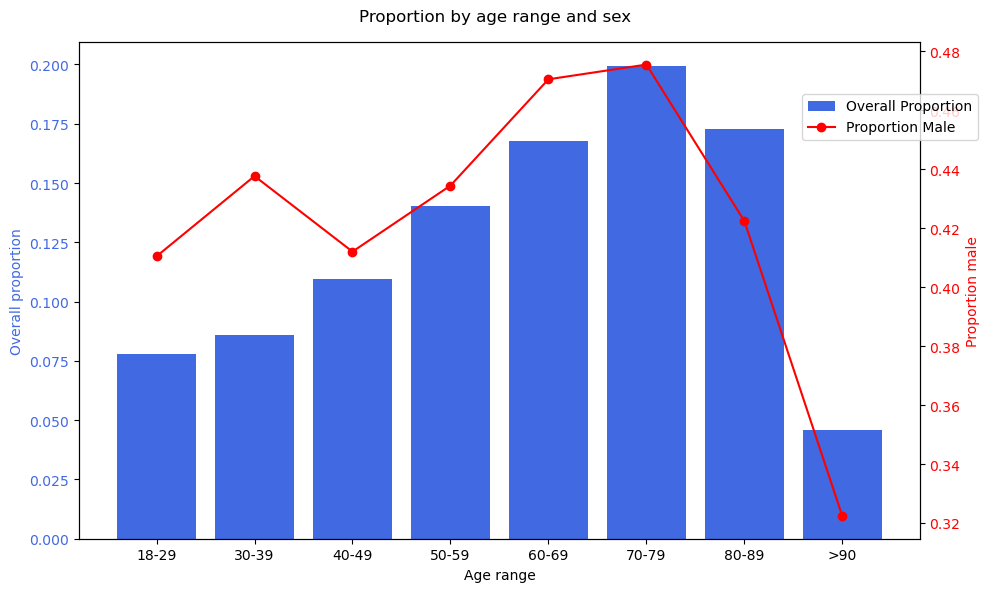

In [12]:
# Summary statistics of sex and age combined visually 

# Calculate overall proportions by age range
proportions = unique_indices_df.groupby('age_range').size() / len(unique_indices_df)

# Plot the bar chart with 'age_range' on x and overall proportion on y
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(proportions.index, proportions, color='#4169E1', label='Overall Proportion')
ax1.set_xlabel('Age range')
ax1.set_ylabel('Overall proportion', color='#4169E1')  # Set the color here
ax1.tick_params(axis='y', labelcolor='#4169E1')  # Set the color here

# Create a secondary y-axis for the line graph
ax2 = ax1.twinx()
proportion_male = unique_indices_df[unique_indices_df['sex'] == 'M'].groupby('age_range').size() / unique_indices_df.groupby('age_range').size()
ax2.plot(proportion_male.index, proportion_male, marker='o', linestyle='-', color='red', label='Proportion Male')
ax2.set_ylabel('Proportion male', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add labels and legend
fig.suptitle('Proportion by age range and sex')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.8, 0.85))

# Save the plot as a JPEG file
plt.savefig('proportion_age_sex.jpg', format='jpeg', dpi=300)

plt.show()


In [13]:
# proportions per age range
proportion_male = unique_indices_df[unique_indices_df['sex'] == 'M'].groupby('age_range').size() / unique_indices_df.groupby('age_range').size()
proportion_male

age_range
18-29    0.410460
30-39    0.437672
40-49    0.412048
50-59    0.434444
60-69    0.470505
70-79    0.475495
80-89    0.422445
>90      0.322324
dtype: float64

## 3. Subset the dataset to retain only the feature columns required for the GMM.

In [134]:
gmm_thresholds_bl = df_both_ears.iloc[:,3:9]

## 4. Identify the optimal number of clusters by evaluating models across a range of cluster counts and multiple random seeds to reduce sensitivity to local minima.

# Function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Step 1: Define Random Seeds and Cluster Range
rand = [1, 10, 20, 30, 40, 50, 60000, 70, 80, 9333330, 100, 110, 120, 13044, 140, 150, 160, 170, 18024, 190, 200]  # 21 random seeds
n_comp = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # Range of clusters

# Track time
start_time = time.time()

# Step 2: Fit Gaussian Mixture Model and Compute BIC and AIC
scores = []  # Store both BIC and AIC

# Create a progress bar with tqdm
total_iterations = len(n_comp) * len(rand)
with tqdm(total=total_iterations, desc="Processing Clusters", unit="iteration") as pbar:
    for i, n in enumerate(n_comp):
        for j, r in enumerate(rand):
            gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=r, reg_covar=0.01)
            gmm.fit(gmm_thresholds_bl)

            bic = gmm.bic(gmm_thresholds_bl)  # Compute BIC
            aic = gmm.aic(gmm_thresholds_bl)  # Compute AIC

            scores.append({'seed': r, 'k': n, 'bic': bic, 'aic': aic})  # Store both scores

            # Update progress bar
            pbar.update(1)

            # Optional: Print progress every 10 iterations
            if (i * len(rand) + j) % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Iteration {i * len(rand) + j}/{total_iterations} completed. Elapsed time: {elapsed_time:.2f} seconds.")

# Step 3: Convert to DataFrame
df_scores = pd.DataFrame(scores)

# Step 4: Normalize BIC and AIC
df_scores['normalized_bic'] = normalize_data(df_scores['bic'])
df_scores['normalized_aic'] = normalize_data(df_scores['aic'])

# Step 5: Calculate Mean and Standard Deviation for Each Cluster Size
cluster_stats = df_scores.groupby('k')[['normalized_bic', 'normalized_aic']].agg(['mean', 'std']).reset_index()

# Track end time
end_time = time.time()
execution_time = end_time - start_time

# Display Results
print("\nDataFrame with BIC and AIC scores:")
print(df_scores)

print("\nDataFrame with cluster statistics (mean & std):")
print(cluster_stats)

print(f"\nTotal execution time: {execution_time:.2f} seconds.")


#save these outputs to csv so not so slow to run each time .
df_scores.to_csv('df_scores_03_02.csv')

cluster_stats.to_csv('cluster_stats_03_02.csv')

In [15]:
# read csv files 
df_bic_scores = pd.read_csv('df_scores_03_02.csv')
cluster_stat = pd.read_csv('cluster_stats_03_02.csv')

In [16]:
# Find the lowest BIC 
min_index = df_bic_scores[df_bic_scores['k'] == 9]['normalized_bic'].idxmin()
min_row = df_bic_scores.loc[[min_index]]
min_row

Unnamed: 0     seed  k           bic           aic  normalized_bic  \
156         156  9333330  9  5.052219e+06  5.049808e+06        0.050399   

     normalized_aic  
156        0.064017

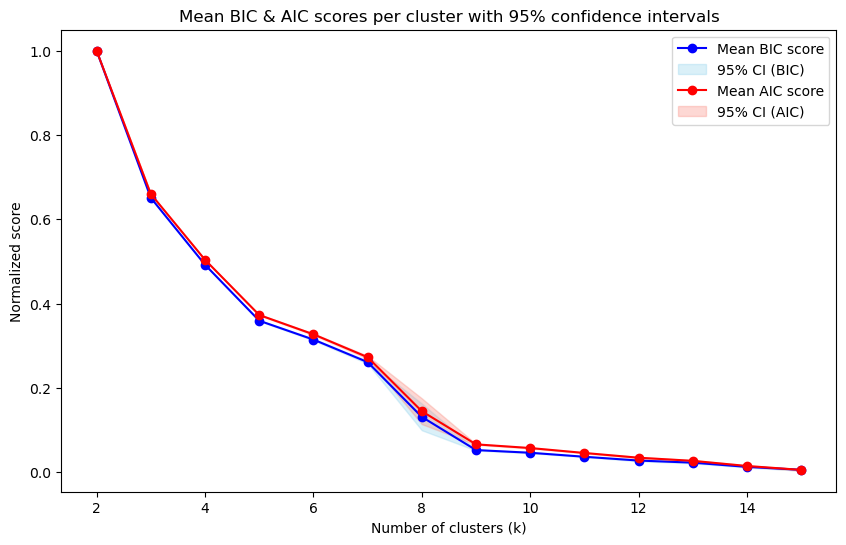


Confidence Intervals for BIC:
    lower_bound  upper_bound
k                           
2      0.999438     0.999833
3      0.650679     0.651187
4      0.492215     0.492235
5      0.358353     0.360662
6      0.312806     0.316716
7      0.257838     0.264715
8      0.099695     0.163035
9      0.051559     0.053868
10     0.045236     0.047403
11     0.036143     0.037540
12     0.026102     0.029585
13     0.021338     0.024320
14     0.011240     0.014395
15     0.003836     0.007882

Confidence Intervals for AIC:
    lower_bound  upper_bound
k                           
2      0.999456     0.999839
3      0.659701     0.660193
4      0.503938     0.503957
5      0.371963     0.374194
6      0.325376     0.329156
7      0.269680     0.276330
8      0.114228     0.175470
9      0.065138     0.067371
10     0.056478     0.058572
11     0.045137     0.046488
12     0.032881     0.036249
13     0.025727     0.028610
14     0.013416     0.016466
15     0.003709     0.007621


In [21]:
# Analyze BIC and AIC scores across different numbers of clusters (k). 
# This cell computes the mean and standard deviation of normalized BIC and AIC scores 
# for each k, calculates 95% confidence intervals, and visualizes the results. 
# The plot helps identify the optimal number of clusters by showing where BIC and AIC 
# are minimized while accounting for variability in the scores.


# Group by 'k' and calculate mean and standard deviation for each group (BIC & AIC)
grouped_bic = df_bic_scores.groupby('k')['normalized_bic']
grouped_aic = df_bic_scores.groupby('k')['normalized_aic']

# Compute mean and standard deviation for each cluster (k)
means_bic = grouped_bic.mean()
std_devs_bic = grouped_bic.std()

means_aic = grouped_aic.mean()
std_devs_aic = grouped_aic.std()

# Number of observations in each group
n_bic = grouped_bic.size()
n_aic = grouped_aic.size()

# Degrees of freedom for each group (n - 1)
df_bic = n_bic - 1
df_aic = n_aic - 1

# Calculate standard error
standard_errors_bic = std_devs_bic / (n_bic ** 0.5)
standard_errors_aic = std_devs_aic / (n_aic ** 0.5)

# Compute t-value for 95% confidence interval
t_value_bic = stats.t.ppf(0.975, df_bic)
t_value_aic = stats.t.ppf(0.975, df_aic)

# Compute margin of error for confidence interval
margin_of_error_bic = t_value_bic * standard_errors_bic
margin_of_error_aic = t_value_aic * standard_errors_aic

# Compute confidence intervals
confidence_intervals_bic = pd.DataFrame({
    'lower_bound': means_bic - margin_of_error_bic,
    'upper_bound': means_bic + margin_of_error_bic
})

confidence_intervals_aic = pd.DataFrame({
    'lower_bound': means_aic - margin_of_error_aic,
    'upper_bound': means_aic + margin_of_error_aic
})

# Plot the means with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(means_bic.index, means_bic, marker='o', label='Mean BIC score', color='blue')
plt.fill_between(means_bic.index, confidence_intervals_bic['lower_bound'], confidence_intervals_bic['upper_bound'], alpha=0.3, label='95% CI (BIC)', color='skyblue')

plt.plot(means_aic.index, means_aic, marker='o', label='Mean AIC score', color='red')
plt.fill_between(means_aic.index, confidence_intervals_aic['lower_bound'], confidence_intervals_aic['upper_bound'], alpha=0.3, label='95% CI (AIC)', color='salmon')

plt.xlabel('Number of clusters (k)')
plt.ylabel('Normalized score')
plt.title('Mean BIC & AIC scores per cluster with 95% confidence intervals')
plt.legend()
plt.grid(False)

plt.savefig('elbow_bic_aic.jpg', format='jpeg', dpi=300)
plt.show()

# Display the confidence interval results
print("\nConfidence Intervals for BIC:")
print(confidence_intervals_bic)

print("\nConfidence Intervals for AIC:")
print(confidence_intervals_aic)


## 5. Run the GMM with the optimal cluster number 

In [22]:
# Fit a 9-component Gaussian Mixture Model
gmm_bl_9 = GaussianMixture(n_components=9, covariance_type='full',
                           random_state=20, reg_covar=0.01)
gmm_bl_9.fit(gmm_thresholds_bl)

# Assign each observation to its most likely cluster
cluster_assignments = gmm_bl_9.predict(gmm_thresholds_bl)


## 6. Define Each Cluster by Features

This step summarises the characteristics of each cluster. We first extract the mean vector for each cluster and display it. Then, we compute additional summary statistics for each cluster, including:

Number of samples assigned to the cluster

Feature-wise quartiles (25th and 75th percentiles)

These metrics provide a concise description of the cluster profiles in terms of the original features. This is then displayed visally. 


In [23]:


# Extract the mean vector for each of the 9 clusters
cluster1 = gmm_bl_9.means_[0, :]
cluster2 = gmm_bl_9.means_[1, :]
cluster3 = gmm_bl_9.means_[2, :]
cluster4 = gmm_bl_9.means_[3, :]
cluster5 = gmm_bl_9.means_[4, :]
cluster6 = gmm_bl_9.means_[5, :]
cluster7 = gmm_bl_9.means_[6, :]
cluster8 = gmm_bl_9.means_[7, :]
cluster9 = gmm_bl_9.means_[8, :]

# Loop through clusters 1–9 and print each mean vector
for i in range(1, 10):
    cluster_name = f'cluster{i}'            # Construct the variable name
    cluster_value = locals()[cluster_name]  # Retrieve the cluster mean by name
    print(f'{cluster_name}: {cluster_value}')

num_clusters = gmm_bl_9.n_components

# Initialize an array to store the number of samples in each cluster
num_samples_per_cluster = np.zeros(num_clusters, dtype=int)

# Count the number of samples in each cluster
for cluster in range(num_clusters):
    num_samples_per_cluster[cluster] = np.sum(cluster_assignments == cluster)

# Initialize dictionaries to store quartiles for each cluster and each feature
lower_quartiles = {}
upper_quartiles = {}

# Calculate quartiles for each feature and each cluster
for cluster in range(num_clusters):
    cluster_data = gmm_thresholds_bl.iloc[cluster_assignments == cluster, :]
    lower_quartiles[cluster] = np.percentile(cluster_data, 25, axis=0)
    upper_quartiles[cluster] = np.percentile(cluster_data, 75, axis=0)

# Now lower_quartiles and upper_quartiles contain the lower and upper quartiles for each feature in each cluster


cluster1: [40.86861621 44.86247698 50.10727389 55.34135712 64.46894604 77.77393715]
cluster2: [33.95909826 37.21897492 41.43913995 41.44995642 47.69824679 56.48174357]
cluster3: [ 80.81559988  92.55417215 106.15003504 116.014722   120.
 107.82326012]
cluster4: [15.97054116 15.57247101 15.25318396 15.62753783 24.7308778  38.21656725]
cluster5: [24.39629271 26.65529191 32.9937102  47.02384372 61.77033045 74.11182446]
cluster6: [67.92266081 69.70565819 72.24847626 73.849151   83.31894424 94.26956728]
cluster7: [15.67074263 17.26698178 20.15720364 27.88761465 48.19387911 58.35826203]
cluster8: [ 42.19498249  48.46199     60.39821851  75.51455224  95.67893788
 101.35324666]
cluster9: [10.08114901  9.06050844  8.74700111  7.94046014 10.49268461 12.32786196]


In [135]:
#create copy of the dataframe in order to update the cluster labels 

gmm_thresholds_bl_copy = gmm_thresholds_bl.copy(deep = True)

# Add cluster assignments to your data (assuming gmm_thresholds_bl is a DataFrame)
gmm_thresholds_bl_copy['cluster'] = cluster_assignments

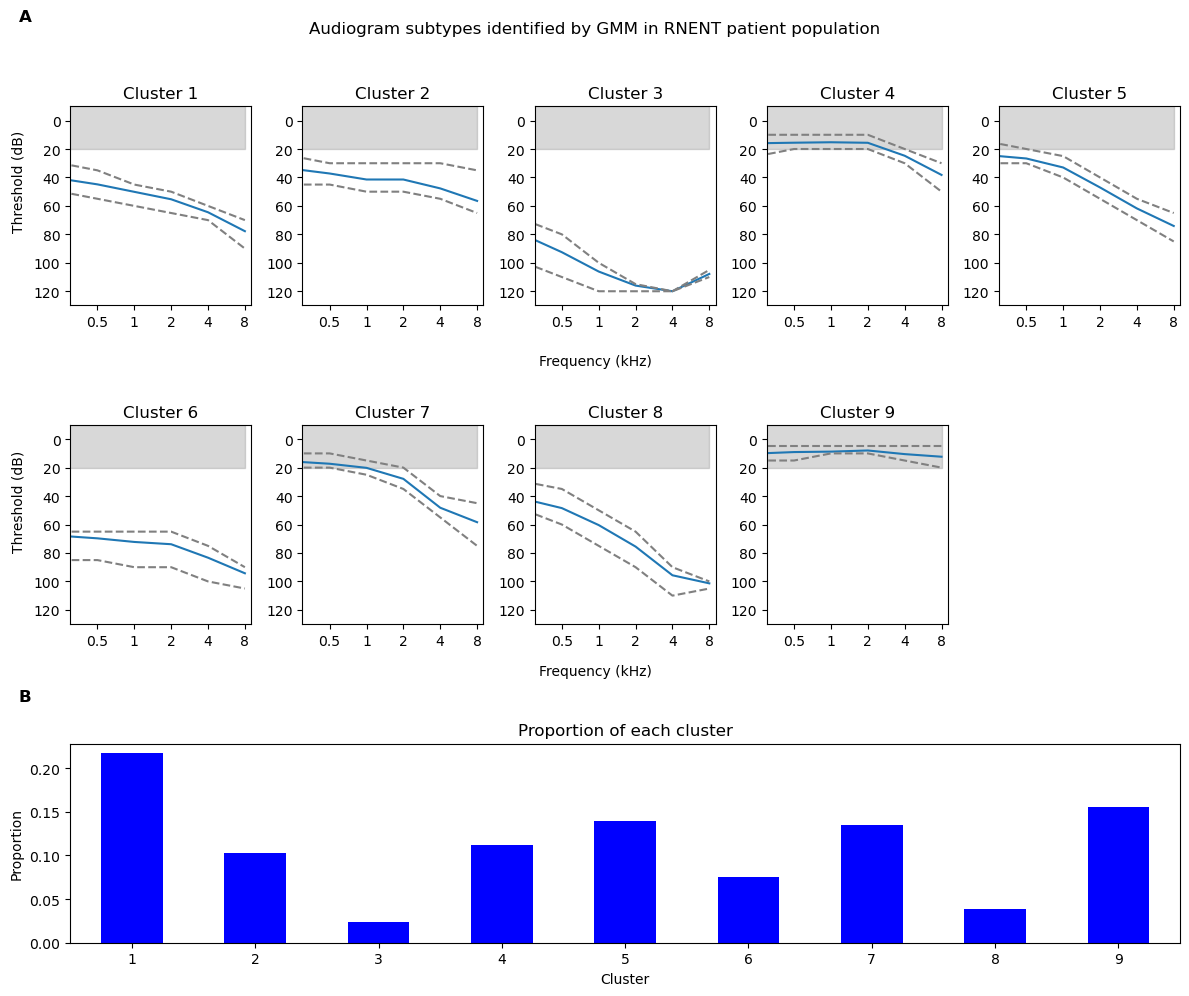

In [25]:

# ---------------------------
# Create figure layout
# ---------------------------
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 5, figure=fig)  # 3 rows, 5 columns

# Top 2 rows: 9 audiogram plots
axes_audiograms = []
for i in range(9):
    ax = fig.add_subplot(gs[i // 5, i % 5])  # row, col
    axes_audiograms.append(ax)

# Delete the empty 10th subplot (bottom-right of audiograms grid)
fig.delaxes(fig.add_subplot(gs[1, 4]))

# Bottom row: bar chart spanning all columns
ax_bar = fig.add_subplot(gs[2, :])

# ---------------------------
# General figure settings
# ---------------------------
fig.suptitle('Audiogram subtypes identified by GMM in RNENT patient population')

fig.text(0.5, 0.33, "Frequency (kHz)", ha="center", va="center")
#fig.supxlabel("Frequency (kHz)")

# Add shared x-axis label for the top row of audiograms
fig.text(0.5, 0.64, "Frequency (kHz)", ha="center", va="center")  # adjust y=0.68 to sit below top row

# Add shared y-axis label for the top row of audiograms
fig.text(0.02, 0.82, "Threshold (dB)", ha="center", va="center", rotation=90)  # adjust x=0.02, y=0.85



fig.text(0.02, 0.5, "Threshold (dB)", ha="center", va="center", rotation=90)

x = [250, 500, 1000, 2000, 4000, 8000]
ticks = [.25, 0.5, 1, 2, 4, 8]
shade_y_min = -10
shade_y_max = 20

# ---------------------------
# Formatting audiogram subplots
# ---------------------------
for ax in axes_audiograms:
    ax.set_xscale('log', base=2)
    ax.set_xticks(x)
    ax.set_xticklabels(ticks)
    ax.invert_yaxis()
    ax.set_xlim(300, 9000)
    ax.set_ylim(130, -10)
    ax.set_facecolor("none")
    ax.grid(False)
    ax.fill_between(x, shade_y_min, shade_y_max, color='gray', alpha=0.3)

# ---------------------------
# Plot clusters + quartiles automatically
# ---------------------------
clusters = [cluster1, cluster2, cluster3, cluster4, cluster5,
            cluster6, cluster7, cluster8, cluster9]

for i, ax in enumerate(axes_audiograms):
    ax.plot(x, clusters[i], label=f"Cluster {i+1}")
    ax.plot(x, lower_quartiles[i], '--', color='grey')
    ax.plot(x, upper_quartiles[i], '--', color='grey')
    ax.set_title(f"Cluster {i+1}")

# Add annotation 'A' for audiograms
fig.text(0.02, 0.98, 'A', fontsize=12, fontweight='bold', color='black')

# ---------------------------
# Bar chart: cluster proportions
# ---------------------------
cluster_proportions = gmm_thresholds_bl_copy['cluster'].value_counts(normalize=True).sort_index()
cluster_proportions.index = cluster_proportions.index + 1
cluster_proportions.plot(kind='bar', color='blue', ax=ax_bar)

ax_bar.set_title('Proportion of each cluster')
ax_bar.set_xlabel('Cluster')
ax_bar.set_ylabel('Proportion')
ax_bar.tick_params(axis='x', rotation=0)

# Add annotation 'B' for bar chart
fig.text(0.02, 0.30, 'B', fontsize=12, fontweight='bold', color='black')

# ---------------------------
# Save final combined figure
# ---------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.subplots_adjust(hspace=0.6)  # adjust just the spacing between rows

plt.savefig('prevalence+pheno_clusters.jpg', format='jpeg', dpi=300, bbox_inches="tight")
plt.show()


## 7. Define each cluster by demographics (age and sex)

In [136]:
# re-insert age and sex and laterality data into dataframe with cluster label

merge = pd.concat([gmm_thresholds_bl_copy, df_both_ears[['age', 'age_range', 'sex', 'side']]], axis=1)

merge['cluster'] = merge['cluster'] + 1 #add 1 so that there is no cluster labelled "0"


C:\Users\lilyg\AppData\Local\Temp\ipykernel_2280\1653814922.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merge, x="cluster", y="age", ax=ax2, palette=palette)


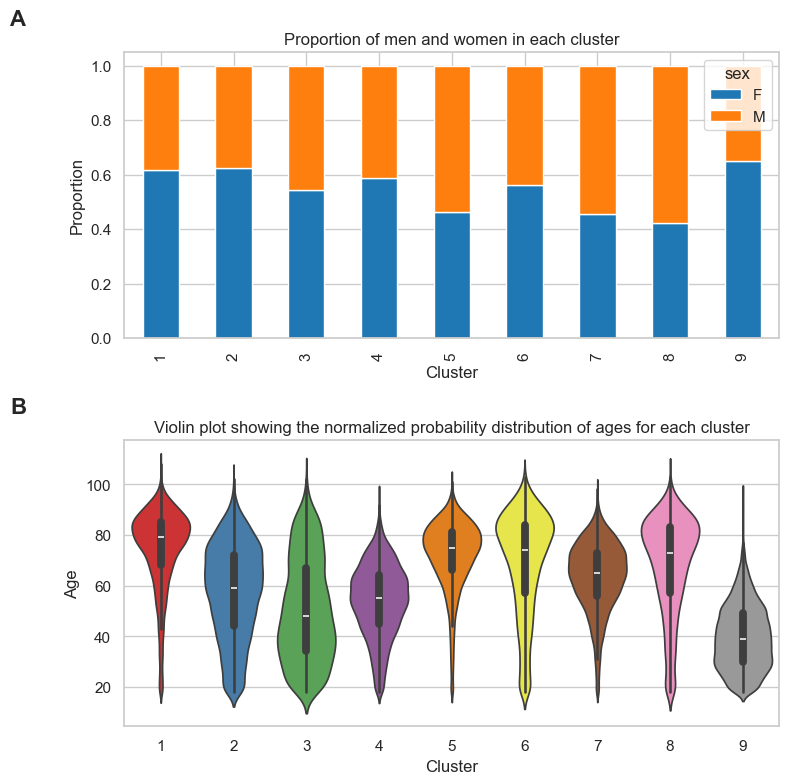

In [27]:
# Visualise sex and age  distribution per cluster 

# Set the style for Seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots (1 row, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# --- Stacked Bar Chart ---
# Calculate the proportion of men and women in each cluster
proportions = merge.groupby(['cluster', 'sex']).size() / merge.groupby('cluster').size()
proportions = proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'sex' as columns for each cluster
proportions_pivot = proportions.pivot(index='cluster', columns='sex', values='proportion')

# Create a stacked bar chart on the first subplot (ax1)
proportions_pivot.plot(kind='bar', stacked=True, ax=ax1, color=['#1f77b4', '#ff7f0e'])

# Set plot labels and title for the first subplot
ax1.set_title('Proportion of men and women in each cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Proportion')

# Add label 'A' to the top-left corner of the first subplot
ax1.text(-0.15, 1.15, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# --- Violin Plot ---
palette = sns.color_palette("Set1", n_colors=merge['cluster'].nunique())
sns.violinplot(data=merge, x="cluster", y="age", ax=ax2, palette=palette)

# Set title and axis labels for violin plot
ax2.set_title("Violin plot showing the normalized probability distribution of ages for each cluster")
ax2.set_xlabel("Cluster")  # Capitalized
ax2.set_ylabel("Age")      # Capitalized

# Add label 'B' to the top-left corner of the second subplot
ax2.text(-0.15, 1.15, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('clusters_age_sex.jpg', format='jpeg', dpi=300)
# Show the plot
plt.show()


## 8. Examine patients with noise-induced hearing loss and identify which existing clusters they have been grouped into, since they do not form a distinct cluster.

In [28]:

#apple Coles et al criteria for NIHL

noise_coles = gmm_thresholds_bl[
    (gmm_thresholds_bl['ac_4000'] - gmm_thresholds_bl['ac_8000'] >= 10) &
    (
        (gmm_thresholds_bl['ac_4000'] - gmm_thresholds_bl['ac_2000'] >= 10) |
        (gmm_thresholds_bl['ac_4000'] - gmm_thresholds_bl['ac_1000'] >= 10)
    )
]
noise_coles.count()
print("noise-induced hearing loss with atleast 10dB threshold sized dip at 4kHz", noise_coles.count()) #10621

noise-induced hearing loss with atleast 10dB threshold sized dip at 4kHz ac_250     10580
ac_500     10580
ac_1000    10580
ac_2000    10580
ac_4000    10580
ac_8000    10580
dtype: int64


In [138]:
####now assign everyone in our dataframe as noise 

merge['noise'] = (
    (merge['ac_4000'] - merge['ac_8000'] >= 10) & 
    (
        (merge['ac_4000'] - merge['ac_2000'] >= 10) |
        (merge['ac_4000'] - merge['ac_1000'] >= 10)
    )
).astype(int)


<function matplotlib.pyplot.show(close=None, block=None)>

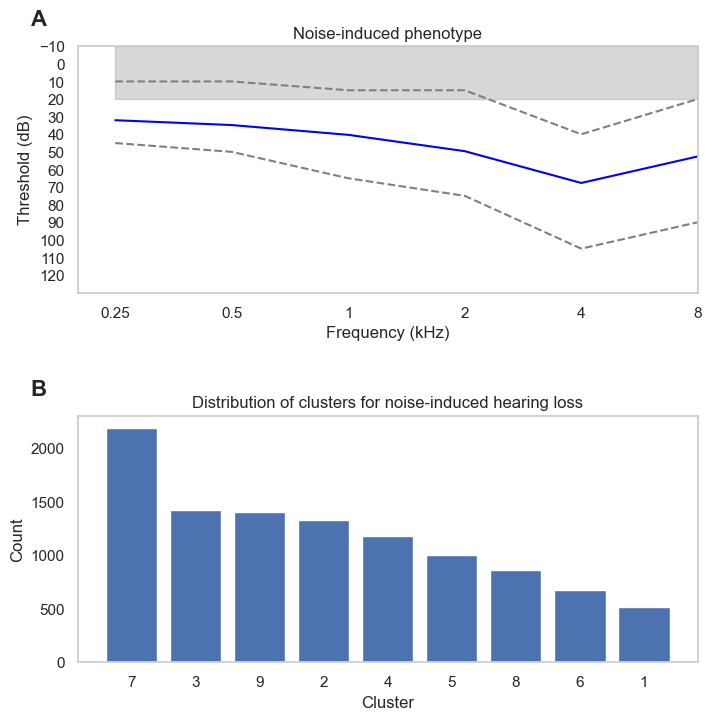

In [30]:

# Count the occurrences of each cluster for rows where 'noise' is equal to 1
cluster_counts = merge[merge['noise'] == 1]['cluster'].value_counts()

# Sort clusters based on descending frequency
sorted_clusters = cluster_counts.sort_values(ascending=False)
 
# Filter the DataFrame based on the 'noise' column
filtered_merge = merge[merge['noise'] == 1]

# Calculate the mean across the first 6 columns for the filtered DataFrame
mean_values = filtered_merge.iloc[:, :6].mean()


#calculate the IQR

# Extract the first 6 columns for calculation
quartiles = filtered_merge.iloc[:,:6].quantile([0.25, 0.75])
upper_quartiles = quartiles.iloc[0].to_numpy()
lower_quartiles = quartiles.iloc[1].to_numpy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5) 

ax1.set_title("Noise-induced phenotype")
ax1.set_ylabel("Threshold (dB)")
ax1.set_xlabel("Frequency (kHz)")
ax1.set_xlim(0.200,0.9000)
ax1.set_ylim(130,-10)
ax1.set_facecolor("none")

x = [0.25,0.500,1,2,4,8]
ticks = [0.25,0.500,1,2,4,8]


ax1.set_xscale('log', base=2)
ax1.set_xticks(x)
ax1.set_xticklabels(ticks)
ax1.fill_between(x, shade_y_min, shade_y_max, color='gray', alpha=0.3)


ax1.yaxis.set_ticks([120,110,100,90,80,70,60,50,40,30,20,10,0,-10])

ax1.plot()
ax1.grid(color="grey")
ax1.grid(axis="x", which='minor',color="grey", linestyle="--")
ax1.plot(x, mean_values, label='Mean Values', c = 'blue')
ax1.plot(x, upper_quartiles, c = 'grey',  linestyle='--')
ax1.plot(x, lower_quartiles, c = 'grey', linestyle='--')
ax1.grid(False)
#ax1.plot(x, )

# Add label 'B' to the top-left corner of the second subplot
ax1.text(-0.05, 1.15, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')



# Plot the mean values


import matplotlib.pyplot as plt


# Count the occurrences of each cluster for rows where 'noise' is equal to 1
cluster_counts = merge[merge['noise'] == 1]['cluster'].value_counts()

# Sort clusters based on descending frequency
sorted_clusters = cluster_counts.sort_values(ascending=False)

# Plotting
plt.bar(sorted_clusters.index.astype(str), sorted_clusters.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of clusters for noise-induced hearing loss')
plt.grid(False)

# Add label 'B' to the top-left corner of the second subplot
ax2.text(-0.05, 1.15, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Save the plot as a JPEG file
plt.savefig('clusters_NOISE.jpg', format='jpeg', dpi=300)
plt.show




## 9. Examine patients with Meniere's phenotype and identify which existing clusters they have been grouped into."

"""Meniere's disease

Low-frequency loss defined audiometrically using pre-established criteria.
First, the low-frequency, mid-frequency, and high-frequency hearing losses L1, L2, and L3 were computed as:

L1 = [(threshold at 250 Hz) + (threshold at 500 Hz)] / 2
L2 = [(threshold at 1 kHz) + (threshold at 2 kHz)] / 2
L3 = [(threshold at 4 kHz) + (threshold at 8 kHz)] / 2

‘Low’ frequency losses, i.e., reverse sloping hearing loss, defined as:

L3 − L1 ≤ −10
"""

In [31]:
# Calculate low-frequency (L1) and high-frequency (L3) averages
L1 = (gmm_thresholds_bl['ac_250'] + gmm_thresholds_bl['ac_500']) / 2
L3 = (gmm_thresholds_bl['ac_4000'] + gmm_thresholds_bl['ac_8000']) / 2

# Create a new column that flags Meniere's-like hearing loss
merge['meniere'] = ((L3 - L1) <= -10).astype(int)


# Print how many were identified
print("Reverse sloping hearing loss (Meniere's pattern):", merge['meniere'].sum())


Reverse sloping hearing loss (Meniere's pattern): 4107


<function matplotlib.pyplot.show(close=None, block=None)>

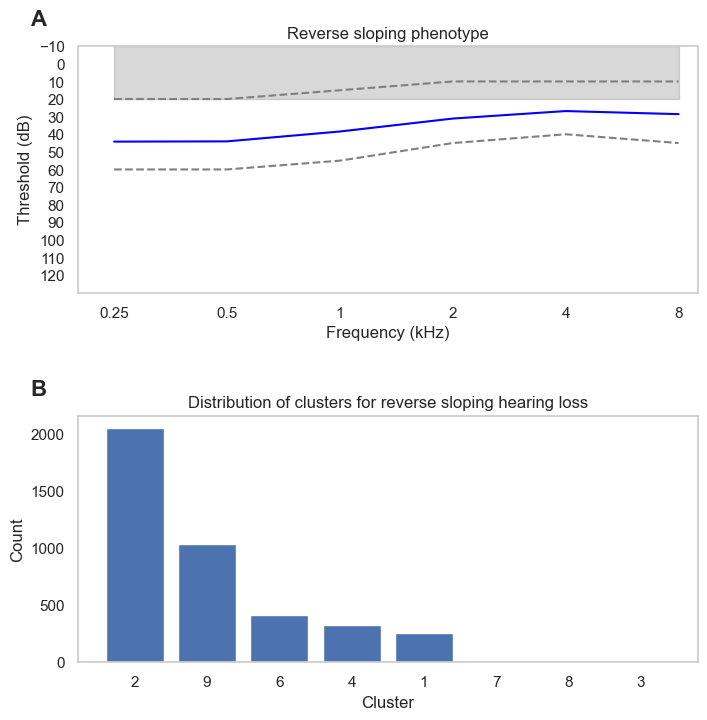

In [33]:
# Count the occurrences of each cluster for rows where 'meniere' is equal to 1
cluster_counts = merge[merge['meniere'] == 1]['cluster'].value_counts()

# Sort clusters based on descending frequency
sorted_clusters = cluster_counts.sort_values(ascending=False)
 
# Filter the DataFrame based on the 'noise' column
filtered_merge = merge[merge['meniere'] == 1]

# Calculate the mean across the first 6 columns for the filtered DataFrame
mean_values = filtered_merge.iloc[:, :6].mean()


#calculate the IQR

# Extract the first 6 columns for calculation
quartiles = filtered_merge.iloc[:,:6].quantile([0.25, 0.75])
upper_quartiles = quartiles.iloc[0].to_numpy()
lower_quartiles = quartiles.iloc[1].to_numpy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5) 

ax1.set_title("Reverse sloping phenotype")
ax1.set_ylabel("Threshold (dB)")
ax1.set_xlabel("Frequency (kHz)")
ax1.set_xlim(0.200,9.000)
ax1.set_ylim(130,-10)
ax1.set_facecolor("none")

x = [0.25,0.500,1,2,4,8]
ticks = [0.25,0.500,1,2,4,8]

ax1.set_xscale('log', base=2)
ax1.set_xticks(x)
ax1.set_xticklabels(ticks)
ax1.fill_between(x, shade_y_min, shade_y_max, color='gray', alpha=0.3)


ax1.yaxis.set_ticks([120,110,100,90,80,70,60,50,40,30,20,10,0,-10])

ax1.plot()
ax1.grid(color="grey")
ax1.grid(axis="x", which='minor',color="grey", linestyle="--")
ax1.plot(x, mean_values, label='Mean Values', c = 'blue')
ax1.plot(x, upper_quartiles, c = 'grey',  linestyle='--')
ax1.plot(x, lower_quartiles, c = 'grey', linestyle='--')
ax1.grid(False)
#ax1.plot(x, )

# Add label 'B' to the top-left corner of the second subplot
ax1.text(-0.05, 1.15, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')



# Plot the mean values


import matplotlib.pyplot as plt


# Count the occurrences of each cluster for rows where 'noise' is equal to 1
cluster_counts = merge[merge['meniere'] == 1]['cluster'].value_counts()

# Sort clusters based on descending frequency
sorted_clusters = cluster_counts.sort_values(ascending=False)

# Plotting
plt.bar(sorted_clusters.index.astype(str), sorted_clusters.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of clusters for reverse sloping hearing loss')
plt.grid(False)

# Add label 'B' to the top-left corner of the second subplot
ax2.text(-0.05, 1.15, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Save the plot as a JPEG file
plt.savefig('clusters_meniere.jpg', format='jpeg', dpi=300)
plt.show



## 10. Create heatmap to see correlation between cluster assisgment between right and left ear pairs 

left_cluster      1     2    3     4     5     6     7    8     9
right_cluster                                                    
1              7524   817   46   116  1501  1015   319  383    56
2               933  2494   23   580   566   229   470  142   253
3                43    20  789    26    22   239    18  120    45
4               192   607   17  2931   218   123  1164   56  1092
5              1447   466   19   181  3733   210  1077  293    44
6              1030   194  225    85   197  1968   105  250    43
7               420   455   31   802  1285   126  3925  118   166
8               372   120  100    43   304   251    91  772    31
9               118   362   52  1165    77    71   258   39  6617


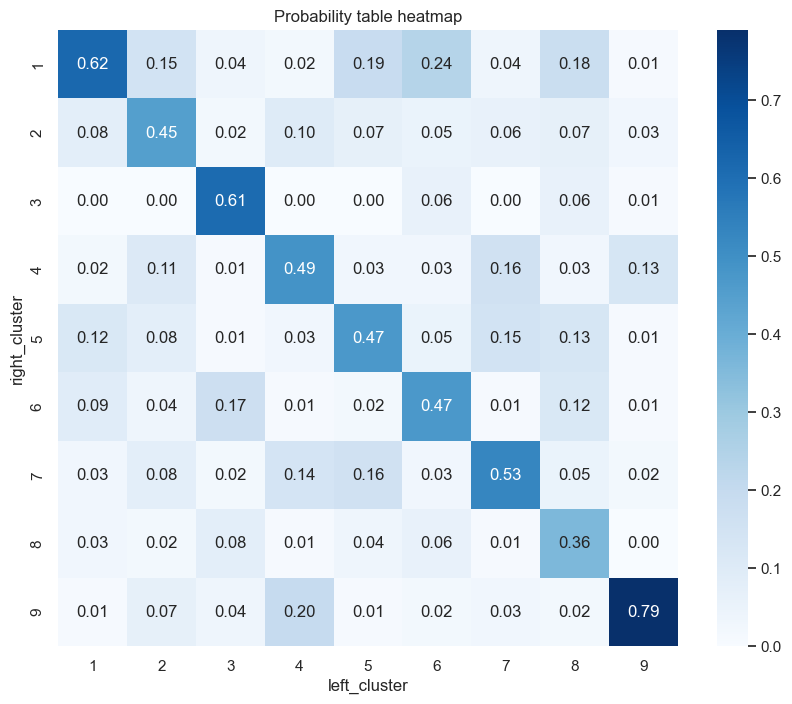

In [34]:

# Pivot the DataFrame to have 'side' and 'cluster' as separate columns
result = merge.pivot_table(index='rid', columns='side', values='cluster', aggfunc='first').reset_index()

# Rename columns if needed
result.columns.name = None  # Remove the 'side' label on columns
result = result.rename(columns={'left': 'left_cluster', 'right': 'right_cluster'})

result

# Create a contingency table
contingency_table = pd.crosstab(result['left_cluster'], result['right_cluster']).transpose()

print(contingency_table)


# Calculate the probability
probability_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
probability_table





# Round the values in the probability table to 2 decimal places
probability_table_rounded = probability_table.round(2)

# Plot the heatmap for the probability table with rounded values
plt.figure(figsize=(10, 8))
sns.heatmap(probability_table_rounded, annot=True, cbar=True, fmt=".2f", cmap = 'Blues')
plt.title("Probability table heatmap")
plt.savefig('heatmap.jpg', format='jpeg', dpi=300)
plt.show()



## 11. REPLICATION ANALYSIS: BOOTSTRAPPING

### Step 1 - Define 2 new functions
"""The first creates lists of the patient_ids allocated to each cluster
the second calculates how similar the ids are between the original GMM model and the replication model to give the jaccard score"""

In [73]:
def clusters(info_copy):

    clusters = []
    unique_labels = info_copy['cluster'].unique()

    for label in unique_labels:
        # get all index values for rows belonging to this cluster
        clus = info_copy.index[info_copy['cluster'] == label].tolist()
        clusters.append(clus)

    return clusters

def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

### Step 2
"""Create 1000 boostrap samples"""

In [37]:
num_samples = 1000 

# Set a seed for reproducibility
np.random.seed(42)

# Generate bootstrap samples using the specified seed
bootstrap_samples = [gmm_thresholds_bl_copy.iloc[:, :-1].sample(frac=1, replace=True) for _ in range(num_samples)]

### Step 3  
"""run the GMM on each of the 1000 boostrap samples and assign each patient in each bootstrap a cluster"""

In [52]:
# Number of clusters for GMM
num_clusters = 9  

# Apply GMM to each bootstrap sample
for sample in bootstrap_samples:
    gmm = mixture.GaussianMixture(n_components=9, covariance_type='full', random_state=20, reg_covar=0.01)
    gmm.fit(sample.iloc[:, 0:6])
    boot_labels = gmm.predict(sample.iloc[:, 0:6])
    sample["cluster"] = boot_labels


### Step 4 

"""Apply the cluster function to the orginal dataset to have the comparator list of patient_ids for each cluster"""

In [91]:
clusters_init = clusters(gmm_thresholds_bl_copy)

### Step 5 
"""Computing the Jaccard similarity score between each bootstrap sample and the original model"""

In [77]:
#apply the cluster function to each bootstrap sample and calculate the jaccard score between the original cluster assigments and the assisgment per bootstrap
# then for each bootstrap sample, find the cluster that is most similar in terms of patient membership with the original cluster assignment across the whole dataset


n_clus = 9
boot = []
for df in bootstrap_samples: # Iterates over each bootstrap sample
    j = clusters(df) # Extracts clusters from the current bootstrap sample
    bootresults = []  #Stores Jaccard similarity scores for this bootstrap sample
    for k in range(n_clus): # Iterates over the original clusters (n_clus = 9)
        max_similarity = max(jaccard_similarity(clusters_init[k], j_cluster) for j_cluster in j) #Finds the most similar cluster in the bootstrap sample (j) to the original cluster (clusters_init[k]) by computing Jaccard similarity for each pair and selecting the maximum value.
        bootresults.append(max_similarity) #Stores the highest similarity for this cluster
    boot.append(bootresults) 

#bootresult is a list stores the maximum jaccard score for each cluster in a single bootstrap sample. Boot is a list of 1000 lists where each list is a bootresult

print(len(boot))  # Number of bootstrap samples = 1000
print(len(boot[0]))  # Number of clusters per sample = 9 

1000
9


## 12. REPLICATION ANALYSIS: Different model initialisations

### Step 1 
"""run the GMM on each of the 20 different initialisation models and assign each patient in each model a cluster"""

In [97]:
random_seeds = [1, 10, 30, 40, 50, 60000, 70, 80, 9333330, 100, 110, 120, 13044, 140, 150, 160, 170, 18024, 190, 200] #remove 20
df_list = []
# Apply GMM to each bootstrap sample
for r in random_seeds:
    info_copy_seed = gmm_thresholds_bl_copy.copy(deep=True)
    gmm = mixture.GaussianMixture(n_components=9, covariance_type='full', random_state=r, reg_covar=0.01)
    gmm_start = gmm.fit(info_copy_seed.iloc[:, 0:6])
    init_labels = gmm_start.predict(info_copy_seed.iloc[:, 0:6])
    info_copy_seed["cluster"] = init_labels
    df_list.append(info_copy_seed)




### Step 2 
"""Calculate jaccard score between the Original cluster model and each different initialisation model""" 

In [99]:

n_clus = 9
itlist = []


for l in df_list:
    j = clusters(l)
    iteration_results = []
    for k in range(n_clus):
        max_similarity = max(jaccard_similarity(clusters_init[k], j_cluster) for j_cluster in j)
        iteration_results.append(max_similarity)
    itlist.append(iteration_results)   




### Visualise Jaccard scores across initialisations and bootstrap samples 


95% Confidence Intervals for Bootstrap Samples:
Cluster 1: Mean = 0.628, 95% CI = (0.621, 0.636)
Cluster 2: Mean = 0.550, 95% CI = (0.542, 0.559)
Cluster 3: Mean = 0.576, 95% CI = (0.567, 0.585)
Cluster 4: Mean = 0.594, 95% CI = (0.588, 0.599)
Cluster 5: Mean = 0.536, 95% CI = (0.528, 0.545)
Cluster 6: Mean = 0.701, 95% CI = (0.697, 0.705)
Cluster 7: Mean = 0.551, 95% CI = (0.542, 0.560)
Cluster 8: Mean = 0.612, 95% CI = (0.607, 0.618)
Cluster 9: Mean = 0.766, 95% CI = (0.765, 0.767)

95% Confidence Intervals for Iterating Initializations:
Cluster 1: Mean = 0.939, 95% CI = (0.881, 0.996)
Cluster 2: Mean = 0.890, 95% CI = (0.814, 0.966)
Cluster 3: Mean = 0.888, 95% CI = (0.807, 0.968)
Cluster 4: Mean = 0.925, 95% CI = (0.861, 0.988)
Cluster 5: Mean = 0.890, 95% CI = (0.805, 0.974)
Cluster 6: Mean = 0.996, 95% CI = (0.995, 0.998)
Cluster 7: Mean = 0.906, 95% CI = (0.818, 0.995)
Cluster 8: Mean = 0.913, 95% CI = (0.854, 0.972)
Cluster 9: Mean = 0.988, 95% CI = (0.978, 0.997)


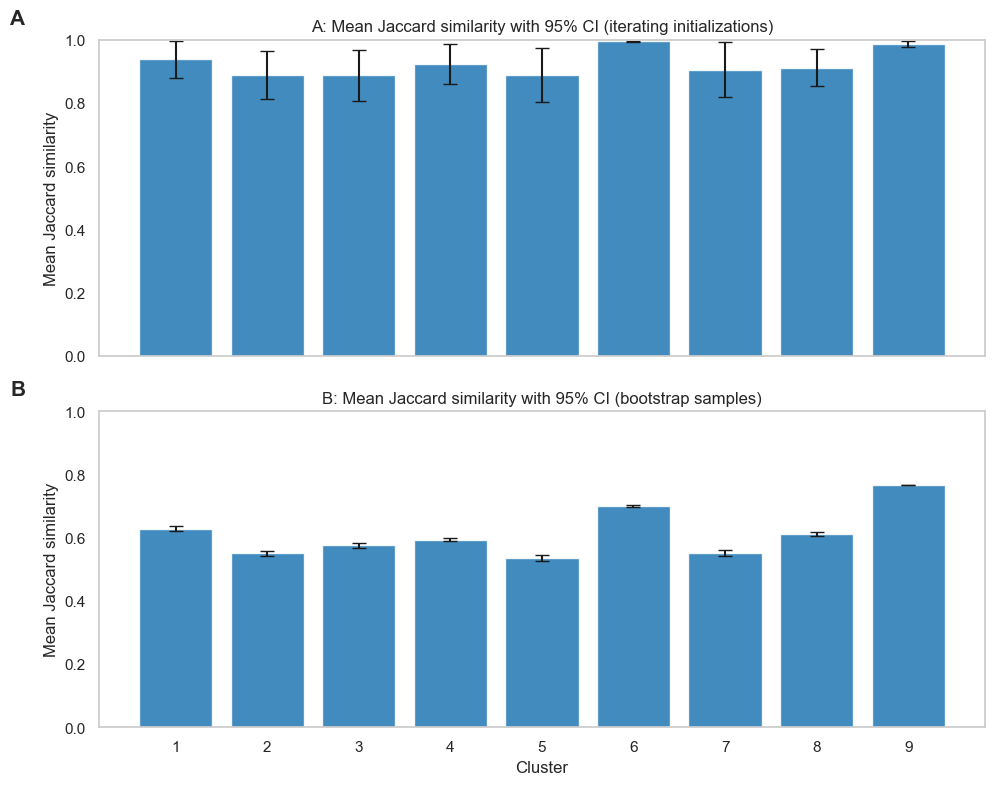

In [101]:
### STEP 1: Compute 95% Confidence Intervals for Bootstrap Samples ###
boot_array = np.array(boot)  # Convert list to NumPy array of size 1000, 9

# Compute mean values
mean_values = np.mean(boot_array, axis=0) #Computes the mean Jaccard similarity for each cluster across all bootstrap samples

# Compute standard error (SE)
std_err_values = np.std(boot_array, axis=0, ddof=1) / np.sqrt(len(boot_array))

# Compute t-critical value for 95% CI
t_critical = t.ppf(0.975, df=len(boot_array) - 1)

# Compute margin of error (MoE)
margin_of_error = t_critical * std_err_values

# Compute confidence intervals
lower_bound = mean_values - margin_of_error
upper_bound = mean_values + margin_of_error

# Ensure bounds stay within valid range [0,1]
lower_bound = np.maximum(lower_bound, 0)
upper_bound = np.minimum(upper_bound, 1.2)

# Compute correct error bar lengths
error_bar_lengths = upper_bound - mean_values

# Store results
result_ci = list(zip(mean_values, lower_bound, upper_bound))

print("\n95% Confidence Intervals for Bootstrap Samples:")
for i, (mean, low, high) in enumerate(result_ci):
    print(f"Cluster {i+1}: Mean = {mean:.3f}, 95% CI = ({low:.3f}, {high:.3f})")

### STEP 2: Compute 95% Confidence Intervals for Iterating Initializations 
it_array = np.array(itlist)  # Convert list to NumPy array

# Compute mean values
mean_values_it = np.mean(it_array, axis=0)

# Compute standard error (SE)
std_err_values_it = np.std(it_array, axis=0, ddof=1) / np.sqrt(len(it_array))

# Compute t-critical value for 95% CI
t_critical_it = t.ppf(0.975, df=len(it_array) - 1)

# Compute margin of error (MoE)
margin_of_error_it = t_critical_it * std_err_values_it

# Compute confidence intervals
lower_bound_it = mean_values_it - margin_of_error_it
upper_bound_it = mean_values_it + margin_of_error_it

# Ensure bounds stay within valid range [0,1]
lower_bound_it = np.maximum(lower_bound_it, 0)
upper_bound_it = np.minimum(upper_bound_it, 1.2)

# Compute correct error bar lengths
error_bar_lengths_it = upper_bound_it - mean_values_it

# Store results
result_it_ci = list(zip(mean_values_it, lower_bound_it, upper_bound_it))

print("\n95% Confidence Intervals for Iterating Initializations:")
for i, (mean, low, high) in enumerate(result_it_ci):
    print(f"Cluster {i+1}: Mean = {mean:.3f}, 95% CI = ({low:.3f}, {high:.3f})")

### STEP 3: Plot the Results ###

# Define x-axis labels
clusters_xaxis = range(1, len(mean_values_it) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot 1: Mean Jaccard Similarity for Different Initializations (95% CI)
ax1.bar(clusters_xaxis, mean_values_it, yerr=error_bar_lengths_it, capsize=5, color="#1f77b4", alpha=0.85)
ax1.set_ylabel('Mean Jaccard similarity')
ax1.set_title('A: Mean Jaccard similarity with 95% CI (iterating initializations)')
ax1.set_ylim(0, 1)
ax1.grid(False)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, size=15, weight='bold')

# Plot 2: Mean Jaccard Similarity for Bootstrap Samples (95% CI)
ax2.bar(clusters_xaxis, mean_values, yerr=error_bar_lengths, capsize=5, color='#1f77b4', alpha=0.85)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Mean Jaccard similarity')
ax2.set_title('B: Mean Jaccard similarity with 95% CI (bootstrap samples)')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, size=15, weight='bold')

# Adjust layout and show plot
plt.xticks(clusters_xaxis)
plt.tight_layout()
plt.savefig('jaccard_95CI_subplots.jpg', format='jpeg', dpi=300)
plt.show()


### 13. REPLICATION ANALYSIS: Altering dataset size 

### Step 1 
"""Create 1000 samples from 10-90% of the original dataset"""

In [102]:

np.random.seed(42)
num_samples_per_percentage = 1000
bootstrap_samples_percent = []

# Generate 1000 bootstrap samples for each percentage from 10% to 90%
for percentage in range(10, 91, 10):
    fraction = percentage / 100.0
    samples_for_percentage = [gmm_thresholds_bl_copy.sample(frac=fraction, replace=False) for _ in range(num_samples_per_percentage)]
    bootstrap_samples_percent.append((percentage, samples_for_percentage))bootstrap_samples_percent

### Step 2 
"""Initialize lists to store the filenames of pickle files """

In [128]:
per_percentage_boot_pickle_filenames = []
per_percentage_bootresults_pickle_filenames = []
all_boot = []
all_bootresults = []

### Step 3 
"""Apply GMM and cluster/Jaccard function to each bootstrap sample for every percentage"""

In [129]:
for percentage, samples in tqdm(bootstrap_samples_percent, desc="Processing percentages", unit="percentage"):
    bootresults = []  # List to store maximum similarity scores for each sample in the current percentage
    mean_bootresults = []
    
    # Inner loop: iterate over each sample in the current percentage
    for sample_index, sample in enumerate(samples, start=1):
        # Code for fitting GMM and calculating similarity scores
        gmm = mixture.GaussianMixture(n_components=9, covariance_type='full', random_state=20, reg_covar=0.01)
        gmm.fit(sample.iloc[:, 0:6])
        boot_labels = gmm.predict(sample.iloc[:, 0:6])
        sample_with_clusters = sample.copy()  # Create a copy to avoid modifying the original sample
        sample_with_clusters = sample_with_clusters.drop(columns=['cluster'], errors='ignore')
        sample_with_clusters["cluster"] = boot_labels
        j = clusters(sample_with_clusters)
        r = clusters(sample)

        max_similarities = [max(jaccard_similarity(r[k], j_cluster) for j_cluster in j) for k in range(n_clus)]
        bootresults.append(max_similarities)
        mean_similarity = sum(max_similarities) / n_clus  # Calculate the mean Jaccard score across all clusters for each sample
        mean_bootresults.append(mean_similarity)
        
        # Update tqdm description to indicate progress
        tqdm.write(f"Processing sample {sample_index} of {len(samples)} in percentage {percentage}")

    # Calculate the mean and confidence interval across all samples in the percentage
    mean_across_samples = np.mean(mean_bootresults)
    ci_lower, ci_upper = stats.t.interval(0.95, len(mean_bootresults)-1, loc=mean_across_samples, scale=stats.sem(mean_bootresults))
    
    # Append results to the final lists
    boot = (percentage, mean_across_samples, ci_lower, ci_upper)
    all_boot.append(boot)
    all_bootresults.extend(bootresults)

    # Store boot and bootresults for this percentage as pickle files
    boot_filename = f"boot_{percentage}.pkl"
    with open(boot_filename, "wb") as boot_picklefile:
        pickle.dump(boot, boot_picklefile)
    per_percentage_boot_pickle_filenames.append(boot_filename)

    bootresults_filename = f"bootresults_{percentage}.pkl"
    with open(bootresults_filename, "wb") as bootresults_picklefile:
        pickle.dump(bootresults, bootresults_picklefile)
    per_percentage_bootresults_pickle_filenames.append(bootresults_filename)

# Store aggregated boot and bootresults for all percentages as pickle files
with open("all_boot.pkl", "wb") as boot_picklefile:
    pickle.dump(all_boot, boot_picklefile)
print("Aggregated boot saved as all_boot.pkl")

with open("all_bootresults.pkl", "wb") as bootresults_picklefile:
    pickle.dump(all_bootresults, bootresults_picklefile)
print("Aggregated bootresults saved as all_bootresults.pkl")

print("Per-percentage boot pickle files saved:", per_percentage_boot_pickle_filenames)
print("Per-percentage bootresults pickle files saved:", per_percentage_bootresults_pickle_filenames)




Processing percentages:   0%|                                                            | 0/9 [00:00<?, ?percentage/s]

Processing sample 1 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:01<?, ?percentage/s]

Processing sample 2 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:01<?, ?percentage/s]

Processing sample 3 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:02<?, ?percentage/s]

Processing sample 4 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:03<?, ?percentage/s]

Processing sample 5 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:03<?, ?percentage/s]

Processing sample 6 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:04<?, ?percentage/s]

Processing sample 7 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:04<?, ?percentage/s]

Processing sample 8 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:05<?, ?percentage/s]

Processing sample 9 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:06<?, ?percentage/s]

Processing sample 10 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:06<?, ?percentage/s]

Processing sample 11 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:07<?, ?percentage/s]

Processing sample 12 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:08<?, ?percentage/s]

Processing sample 13 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:08<?, ?percentage/s]

Processing sample 14 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:09<?, ?percentage/s]

Processing sample 15 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:10<?, ?percentage/s]

Processing sample 16 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:10<?, ?percentage/s]

Processing sample 17 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:11<?, ?percentage/s]

Processing sample 18 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:11<?, ?percentage/s]

Processing sample 19 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:12<?, ?percentage/s]

Processing sample 20 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:12<?, ?percentage/s]

Processing sample 21 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:13<?, ?percentage/s]

Processing sample 22 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:13<?, ?percentage/s]

Processing sample 23 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:14<?, ?percentage/s]

Processing sample 24 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:15<?, ?percentage/s]

Processing sample 25 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:16<?, ?percentage/s]

Processing sample 26 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:16<?, ?percentage/s]

Processing sample 27 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:17<?, ?percentage/s]

Processing sample 28 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:17<?, ?percentage/s]

Processing sample 29 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:18<?, ?percentage/s]

Processing sample 30 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:19<?, ?percentage/s]

Processing sample 31 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:19<?, ?percentage/s]

Processing sample 32 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:20<?, ?percentage/s]

Processing sample 33 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:20<?, ?percentage/s]

Processing sample 34 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:21<?, ?percentage/s]

Processing sample 35 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:22<?, ?percentage/s]

Processing sample 36 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:22<?, ?percentage/s]

Processing sample 37 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:23<?, ?percentage/s]

Processing sample 38 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:24<?, ?percentage/s]

Processing sample 39 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:24<?, ?percentage/s]

Processing sample 40 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:25<?, ?percentage/s]

Processing sample 41 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:26<?, ?percentage/s]

Processing sample 42 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:26<?, ?percentage/s]

Processing sample 43 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:27<?, ?percentage/s]

Processing sample 44 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:27<?, ?percentage/s]

Processing sample 45 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:28<?, ?percentage/s]

Processing sample 46 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:29<?, ?percentage/s]

Processing sample 47 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:29<?, ?percentage/s]

Processing sample 48 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:30<?, ?percentage/s]

Processing sample 49 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:30<?, ?percentage/s]

Processing sample 50 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:31<?, ?percentage/s]

Processing sample 51 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:32<?, ?percentage/s]

Processing sample 52 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:32<?, ?percentage/s]

Processing sample 53 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:33<?, ?percentage/s]

Processing sample 54 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:33<?, ?percentage/s]

Processing sample 55 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:34<?, ?percentage/s]

Processing sample 56 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:35<?, ?percentage/s]

Processing sample 57 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:36<?, ?percentage/s]

Processing sample 58 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:36<?, ?percentage/s]

Processing sample 59 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:37<?, ?percentage/s]

Processing sample 60 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:38<?, ?percentage/s]

Processing sample 61 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:38<?, ?percentage/s]

Processing sample 62 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:39<?, ?percentage/s]

Processing sample 63 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:39<?, ?percentage/s]

Processing sample 64 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:40<?, ?percentage/s]

Processing sample 65 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:41<?, ?percentage/s]

Processing sample 66 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:41<?, ?percentage/s]

Processing sample 67 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:42<?, ?percentage/s]

Processing sample 68 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:43<?, ?percentage/s]

Processing sample 69 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:43<?, ?percentage/s]

Processing sample 70 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:44<?, ?percentage/s]

Processing sample 71 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:45<?, ?percentage/s]

Processing sample 72 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:45<?, ?percentage/s]

Processing sample 73 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:46<?, ?percentage/s]

Processing sample 74 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:46<?, ?percentage/s]

Processing sample 75 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:47<?, ?percentage/s]

Processing sample 76 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:48<?, ?percentage/s]

Processing sample 77 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:48<?, ?percentage/s]

Processing sample 78 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:49<?, ?percentage/s]

Processing sample 79 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:50<?, ?percentage/s]

Processing sample 80 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:50<?, ?percentage/s]

Processing sample 81 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:51<?, ?percentage/s]

Processing sample 82 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:52<?, ?percentage/s]

Processing sample 83 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:52<?, ?percentage/s]

Processing sample 84 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:53<?, ?percentage/s]

Processing sample 85 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:54<?, ?percentage/s]

Processing sample 86 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:54<?, ?percentage/s]

Processing sample 87 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:55<?, ?percentage/s]

Processing sample 88 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:55<?, ?percentage/s]

Processing sample 89 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:56<?, ?percentage/s]

Processing sample 90 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:57<?, ?percentage/s]

Processing sample 91 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:57<?, ?percentage/s]

Processing sample 92 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:58<?, ?percentage/s]

Processing sample 93 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:59<?, ?percentage/s]

Processing sample 94 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [00:59<?, ?percentage/s]

Processing sample 95 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:00<?, ?percentage/s]

Processing sample 96 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:00<?, ?percentage/s]

Processing sample 97 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:01<?, ?percentage/s]

Processing sample 98 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:02<?, ?percentage/s]

Processing sample 99 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:02<?, ?percentage/s]

Processing sample 100 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:03<?, ?percentage/s]

Processing sample 101 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:03<?, ?percentage/s]

Processing sample 102 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:04<?, ?percentage/s]

Processing sample 103 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:04<?, ?percentage/s]

Processing sample 104 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:05<?, ?percentage/s]

Processing sample 105 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:05<?, ?percentage/s]

Processing sample 106 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:06<?, ?percentage/s]

Processing sample 107 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:07<?, ?percentage/s]

Processing sample 108 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:07<?, ?percentage/s]

Processing sample 109 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:08<?, ?percentage/s]

Processing sample 110 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:09<?, ?percentage/s]

Processing sample 111 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:09<?, ?percentage/s]

Processing sample 112 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:10<?, ?percentage/s]

Processing sample 113 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:11<?, ?percentage/s]

Processing sample 114 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:11<?, ?percentage/s]

Processing sample 115 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:12<?, ?percentage/s]

Processing sample 116 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:12<?, ?percentage/s]

Processing sample 117 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:13<?, ?percentage/s]

Processing sample 118 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:13<?, ?percentage/s]

Processing sample 119 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:14<?, ?percentage/s]

Processing sample 120 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:15<?, ?percentage/s]

Processing sample 121 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:15<?, ?percentage/s]

Processing sample 122 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:16<?, ?percentage/s]

Processing sample 123 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:16<?, ?percentage/s]

Processing sample 124 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:17<?, ?percentage/s]

Processing sample 125 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:18<?, ?percentage/s]

Processing sample 126 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:18<?, ?percentage/s]

Processing sample 127 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:19<?, ?percentage/s]

Processing sample 128 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:19<?, ?percentage/s]

Processing sample 129 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:20<?, ?percentage/s]

Processing sample 130 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:21<?, ?percentage/s]

Processing sample 131 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:21<?, ?percentage/s]

Processing sample 132 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:22<?, ?percentage/s]

Processing sample 133 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:23<?, ?percentage/s]

Processing sample 134 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:23<?, ?percentage/s]

Processing sample 135 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:24<?, ?percentage/s]

Processing sample 136 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:24<?, ?percentage/s]

Processing sample 137 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:25<?, ?percentage/s]

Processing sample 138 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:26<?, ?percentage/s]

Processing sample 139 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:26<?, ?percentage/s]

Processing sample 140 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:27<?, ?percentage/s]

Processing sample 141 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:27<?, ?percentage/s]

Processing sample 142 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:28<?, ?percentage/s]

Processing sample 143 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:29<?, ?percentage/s]

Processing sample 144 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:29<?, ?percentage/s]

Processing sample 145 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:30<?, ?percentage/s]

Processing sample 146 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:30<?, ?percentage/s]

Processing sample 147 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:31<?, ?percentage/s]

Processing sample 148 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:32<?, ?percentage/s]

Processing sample 149 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:32<?, ?percentage/s]

Processing sample 150 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:33<?, ?percentage/s]

Processing sample 151 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:33<?, ?percentage/s]

Processing sample 152 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:34<?, ?percentage/s]

Processing sample 153 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:35<?, ?percentage/s]

Processing sample 154 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:35<?, ?percentage/s]

Processing sample 155 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:36<?, ?percentage/s]

Processing sample 156 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:37<?, ?percentage/s]

Processing sample 157 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:37<?, ?percentage/s]

Processing sample 158 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:38<?, ?percentage/s]

Processing sample 159 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:38<?, ?percentage/s]

Processing sample 160 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:39<?, ?percentage/s]

Processing sample 161 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:39<?, ?percentage/s]

Processing sample 162 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:40<?, ?percentage/s]

Processing sample 163 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:41<?, ?percentage/s]

Processing sample 164 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:41<?, ?percentage/s]

Processing sample 165 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:42<?, ?percentage/s]

Processing sample 166 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:43<?, ?percentage/s]

Processing sample 167 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:43<?, ?percentage/s]

Processing sample 168 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:44<?, ?percentage/s]

Processing sample 169 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:44<?, ?percentage/s]

Processing sample 170 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:45<?, ?percentage/s]

Processing sample 171 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:45<?, ?percentage/s]

Processing sample 172 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:46<?, ?percentage/s]

Processing sample 173 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:46<?, ?percentage/s]

Processing sample 174 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:47<?, ?percentage/s]

Processing sample 175 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:48<?, ?percentage/s]

Processing sample 176 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:48<?, ?percentage/s]

Processing sample 177 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:49<?, ?percentage/s]

Processing sample 178 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:50<?, ?percentage/s]

Processing sample 179 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:50<?, ?percentage/s]

Processing sample 180 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:51<?, ?percentage/s]

Processing sample 181 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:51<?, ?percentage/s]

Processing sample 182 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:52<?, ?percentage/s]

Processing sample 183 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:53<?, ?percentage/s]

Processing sample 184 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:54<?, ?percentage/s]

Processing sample 185 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:54<?, ?percentage/s]

Processing sample 186 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:55<?, ?percentage/s]

Processing sample 187 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:55<?, ?percentage/s]

Processing sample 188 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:56<?, ?percentage/s]

Processing sample 189 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:57<?, ?percentage/s]

Processing sample 190 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:57<?, ?percentage/s]

Processing sample 191 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:58<?, ?percentage/s]

Processing sample 192 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:59<?, ?percentage/s]

Processing sample 193 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [01:59<?, ?percentage/s]

Processing sample 194 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:00<?, ?percentage/s]

Processing sample 195 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:00<?, ?percentage/s]

Processing sample 196 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:01<?, ?percentage/s]

Processing sample 197 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:01<?, ?percentage/s]

Processing sample 198 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:02<?, ?percentage/s]

Processing sample 199 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:03<?, ?percentage/s]

Processing sample 200 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:03<?, ?percentage/s]

Processing sample 201 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:04<?, ?percentage/s]

Processing sample 202 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:05<?, ?percentage/s]

Processing sample 203 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:05<?, ?percentage/s]

Processing sample 204 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:06<?, ?percentage/s]

Processing sample 205 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:07<?, ?percentage/s]

Processing sample 206 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:07<?, ?percentage/s]

Processing sample 207 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:08<?, ?percentage/s]

Processing sample 208 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:08<?, ?percentage/s]

Processing sample 209 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:09<?, ?percentage/s]

Processing sample 210 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:10<?, ?percentage/s]

Processing sample 211 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:10<?, ?percentage/s]

Processing sample 212 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:11<?, ?percentage/s]

Processing sample 213 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:11<?, ?percentage/s]

Processing sample 214 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:12<?, ?percentage/s]

Processing sample 215 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:12<?, ?percentage/s]

Processing sample 216 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:13<?, ?percentage/s]

Processing sample 217 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:14<?, ?percentage/s]

Processing sample 218 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:14<?, ?percentage/s]

Processing sample 219 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:15<?, ?percentage/s]

Processing sample 220 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:16<?, ?percentage/s]

Processing sample 221 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:16<?, ?percentage/s]

Processing sample 222 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:17<?, ?percentage/s]

Processing sample 223 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:17<?, ?percentage/s]

Processing sample 224 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:18<?, ?percentage/s]

Processing sample 225 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:19<?, ?percentage/s]

Processing sample 226 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:19<?, ?percentage/s]

Processing sample 227 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:20<?, ?percentage/s]

Processing sample 228 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:20<?, ?percentage/s]

Processing sample 229 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:21<?, ?percentage/s]

Processing sample 230 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:22<?, ?percentage/s]

Processing sample 231 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:22<?, ?percentage/s]

Processing sample 232 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:23<?, ?percentage/s]

Processing sample 233 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:24<?, ?percentage/s]

Processing sample 234 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:24<?, ?percentage/s]

Processing sample 235 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:25<?, ?percentage/s]

Processing sample 236 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:25<?, ?percentage/s]

Processing sample 237 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:26<?, ?percentage/s]

Processing sample 238 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:26<?, ?percentage/s]

Processing sample 239 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:27<?, ?percentage/s]

Processing sample 240 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:28<?, ?percentage/s]

Processing sample 241 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:28<?, ?percentage/s]

Processing sample 242 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:29<?, ?percentage/s]

Processing sample 243 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:29<?, ?percentage/s]

Processing sample 244 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:30<?, ?percentage/s]

Processing sample 245 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:31<?, ?percentage/s]

Processing sample 246 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:31<?, ?percentage/s]

Processing sample 247 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:32<?, ?percentage/s]

Processing sample 248 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:33<?, ?percentage/s]

Processing sample 249 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:33<?, ?percentage/s]

Processing sample 250 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:34<?, ?percentage/s]

Processing sample 251 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:34<?, ?percentage/s]

Processing sample 252 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:35<?, ?percentage/s]

Processing sample 253 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:36<?, ?percentage/s]

Processing sample 254 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:36<?, ?percentage/s]

Processing sample 255 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:37<?, ?percentage/s]

Processing sample 256 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:38<?, ?percentage/s]

Processing sample 257 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:38<?, ?percentage/s]

Processing sample 258 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:38<?, ?percentage/s]

Processing sample 259 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:39<?, ?percentage/s]

Processing sample 260 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:40<?, ?percentage/s]

Processing sample 261 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:40<?, ?percentage/s]

Processing sample 262 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:41<?, ?percentage/s]

Processing sample 263 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:41<?, ?percentage/s]

Processing sample 264 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:42<?, ?percentage/s]

Processing sample 265 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:43<?, ?percentage/s]

Processing sample 266 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:43<?, ?percentage/s]

Processing sample 267 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:44<?, ?percentage/s]

Processing sample 268 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:44<?, ?percentage/s]

Processing sample 269 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:45<?, ?percentage/s]

Processing sample 270 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:45<?, ?percentage/s]

Processing sample 271 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:46<?, ?percentage/s]

Processing sample 272 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:47<?, ?percentage/s]

Processing sample 273 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:47<?, ?percentage/s]

Processing sample 274 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:48<?, ?percentage/s]

Processing sample 275 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:48<?, ?percentage/s]

Processing sample 276 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:49<?, ?percentage/s]

Processing sample 277 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:49<?, ?percentage/s]

Processing sample 278 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:50<?, ?percentage/s]

Processing sample 279 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:51<?, ?percentage/s]

Processing sample 280 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:51<?, ?percentage/s]

Processing sample 281 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:52<?, ?percentage/s]

Processing sample 282 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:52<?, ?percentage/s]

Processing sample 283 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:53<?, ?percentage/s]

Processing sample 284 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:54<?, ?percentage/s]

Processing sample 285 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:54<?, ?percentage/s]

Processing sample 286 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:55<?, ?percentage/s]

Processing sample 287 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:55<?, ?percentage/s]

Processing sample 288 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:56<?, ?percentage/s]

Processing sample 289 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:57<?, ?percentage/s]

Processing sample 290 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:57<?, ?percentage/s]

Processing sample 291 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:58<?, ?percentage/s]

Processing sample 292 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:59<?, ?percentage/s]

Processing sample 293 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [02:59<?, ?percentage/s]

Processing sample 294 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:00<?, ?percentage/s]

Processing sample 295 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:01<?, ?percentage/s]

Processing sample 296 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:01<?, ?percentage/s]

Processing sample 297 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:02<?, ?percentage/s]

Processing sample 298 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:03<?, ?percentage/s]

Processing sample 299 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:03<?, ?percentage/s]

Processing sample 300 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:04<?, ?percentage/s]

Processing sample 301 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:04<?, ?percentage/s]

Processing sample 302 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:05<?, ?percentage/s]

Processing sample 303 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:05<?, ?percentage/s]

Processing sample 304 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:06<?, ?percentage/s]

Processing sample 305 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:07<?, ?percentage/s]

Processing sample 306 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:07<?, ?percentage/s]

Processing sample 307 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:08<?, ?percentage/s]

Processing sample 308 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:08<?, ?percentage/s]

Processing sample 309 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:09<?, ?percentage/s]

Processing sample 310 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:10<?, ?percentage/s]

Processing sample 311 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:10<?, ?percentage/s]

Processing sample 312 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:11<?, ?percentage/s]

Processing sample 313 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:11<?, ?percentage/s]

Processing sample 314 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:12<?, ?percentage/s]

Processing sample 315 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:12<?, ?percentage/s]

Processing sample 316 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:13<?, ?percentage/s]

Processing sample 317 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:14<?, ?percentage/s]

Processing sample 318 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:14<?, ?percentage/s]

Processing sample 319 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:15<?, ?percentage/s]

Processing sample 320 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:15<?, ?percentage/s]

Processing sample 321 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:16<?, ?percentage/s]

Processing sample 322 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:17<?, ?percentage/s]

Processing sample 323 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:17<?, ?percentage/s]

Processing sample 324 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:18<?, ?percentage/s]

Processing sample 325 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:19<?, ?percentage/s]

Processing sample 326 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:20<?, ?percentage/s]

Processing sample 327 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:20<?, ?percentage/s]

Processing sample 328 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:21<?, ?percentage/s]

Processing sample 329 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:21<?, ?percentage/s]

Processing sample 330 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:22<?, ?percentage/s]

Processing sample 331 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:22<?, ?percentage/s]

Processing sample 332 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:23<?, ?percentage/s]

Processing sample 333 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:23<?, ?percentage/s]

Processing sample 334 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:24<?, ?percentage/s]

Processing sample 335 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:25<?, ?percentage/s]

Processing sample 336 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:25<?, ?percentage/s]

Processing sample 337 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:26<?, ?percentage/s]

Processing sample 338 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:27<?, ?percentage/s]

Processing sample 339 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:27<?, ?percentage/s]

Processing sample 340 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:28<?, ?percentage/s]

Processing sample 341 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:29<?, ?percentage/s]

Processing sample 342 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:29<?, ?percentage/s]

Processing sample 343 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:30<?, ?percentage/s]

Processing sample 344 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:31<?, ?percentage/s]

Processing sample 345 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:31<?, ?percentage/s]

Processing sample 346 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:32<?, ?percentage/s]

Processing sample 347 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:32<?, ?percentage/s]

Processing sample 348 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:33<?, ?percentage/s]

Processing sample 349 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:34<?, ?percentage/s]

Processing sample 350 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:34<?, ?percentage/s]

Processing sample 351 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:35<?, ?percentage/s]

Processing sample 352 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:36<?, ?percentage/s]

Processing sample 353 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:36<?, ?percentage/s]

Processing sample 354 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:37<?, ?percentage/s]

Processing sample 355 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:37<?, ?percentage/s]

Processing sample 356 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:38<?, ?percentage/s]

Processing sample 357 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:38<?, ?percentage/s]

Processing sample 358 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:39<?, ?percentage/s]

Processing sample 359 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:40<?, ?percentage/s]

Processing sample 360 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:40<?, ?percentage/s]

Processing sample 361 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:41<?, ?percentage/s]

Processing sample 362 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:41<?, ?percentage/s]

Processing sample 363 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:42<?, ?percentage/s]

Processing sample 364 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:43<?, ?percentage/s]

Processing sample 365 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:43<?, ?percentage/s]

Processing sample 366 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:44<?, ?percentage/s]

Processing sample 367 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:44<?, ?percentage/s]

Processing sample 368 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:45<?, ?percentage/s]

Processing sample 369 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:46<?, ?percentage/s]

Processing sample 370 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:46<?, ?percentage/s]

Processing sample 371 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:47<?, ?percentage/s]

Processing sample 372 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:47<?, ?percentage/s]

Processing sample 373 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:48<?, ?percentage/s]

Processing sample 374 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:49<?, ?percentage/s]

Processing sample 375 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:49<?, ?percentage/s]

Processing sample 376 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:50<?, ?percentage/s]

Processing sample 377 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:51<?, ?percentage/s]

Processing sample 378 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:51<?, ?percentage/s]

Processing sample 379 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:52<?, ?percentage/s]

Processing sample 380 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:52<?, ?percentage/s]

Processing sample 381 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:53<?, ?percentage/s]

Processing sample 382 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:54<?, ?percentage/s]

Processing sample 383 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:54<?, ?percentage/s]

Processing sample 384 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:55<?, ?percentage/s]

Processing sample 385 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:56<?, ?percentage/s]

Processing sample 386 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:56<?, ?percentage/s]

Processing sample 387 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:57<?, ?percentage/s]

Processing sample 388 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:57<?, ?percentage/s]

Processing sample 389 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:58<?, ?percentage/s]

Processing sample 390 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:59<?, ?percentage/s]

Processing sample 391 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [03:59<?, ?percentage/s]

Processing sample 392 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:00<?, ?percentage/s]

Processing sample 393 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:01<?, ?percentage/s]

Processing sample 394 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:01<?, ?percentage/s]

Processing sample 395 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:02<?, ?percentage/s]

Processing sample 396 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:02<?, ?percentage/s]

Processing sample 397 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:03<?, ?percentage/s]

Processing sample 398 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:04<?, ?percentage/s]

Processing sample 399 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:04<?, ?percentage/s]

Processing sample 400 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:05<?, ?percentage/s]

Processing sample 401 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:06<?, ?percentage/s]

Processing sample 402 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:06<?, ?percentage/s]

Processing sample 403 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:07<?, ?percentage/s]

Processing sample 404 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:08<?, ?percentage/s]

Processing sample 405 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:09<?, ?percentage/s]

Processing sample 406 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:09<?, ?percentage/s]

Processing sample 407 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:10<?, ?percentage/s]

Processing sample 408 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:10<?, ?percentage/s]

Processing sample 409 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:11<?, ?percentage/s]

Processing sample 410 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:11<?, ?percentage/s]

Processing sample 411 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:12<?, ?percentage/s]

Processing sample 412 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:13<?, ?percentage/s]

Processing sample 413 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:13<?, ?percentage/s]

Processing sample 414 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:14<?, ?percentage/s]

Processing sample 415 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:14<?, ?percentage/s]

Processing sample 416 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:15<?, ?percentage/s]

Processing sample 417 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:16<?, ?percentage/s]

Processing sample 418 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:16<?, ?percentage/s]

Processing sample 419 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:17<?, ?percentage/s]

Processing sample 420 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:18<?, ?percentage/s]

Processing sample 421 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:18<?, ?percentage/s]

Processing sample 422 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:19<?, ?percentage/s]

Processing sample 423 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:20<?, ?percentage/s]

Processing sample 424 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:20<?, ?percentage/s]

Processing sample 425 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:21<?, ?percentage/s]

Processing sample 426 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:21<?, ?percentage/s]

Processing sample 427 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:22<?, ?percentage/s]

Processing sample 428 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:23<?, ?percentage/s]

Processing sample 429 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:23<?, ?percentage/s]

Processing sample 430 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:24<?, ?percentage/s]

Processing sample 431 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:24<?, ?percentage/s]

Processing sample 432 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:25<?, ?percentage/s]

Processing sample 433 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:25<?, ?percentage/s]

Processing sample 434 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:26<?, ?percentage/s]

Processing sample 435 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:27<?, ?percentage/s]

Processing sample 436 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:27<?, ?percentage/s]

Processing sample 437 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:28<?, ?percentage/s]

Processing sample 438 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:29<?, ?percentage/s]

Processing sample 439 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:29<?, ?percentage/s]

Processing sample 440 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:30<?, ?percentage/s]

Processing sample 441 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:31<?, ?percentage/s]

Processing sample 442 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:31<?, ?percentage/s]

Processing sample 443 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:32<?, ?percentage/s]

Processing sample 444 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:32<?, ?percentage/s]

Processing sample 445 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:33<?, ?percentage/s]

Processing sample 446 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:34<?, ?percentage/s]

Processing sample 447 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:34<?, ?percentage/s]

Processing sample 448 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:35<?, ?percentage/s]

Processing sample 449 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:36<?, ?percentage/s]

Processing sample 450 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:36<?, ?percentage/s]

Processing sample 451 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:37<?, ?percentage/s]

Processing sample 452 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:38<?, ?percentage/s]

Processing sample 453 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:38<?, ?percentage/s]

Processing sample 454 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:39<?, ?percentage/s]

Processing sample 455 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:39<?, ?percentage/s]

Processing sample 456 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:40<?, ?percentage/s]

Processing sample 457 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:40<?, ?percentage/s]

Processing sample 458 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:41<?, ?percentage/s]

Processing sample 459 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:42<?, ?percentage/s]

Processing sample 460 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:42<?, ?percentage/s]

Processing sample 461 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:43<?, ?percentage/s]

Processing sample 462 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:44<?, ?percentage/s]

Processing sample 463 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:44<?, ?percentage/s]

Processing sample 464 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:45<?, ?percentage/s]

Processing sample 465 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:45<?, ?percentage/s]

Processing sample 466 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:46<?, ?percentage/s]

Processing sample 467 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:47<?, ?percentage/s]

Processing sample 468 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:47<?, ?percentage/s]

Processing sample 469 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:48<?, ?percentage/s]

Processing sample 470 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:49<?, ?percentage/s]

Processing sample 471 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:49<?, ?percentage/s]

Processing sample 472 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:50<?, ?percentage/s]

Processing sample 473 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:51<?, ?percentage/s]

Processing sample 474 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:51<?, ?percentage/s]

Processing sample 475 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:52<?, ?percentage/s]

Processing sample 476 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:53<?, ?percentage/s]

Processing sample 477 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:53<?, ?percentage/s]

Processing sample 478 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:54<?, ?percentage/s]

Processing sample 479 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:55<?, ?percentage/s]

Processing sample 480 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:55<?, ?percentage/s]

Processing sample 481 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:56<?, ?percentage/s]

Processing sample 482 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:57<?, ?percentage/s]

Processing sample 483 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:57<?, ?percentage/s]

Processing sample 484 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:58<?, ?percentage/s]

Processing sample 485 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:58<?, ?percentage/s]

Processing sample 486 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [04:59<?, ?percentage/s]

Processing sample 487 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:00<?, ?percentage/s]

Processing sample 488 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:00<?, ?percentage/s]

Processing sample 489 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:01<?, ?percentage/s]

Processing sample 490 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:01<?, ?percentage/s]

Processing sample 491 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:02<?, ?percentage/s]

Processing sample 492 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:02<?, ?percentage/s]

Processing sample 493 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:03<?, ?percentage/s]

Processing sample 494 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:04<?, ?percentage/s]

Processing sample 495 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:04<?, ?percentage/s]

Processing sample 496 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:05<?, ?percentage/s]

Processing sample 497 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:05<?, ?percentage/s]

Processing sample 498 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:06<?, ?percentage/s]

Processing sample 499 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:07<?, ?percentage/s]

Processing sample 500 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:07<?, ?percentage/s]

Processing sample 501 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:08<?, ?percentage/s]

Processing sample 502 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:09<?, ?percentage/s]

Processing sample 503 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:09<?, ?percentage/s]

Processing sample 504 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:10<?, ?percentage/s]

Processing sample 505 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:11<?, ?percentage/s]

Processing sample 506 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:11<?, ?percentage/s]

Processing sample 507 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:12<?, ?percentage/s]

Processing sample 508 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:12<?, ?percentage/s]

Processing sample 509 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:13<?, ?percentage/s]

Processing sample 510 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:14<?, ?percentage/s]

Processing sample 511 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:14<?, ?percentage/s]

Processing sample 512 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:15<?, ?percentage/s]

Processing sample 513 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:15<?, ?percentage/s]

Processing sample 514 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:16<?, ?percentage/s]

Processing sample 515 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:17<?, ?percentage/s]

Processing sample 516 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:17<?, ?percentage/s]

Processing sample 517 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:18<?, ?percentage/s]

Processing sample 518 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:19<?, ?percentage/s]

Processing sample 519 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:19<?, ?percentage/s]

Processing sample 520 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:20<?, ?percentage/s]

Processing sample 521 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:21<?, ?percentage/s]

Processing sample 522 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:21<?, ?percentage/s]

Processing sample 523 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:22<?, ?percentage/s]

Processing sample 524 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:23<?, ?percentage/s]

Processing sample 525 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:23<?, ?percentage/s]

Processing sample 526 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:24<?, ?percentage/s]

Processing sample 527 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:24<?, ?percentage/s]

Processing sample 528 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:25<?, ?percentage/s]

Processing sample 529 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:25<?, ?percentage/s]

Processing sample 530 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:26<?, ?percentage/s]

Processing sample 531 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:27<?, ?percentage/s]

Processing sample 532 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:28<?, ?percentage/s]

Processing sample 533 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:28<?, ?percentage/s]

Processing sample 534 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:29<?, ?percentage/s]

Processing sample 535 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:30<?, ?percentage/s]

Processing sample 536 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:30<?, ?percentage/s]

Processing sample 537 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:31<?, ?percentage/s]

Processing sample 538 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:31<?, ?percentage/s]

Processing sample 539 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:32<?, ?percentage/s]

Processing sample 540 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:33<?, ?percentage/s]

Processing sample 541 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:33<?, ?percentage/s]

Processing sample 542 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:34<?, ?percentage/s]

Processing sample 543 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:34<?, ?percentage/s]

Processing sample 544 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:35<?, ?percentage/s]

Processing sample 545 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:36<?, ?percentage/s]

Processing sample 546 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:36<?, ?percentage/s]

Processing sample 547 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:37<?, ?percentage/s]

Processing sample 548 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:37<?, ?percentage/s]

Processing sample 549 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:38<?, ?percentage/s]

Processing sample 550 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:39<?, ?percentage/s]

Processing sample 551 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:40<?, ?percentage/s]

Processing sample 552 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:40<?, ?percentage/s]

Processing sample 553 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:41<?, ?percentage/s]

Processing sample 554 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:41<?, ?percentage/s]

Processing sample 555 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:42<?, ?percentage/s]

Processing sample 556 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:43<?, ?percentage/s]

Processing sample 557 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:43<?, ?percentage/s]

Processing sample 558 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:44<?, ?percentage/s]

Processing sample 559 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:45<?, ?percentage/s]

Processing sample 560 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:45<?, ?percentage/s]

Processing sample 561 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:46<?, ?percentage/s]

Processing sample 562 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:47<?, ?percentage/s]

Processing sample 563 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:47<?, ?percentage/s]

Processing sample 564 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:48<?, ?percentage/s]

Processing sample 565 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:48<?, ?percentage/s]

Processing sample 566 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:49<?, ?percentage/s]

Processing sample 567 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:50<?, ?percentage/s]

Processing sample 568 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:50<?, ?percentage/s]

Processing sample 569 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:51<?, ?percentage/s]

Processing sample 570 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:52<?, ?percentage/s]

Processing sample 571 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:52<?, ?percentage/s]

Processing sample 572 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:53<?, ?percentage/s]

Processing sample 573 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:54<?, ?percentage/s]

Processing sample 574 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:54<?, ?percentage/s]

Processing sample 575 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:55<?, ?percentage/s]

Processing sample 576 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:56<?, ?percentage/s]

Processing sample 577 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:56<?, ?percentage/s]

Processing sample 578 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:57<?, ?percentage/s]

Processing sample 579 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:57<?, ?percentage/s]

Processing sample 580 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:58<?, ?percentage/s]

Processing sample 581 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:58<?, ?percentage/s]

Processing sample 582 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [05:59<?, ?percentage/s]

Processing sample 583 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:00<?, ?percentage/s]

Processing sample 584 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:00<?, ?percentage/s]

Processing sample 585 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:01<?, ?percentage/s]

Processing sample 586 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:01<?, ?percentage/s]

Processing sample 587 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:02<?, ?percentage/s]

Processing sample 588 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:03<?, ?percentage/s]

Processing sample 589 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:03<?, ?percentage/s]

Processing sample 590 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:04<?, ?percentage/s]

Processing sample 591 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:05<?, ?percentage/s]

Processing sample 592 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:05<?, ?percentage/s]

Processing sample 593 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:06<?, ?percentage/s]

Processing sample 594 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:06<?, ?percentage/s]

Processing sample 595 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:07<?, ?percentage/s]

Processing sample 596 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:08<?, ?percentage/s]

Processing sample 597 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:08<?, ?percentage/s]

Processing sample 598 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:09<?, ?percentage/s]

Processing sample 599 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:10<?, ?percentage/s]

Processing sample 600 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:10<?, ?percentage/s]

Processing sample 601 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:11<?, ?percentage/s]

Processing sample 602 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:12<?, ?percentage/s]

Processing sample 603 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:12<?, ?percentage/s]

Processing sample 604 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:13<?, ?percentage/s]

Processing sample 605 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:13<?, ?percentage/s]

Processing sample 606 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:14<?, ?percentage/s]

Processing sample 607 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:15<?, ?percentage/s]

Processing sample 608 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:15<?, ?percentage/s]

Processing sample 609 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:16<?, ?percentage/s]

Processing sample 610 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:16<?, ?percentage/s]

Processing sample 611 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:17<?, ?percentage/s]

Processing sample 612 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:18<?, ?percentage/s]

Processing sample 613 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:18<?, ?percentage/s]

Processing sample 614 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:19<?, ?percentage/s]

Processing sample 615 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:20<?, ?percentage/s]

Processing sample 616 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:20<?, ?percentage/s]

Processing sample 617 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:21<?, ?percentage/s]

Processing sample 618 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:22<?, ?percentage/s]

Processing sample 619 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:22<?, ?percentage/s]

Processing sample 620 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:23<?, ?percentage/s]

Processing sample 621 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:23<?, ?percentage/s]

Processing sample 622 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:24<?, ?percentage/s]

Processing sample 623 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:24<?, ?percentage/s]

Processing sample 624 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:25<?, ?percentage/s]

Processing sample 625 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:25<?, ?percentage/s]

Processing sample 626 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:26<?, ?percentage/s]

Processing sample 627 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:26<?, ?percentage/s]

Processing sample 628 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:27<?, ?percentage/s]

Processing sample 629 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:28<?, ?percentage/s]

Processing sample 630 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:28<?, ?percentage/s]

Processing sample 631 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:29<?, ?percentage/s]

Processing sample 632 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:29<?, ?percentage/s]

Processing sample 633 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:30<?, ?percentage/s]

Processing sample 634 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:31<?, ?percentage/s]

Processing sample 635 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:31<?, ?percentage/s]

Processing sample 636 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:32<?, ?percentage/s]

Processing sample 637 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:33<?, ?percentage/s]

Processing sample 638 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:33<?, ?percentage/s]

Processing sample 639 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:34<?, ?percentage/s]

Processing sample 640 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:35<?, ?percentage/s]

Processing sample 641 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:35<?, ?percentage/s]

Processing sample 642 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:36<?, ?percentage/s]

Processing sample 643 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:37<?, ?percentage/s]

Processing sample 644 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:37<?, ?percentage/s]

Processing sample 645 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:38<?, ?percentage/s]

Processing sample 646 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:38<?, ?percentage/s]

Processing sample 647 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:39<?, ?percentage/s]

Processing sample 648 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:39<?, ?percentage/s]

Processing sample 649 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:40<?, ?percentage/s]

Processing sample 650 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:40<?, ?percentage/s]

Processing sample 651 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:41<?, ?percentage/s]

Processing sample 652 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:42<?, ?percentage/s]

Processing sample 653 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:42<?, ?percentage/s]

Processing sample 654 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:43<?, ?percentage/s]

Processing sample 655 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:44<?, ?percentage/s]

Processing sample 656 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:44<?, ?percentage/s]

Processing sample 657 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:45<?, ?percentage/s]

Processing sample 658 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:45<?, ?percentage/s]

Processing sample 659 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:46<?, ?percentage/s]

Processing sample 660 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:46<?, ?percentage/s]

Processing sample 661 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:47<?, ?percentage/s]

Processing sample 662 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:47<?, ?percentage/s]

Processing sample 663 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:48<?, ?percentage/s]

Processing sample 664 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:49<?, ?percentage/s]

Processing sample 665 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:49<?, ?percentage/s]

Processing sample 666 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:50<?, ?percentage/s]

Processing sample 667 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:50<?, ?percentage/s]

Processing sample 668 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:51<?, ?percentage/s]

Processing sample 669 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:51<?, ?percentage/s]

Processing sample 670 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:52<?, ?percentage/s]

Processing sample 671 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:53<?, ?percentage/s]

Processing sample 672 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:53<?, ?percentage/s]

Processing sample 673 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:54<?, ?percentage/s]

Processing sample 674 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:55<?, ?percentage/s]

Processing sample 675 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:55<?, ?percentage/s]

Processing sample 676 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:56<?, ?percentage/s]

Processing sample 677 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:57<?, ?percentage/s]

Processing sample 678 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:58<?, ?percentage/s]

Processing sample 679 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:58<?, ?percentage/s]

Processing sample 680 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:59<?, ?percentage/s]

Processing sample 681 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [06:59<?, ?percentage/s]

Processing sample 682 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:00<?, ?percentage/s]

Processing sample 683 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:01<?, ?percentage/s]

Processing sample 684 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:01<?, ?percentage/s]

Processing sample 685 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:02<?, ?percentage/s]

Processing sample 686 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:02<?, ?percentage/s]

Processing sample 687 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:03<?, ?percentage/s]

Processing sample 688 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:04<?, ?percentage/s]

Processing sample 689 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:05<?, ?percentage/s]

Processing sample 690 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:05<?, ?percentage/s]

Processing sample 691 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:06<?, ?percentage/s]

Processing sample 692 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:06<?, ?percentage/s]

Processing sample 693 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:07<?, ?percentage/s]

Processing sample 694 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:08<?, ?percentage/s]

Processing sample 695 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:08<?, ?percentage/s]

Processing sample 696 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:09<?, ?percentage/s]

Processing sample 697 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:10<?, ?percentage/s]

Processing sample 698 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:10<?, ?percentage/s]

Processing sample 699 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:11<?, ?percentage/s]

Processing sample 700 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:12<?, ?percentage/s]

Processing sample 701 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:12<?, ?percentage/s]

Processing sample 702 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:13<?, ?percentage/s]

Processing sample 703 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:13<?, ?percentage/s]

Processing sample 704 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:14<?, ?percentage/s]

Processing sample 705 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:15<?, ?percentage/s]

Processing sample 706 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:15<?, ?percentage/s]

Processing sample 707 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:16<?, ?percentage/s]

Processing sample 708 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:17<?, ?percentage/s]

Processing sample 709 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:17<?, ?percentage/s]

Processing sample 710 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:18<?, ?percentage/s]

Processing sample 711 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:18<?, ?percentage/s]

Processing sample 712 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:19<?, ?percentage/s]

Processing sample 713 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:20<?, ?percentage/s]

Processing sample 714 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:20<?, ?percentage/s]

Processing sample 715 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:21<?, ?percentage/s]

Processing sample 716 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:22<?, ?percentage/s]

Processing sample 717 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:22<?, ?percentage/s]

Processing sample 718 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:23<?, ?percentage/s]

Processing sample 719 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:23<?, ?percentage/s]

Processing sample 720 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:24<?, ?percentage/s]

Processing sample 721 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:25<?, ?percentage/s]

Processing sample 722 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:25<?, ?percentage/s]

Processing sample 723 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:26<?, ?percentage/s]

Processing sample 724 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:27<?, ?percentage/s]

Processing sample 725 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:27<?, ?percentage/s]

Processing sample 726 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:28<?, ?percentage/s]

Processing sample 727 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:28<?, ?percentage/s]

Processing sample 728 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:29<?, ?percentage/s]

Processing sample 729 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:29<?, ?percentage/s]

Processing sample 730 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:30<?, ?percentage/s]

Processing sample 731 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:30<?, ?percentage/s]

Processing sample 732 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:31<?, ?percentage/s]

Processing sample 733 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:32<?, ?percentage/s]

Processing sample 734 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:32<?, ?percentage/s]

Processing sample 735 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:33<?, ?percentage/s]

Processing sample 736 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:34<?, ?percentage/s]

Processing sample 737 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:34<?, ?percentage/s]

Processing sample 738 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:35<?, ?percentage/s]

Processing sample 739 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:36<?, ?percentage/s]

Processing sample 740 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:36<?, ?percentage/s]

Processing sample 741 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:37<?, ?percentage/s]

Processing sample 742 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:38<?, ?percentage/s]

Processing sample 743 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:38<?, ?percentage/s]

Processing sample 744 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:39<?, ?percentage/s]

Processing sample 745 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:39<?, ?percentage/s]

Processing sample 746 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:40<?, ?percentage/s]

Processing sample 747 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:40<?, ?percentage/s]

Processing sample 748 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:41<?, ?percentage/s]

Processing sample 749 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:42<?, ?percentage/s]

Processing sample 750 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:42<?, ?percentage/s]

Processing sample 751 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:43<?, ?percentage/s]

Processing sample 752 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:43<?, ?percentage/s]

Processing sample 753 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:44<?, ?percentage/s]

Processing sample 754 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:44<?, ?percentage/s]

Processing sample 755 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:45<?, ?percentage/s]

Processing sample 756 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:46<?, ?percentage/s]

Processing sample 757 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:46<?, ?percentage/s]

Processing sample 758 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:47<?, ?percentage/s]

Processing sample 759 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:47<?, ?percentage/s]

Processing sample 760 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:48<?, ?percentage/s]

Processing sample 761 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:49<?, ?percentage/s]

Processing sample 762 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:49<?, ?percentage/s]

Processing sample 763 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:50<?, ?percentage/s]

Processing sample 764 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:50<?, ?percentage/s]

Processing sample 765 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:51<?, ?percentage/s]

Processing sample 766 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:52<?, ?percentage/s]

Processing sample 767 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:52<?, ?percentage/s]

Processing sample 768 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:53<?, ?percentage/s]

Processing sample 769 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:54<?, ?percentage/s]

Processing sample 770 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:54<?, ?percentage/s]

Processing sample 771 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:55<?, ?percentage/s]

Processing sample 772 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:56<?, ?percentage/s]

Processing sample 773 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:56<?, ?percentage/s]

Processing sample 774 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:57<?, ?percentage/s]

Processing sample 775 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:58<?, ?percentage/s]

Processing sample 776 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:58<?, ?percentage/s]

Processing sample 777 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:59<?, ?percentage/s]

Processing sample 778 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [07:59<?, ?percentage/s]

Processing sample 779 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:00<?, ?percentage/s]

Processing sample 780 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:01<?, ?percentage/s]

Processing sample 781 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:01<?, ?percentage/s]

Processing sample 782 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:02<?, ?percentage/s]

Processing sample 783 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:02<?, ?percentage/s]

Processing sample 784 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:03<?, ?percentage/s]

Processing sample 785 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:04<?, ?percentage/s]

Processing sample 786 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:04<?, ?percentage/s]

Processing sample 787 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:05<?, ?percentage/s]

Processing sample 788 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:06<?, ?percentage/s]

Processing sample 789 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:06<?, ?percentage/s]

Processing sample 790 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:07<?, ?percentage/s]

Processing sample 791 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:08<?, ?percentage/s]

Processing sample 792 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:08<?, ?percentage/s]

Processing sample 793 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:09<?, ?percentage/s]

Processing sample 794 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:09<?, ?percentage/s]

Processing sample 795 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:10<?, ?percentage/s]

Processing sample 796 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:11<?, ?percentage/s]

Processing sample 797 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:11<?, ?percentage/s]

Processing sample 798 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:12<?, ?percentage/s]

Processing sample 799 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:13<?, ?percentage/s]

Processing sample 800 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:13<?, ?percentage/s]

Processing sample 801 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:14<?, ?percentage/s]

Processing sample 802 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:14<?, ?percentage/s]

Processing sample 803 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:15<?, ?percentage/s]

Processing sample 804 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:16<?, ?percentage/s]

Processing sample 805 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:16<?, ?percentage/s]

Processing sample 806 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:17<?, ?percentage/s]

Processing sample 807 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:18<?, ?percentage/s]

Processing sample 808 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:18<?, ?percentage/s]

Processing sample 809 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:19<?, ?percentage/s]

Processing sample 810 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:20<?, ?percentage/s]

Processing sample 811 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:20<?, ?percentage/s]

Processing sample 812 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:21<?, ?percentage/s]

Processing sample 813 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:22<?, ?percentage/s]

Processing sample 814 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:22<?, ?percentage/s]

Processing sample 815 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:23<?, ?percentage/s]

Processing sample 816 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:24<?, ?percentage/s]

Processing sample 817 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:24<?, ?percentage/s]

Processing sample 818 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:25<?, ?percentage/s]

Processing sample 819 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:25<?, ?percentage/s]

Processing sample 820 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:26<?, ?percentage/s]

Processing sample 821 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:26<?, ?percentage/s]

Processing sample 822 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:27<?, ?percentage/s]

Processing sample 823 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:27<?, ?percentage/s]

Processing sample 824 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:28<?, ?percentage/s]

Processing sample 825 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:28<?, ?percentage/s]

Processing sample 826 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:29<?, ?percentage/s]

Processing sample 827 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:30<?, ?percentage/s]

Processing sample 828 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:30<?, ?percentage/s]

Processing sample 829 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:31<?, ?percentage/s]

Processing sample 830 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:32<?, ?percentage/s]

Processing sample 831 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:32<?, ?percentage/s]

Processing sample 832 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:33<?, ?percentage/s]

Processing sample 833 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:34<?, ?percentage/s]

Processing sample 834 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:34<?, ?percentage/s]

Processing sample 835 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:35<?, ?percentage/s]

Processing sample 836 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:36<?, ?percentage/s]

Processing sample 837 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:36<?, ?percentage/s]

Processing sample 838 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:37<?, ?percentage/s]

Processing sample 839 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:37<?, ?percentage/s]

Processing sample 840 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:38<?, ?percentage/s]

Processing sample 841 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:39<?, ?percentage/s]

Processing sample 842 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:39<?, ?percentage/s]

Processing sample 843 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:40<?, ?percentage/s]

Processing sample 844 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:41<?, ?percentage/s]

Processing sample 845 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:41<?, ?percentage/s]

Processing sample 846 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:42<?, ?percentage/s]

Processing sample 847 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:42<?, ?percentage/s]

Processing sample 848 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:43<?, ?percentage/s]

Processing sample 849 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:44<?, ?percentage/s]

Processing sample 850 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:44<?, ?percentage/s]

Processing sample 851 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:45<?, ?percentage/s]

Processing sample 852 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:46<?, ?percentage/s]

Processing sample 853 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:46<?, ?percentage/s]

Processing sample 854 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:47<?, ?percentage/s]

Processing sample 855 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:48<?, ?percentage/s]

Processing sample 856 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:48<?, ?percentage/s]

Processing sample 857 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:49<?, ?percentage/s]

Processing sample 858 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:49<?, ?percentage/s]

Processing sample 859 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:50<?, ?percentage/s]

Processing sample 860 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:51<?, ?percentage/s]

Processing sample 861 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:51<?, ?percentage/s]

Processing sample 862 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:52<?, ?percentage/s]

Processing sample 863 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:52<?, ?percentage/s]

Processing sample 864 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:53<?, ?percentage/s]

Processing sample 865 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:54<?, ?percentage/s]

Processing sample 866 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:54<?, ?percentage/s]

Processing sample 867 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:55<?, ?percentage/s]

Processing sample 868 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:55<?, ?percentage/s]

Processing sample 869 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:56<?, ?percentage/s]

Processing sample 870 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:56<?, ?percentage/s]

Processing sample 871 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:57<?, ?percentage/s]

Processing sample 872 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:58<?, ?percentage/s]

Processing sample 873 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:59<?, ?percentage/s]

Processing sample 874 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [08:59<?, ?percentage/s]

Processing sample 875 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:00<?, ?percentage/s]

Processing sample 876 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:01<?, ?percentage/s]

Processing sample 877 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:01<?, ?percentage/s]

Processing sample 878 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:02<?, ?percentage/s]

Processing sample 879 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:03<?, ?percentage/s]

Processing sample 880 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:03<?, ?percentage/s]

Processing sample 881 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:04<?, ?percentage/s]

Processing sample 882 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:04<?, ?percentage/s]

Processing sample 883 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:05<?, ?percentage/s]

Processing sample 884 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:06<?, ?percentage/s]

Processing sample 885 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:06<?, ?percentage/s]

Processing sample 886 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:07<?, ?percentage/s]

Processing sample 887 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:07<?, ?percentage/s]

Processing sample 888 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:08<?, ?percentage/s]

Processing sample 889 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:09<?, ?percentage/s]

Processing sample 890 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:09<?, ?percentage/s]

Processing sample 891 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:10<?, ?percentage/s]

Processing sample 892 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:10<?, ?percentage/s]

Processing sample 893 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:11<?, ?percentage/s]

Processing sample 894 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:12<?, ?percentage/s]

Processing sample 895 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:12<?, ?percentage/s]

Processing sample 896 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:13<?, ?percentage/s]

Processing sample 897 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:13<?, ?percentage/s]

Processing sample 898 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:14<?, ?percentage/s]

Processing sample 899 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:15<?, ?percentage/s]

Processing sample 900 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:15<?, ?percentage/s]

Processing sample 901 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:16<?, ?percentage/s]

Processing sample 902 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:16<?, ?percentage/s]

Processing sample 903 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:17<?, ?percentage/s]

Processing sample 904 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:18<?, ?percentage/s]

Processing sample 905 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:18<?, ?percentage/s]

Processing sample 906 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:19<?, ?percentage/s]

Processing sample 907 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:20<?, ?percentage/s]

Processing sample 908 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:20<?, ?percentage/s]

Processing sample 909 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:21<?, ?percentage/s]

Processing sample 910 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:21<?, ?percentage/s]

Processing sample 911 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:22<?, ?percentage/s]

Processing sample 912 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:23<?, ?percentage/s]

Processing sample 913 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:23<?, ?percentage/s]

Processing sample 914 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:24<?, ?percentage/s]

Processing sample 915 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:24<?, ?percentage/s]

Processing sample 916 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:25<?, ?percentage/s]

Processing sample 917 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:26<?, ?percentage/s]

Processing sample 918 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:26<?, ?percentage/s]

Processing sample 919 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:27<?, ?percentage/s]

Processing sample 920 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:27<?, ?percentage/s]

Processing sample 921 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:28<?, ?percentage/s]

Processing sample 922 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:29<?, ?percentage/s]

Processing sample 923 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:29<?, ?percentage/s]

Processing sample 924 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:30<?, ?percentage/s]

Processing sample 925 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:30<?, ?percentage/s]

Processing sample 926 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:31<?, ?percentage/s]

Processing sample 927 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:32<?, ?percentage/s]

Processing sample 928 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:32<?, ?percentage/s]

Processing sample 929 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:33<?, ?percentage/s]

Processing sample 930 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:34<?, ?percentage/s]

Processing sample 931 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:34<?, ?percentage/s]

Processing sample 932 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:35<?, ?percentage/s]

Processing sample 933 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:35<?, ?percentage/s]

Processing sample 934 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:36<?, ?percentage/s]

Processing sample 935 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:37<?, ?percentage/s]

Processing sample 936 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:37<?, ?percentage/s]

Processing sample 937 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:38<?, ?percentage/s]

Processing sample 938 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:38<?, ?percentage/s]

Processing sample 939 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:39<?, ?percentage/s]

Processing sample 940 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:39<?, ?percentage/s]

Processing sample 941 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:40<?, ?percentage/s]

Processing sample 942 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:41<?, ?percentage/s]

Processing sample 943 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:41<?, ?percentage/s]

Processing sample 944 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:42<?, ?percentage/s]

Processing sample 945 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:43<?, ?percentage/s]

Processing sample 946 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:43<?, ?percentage/s]

Processing sample 947 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:44<?, ?percentage/s]

Processing sample 948 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:44<?, ?percentage/s]

Processing sample 949 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:45<?, ?percentage/s]

Processing sample 950 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:45<?, ?percentage/s]

Processing sample 951 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:46<?, ?percentage/s]

Processing sample 952 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:47<?, ?percentage/s]

Processing sample 953 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:48<?, ?percentage/s]

Processing sample 954 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:48<?, ?percentage/s]

Processing sample 955 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:49<?, ?percentage/s]

Processing sample 956 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:49<?, ?percentage/s]

Processing sample 957 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:50<?, ?percentage/s]

Processing sample 958 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:50<?, ?percentage/s]

Processing sample 959 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:51<?, ?percentage/s]

Processing sample 960 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:51<?, ?percentage/s]

Processing sample 961 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:52<?, ?percentage/s]

Processing sample 962 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:53<?, ?percentage/s]

Processing sample 963 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:54<?, ?percentage/s]

Processing sample 964 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:54<?, ?percentage/s]

Processing sample 965 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:55<?, ?percentage/s]

Processing sample 966 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:56<?, ?percentage/s]

Processing sample 967 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:56<?, ?percentage/s]

Processing sample 968 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:57<?, ?percentage/s]

Processing sample 969 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:57<?, ?percentage/s]

Processing sample 970 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:58<?, ?percentage/s]

Processing sample 971 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:59<?, ?percentage/s]

Processing sample 972 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [09:59<?, ?percentage/s]

Processing sample 973 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:00<?, ?percentage/s]

Processing sample 974 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:00<?, ?percentage/s]

Processing sample 975 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:01<?, ?percentage/s]

Processing sample 976 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:02<?, ?percentage/s]

Processing sample 977 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:02<?, ?percentage/s]

Processing sample 978 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:03<?, ?percentage/s]

Processing sample 979 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:03<?, ?percentage/s]

Processing sample 980 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:04<?, ?percentage/s]

Processing sample 981 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:05<?, ?percentage/s]

Processing sample 982 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:05<?, ?percentage/s]

Processing sample 983 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:06<?, ?percentage/s]

Processing sample 984 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:07<?, ?percentage/s]

Processing sample 985 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:07<?, ?percentage/s]

Processing sample 986 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:08<?, ?percentage/s]

Processing sample 987 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:08<?, ?percentage/s]

Processing sample 988 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:09<?, ?percentage/s]

Processing sample 989 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:10<?, ?percentage/s]

Processing sample 990 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:10<?, ?percentage/s]

Processing sample 991 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:11<?, ?percentage/s]

Processing sample 992 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:12<?, ?percentage/s]

Processing sample 993 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:12<?, ?percentage/s]

Processing sample 994 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:13<?, ?percentage/s]

Processing sample 995 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:13<?, ?percentage/s]

Processing sample 996 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:14<?, ?percentage/s]

Processing sample 997 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:14<?, ?percentage/s]

Processing sample 998 of 1000 in percentage 10


Processing percentages:   0%|                                                            | 0/9 [10:15<?, ?percentage/s]

Processing sample 999 of 1000 in percentage 10


Processing percentages:  11%|█████▍                                           | 1/9 [10:16<1:22:11, 616.50s/percentage]

Processing sample 1000 of 1000 in percentage 10


Processing percentages:  11%|█████▍                                           | 1/9 [10:18<1:22:11, 616.50s/percentage]

Processing sample 1 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:19<1:22:11, 616.50s/percentage]

Processing sample 2 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:21<1:22:11, 616.50s/percentage]

Processing sample 3 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:22<1:22:11, 616.50s/percentage]

Processing sample 4 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:24<1:22:11, 616.50s/percentage]

Processing sample 5 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:25<1:22:11, 616.50s/percentage]

Processing sample 6 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:27<1:22:11, 616.50s/percentage]

Processing sample 7 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:29<1:22:11, 616.50s/percentage]

Processing sample 8 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:30<1:22:11, 616.50s/percentage]

Processing sample 9 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:32<1:22:11, 616.50s/percentage]

Processing sample 10 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:33<1:22:11, 616.50s/percentage]

Processing sample 11 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:35<1:22:11, 616.50s/percentage]

Processing sample 12 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:36<1:22:11, 616.50s/percentage]

Processing sample 13 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:37<1:22:11, 616.50s/percentage]

Processing sample 14 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:39<1:22:11, 616.50s/percentage]

Processing sample 15 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:40<1:22:11, 616.50s/percentage]

Processing sample 16 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:42<1:22:11, 616.50s/percentage]

Processing sample 17 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:43<1:22:11, 616.50s/percentage]

Processing sample 18 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:45<1:22:11, 616.50s/percentage]

Processing sample 19 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:46<1:22:11, 616.50s/percentage]

Processing sample 20 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:47<1:22:11, 616.50s/percentage]

Processing sample 21 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:49<1:22:11, 616.50s/percentage]

Processing sample 22 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:50<1:22:11, 616.50s/percentage]

Processing sample 23 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:52<1:22:11, 616.50s/percentage]

Processing sample 24 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:53<1:22:11, 616.50s/percentage]

Processing sample 25 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:55<1:22:11, 616.50s/percentage]

Processing sample 26 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:57<1:22:11, 616.50s/percentage]

Processing sample 27 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [10:59<1:22:11, 616.50s/percentage]

Processing sample 28 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:00<1:22:11, 616.50s/percentage]

Processing sample 29 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:02<1:22:11, 616.50s/percentage]

Processing sample 30 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:04<1:22:11, 616.50s/percentage]

Processing sample 31 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:06<1:22:11, 616.50s/percentage]

Processing sample 32 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:07<1:22:11, 616.50s/percentage]

Processing sample 33 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:09<1:22:11, 616.50s/percentage]

Processing sample 34 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:10<1:22:11, 616.50s/percentage]

Processing sample 35 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:11<1:22:11, 616.50s/percentage]

Processing sample 36 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:13<1:22:11, 616.50s/percentage]

Processing sample 37 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:14<1:22:11, 616.50s/percentage]

Processing sample 38 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:16<1:22:11, 616.50s/percentage]

Processing sample 39 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:17<1:22:11, 616.50s/percentage]

Processing sample 40 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:19<1:22:11, 616.50s/percentage]

Processing sample 41 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:20<1:22:11, 616.50s/percentage]

Processing sample 42 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:22<1:22:11, 616.50s/percentage]

Processing sample 43 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:24<1:22:11, 616.50s/percentage]

Processing sample 44 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:25<1:22:11, 616.50s/percentage]

Processing sample 45 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:27<1:22:11, 616.50s/percentage]

Processing sample 46 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:29<1:22:11, 616.50s/percentage]

Processing sample 47 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:30<1:22:11, 616.50s/percentage]

Processing sample 48 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:31<1:22:11, 616.50s/percentage]

Processing sample 49 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:33<1:22:11, 616.50s/percentage]

Processing sample 50 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:35<1:22:11, 616.50s/percentage]

Processing sample 51 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:36<1:22:11, 616.50s/percentage]

Processing sample 52 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:37<1:22:11, 616.50s/percentage]

Processing sample 53 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:39<1:22:11, 616.50s/percentage]

Processing sample 54 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:41<1:22:11, 616.50s/percentage]

Processing sample 55 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:42<1:22:11, 616.50s/percentage]

Processing sample 56 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:44<1:22:11, 616.50s/percentage]

Processing sample 57 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:46<1:22:11, 616.50s/percentage]

Processing sample 58 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:47<1:22:11, 616.50s/percentage]

Processing sample 59 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:48<1:22:11, 616.50s/percentage]

Processing sample 60 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:50<1:22:11, 616.50s/percentage]

Processing sample 61 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:51<1:22:11, 616.50s/percentage]

Processing sample 62 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:53<1:22:11, 616.50s/percentage]

Processing sample 63 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:55<1:22:11, 616.50s/percentage]

Processing sample 64 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:56<1:22:11, 616.50s/percentage]

Processing sample 65 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:58<1:22:11, 616.50s/percentage]

Processing sample 66 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [11:59<1:22:11, 616.50s/percentage]

Processing sample 67 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:01<1:22:11, 616.50s/percentage]

Processing sample 68 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:03<1:22:11, 616.50s/percentage]

Processing sample 69 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:04<1:22:11, 616.50s/percentage]

Processing sample 70 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:06<1:22:11, 616.50s/percentage]

Processing sample 71 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:07<1:22:11, 616.50s/percentage]

Processing sample 72 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:08<1:22:11, 616.50s/percentage]

Processing sample 73 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:10<1:22:11, 616.50s/percentage]

Processing sample 74 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:12<1:22:11, 616.50s/percentage]

Processing sample 75 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:14<1:22:11, 616.50s/percentage]

Processing sample 76 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:15<1:22:11, 616.50s/percentage]

Processing sample 77 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:17<1:22:11, 616.50s/percentage]

Processing sample 78 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:19<1:22:11, 616.50s/percentage]

Processing sample 79 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:20<1:22:11, 616.50s/percentage]

Processing sample 80 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:22<1:22:11, 616.50s/percentage]

Processing sample 81 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:23<1:22:11, 616.50s/percentage]

Processing sample 82 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:25<1:22:11, 616.50s/percentage]

Processing sample 83 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:26<1:22:11, 616.50s/percentage]

Processing sample 84 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:28<1:22:11, 616.50s/percentage]

Processing sample 85 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:29<1:22:11, 616.50s/percentage]

Processing sample 86 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:31<1:22:11, 616.50s/percentage]

Processing sample 87 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:32<1:22:11, 616.50s/percentage]

Processing sample 88 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:34<1:22:11, 616.50s/percentage]

Processing sample 89 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:36<1:22:11, 616.50s/percentage]

Processing sample 90 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:37<1:22:11, 616.50s/percentage]

Processing sample 91 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:39<1:22:11, 616.50s/percentage]

Processing sample 92 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:41<1:22:11, 616.50s/percentage]

Processing sample 93 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:42<1:22:11, 616.50s/percentage]

Processing sample 94 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:44<1:22:11, 616.50s/percentage]

Processing sample 95 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:45<1:22:11, 616.50s/percentage]

Processing sample 96 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:47<1:22:11, 616.50s/percentage]

Processing sample 97 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:48<1:22:11, 616.50s/percentage]

Processing sample 98 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:50<1:22:11, 616.50s/percentage]

Processing sample 99 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:51<1:22:11, 616.50s/percentage]

Processing sample 100 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:53<1:22:11, 616.50s/percentage]

Processing sample 101 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:54<1:22:11, 616.50s/percentage]

Processing sample 102 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:56<1:22:11, 616.50s/percentage]

Processing sample 103 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:57<1:22:11, 616.50s/percentage]

Processing sample 104 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [12:59<1:22:11, 616.50s/percentage]

Processing sample 105 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:01<1:22:11, 616.50s/percentage]

Processing sample 106 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:02<1:22:11, 616.50s/percentage]

Processing sample 107 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:04<1:22:11, 616.50s/percentage]

Processing sample 108 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:05<1:22:11, 616.50s/percentage]

Processing sample 109 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:07<1:22:11, 616.50s/percentage]

Processing sample 110 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:08<1:22:11, 616.50s/percentage]

Processing sample 111 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:09<1:22:11, 616.50s/percentage]

Processing sample 112 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:11<1:22:11, 616.50s/percentage]

Processing sample 113 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:12<1:22:11, 616.50s/percentage]

Processing sample 114 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:14<1:22:11, 616.50s/percentage]

Processing sample 115 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:16<1:22:11, 616.50s/percentage]

Processing sample 116 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:17<1:22:11, 616.50s/percentage]

Processing sample 117 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:19<1:22:11, 616.50s/percentage]

Processing sample 118 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:20<1:22:11, 616.50s/percentage]

Processing sample 119 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:22<1:22:11, 616.50s/percentage]

Processing sample 120 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:23<1:22:11, 616.50s/percentage]

Processing sample 121 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:25<1:22:11, 616.50s/percentage]

Processing sample 122 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:27<1:22:11, 616.50s/percentage]

Processing sample 123 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:28<1:22:11, 616.50s/percentage]

Processing sample 124 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:29<1:22:11, 616.50s/percentage]

Processing sample 125 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:31<1:22:11, 616.50s/percentage]

Processing sample 126 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:33<1:22:11, 616.50s/percentage]

Processing sample 127 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:34<1:22:11, 616.50s/percentage]

Processing sample 128 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:35<1:22:11, 616.50s/percentage]

Processing sample 129 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:37<1:22:11, 616.50s/percentage]

Processing sample 130 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:38<1:22:11, 616.50s/percentage]

Processing sample 131 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:40<1:22:11, 616.50s/percentage]

Processing sample 132 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:41<1:22:11, 616.50s/percentage]

Processing sample 133 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:43<1:22:11, 616.50s/percentage]

Processing sample 134 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:45<1:22:11, 616.50s/percentage]

Processing sample 135 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:46<1:22:11, 616.50s/percentage]

Processing sample 136 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:48<1:22:11, 616.50s/percentage]

Processing sample 137 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:49<1:22:11, 616.50s/percentage]

Processing sample 138 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:51<1:22:11, 616.50s/percentage]

Processing sample 139 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:52<1:22:11, 616.50s/percentage]

Processing sample 140 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:54<1:22:11, 616.50s/percentage]

Processing sample 141 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:55<1:22:11, 616.50s/percentage]

Processing sample 142 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:57<1:22:11, 616.50s/percentage]

Processing sample 143 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [13:58<1:22:11, 616.50s/percentage]

Processing sample 144 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:00<1:22:11, 616.50s/percentage]

Processing sample 145 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:02<1:22:11, 616.50s/percentage]

Processing sample 146 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:03<1:22:11, 616.50s/percentage]

Processing sample 147 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:05<1:22:11, 616.50s/percentage]

Processing sample 148 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:07<1:22:11, 616.50s/percentage]

Processing sample 149 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:08<1:22:11, 616.50s/percentage]

Processing sample 150 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:10<1:22:11, 616.50s/percentage]

Processing sample 151 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:12<1:22:11, 616.50s/percentage]

Processing sample 152 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:13<1:22:11, 616.50s/percentage]

Processing sample 153 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:14<1:22:11, 616.50s/percentage]

Processing sample 154 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:16<1:22:11, 616.50s/percentage]

Processing sample 155 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:17<1:22:11, 616.50s/percentage]

Processing sample 156 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:19<1:22:11, 616.50s/percentage]

Processing sample 157 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:21<1:22:11, 616.50s/percentage]

Processing sample 158 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:22<1:22:11, 616.50s/percentage]

Processing sample 159 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:24<1:22:11, 616.50s/percentage]

Processing sample 160 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:26<1:22:11, 616.50s/percentage]

Processing sample 161 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:27<1:22:11, 616.50s/percentage]

Processing sample 162 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:28<1:22:11, 616.50s/percentage]

Processing sample 163 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:30<1:22:11, 616.50s/percentage]

Processing sample 164 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:32<1:22:11, 616.50s/percentage]

Processing sample 165 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:33<1:22:11, 616.50s/percentage]

Processing sample 166 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:35<1:22:11, 616.50s/percentage]

Processing sample 167 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:36<1:22:11, 616.50s/percentage]

Processing sample 168 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:38<1:22:11, 616.50s/percentage]

Processing sample 169 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:39<1:22:11, 616.50s/percentage]

Processing sample 170 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:41<1:22:11, 616.50s/percentage]

Processing sample 171 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:46<1:22:11, 616.50s/percentage]

Processing sample 172 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:49<1:22:11, 616.50s/percentage]

Processing sample 173 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:52<1:22:11, 616.50s/percentage]

Processing sample 174 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:55<1:22:11, 616.50s/percentage]

Processing sample 175 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [14:58<1:22:11, 616.50s/percentage]

Processing sample 176 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:01<1:22:11, 616.50s/percentage]

Processing sample 177 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:04<1:22:11, 616.50s/percentage]

Processing sample 178 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:07<1:22:11, 616.50s/percentage]

Processing sample 179 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:10<1:22:11, 616.50s/percentage]

Processing sample 180 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:13<1:22:11, 616.50s/percentage]

Processing sample 181 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:16<1:22:11, 616.50s/percentage]

Processing sample 182 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:19<1:22:11, 616.50s/percentage]

Processing sample 183 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:22<1:22:11, 616.50s/percentage]

Processing sample 184 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:24<1:22:11, 616.50s/percentage]

Processing sample 185 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:27<1:22:11, 616.50s/percentage]

Processing sample 186 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:30<1:22:11, 616.50s/percentage]

Processing sample 187 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:33<1:22:11, 616.50s/percentage]

Processing sample 188 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:35<1:22:11, 616.50s/percentage]

Processing sample 189 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:38<1:22:11, 616.50s/percentage]

Processing sample 190 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:41<1:22:11, 616.50s/percentage]

Processing sample 191 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:45<1:22:11, 616.50s/percentage]

Processing sample 192 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:48<1:22:11, 616.50s/percentage]

Processing sample 193 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:51<1:22:11, 616.50s/percentage]

Processing sample 194 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:54<1:22:11, 616.50s/percentage]

Processing sample 195 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [15:57<1:22:11, 616.50s/percentage]

Processing sample 196 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:00<1:22:11, 616.50s/percentage]

Processing sample 197 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:02<1:22:11, 616.50s/percentage]

Processing sample 198 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:05<1:22:11, 616.50s/percentage]

Processing sample 199 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:08<1:22:11, 616.50s/percentage]

Processing sample 200 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:11<1:22:11, 616.50s/percentage]

Processing sample 201 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:15<1:22:11, 616.50s/percentage]

Processing sample 202 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:17<1:22:11, 616.50s/percentage]

Processing sample 203 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:20<1:22:11, 616.50s/percentage]

Processing sample 204 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:22<1:22:11, 616.50s/percentage]

Processing sample 205 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:26<1:22:11, 616.50s/percentage]

Processing sample 206 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:28<1:22:11, 616.50s/percentage]

Processing sample 207 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:31<1:22:11, 616.50s/percentage]

Processing sample 208 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:34<1:22:11, 616.50s/percentage]

Processing sample 209 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:36<1:22:11, 616.50s/percentage]

Processing sample 210 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:39<1:22:11, 616.50s/percentage]

Processing sample 211 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:43<1:22:11, 616.50s/percentage]

Processing sample 212 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:46<1:22:11, 616.50s/percentage]

Processing sample 213 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:48<1:22:11, 616.50s/percentage]

Processing sample 214 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:52<1:22:11, 616.50s/percentage]

Processing sample 215 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:54<1:22:11, 616.50s/percentage]

Processing sample 216 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [16:58<1:22:11, 616.50s/percentage]

Processing sample 217 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:01<1:22:11, 616.50s/percentage]

Processing sample 218 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:05<1:22:11, 616.50s/percentage]

Processing sample 219 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:07<1:22:11, 616.50s/percentage]

Processing sample 220 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:10<1:22:11, 616.50s/percentage]

Processing sample 221 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:14<1:22:11, 616.50s/percentage]

Processing sample 222 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:18<1:22:11, 616.50s/percentage]

Processing sample 223 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:21<1:22:11, 616.50s/percentage]

Processing sample 224 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:24<1:22:11, 616.50s/percentage]

Processing sample 225 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:30<1:22:11, 616.50s/percentage]

Processing sample 226 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:33<1:22:11, 616.50s/percentage]

Processing sample 227 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:36<1:22:11, 616.50s/percentage]

Processing sample 228 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:40<1:22:11, 616.50s/percentage]

Processing sample 229 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:43<1:22:11, 616.50s/percentage]

Processing sample 230 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:46<1:22:11, 616.50s/percentage]

Processing sample 231 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:49<1:22:11, 616.50s/percentage]

Processing sample 232 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:53<1:22:11, 616.50s/percentage]

Processing sample 233 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [17:56<1:22:11, 616.50s/percentage]

Processing sample 234 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:00<1:22:11, 616.50s/percentage]

Processing sample 235 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:02<1:22:11, 616.50s/percentage]

Processing sample 236 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:05<1:22:11, 616.50s/percentage]

Processing sample 237 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:08<1:22:11, 616.50s/percentage]

Processing sample 238 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:12<1:22:11, 616.50s/percentage]

Processing sample 239 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:15<1:22:11, 616.50s/percentage]

Processing sample 240 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:18<1:22:11, 616.50s/percentage]

Processing sample 241 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:21<1:22:11, 616.50s/percentage]

Processing sample 242 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:24<1:22:11, 616.50s/percentage]

Processing sample 243 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:27<1:22:11, 616.50s/percentage]

Processing sample 244 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:30<1:22:11, 616.50s/percentage]

Processing sample 245 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:33<1:22:11, 616.50s/percentage]

Processing sample 246 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:36<1:22:11, 616.50s/percentage]

Processing sample 247 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:38<1:22:11, 616.50s/percentage]

Processing sample 248 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:41<1:22:11, 616.50s/percentage]

Processing sample 249 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:44<1:22:11, 616.50s/percentage]

Processing sample 250 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:47<1:22:11, 616.50s/percentage]

Processing sample 251 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:50<1:22:11, 616.50s/percentage]

Processing sample 252 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:53<1:22:11, 616.50s/percentage]

Processing sample 253 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:57<1:22:11, 616.50s/percentage]

Processing sample 254 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [18:59<1:22:11, 616.50s/percentage]

Processing sample 255 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:03<1:22:11, 616.50s/percentage]

Processing sample 256 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:05<1:22:11, 616.50s/percentage]

Processing sample 257 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:09<1:22:11, 616.50s/percentage]

Processing sample 258 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:11<1:22:11, 616.50s/percentage]

Processing sample 259 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:14<1:22:11, 616.50s/percentage]

Processing sample 260 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:17<1:22:11, 616.50s/percentage]

Processing sample 261 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:20<1:22:11, 616.50s/percentage]

Processing sample 262 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:23<1:22:11, 616.50s/percentage]

Processing sample 263 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:26<1:22:11, 616.50s/percentage]

Processing sample 264 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:29<1:22:11, 616.50s/percentage]

Processing sample 265 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:32<1:22:11, 616.50s/percentage]

Processing sample 266 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:35<1:22:11, 616.50s/percentage]

Processing sample 267 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:38<1:22:11, 616.50s/percentage]

Processing sample 268 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:41<1:22:11, 616.50s/percentage]

Processing sample 269 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:44<1:22:11, 616.50s/percentage]

Processing sample 270 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:50<1:22:11, 616.50s/percentage]

Processing sample 271 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:52<1:22:11, 616.50s/percentage]

Processing sample 272 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:55<1:22:11, 616.50s/percentage]

Processing sample 273 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [19:58<1:22:11, 616.50s/percentage]

Processing sample 274 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:02<1:22:11, 616.50s/percentage]

Processing sample 275 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:04<1:22:11, 616.50s/percentage]

Processing sample 276 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:07<1:22:11, 616.50s/percentage]

Processing sample 277 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:11<1:22:11, 616.50s/percentage]

Processing sample 278 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:14<1:22:11, 616.50s/percentage]

Processing sample 279 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:17<1:22:11, 616.50s/percentage]

Processing sample 280 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:20<1:22:11, 616.50s/percentage]

Processing sample 281 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:23<1:22:11, 616.50s/percentage]

Processing sample 282 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:26<1:22:11, 616.50s/percentage]

Processing sample 283 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:29<1:22:11, 616.50s/percentage]

Processing sample 284 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:32<1:22:11, 616.50s/percentage]

Processing sample 285 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:36<1:22:11, 616.50s/percentage]

Processing sample 286 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:39<1:22:11, 616.50s/percentage]

Processing sample 287 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:41<1:22:11, 616.50s/percentage]

Processing sample 288 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:44<1:22:11, 616.50s/percentage]

Processing sample 289 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:47<1:22:11, 616.50s/percentage]

Processing sample 290 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:50<1:22:11, 616.50s/percentage]

Processing sample 291 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:53<1:22:11, 616.50s/percentage]

Processing sample 292 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:56<1:22:11, 616.50s/percentage]

Processing sample 293 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [20:58<1:22:11, 616.50s/percentage]

Processing sample 294 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:01<1:22:11, 616.50s/percentage]

Processing sample 295 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:05<1:22:11, 616.50s/percentage]

Processing sample 296 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:08<1:22:11, 616.50s/percentage]

Processing sample 297 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:11<1:22:11, 616.50s/percentage]

Processing sample 298 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:14<1:22:11, 616.50s/percentage]

Processing sample 299 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:17<1:22:11, 616.50s/percentage]

Processing sample 300 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:20<1:22:11, 616.50s/percentage]

Processing sample 301 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:23<1:22:11, 616.50s/percentage]

Processing sample 302 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:26<1:22:11, 616.50s/percentage]

Processing sample 303 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:29<1:22:11, 616.50s/percentage]

Processing sample 304 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:32<1:22:11, 616.50s/percentage]

Processing sample 305 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:34<1:22:11, 616.50s/percentage]

Processing sample 306 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:36<1:22:11, 616.50s/percentage]

Processing sample 307 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:39<1:22:11, 616.50s/percentage]

Processing sample 308 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:43<1:22:11, 616.50s/percentage]

Processing sample 309 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:47<1:22:11, 616.50s/percentage]

Processing sample 310 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:50<1:22:11, 616.50s/percentage]

Processing sample 311 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:52<1:22:11, 616.50s/percentage]

Processing sample 312 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:56<1:22:11, 616.50s/percentage]

Processing sample 313 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [21:59<1:22:11, 616.50s/percentage]

Processing sample 314 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:03<1:22:11, 616.50s/percentage]

Processing sample 315 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:11<1:22:11, 616.50s/percentage]

Processing sample 316 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:22<1:22:11, 616.50s/percentage]

Processing sample 317 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:29<1:22:11, 616.50s/percentage]

Processing sample 318 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:43<1:22:11, 616.50s/percentage]

Processing sample 319 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:49<1:22:11, 616.50s/percentage]

Processing sample 320 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:52<1:22:11, 616.50s/percentage]

Processing sample 321 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:55<1:22:11, 616.50s/percentage]

Processing sample 322 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [22:59<1:22:11, 616.50s/percentage]

Processing sample 323 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:01<1:22:11, 616.50s/percentage]

Processing sample 324 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:04<1:22:11, 616.50s/percentage]

Processing sample 325 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:07<1:22:11, 616.50s/percentage]

Processing sample 326 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:10<1:22:11, 616.50s/percentage]

Processing sample 327 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:13<1:22:11, 616.50s/percentage]

Processing sample 328 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:17<1:22:11, 616.50s/percentage]

Processing sample 329 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:20<1:22:11, 616.50s/percentage]

Processing sample 330 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:22<1:22:11, 616.50s/percentage]

Processing sample 331 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:25<1:22:11, 616.50s/percentage]

Processing sample 332 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:28<1:22:11, 616.50s/percentage]

Processing sample 333 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:31<1:22:11, 616.50s/percentage]

Processing sample 334 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:33<1:22:11, 616.50s/percentage]

Processing sample 335 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:36<1:22:11, 616.50s/percentage]

Processing sample 336 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:39<1:22:11, 616.50s/percentage]

Processing sample 337 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:42<1:22:11, 616.50s/percentage]

Processing sample 338 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:45<1:22:11, 616.50s/percentage]

Processing sample 339 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:49<1:22:11, 616.50s/percentage]

Processing sample 340 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:52<1:22:11, 616.50s/percentage]

Processing sample 341 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:55<1:22:11, 616.50s/percentage]

Processing sample 342 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [23:57<1:22:11, 616.50s/percentage]

Processing sample 343 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:00<1:22:11, 616.50s/percentage]

Processing sample 344 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:03<1:22:11, 616.50s/percentage]

Processing sample 345 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:06<1:22:11, 616.50s/percentage]

Processing sample 346 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:10<1:22:11, 616.50s/percentage]

Processing sample 347 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:13<1:22:11, 616.50s/percentage]

Processing sample 348 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:16<1:22:11, 616.50s/percentage]

Processing sample 349 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:19<1:22:11, 616.50s/percentage]

Processing sample 350 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:21<1:22:11, 616.50s/percentage]

Processing sample 351 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:25<1:22:11, 616.50s/percentage]

Processing sample 352 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:28<1:22:11, 616.50s/percentage]

Processing sample 353 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:31<1:22:11, 616.50s/percentage]

Processing sample 354 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:34<1:22:11, 616.50s/percentage]

Processing sample 355 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:38<1:22:11, 616.50s/percentage]

Processing sample 356 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:41<1:22:11, 616.50s/percentage]

Processing sample 357 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:44<1:22:11, 616.50s/percentage]

Processing sample 358 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:46<1:22:11, 616.50s/percentage]

Processing sample 359 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:48<1:22:11, 616.50s/percentage]

Processing sample 360 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:51<1:22:11, 616.50s/percentage]

Processing sample 361 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:54<1:22:11, 616.50s/percentage]

Processing sample 362 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:57<1:22:11, 616.50s/percentage]

Processing sample 363 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [24:59<1:22:11, 616.50s/percentage]

Processing sample 364 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:02<1:22:11, 616.50s/percentage]

Processing sample 365 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:06<1:22:11, 616.50s/percentage]

Processing sample 366 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:09<1:22:11, 616.50s/percentage]

Processing sample 367 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:12<1:22:11, 616.50s/percentage]

Processing sample 368 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:15<1:22:11, 616.50s/percentage]

Processing sample 369 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:18<1:22:11, 616.50s/percentage]

Processing sample 370 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:21<1:22:11, 616.50s/percentage]

Processing sample 371 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:23<1:22:11, 616.50s/percentage]

Processing sample 372 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:26<1:22:11, 616.50s/percentage]

Processing sample 373 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:29<1:22:11, 616.50s/percentage]

Processing sample 374 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:32<1:22:11, 616.50s/percentage]

Processing sample 375 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:34<1:22:11, 616.50s/percentage]

Processing sample 376 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:36<1:22:11, 616.50s/percentage]

Processing sample 377 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:39<1:22:11, 616.50s/percentage]

Processing sample 378 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:42<1:22:11, 616.50s/percentage]

Processing sample 379 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:45<1:22:11, 616.50s/percentage]

Processing sample 380 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:48<1:22:11, 616.50s/percentage]

Processing sample 381 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:50<1:22:11, 616.50s/percentage]

Processing sample 382 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:53<1:22:11, 616.50s/percentage]

Processing sample 383 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:56<1:22:11, 616.50s/percentage]

Processing sample 384 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [25:59<1:22:11, 616.50s/percentage]

Processing sample 385 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:02<1:22:11, 616.50s/percentage]

Processing sample 386 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:05<1:22:11, 616.50s/percentage]

Processing sample 387 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:07<1:22:11, 616.50s/percentage]

Processing sample 388 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:09<1:22:11, 616.50s/percentage]

Processing sample 389 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:12<1:22:11, 616.50s/percentage]

Processing sample 390 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:15<1:22:11, 616.50s/percentage]

Processing sample 391 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:17<1:22:11, 616.50s/percentage]

Processing sample 392 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:20<1:22:11, 616.50s/percentage]

Processing sample 393 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:23<1:22:11, 616.50s/percentage]

Processing sample 394 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:26<1:22:11, 616.50s/percentage]

Processing sample 395 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:28<1:22:11, 616.50s/percentage]

Processing sample 396 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:30<1:22:11, 616.50s/percentage]

Processing sample 397 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:33<1:22:11, 616.50s/percentage]

Processing sample 398 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:36<1:22:11, 616.50s/percentage]

Processing sample 399 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:38<1:22:11, 616.50s/percentage]

Processing sample 400 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:41<1:22:11, 616.50s/percentage]

Processing sample 401 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:44<1:22:11, 616.50s/percentage]

Processing sample 402 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:47<1:22:11, 616.50s/percentage]

Processing sample 403 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:50<1:22:11, 616.50s/percentage]

Processing sample 404 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:52<1:22:11, 616.50s/percentage]

Processing sample 405 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:55<1:22:11, 616.50s/percentage]

Processing sample 406 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [26:57<1:22:11, 616.50s/percentage]

Processing sample 407 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:00<1:22:11, 616.50s/percentage]

Processing sample 408 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:03<1:22:11, 616.50s/percentage]

Processing sample 409 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:06<1:22:11, 616.50s/percentage]

Processing sample 410 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:08<1:22:11, 616.50s/percentage]

Processing sample 411 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:11<1:22:11, 616.50s/percentage]

Processing sample 412 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:13<1:22:11, 616.50s/percentage]

Processing sample 413 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:16<1:22:11, 616.50s/percentage]

Processing sample 414 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:19<1:22:11, 616.50s/percentage]

Processing sample 415 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:22<1:22:11, 616.50s/percentage]

Processing sample 416 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:29<1:22:11, 616.50s/percentage]

Processing sample 417 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:32<1:22:11, 616.50s/percentage]

Processing sample 418 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:36<1:22:11, 616.50s/percentage]

Processing sample 419 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:38<1:22:11, 616.50s/percentage]

Processing sample 420 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:41<1:22:11, 616.50s/percentage]

Processing sample 421 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:44<1:22:11, 616.50s/percentage]

Processing sample 422 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:47<1:22:11, 616.50s/percentage]

Processing sample 423 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:50<1:22:11, 616.50s/percentage]

Processing sample 424 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:53<1:22:11, 616.50s/percentage]

Processing sample 425 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:56<1:22:11, 616.50s/percentage]

Processing sample 426 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [27:59<1:22:11, 616.50s/percentage]

Processing sample 427 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:03<1:22:11, 616.50s/percentage]

Processing sample 428 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:06<1:22:11, 616.50s/percentage]

Processing sample 429 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:08<1:22:11, 616.50s/percentage]

Processing sample 430 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:11<1:22:11, 616.50s/percentage]

Processing sample 431 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:13<1:22:11, 616.50s/percentage]

Processing sample 432 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:16<1:22:11, 616.50s/percentage]

Processing sample 433 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:18<1:22:11, 616.50s/percentage]

Processing sample 434 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:21<1:22:11, 616.50s/percentage]

Processing sample 435 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:24<1:22:11, 616.50s/percentage]

Processing sample 436 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:26<1:22:11, 616.50s/percentage]

Processing sample 437 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:29<1:22:11, 616.50s/percentage]

Processing sample 438 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:31<1:22:11, 616.50s/percentage]

Processing sample 439 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:34<1:22:11, 616.50s/percentage]

Processing sample 440 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:37<1:22:11, 616.50s/percentage]

Processing sample 441 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:40<1:22:11, 616.50s/percentage]

Processing sample 442 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:42<1:22:11, 616.50s/percentage]

Processing sample 443 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:45<1:22:11, 616.50s/percentage]

Processing sample 444 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:48<1:22:11, 616.50s/percentage]

Processing sample 445 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:51<1:22:11, 616.50s/percentage]

Processing sample 446 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:53<1:22:11, 616.50s/percentage]

Processing sample 447 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:56<1:22:11, 616.50s/percentage]

Processing sample 448 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [28:58<1:22:11, 616.50s/percentage]

Processing sample 449 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:00<1:22:11, 616.50s/percentage]

Processing sample 450 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:03<1:22:11, 616.50s/percentage]

Processing sample 451 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:06<1:22:11, 616.50s/percentage]

Processing sample 452 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:09<1:22:11, 616.50s/percentage]

Processing sample 453 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:12<1:22:11, 616.50s/percentage]

Processing sample 454 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:14<1:22:11, 616.50s/percentage]

Processing sample 455 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:17<1:22:11, 616.50s/percentage]

Processing sample 456 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:19<1:22:11, 616.50s/percentage]

Processing sample 457 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:22<1:22:11, 616.50s/percentage]

Processing sample 458 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:24<1:22:11, 616.50s/percentage]

Processing sample 459 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:27<1:22:11, 616.50s/percentage]

Processing sample 460 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:30<1:22:11, 616.50s/percentage]

Processing sample 461 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:32<1:22:11, 616.50s/percentage]

Processing sample 462 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:34<1:22:11, 616.50s/percentage]

Processing sample 463 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:38<1:22:11, 616.50s/percentage]

Processing sample 464 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:41<1:22:11, 616.50s/percentage]

Processing sample 465 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:43<1:22:11, 616.50s/percentage]

Processing sample 466 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:46<1:22:11, 616.50s/percentage]

Processing sample 467 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:48<1:22:11, 616.50s/percentage]

Processing sample 468 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:53<1:22:11, 616.50s/percentage]

Processing sample 469 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:55<1:22:11, 616.50s/percentage]

Processing sample 470 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [29:59<1:22:11, 616.50s/percentage]

Processing sample 471 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:03<1:22:11, 616.50s/percentage]

Processing sample 472 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:06<1:22:11, 616.50s/percentage]

Processing sample 473 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:09<1:22:11, 616.50s/percentage]

Processing sample 474 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:12<1:22:11, 616.50s/percentage]

Processing sample 475 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:15<1:22:11, 616.50s/percentage]

Processing sample 476 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:18<1:22:11, 616.50s/percentage]

Processing sample 477 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:21<1:22:11, 616.50s/percentage]

Processing sample 478 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:23<1:22:11, 616.50s/percentage]

Processing sample 479 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:26<1:22:11, 616.50s/percentage]

Processing sample 480 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:28<1:22:11, 616.50s/percentage]

Processing sample 481 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:31<1:22:11, 616.50s/percentage]

Processing sample 482 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:34<1:22:11, 616.50s/percentage]

Processing sample 483 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:36<1:22:11, 616.50s/percentage]

Processing sample 484 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:38<1:22:11, 616.50s/percentage]

Processing sample 485 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:40<1:22:11, 616.50s/percentage]

Processing sample 486 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:44<1:22:11, 616.50s/percentage]

Processing sample 487 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:46<1:22:11, 616.50s/percentage]

Processing sample 488 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:49<1:22:11, 616.50s/percentage]

Processing sample 489 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:52<1:22:11, 616.50s/percentage]

Processing sample 490 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:55<1:22:11, 616.50s/percentage]

Processing sample 491 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [30:57<1:22:11, 616.50s/percentage]

Processing sample 492 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:00<1:22:11, 616.50s/percentage]

Processing sample 493 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:02<1:22:11, 616.50s/percentage]

Processing sample 494 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:06<1:22:11, 616.50s/percentage]

Processing sample 495 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:09<1:22:11, 616.50s/percentage]

Processing sample 496 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:11<1:22:11, 616.50s/percentage]

Processing sample 497 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:14<1:22:11, 616.50s/percentage]

Processing sample 498 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:17<1:22:11, 616.50s/percentage]

Processing sample 499 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:20<1:22:11, 616.50s/percentage]

Processing sample 500 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:23<1:22:11, 616.50s/percentage]

Processing sample 501 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:26<1:22:11, 616.50s/percentage]

Processing sample 502 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:29<1:22:11, 616.50s/percentage]

Processing sample 503 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:32<1:22:11, 616.50s/percentage]

Processing sample 504 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:35<1:22:11, 616.50s/percentage]

Processing sample 505 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:38<1:22:11, 616.50s/percentage]

Processing sample 506 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:41<1:22:11, 616.50s/percentage]

Processing sample 507 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:44<1:22:11, 616.50s/percentage]

Processing sample 508 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:47<1:22:11, 616.50s/percentage]

Processing sample 509 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:50<1:22:11, 616.50s/percentage]

Processing sample 510 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [31:57<1:22:11, 616.50s/percentage]

Processing sample 511 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:00<1:22:11, 616.50s/percentage]

Processing sample 512 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:03<1:22:11, 616.50s/percentage]

Processing sample 513 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:06<1:22:11, 616.50s/percentage]

Processing sample 514 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:08<1:22:11, 616.50s/percentage]

Processing sample 515 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:11<1:22:11, 616.50s/percentage]

Processing sample 516 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:14<1:22:11, 616.50s/percentage]

Processing sample 517 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:17<1:22:11, 616.50s/percentage]

Processing sample 518 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:19<1:22:11, 616.50s/percentage]

Processing sample 519 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:22<1:22:11, 616.50s/percentage]

Processing sample 520 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:25<1:22:11, 616.50s/percentage]

Processing sample 521 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:28<1:22:11, 616.50s/percentage]

Processing sample 522 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:31<1:22:11, 616.50s/percentage]

Processing sample 523 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:34<1:22:11, 616.50s/percentage]

Processing sample 524 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:37<1:22:11, 616.50s/percentage]

Processing sample 525 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:40<1:22:11, 616.50s/percentage]

Processing sample 526 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:42<1:22:11, 616.50s/percentage]

Processing sample 527 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:47<1:22:11, 616.50s/percentage]

Processing sample 528 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:50<1:22:11, 616.50s/percentage]

Processing sample 529 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:52<1:22:11, 616.50s/percentage]

Processing sample 530 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:54<1:22:11, 616.50s/percentage]

Processing sample 531 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:57<1:22:11, 616.50s/percentage]

Processing sample 532 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [32:59<1:22:11, 616.50s/percentage]

Processing sample 533 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:02<1:22:11, 616.50s/percentage]

Processing sample 534 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:05<1:22:11, 616.50s/percentage]

Processing sample 535 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:08<1:22:11, 616.50s/percentage]

Processing sample 536 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:11<1:22:11, 616.50s/percentage]

Processing sample 537 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:14<1:22:11, 616.50s/percentage]

Processing sample 538 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:18<1:22:11, 616.50s/percentage]

Processing sample 539 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:21<1:22:11, 616.50s/percentage]

Processing sample 540 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:23<1:22:11, 616.50s/percentage]

Processing sample 541 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:25<1:22:11, 616.50s/percentage]

Processing sample 542 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:28<1:22:11, 616.50s/percentage]

Processing sample 543 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:31<1:22:11, 616.50s/percentage]

Processing sample 544 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:34<1:22:11, 616.50s/percentage]

Processing sample 545 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:36<1:22:11, 616.50s/percentage]

Processing sample 546 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:39<1:22:11, 616.50s/percentage]

Processing sample 547 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:42<1:22:11, 616.50s/percentage]

Processing sample 548 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:45<1:22:11, 616.50s/percentage]

Processing sample 549 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:48<1:22:11, 616.50s/percentage]

Processing sample 550 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:51<1:22:11, 616.50s/percentage]

Processing sample 551 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:53<1:22:11, 616.50s/percentage]

Processing sample 552 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:56<1:22:11, 616.50s/percentage]

Processing sample 553 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [33:59<1:22:11, 616.50s/percentage]

Processing sample 554 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:02<1:22:11, 616.50s/percentage]

Processing sample 555 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:04<1:22:11, 616.50s/percentage]

Processing sample 556 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:07<1:22:11, 616.50s/percentage]

Processing sample 557 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:14<1:22:11, 616.50s/percentage]

Processing sample 558 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:17<1:22:11, 616.50s/percentage]

Processing sample 559 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:21<1:22:11, 616.50s/percentage]

Processing sample 560 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:24<1:22:11, 616.50s/percentage]

Processing sample 561 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:27<1:22:11, 616.50s/percentage]

Processing sample 562 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:30<1:22:11, 616.50s/percentage]

Processing sample 563 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:33<1:22:11, 616.50s/percentage]

Processing sample 564 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:35<1:22:11, 616.50s/percentage]

Processing sample 565 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:38<1:22:11, 616.50s/percentage]

Processing sample 566 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:40<1:22:11, 616.50s/percentage]

Processing sample 567 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:43<1:22:11, 616.50s/percentage]

Processing sample 568 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:45<1:22:11, 616.50s/percentage]

Processing sample 569 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:48<1:22:11, 616.50s/percentage]

Processing sample 570 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:51<1:22:11, 616.50s/percentage]

Processing sample 571 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:53<1:22:11, 616.50s/percentage]

Processing sample 572 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:56<1:22:11, 616.50s/percentage]

Processing sample 573 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [34:58<1:22:11, 616.50s/percentage]

Processing sample 574 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:00<1:22:11, 616.50s/percentage]

Processing sample 575 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:04<1:22:11, 616.50s/percentage]

Processing sample 576 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:06<1:22:11, 616.50s/percentage]

Processing sample 577 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:09<1:22:11, 616.50s/percentage]

Processing sample 578 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:11<1:22:11, 616.50s/percentage]

Processing sample 579 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:15<1:22:11, 616.50s/percentage]

Processing sample 580 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:17<1:22:11, 616.50s/percentage]

Processing sample 581 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:20<1:22:11, 616.50s/percentage]

Processing sample 582 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:23<1:22:11, 616.50s/percentage]

Processing sample 583 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:25<1:22:11, 616.50s/percentage]

Processing sample 584 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:28<1:22:11, 616.50s/percentage]

Processing sample 585 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:31<1:22:11, 616.50s/percentage]

Processing sample 586 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:34<1:22:11, 616.50s/percentage]

Processing sample 587 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:37<1:22:11, 616.50s/percentage]

Processing sample 588 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:40<1:22:11, 616.50s/percentage]

Processing sample 589 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:43<1:22:11, 616.50s/percentage]

Processing sample 590 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:46<1:22:11, 616.50s/percentage]

Processing sample 591 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:49<1:22:11, 616.50s/percentage]

Processing sample 592 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:51<1:22:11, 616.50s/percentage]

Processing sample 593 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:55<1:22:11, 616.50s/percentage]

Processing sample 594 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [35:58<1:22:11, 616.50s/percentage]

Processing sample 595 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:01<1:22:11, 616.50s/percentage]

Processing sample 596 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:04<1:22:11, 616.50s/percentage]

Processing sample 597 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:07<1:22:11, 616.50s/percentage]

Processing sample 598 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:10<1:22:11, 616.50s/percentage]

Processing sample 599 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:13<1:22:11, 616.50s/percentage]

Processing sample 600 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:16<1:22:11, 616.50s/percentage]

Processing sample 601 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:19<1:22:11, 616.50s/percentage]

Processing sample 602 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:22<1:22:11, 616.50s/percentage]

Processing sample 603 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:28<1:22:11, 616.50s/percentage]

Processing sample 604 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:30<1:22:11, 616.50s/percentage]

Processing sample 605 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:33<1:22:11, 616.50s/percentage]

Processing sample 606 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:37<1:22:11, 616.50s/percentage]

Processing sample 607 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:39<1:22:11, 616.50s/percentage]

Processing sample 608 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:42<1:22:11, 616.50s/percentage]

Processing sample 609 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:45<1:22:11, 616.50s/percentage]

Processing sample 610 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:48<1:22:11, 616.50s/percentage]

Processing sample 611 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:51<1:22:11, 616.50s/percentage]

Processing sample 612 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:54<1:22:11, 616.50s/percentage]

Processing sample 613 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:57<1:22:11, 616.50s/percentage]

Processing sample 614 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [36:59<1:22:11, 616.50s/percentage]

Processing sample 615 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:02<1:22:11, 616.50s/percentage]

Processing sample 616 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:05<1:22:11, 616.50s/percentage]

Processing sample 617 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:09<1:22:11, 616.50s/percentage]

Processing sample 618 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:12<1:22:11, 616.50s/percentage]

Processing sample 619 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:14<1:22:11, 616.50s/percentage]

Processing sample 620 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:17<1:22:11, 616.50s/percentage]

Processing sample 621 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:20<1:22:11, 616.50s/percentage]

Processing sample 622 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:23<1:22:11, 616.50s/percentage]

Processing sample 623 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:30<1:22:11, 616.50s/percentage]

Processing sample 624 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:32<1:22:11, 616.50s/percentage]

Processing sample 625 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:35<1:22:11, 616.50s/percentage]

Processing sample 626 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:39<1:22:11, 616.50s/percentage]

Processing sample 627 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:42<1:22:11, 616.50s/percentage]

Processing sample 628 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:45<1:22:11, 616.50s/percentage]

Processing sample 629 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:48<1:22:11, 616.50s/percentage]

Processing sample 630 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:52<1:22:11, 616.50s/percentage]

Processing sample 631 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:54<1:22:11, 616.50s/percentage]

Processing sample 632 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [37:58<1:22:11, 616.50s/percentage]

Processing sample 633 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:01<1:22:11, 616.50s/percentage]

Processing sample 634 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:04<1:22:11, 616.50s/percentage]

Processing sample 635 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:07<1:22:11, 616.50s/percentage]

Processing sample 636 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:11<1:22:11, 616.50s/percentage]

Processing sample 637 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:13<1:22:11, 616.50s/percentage]

Processing sample 638 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:16<1:22:11, 616.50s/percentage]

Processing sample 639 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:18<1:22:11, 616.50s/percentage]

Processing sample 640 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:21<1:22:11, 616.50s/percentage]

Processing sample 641 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:24<1:22:11, 616.50s/percentage]

Processing sample 642 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:27<1:22:11, 616.50s/percentage]

Processing sample 643 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:30<1:22:11, 616.50s/percentage]

Processing sample 644 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:33<1:22:11, 616.50s/percentage]

Processing sample 645 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:36<1:22:11, 616.50s/percentage]

Processing sample 646 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:39<1:22:11, 616.50s/percentage]

Processing sample 647 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:42<1:22:11, 616.50s/percentage]

Processing sample 648 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:46<1:22:11, 616.50s/percentage]

Processing sample 649 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:48<1:22:11, 616.50s/percentage]

Processing sample 650 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:51<1:22:11, 616.50s/percentage]

Processing sample 651 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:54<1:22:11, 616.50s/percentage]

Processing sample 652 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [38:58<1:22:11, 616.50s/percentage]

Processing sample 653 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:00<1:22:11, 616.50s/percentage]

Processing sample 654 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:03<1:22:11, 616.50s/percentage]

Processing sample 655 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:06<1:22:11, 616.50s/percentage]

Processing sample 656 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:08<1:22:11, 616.50s/percentage]

Processing sample 657 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:11<1:22:11, 616.50s/percentage]

Processing sample 658 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:14<1:22:11, 616.50s/percentage]

Processing sample 659 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:16<1:22:11, 616.50s/percentage]

Processing sample 660 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:20<1:22:11, 616.50s/percentage]

Processing sample 661 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:23<1:22:11, 616.50s/percentage]

Processing sample 662 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:25<1:22:11, 616.50s/percentage]

Processing sample 663 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:28<1:22:11, 616.50s/percentage]

Processing sample 664 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:31<1:22:11, 616.50s/percentage]

Processing sample 665 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:34<1:22:11, 616.50s/percentage]

Processing sample 666 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:37<1:22:11, 616.50s/percentage]

Processing sample 667 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:39<1:22:11, 616.50s/percentage]

Processing sample 668 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:43<1:22:11, 616.50s/percentage]

Processing sample 669 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:45<1:22:11, 616.50s/percentage]

Processing sample 670 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:48<1:22:11, 616.50s/percentage]

Processing sample 671 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:51<1:22:11, 616.50s/percentage]

Processing sample 672 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:53<1:22:11, 616.50s/percentage]

Processing sample 673 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:57<1:22:11, 616.50s/percentage]

Processing sample 674 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [39:59<1:22:11, 616.50s/percentage]

Processing sample 675 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:02<1:22:11, 616.50s/percentage]

Processing sample 676 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:05<1:22:11, 616.50s/percentage]

Processing sample 677 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:09<1:22:11, 616.50s/percentage]

Processing sample 678 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:13<1:22:11, 616.50s/percentage]

Processing sample 679 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:17<1:22:11, 616.50s/percentage]

Processing sample 680 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:20<1:22:11, 616.50s/percentage]

Processing sample 681 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:23<1:22:11, 616.50s/percentage]

Processing sample 682 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:25<1:22:11, 616.50s/percentage]

Processing sample 683 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:28<1:22:11, 616.50s/percentage]

Processing sample 684 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:31<1:22:11, 616.50s/percentage]

Processing sample 685 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:34<1:22:11, 616.50s/percentage]

Processing sample 686 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:37<1:22:11, 616.50s/percentage]

Processing sample 687 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:40<1:22:11, 616.50s/percentage]

Processing sample 688 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:43<1:22:11, 616.50s/percentage]

Processing sample 689 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:47<1:22:11, 616.50s/percentage]

Processing sample 690 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:49<1:22:11, 616.50s/percentage]

Processing sample 691 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:52<1:22:11, 616.50s/percentage]

Processing sample 692 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:55<1:22:11, 616.50s/percentage]

Processing sample 693 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [40:58<1:22:11, 616.50s/percentage]

Processing sample 694 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:03<1:22:11, 616.50s/percentage]

Processing sample 695 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:06<1:22:11, 616.50s/percentage]

Processing sample 696 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:09<1:22:11, 616.50s/percentage]

Processing sample 697 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:11<1:22:11, 616.50s/percentage]

Processing sample 698 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:14<1:22:11, 616.50s/percentage]

Processing sample 699 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:16<1:22:11, 616.50s/percentage]

Processing sample 700 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:19<1:22:11, 616.50s/percentage]

Processing sample 701 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:22<1:22:11, 616.50s/percentage]

Processing sample 702 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:24<1:22:11, 616.50s/percentage]

Processing sample 703 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:27<1:22:11, 616.50s/percentage]

Processing sample 704 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:30<1:22:11, 616.50s/percentage]

Processing sample 705 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:33<1:22:11, 616.50s/percentage]

Processing sample 706 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:36<1:22:11, 616.50s/percentage]

Processing sample 707 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:40<1:22:11, 616.50s/percentage]

Processing sample 708 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:43<1:22:11, 616.50s/percentage]

Processing sample 709 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:45<1:22:11, 616.50s/percentage]

Processing sample 710 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:49<1:22:11, 616.50s/percentage]

Processing sample 711 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:52<1:22:11, 616.50s/percentage]

Processing sample 712 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [41:55<1:22:11, 616.50s/percentage]

Processing sample 713 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:00<1:22:11, 616.50s/percentage]

Processing sample 714 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:03<1:22:11, 616.50s/percentage]

Processing sample 715 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:06<1:22:11, 616.50s/percentage]

Processing sample 716 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:09<1:22:11, 616.50s/percentage]

Processing sample 717 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:12<1:22:11, 616.50s/percentage]

Processing sample 718 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:14<1:22:11, 616.50s/percentage]

Processing sample 719 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:18<1:22:11, 616.50s/percentage]

Processing sample 720 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:20<1:22:11, 616.50s/percentage]

Processing sample 721 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:23<1:22:11, 616.50s/percentage]

Processing sample 722 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:27<1:22:11, 616.50s/percentage]

Processing sample 723 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:30<1:22:11, 616.50s/percentage]

Processing sample 724 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:33<1:22:11, 616.50s/percentage]

Processing sample 725 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:36<1:22:11, 616.50s/percentage]

Processing sample 726 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:39<1:22:11, 616.50s/percentage]

Processing sample 727 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:41<1:22:11, 616.50s/percentage]

Processing sample 728 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:45<1:22:11, 616.50s/percentage]

Processing sample 729 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:47<1:22:11, 616.50s/percentage]

Processing sample 730 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:50<1:22:11, 616.50s/percentage]

Processing sample 731 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:53<1:22:11, 616.50s/percentage]

Processing sample 732 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:56<1:22:11, 616.50s/percentage]

Processing sample 733 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [42:59<1:22:11, 616.50s/percentage]

Processing sample 734 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:02<1:22:11, 616.50s/percentage]

Processing sample 735 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:07<1:22:11, 616.50s/percentage]

Processing sample 736 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:10<1:22:11, 616.50s/percentage]

Processing sample 737 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:13<1:22:11, 616.50s/percentage]

Processing sample 738 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:16<1:22:11, 616.50s/percentage]

Processing sample 739 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:18<1:22:11, 616.50s/percentage]

Processing sample 740 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:21<1:22:11, 616.50s/percentage]

Processing sample 741 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:24<1:22:11, 616.50s/percentage]

Processing sample 742 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:27<1:22:11, 616.50s/percentage]

Processing sample 743 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:30<1:22:11, 616.50s/percentage]

Processing sample 744 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:32<1:22:11, 616.50s/percentage]

Processing sample 745 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:35<1:22:11, 616.50s/percentage]

Processing sample 746 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:38<1:22:11, 616.50s/percentage]

Processing sample 747 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:42<1:22:11, 616.50s/percentage]

Processing sample 748 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:45<1:22:11, 616.50s/percentage]

Processing sample 749 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:48<1:22:11, 616.50s/percentage]

Processing sample 750 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:50<1:22:11, 616.50s/percentage]

Processing sample 751 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:53<1:22:11, 616.50s/percentage]

Processing sample 752 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:55<1:22:11, 616.50s/percentage]

Processing sample 753 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [43:58<1:22:11, 616.50s/percentage]

Processing sample 754 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:03<1:22:11, 616.50s/percentage]

Processing sample 755 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:06<1:22:11, 616.50s/percentage]

Processing sample 756 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:08<1:22:11, 616.50s/percentage]

Processing sample 757 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:11<1:22:11, 616.50s/percentage]

Processing sample 758 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:15<1:22:11, 616.50s/percentage]

Processing sample 759 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:19<1:22:11, 616.50s/percentage]

Processing sample 760 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:23<1:22:11, 616.50s/percentage]

Processing sample 761 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:26<1:22:11, 616.50s/percentage]

Processing sample 762 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:28<1:22:11, 616.50s/percentage]

Processing sample 763 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:32<1:22:11, 616.50s/percentage]

Processing sample 764 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:35<1:22:11, 616.50s/percentage]

Processing sample 765 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:39<1:22:11, 616.50s/percentage]

Processing sample 766 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:42<1:22:11, 616.50s/percentage]

Processing sample 767 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:45<1:22:11, 616.50s/percentage]

Processing sample 768 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:48<1:22:11, 616.50s/percentage]

Processing sample 769 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:51<1:22:11, 616.50s/percentage]

Processing sample 770 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:54<1:22:11, 616.50s/percentage]

Processing sample 771 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [44:57<1:22:11, 616.50s/percentage]

Processing sample 772 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:00<1:22:11, 616.50s/percentage]

Processing sample 773 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:03<1:22:11, 616.50s/percentage]

Processing sample 774 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:06<1:22:11, 616.50s/percentage]

Processing sample 775 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:08<1:22:11, 616.50s/percentage]

Processing sample 776 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:10<1:22:11, 616.50s/percentage]

Processing sample 777 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:13<1:22:11, 616.50s/percentage]

Processing sample 778 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:19<1:22:11, 616.50s/percentage]

Processing sample 779 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:21<1:22:11, 616.50s/percentage]

Processing sample 780 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:25<1:22:11, 616.50s/percentage]

Processing sample 781 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:28<1:22:11, 616.50s/percentage]

Processing sample 782 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:30<1:22:11, 616.50s/percentage]

Processing sample 783 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:33<1:22:11, 616.50s/percentage]

Processing sample 784 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:36<1:22:11, 616.50s/percentage]

Processing sample 785 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:39<1:22:11, 616.50s/percentage]

Processing sample 786 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:41<1:22:11, 616.50s/percentage]

Processing sample 787 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:45<1:22:11, 616.50s/percentage]

Processing sample 788 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:48<1:22:11, 616.50s/percentage]

Processing sample 789 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:50<1:22:11, 616.50s/percentage]

Processing sample 790 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:52<1:22:11, 616.50s/percentage]

Processing sample 791 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:55<1:22:11, 616.50s/percentage]

Processing sample 792 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [45:58<1:22:11, 616.50s/percentage]

Processing sample 793 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:02<1:22:11, 616.50s/percentage]

Processing sample 794 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:05<1:22:11, 616.50s/percentage]

Processing sample 795 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:08<1:22:11, 616.50s/percentage]

Processing sample 796 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:11<1:22:11, 616.50s/percentage]

Processing sample 797 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:14<1:22:11, 616.50s/percentage]

Processing sample 798 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:17<1:22:11, 616.50s/percentage]

Processing sample 799 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:20<1:22:11, 616.50s/percentage]

Processing sample 800 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:23<1:22:11, 616.50s/percentage]

Processing sample 801 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:26<1:22:11, 616.50s/percentage]

Processing sample 802 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:30<1:22:11, 616.50s/percentage]

Processing sample 803 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:32<1:22:11, 616.50s/percentage]

Processing sample 804 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:35<1:22:11, 616.50s/percentage]

Processing sample 805 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:37<1:22:11, 616.50s/percentage]

Processing sample 806 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:41<1:22:11, 616.50s/percentage]

Processing sample 807 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:44<1:22:11, 616.50s/percentage]

Processing sample 808 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:47<1:22:11, 616.50s/percentage]

Processing sample 809 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:50<1:22:11, 616.50s/percentage]

Processing sample 810 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:53<1:22:11, 616.50s/percentage]

Processing sample 811 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:56<1:22:11, 616.50s/percentage]

Processing sample 812 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [46:59<1:22:11, 616.50s/percentage]

Processing sample 813 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:01<1:22:11, 616.50s/percentage]

Processing sample 814 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:04<1:22:11, 616.50s/percentage]

Processing sample 815 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:07<1:22:11, 616.50s/percentage]

Processing sample 816 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:10<1:22:11, 616.50s/percentage]

Processing sample 817 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:12<1:22:11, 616.50s/percentage]

Processing sample 818 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:16<1:22:11, 616.50s/percentage]

Processing sample 819 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:18<1:22:11, 616.50s/percentage]

Processing sample 820 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:21<1:22:11, 616.50s/percentage]

Processing sample 821 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:24<1:22:11, 616.50s/percentage]

Processing sample 822 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:32<1:22:11, 616.50s/percentage]

Processing sample 823 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:34<1:22:11, 616.50s/percentage]

Processing sample 824 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:38<1:22:11, 616.50s/percentage]

Processing sample 825 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:41<1:22:11, 616.50s/percentage]

Processing sample 826 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:44<1:22:11, 616.50s/percentage]

Processing sample 827 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:46<1:22:11, 616.50s/percentage]

Processing sample 828 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:50<1:22:11, 616.50s/percentage]

Processing sample 829 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:53<1:22:11, 616.50s/percentage]

Processing sample 830 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:56<1:22:11, 616.50s/percentage]

Processing sample 831 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [47:59<1:22:11, 616.50s/percentage]

Processing sample 832 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:02<1:22:11, 616.50s/percentage]

Processing sample 833 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:06<1:22:11, 616.50s/percentage]

Processing sample 834 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:09<1:22:11, 616.50s/percentage]

Processing sample 835 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:13<1:22:11, 616.50s/percentage]

Processing sample 836 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:16<1:22:11, 616.50s/percentage]

Processing sample 837 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:19<1:22:11, 616.50s/percentage]

Processing sample 838 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:23<1:22:11, 616.50s/percentage]

Processing sample 839 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:26<1:22:11, 616.50s/percentage]

Processing sample 840 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:29<1:22:11, 616.50s/percentage]

Processing sample 841 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:34<1:22:11, 616.50s/percentage]

Processing sample 842 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:37<1:22:11, 616.50s/percentage]

Processing sample 843 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:40<1:22:11, 616.50s/percentage]

Processing sample 844 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:44<1:22:11, 616.50s/percentage]

Processing sample 845 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:46<1:22:11, 616.50s/percentage]

Processing sample 846 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:49<1:22:11, 616.50s/percentage]

Processing sample 847 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:53<1:22:11, 616.50s/percentage]

Processing sample 848 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:56<1:22:11, 616.50s/percentage]

Processing sample 849 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [48:58<1:22:11, 616.50s/percentage]

Processing sample 850 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:01<1:22:11, 616.50s/percentage]

Processing sample 851 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:04<1:22:11, 616.50s/percentage]

Processing sample 852 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:08<1:22:11, 616.50s/percentage]

Processing sample 853 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:11<1:22:11, 616.50s/percentage]

Processing sample 854 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:14<1:22:11, 616.50s/percentage]

Processing sample 855 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:17<1:22:11, 616.50s/percentage]

Processing sample 856 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:20<1:22:11, 616.50s/percentage]

Processing sample 857 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:24<1:22:11, 616.50s/percentage]

Processing sample 858 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:27<1:22:11, 616.50s/percentage]

Processing sample 859 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:30<1:22:11, 616.50s/percentage]

Processing sample 860 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:33<1:22:11, 616.50s/percentage]

Processing sample 861 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:36<1:22:11, 616.50s/percentage]

Processing sample 862 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:39<1:22:11, 616.50s/percentage]

Processing sample 863 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:42<1:22:11, 616.50s/percentage]

Processing sample 864 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:45<1:22:11, 616.50s/percentage]

Processing sample 865 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:49<1:22:11, 616.50s/percentage]

Processing sample 866 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:52<1:22:11, 616.50s/percentage]

Processing sample 867 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:54<1:22:11, 616.50s/percentage]

Processing sample 868 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [49:57<1:22:11, 616.50s/percentage]

Processing sample 869 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:00<1:22:11, 616.50s/percentage]

Processing sample 870 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:04<1:22:11, 616.50s/percentage]

Processing sample 871 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:07<1:22:11, 616.50s/percentage]

Processing sample 872 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:10<1:22:11, 616.50s/percentage]

Processing sample 873 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:13<1:22:11, 616.50s/percentage]

Processing sample 874 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:16<1:22:11, 616.50s/percentage]

Processing sample 875 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:19<1:22:11, 616.50s/percentage]

Processing sample 876 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:23<1:22:11, 616.50s/percentage]

Processing sample 877 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:26<1:22:11, 616.50s/percentage]

Processing sample 878 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:29<1:22:11, 616.50s/percentage]

Processing sample 879 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:32<1:22:11, 616.50s/percentage]

Processing sample 880 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:35<1:22:11, 616.50s/percentage]

Processing sample 881 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:38<1:22:11, 616.50s/percentage]

Processing sample 882 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:40<1:22:11, 616.50s/percentage]

Processing sample 883 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:43<1:22:11, 616.50s/percentage]

Processing sample 884 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:46<1:22:11, 616.50s/percentage]

Processing sample 885 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:49<1:22:11, 616.50s/percentage]

Processing sample 886 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:52<1:22:11, 616.50s/percentage]

Processing sample 887 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:55<1:22:11, 616.50s/percentage]

Processing sample 888 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [50:58<1:22:11, 616.50s/percentage]

Processing sample 889 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:01<1:22:11, 616.50s/percentage]

Processing sample 890 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:04<1:22:11, 616.50s/percentage]

Processing sample 891 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:07<1:22:11, 616.50s/percentage]

Processing sample 892 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:11<1:22:11, 616.50s/percentage]

Processing sample 893 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:15<1:22:11, 616.50s/percentage]

Processing sample 894 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:18<1:22:11, 616.50s/percentage]

Processing sample 895 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:22<1:22:11, 616.50s/percentage]

Processing sample 896 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:25<1:22:11, 616.50s/percentage]

Processing sample 897 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:28<1:22:11, 616.50s/percentage]

Processing sample 898 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:31<1:22:11, 616.50s/percentage]

Processing sample 899 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:34<1:22:11, 616.50s/percentage]

Processing sample 900 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:37<1:22:11, 616.50s/percentage]

Processing sample 901 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:41<1:22:11, 616.50s/percentage]

Processing sample 902 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:44<1:22:11, 616.50s/percentage]

Processing sample 903 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:47<1:22:11, 616.50s/percentage]

Processing sample 904 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:50<1:22:11, 616.50s/percentage]

Processing sample 905 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:52<1:22:11, 616.50s/percentage]

Processing sample 906 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:55<1:22:11, 616.50s/percentage]

Processing sample 907 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [51:58<1:22:11, 616.50s/percentage]

Processing sample 908 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:02<1:22:11, 616.50s/percentage]

Processing sample 909 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:06<1:22:11, 616.50s/percentage]

Processing sample 910 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:09<1:22:11, 616.50s/percentage]

Processing sample 911 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:12<1:22:11, 616.50s/percentage]

Processing sample 912 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:15<1:22:11, 616.50s/percentage]

Processing sample 913 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:17<1:22:11, 616.50s/percentage]

Processing sample 914 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:20<1:22:11, 616.50s/percentage]

Processing sample 915 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:24<1:22:11, 616.50s/percentage]

Processing sample 916 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:27<1:22:11, 616.50s/percentage]

Processing sample 917 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:30<1:22:11, 616.50s/percentage]

Processing sample 918 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:34<1:22:11, 616.50s/percentage]

Processing sample 919 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:37<1:22:11, 616.50s/percentage]

Processing sample 920 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:40<1:22:11, 616.50s/percentage]

Processing sample 921 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:43<1:22:11, 616.50s/percentage]

Processing sample 922 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:45<1:22:11, 616.50s/percentage]

Processing sample 923 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:48<1:22:11, 616.50s/percentage]

Processing sample 924 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:51<1:22:11, 616.50s/percentage]

Processing sample 925 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:54<1:22:11, 616.50s/percentage]

Processing sample 926 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:57<1:22:11, 616.50s/percentage]

Processing sample 927 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [52:59<1:22:11, 616.50s/percentage]

Processing sample 928 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:03<1:22:11, 616.50s/percentage]

Processing sample 929 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:05<1:22:11, 616.50s/percentage]

Processing sample 930 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:08<1:22:11, 616.50s/percentage]

Processing sample 931 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:11<1:22:11, 616.50s/percentage]

Processing sample 932 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:14<1:22:11, 616.50s/percentage]

Processing sample 933 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:18<1:22:11, 616.50s/percentage]

Processing sample 934 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:20<1:22:11, 616.50s/percentage]

Processing sample 935 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:22<1:22:11, 616.50s/percentage]

Processing sample 936 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:26<1:22:11, 616.50s/percentage]

Processing sample 937 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:29<1:22:11, 616.50s/percentage]

Processing sample 938 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:32<1:22:11, 616.50s/percentage]

Processing sample 939 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:35<1:22:11, 616.50s/percentage]

Processing sample 940 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:38<1:22:11, 616.50s/percentage]

Processing sample 941 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:41<1:22:11, 616.50s/percentage]

Processing sample 942 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:44<1:22:11, 616.50s/percentage]

Processing sample 943 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:47<1:22:11, 616.50s/percentage]

Processing sample 944 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:50<1:22:11, 616.50s/percentage]

Processing sample 945 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:53<1:22:11, 616.50s/percentage]

Processing sample 946 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [53:57<1:22:11, 616.50s/percentage]

Processing sample 947 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:00<1:22:11, 616.50s/percentage]

Processing sample 948 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:03<1:22:11, 616.50s/percentage]

Processing sample 949 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:09<1:22:11, 616.50s/percentage]

Processing sample 950 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:12<1:22:11, 616.50s/percentage]

Processing sample 951 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:16<1:22:11, 616.50s/percentage]

Processing sample 952 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:19<1:22:11, 616.50s/percentage]

Processing sample 953 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:22<1:22:11, 616.50s/percentage]

Processing sample 954 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:25<1:22:11, 616.50s/percentage]

Processing sample 955 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:27<1:22:11, 616.50s/percentage]

Processing sample 956 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:30<1:22:11, 616.50s/percentage]

Processing sample 957 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:33<1:22:11, 616.50s/percentage]

Processing sample 958 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:36<1:22:11, 616.50s/percentage]

Processing sample 959 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:40<1:22:11, 616.50s/percentage]

Processing sample 960 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:42<1:22:11, 616.50s/percentage]

Processing sample 961 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:45<1:22:11, 616.50s/percentage]

Processing sample 962 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:48<1:22:11, 616.50s/percentage]

Processing sample 963 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:52<1:22:11, 616.50s/percentage]

Processing sample 964 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:54<1:22:11, 616.50s/percentage]

Processing sample 965 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:57<1:22:11, 616.50s/percentage]

Processing sample 966 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [54:59<1:22:11, 616.50s/percentage]

Processing sample 967 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:02<1:22:11, 616.50s/percentage]

Processing sample 968 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:05<1:22:11, 616.50s/percentage]

Processing sample 969 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:08<1:22:11, 616.50s/percentage]

Processing sample 970 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:11<1:22:11, 616.50s/percentage]

Processing sample 971 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:14<1:22:11, 616.50s/percentage]

Processing sample 972 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:18<1:22:11, 616.50s/percentage]

Processing sample 973 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:21<1:22:11, 616.50s/percentage]

Processing sample 974 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:24<1:22:11, 616.50s/percentage]

Processing sample 975 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:27<1:22:11, 616.50s/percentage]

Processing sample 976 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:30<1:22:11, 616.50s/percentage]

Processing sample 977 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:33<1:22:11, 616.50s/percentage]

Processing sample 978 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:36<1:22:11, 616.50s/percentage]

Processing sample 979 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:40<1:22:11, 616.50s/percentage]

Processing sample 980 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:42<1:22:11, 616.50s/percentage]

Processing sample 981 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:46<1:22:11, 616.50s/percentage]

Processing sample 982 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:49<1:22:11, 616.50s/percentage]

Processing sample 983 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:52<1:22:11, 616.50s/percentage]

Processing sample 984 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:55<1:22:11, 616.50s/percentage]

Processing sample 985 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [55:58<1:22:11, 616.50s/percentage]

Processing sample 986 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:01<1:22:11, 616.50s/percentage]

Processing sample 987 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:04<1:22:11, 616.50s/percentage]

Processing sample 988 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:08<1:22:11, 616.50s/percentage]

Processing sample 989 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:13<1:22:11, 616.50s/percentage]

Processing sample 990 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:18<1:22:11, 616.50s/percentage]

Processing sample 991 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:20<1:22:11, 616.50s/percentage]

Processing sample 992 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:23<1:22:11, 616.50s/percentage]

Processing sample 993 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:26<1:22:11, 616.50s/percentage]

Processing sample 994 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:29<1:22:11, 616.50s/percentage]

Processing sample 995 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:32<1:22:11, 616.50s/percentage]

Processing sample 996 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:35<1:22:11, 616.50s/percentage]

Processing sample 997 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:38<1:22:11, 616.50s/percentage]

Processing sample 998 of 1000 in percentage 20


Processing percentages:  11%|█████▍                                           | 1/9 [56:43<1:22:11, 616.50s/percentage]

Processing sample 999 of 1000 in percentage 20


Processing percentages:  22%|██████████▋                                     | 2/9 [56:45<3:41:01, 1894.53s/percentage]

Processing sample 1000 of 1000 in percentage 20


Processing percentages:  22%|██████████▋                                     | 2/9 [56:51<3:41:01, 1894.53s/percentage]

Processing sample 1 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [56:56<3:41:01, 1894.53s/percentage]

Processing sample 2 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [56:59<3:41:01, 1894.53s/percentage]

Processing sample 3 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:04<3:41:01, 1894.53s/percentage]

Processing sample 4 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:09<3:41:01, 1894.53s/percentage]

Processing sample 5 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:12<3:41:01, 1894.53s/percentage]

Processing sample 6 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:16<3:41:01, 1894.53s/percentage]

Processing sample 7 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:21<3:41:01, 1894.53s/percentage]

Processing sample 8 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:29<3:41:01, 1894.53s/percentage]

Processing sample 9 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:33<3:41:01, 1894.53s/percentage]

Processing sample 10 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:39<3:41:01, 1894.53s/percentage]

Processing sample 11 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:43<3:41:01, 1894.53s/percentage]

Processing sample 12 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:48<3:41:01, 1894.53s/percentage]

Processing sample 13 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:52<3:41:01, 1894.53s/percentage]

Processing sample 14 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [57:56<3:41:01, 1894.53s/percentage]

Processing sample 15 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:00<3:41:01, 1894.53s/percentage]

Processing sample 16 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:04<3:41:01, 1894.53s/percentage]

Processing sample 17 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:08<3:41:01, 1894.53s/percentage]

Processing sample 18 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:13<3:41:01, 1894.53s/percentage]

Processing sample 19 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:18<3:41:01, 1894.53s/percentage]

Processing sample 20 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:23<3:41:01, 1894.53s/percentage]

Processing sample 21 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:27<3:41:01, 1894.53s/percentage]

Processing sample 22 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:32<3:41:01, 1894.53s/percentage]

Processing sample 23 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:35<3:41:01, 1894.53s/percentage]

Processing sample 24 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:40<3:41:01, 1894.53s/percentage]

Processing sample 25 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:44<3:41:01, 1894.53s/percentage]

Processing sample 26 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:48<3:41:01, 1894.53s/percentage]

Processing sample 27 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:55<3:41:01, 1894.53s/percentage]

Processing sample 28 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [58:59<3:41:01, 1894.53s/percentage]

Processing sample 29 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:04<3:41:01, 1894.53s/percentage]

Processing sample 30 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:08<3:41:01, 1894.53s/percentage]

Processing sample 31 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:12<3:41:01, 1894.53s/percentage]

Processing sample 32 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:16<3:41:01, 1894.53s/percentage]

Processing sample 33 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:19<3:41:01, 1894.53s/percentage]

Processing sample 34 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:24<3:41:01, 1894.53s/percentage]

Processing sample 35 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:29<3:41:01, 1894.53s/percentage]

Processing sample 36 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:33<3:41:01, 1894.53s/percentage]

Processing sample 37 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:37<3:41:01, 1894.53s/percentage]

Processing sample 38 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:42<3:41:01, 1894.53s/percentage]

Processing sample 39 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:46<3:41:01, 1894.53s/percentage]

Processing sample 40 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:51<3:41:01, 1894.53s/percentage]

Processing sample 41 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:55<3:41:01, 1894.53s/percentage]

Processing sample 42 of 1000 in percentage 30


Processing percentages:  22%|██████████▋                                     | 2/9 [59:59<3:41:01, 1894.53s/percentage]

Processing sample 43 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:03<3:41:01, 1894.53s/percentage]

Processing sample 44 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:08<3:41:01, 1894.53s/percentage]

Processing sample 45 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:14<3:41:01, 1894.53s/percentage]

Processing sample 46 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:17<3:41:01, 1894.53s/percentage]

Processing sample 47 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:21<3:41:01, 1894.53s/percentage]

Processing sample 48 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:25<3:41:01, 1894.53s/percentage]

Processing sample 49 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:29<3:41:01, 1894.53s/percentage]

Processing sample 50 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:33<3:41:01, 1894.53s/percentage]

Processing sample 51 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:38<3:41:01, 1894.53s/percentage]

Processing sample 52 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:44<3:41:01, 1894.53s/percentage]

Processing sample 53 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:49<3:41:01, 1894.53s/percentage]

Processing sample 54 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:54<3:41:01, 1894.53s/percentage]

Processing sample 55 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:00:59<3:41:01, 1894.53s/percentage]

Processing sample 56 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:03<3:41:01, 1894.53s/percentage]

Processing sample 57 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:06<3:41:01, 1894.53s/percentage]

Processing sample 58 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:11<3:41:01, 1894.53s/percentage]

Processing sample 59 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:15<3:41:01, 1894.53s/percentage]

Processing sample 60 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:20<3:41:01, 1894.53s/percentage]

Processing sample 61 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:25<3:41:01, 1894.53s/percentage]

Processing sample 62 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:32<3:41:01, 1894.53s/percentage]

Processing sample 63 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:36<3:41:01, 1894.53s/percentage]

Processing sample 64 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:41<3:41:01, 1894.53s/percentage]

Processing sample 65 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:45<3:41:01, 1894.53s/percentage]

Processing sample 66 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:48<3:41:01, 1894.53s/percentage]

Processing sample 67 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:53<3:41:01, 1894.53s/percentage]

Processing sample 68 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:01:58<3:41:01, 1894.53s/percentage]

Processing sample 69 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:02<3:41:01, 1894.53s/percentage]

Processing sample 70 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:07<3:41:01, 1894.53s/percentage]

Processing sample 71 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:11<3:41:01, 1894.53s/percentage]

Processing sample 72 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:15<3:41:01, 1894.53s/percentage]

Processing sample 73 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:20<3:41:01, 1894.53s/percentage]

Processing sample 74 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:24<3:41:01, 1894.53s/percentage]

Processing sample 75 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:28<3:41:01, 1894.53s/percentage]

Processing sample 76 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:33<3:41:01, 1894.53s/percentage]

Processing sample 77 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:37<3:41:01, 1894.53s/percentage]

Processing sample 78 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:40<3:41:01, 1894.53s/percentage]

Processing sample 79 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:44<3:41:01, 1894.53s/percentage]

Processing sample 80 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:48<3:41:01, 1894.53s/percentage]

Processing sample 81 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:53<3:41:01, 1894.53s/percentage]

Processing sample 82 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:02:57<3:41:01, 1894.53s/percentage]

Processing sample 83 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:01<3:41:01, 1894.53s/percentage]

Processing sample 84 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:05<3:41:01, 1894.53s/percentage]

Processing sample 85 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:10<3:41:01, 1894.53s/percentage]

Processing sample 86 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:15<3:41:01, 1894.53s/percentage]

Processing sample 87 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:19<3:41:01, 1894.53s/percentage]

Processing sample 88 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:24<3:41:01, 1894.53s/percentage]

Processing sample 89 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:29<3:41:01, 1894.53s/percentage]

Processing sample 90 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:34<3:41:01, 1894.53s/percentage]

Processing sample 91 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:39<3:41:01, 1894.53s/percentage]

Processing sample 92 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:42<3:41:01, 1894.53s/percentage]

Processing sample 93 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:47<3:41:01, 1894.53s/percentage]

Processing sample 94 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:51<3:41:01, 1894.53s/percentage]

Processing sample 95 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:55<3:41:01, 1894.53s/percentage]

Processing sample 96 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:03:59<3:41:01, 1894.53s/percentage]

Processing sample 97 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:04<3:41:01, 1894.53s/percentage]

Processing sample 98 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:11<3:41:01, 1894.53s/percentage]

Processing sample 99 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:16<3:41:01, 1894.53s/percentage]

Processing sample 100 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:20<3:41:01, 1894.53s/percentage]

Processing sample 101 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:25<3:41:01, 1894.53s/percentage]

Processing sample 102 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:30<3:41:01, 1894.53s/percentage]

Processing sample 103 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:34<3:41:01, 1894.53s/percentage]

Processing sample 104 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:39<3:41:01, 1894.53s/percentage]

Processing sample 105 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:44<3:41:01, 1894.53s/percentage]

Processing sample 106 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:49<3:41:01, 1894.53s/percentage]

Processing sample 107 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:53<3:41:01, 1894.53s/percentage]

Processing sample 108 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:04:57<3:41:01, 1894.53s/percentage]

Processing sample 109 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:01<3:41:01, 1894.53s/percentage]

Processing sample 110 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:06<3:41:01, 1894.53s/percentage]

Processing sample 111 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:10<3:41:01, 1894.53s/percentage]

Processing sample 112 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:15<3:41:01, 1894.53s/percentage]

Processing sample 113 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:20<3:41:01, 1894.53s/percentage]

Processing sample 114 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:25<3:41:01, 1894.53s/percentage]

Processing sample 115 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:29<3:41:01, 1894.53s/percentage]

Processing sample 116 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:33<3:41:01, 1894.53s/percentage]

Processing sample 117 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:38<3:41:01, 1894.53s/percentage]

Processing sample 118 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:43<3:41:01, 1894.53s/percentage]

Processing sample 119 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:48<3:41:01, 1894.53s/percentage]

Processing sample 120 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:53<3:41:01, 1894.53s/percentage]

Processing sample 121 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:05:57<3:41:01, 1894.53s/percentage]

Processing sample 122 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:02<3:41:01, 1894.53s/percentage]

Processing sample 123 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:06<3:41:01, 1894.53s/percentage]

Processing sample 124 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:11<3:41:01, 1894.53s/percentage]

Processing sample 125 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:15<3:41:01, 1894.53s/percentage]

Processing sample 126 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:21<3:41:01, 1894.53s/percentage]

Processing sample 127 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:26<3:41:01, 1894.53s/percentage]

Processing sample 128 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:30<3:41:01, 1894.53s/percentage]

Processing sample 129 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:38<3:41:01, 1894.53s/percentage]

Processing sample 130 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:43<3:41:01, 1894.53s/percentage]

Processing sample 131 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:48<3:41:01, 1894.53s/percentage]

Processing sample 132 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:52<3:41:01, 1894.53s/percentage]

Processing sample 133 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:06:56<3:41:01, 1894.53s/percentage]

Processing sample 134 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:00<3:41:01, 1894.53s/percentage]

Processing sample 135 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:04<3:41:01, 1894.53s/percentage]

Processing sample 136 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:08<3:41:01, 1894.53s/percentage]

Processing sample 137 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:11<3:41:01, 1894.53s/percentage]

Processing sample 138 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:16<3:41:01, 1894.53s/percentage]

Processing sample 139 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:20<3:41:01, 1894.53s/percentage]

Processing sample 140 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:25<3:41:01, 1894.53s/percentage]

Processing sample 141 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:34<3:41:01, 1894.53s/percentage]

Processing sample 142 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:39<3:41:01, 1894.53s/percentage]

Processing sample 143 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:42<3:41:01, 1894.53s/percentage]

Processing sample 144 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:47<3:41:01, 1894.53s/percentage]

Processing sample 145 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:51<3:41:01, 1894.53s/percentage]

Processing sample 146 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:07:56<3:41:01, 1894.53s/percentage]

Processing sample 147 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:00<3:41:01, 1894.53s/percentage]

Processing sample 148 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:05<3:41:01, 1894.53s/percentage]

Processing sample 149 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:10<3:41:01, 1894.53s/percentage]

Processing sample 150 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:15<3:41:01, 1894.53s/percentage]

Processing sample 151 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:21<3:41:01, 1894.53s/percentage]

Processing sample 152 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:25<3:41:01, 1894.53s/percentage]

Processing sample 153 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:29<3:41:01, 1894.53s/percentage]

Processing sample 154 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:34<3:41:01, 1894.53s/percentage]

Processing sample 155 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:38<3:41:01, 1894.53s/percentage]

Processing sample 156 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:43<3:41:01, 1894.53s/percentage]

Processing sample 157 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:48<3:41:01, 1894.53s/percentage]

Processing sample 158 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:52<3:41:01, 1894.53s/percentage]

Processing sample 159 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:08:56<3:41:01, 1894.53s/percentage]

Processing sample 160 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:01<3:41:01, 1894.53s/percentage]

Processing sample 161 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:05<3:41:01, 1894.53s/percentage]

Processing sample 162 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:10<3:41:01, 1894.53s/percentage]

Processing sample 163 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:14<3:41:01, 1894.53s/percentage]

Processing sample 164 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:21<3:41:01, 1894.53s/percentage]

Processing sample 165 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:24<3:41:01, 1894.53s/percentage]

Processing sample 166 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:29<3:41:01, 1894.53s/percentage]

Processing sample 167 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:34<3:41:01, 1894.53s/percentage]

Processing sample 168 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:38<3:41:01, 1894.53s/percentage]

Processing sample 169 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:42<3:41:01, 1894.53s/percentage]

Processing sample 170 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:46<3:41:01, 1894.53s/percentage]

Processing sample 171 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:50<3:41:01, 1894.53s/percentage]

Processing sample 172 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:54<3:41:01, 1894.53s/percentage]

Processing sample 173 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:09:59<3:41:01, 1894.53s/percentage]

Processing sample 174 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:02<3:41:01, 1894.53s/percentage]

Processing sample 175 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:07<3:41:01, 1894.53s/percentage]

Processing sample 176 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:11<3:41:01, 1894.53s/percentage]

Processing sample 177 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:16<3:41:01, 1894.53s/percentage]

Processing sample 178 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:19<3:41:01, 1894.53s/percentage]

Processing sample 179 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:25<3:41:01, 1894.53s/percentage]

Processing sample 180 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:30<3:41:01, 1894.53s/percentage]

Processing sample 181 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:34<3:41:01, 1894.53s/percentage]

Processing sample 182 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:39<3:41:01, 1894.53s/percentage]

Processing sample 183 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:44<3:41:01, 1894.53s/percentage]

Processing sample 184 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:49<3:41:01, 1894.53s/percentage]

Processing sample 185 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:54<3:41:01, 1894.53s/percentage]

Processing sample 186 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:10:59<3:41:01, 1894.53s/percentage]

Processing sample 187 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:04<3:41:01, 1894.53s/percentage]

Processing sample 188 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:08<3:41:01, 1894.53s/percentage]

Processing sample 189 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:12<3:41:01, 1894.53s/percentage]

Processing sample 190 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:16<3:41:01, 1894.53s/percentage]

Processing sample 191 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:20<3:41:01, 1894.53s/percentage]

Processing sample 192 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:24<3:41:01, 1894.53s/percentage]

Processing sample 193 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:29<3:41:01, 1894.53s/percentage]

Processing sample 194 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:34<3:41:01, 1894.53s/percentage]

Processing sample 195 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:38<3:41:01, 1894.53s/percentage]

Processing sample 196 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:43<3:41:01, 1894.53s/percentage]

Processing sample 197 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:48<3:41:01, 1894.53s/percentage]

Processing sample 198 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:54<3:41:01, 1894.53s/percentage]

Processing sample 199 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:11:58<3:41:01, 1894.53s/percentage]

Processing sample 200 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:01<3:41:01, 1894.53s/percentage]

Processing sample 201 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:06<3:41:01, 1894.53s/percentage]

Processing sample 202 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:10<3:41:01, 1894.53s/percentage]

Processing sample 203 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:14<3:41:01, 1894.53s/percentage]

Processing sample 204 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:19<3:41:01, 1894.53s/percentage]

Processing sample 205 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:24<3:41:01, 1894.53s/percentage]

Processing sample 206 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:29<3:41:01, 1894.53s/percentage]

Processing sample 207 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:32<3:41:01, 1894.53s/percentage]

Processing sample 208 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:36<3:41:01, 1894.53s/percentage]

Processing sample 209 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:40<3:41:01, 1894.53s/percentage]

Processing sample 210 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:45<3:41:01, 1894.53s/percentage]

Processing sample 211 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:49<3:41:01, 1894.53s/percentage]

Processing sample 212 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:53<3:41:01, 1894.53s/percentage]

Processing sample 213 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:12:56<3:41:01, 1894.53s/percentage]

Processing sample 214 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:01<3:41:01, 1894.53s/percentage]

Processing sample 215 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:06<3:41:01, 1894.53s/percentage]

Processing sample 216 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:11<3:41:01, 1894.53s/percentage]

Processing sample 217 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:15<3:41:01, 1894.53s/percentage]

Processing sample 218 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:19<3:41:01, 1894.53s/percentage]

Processing sample 219 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:24<3:41:01, 1894.53s/percentage]

Processing sample 220 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:28<3:41:01, 1894.53s/percentage]

Processing sample 221 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:32<3:41:01, 1894.53s/percentage]

Processing sample 222 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:35<3:41:01, 1894.53s/percentage]

Processing sample 223 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:40<3:41:01, 1894.53s/percentage]

Processing sample 224 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:45<3:41:01, 1894.53s/percentage]

Processing sample 225 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:50<3:41:01, 1894.53s/percentage]

Processing sample 226 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:53<3:41:01, 1894.53s/percentage]

Processing sample 227 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:13:57<3:41:01, 1894.53s/percentage]

Processing sample 228 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:02<3:41:01, 1894.53s/percentage]

Processing sample 229 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:08<3:41:01, 1894.53s/percentage]

Processing sample 230 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:12<3:41:01, 1894.53s/percentage]

Processing sample 231 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:16<3:41:01, 1894.53s/percentage]

Processing sample 232 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:21<3:41:01, 1894.53s/percentage]

Processing sample 233 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:27<3:41:01, 1894.53s/percentage]

Processing sample 234 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:35<3:41:01, 1894.53s/percentage]

Processing sample 235 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:39<3:41:01, 1894.53s/percentage]

Processing sample 236 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:43<3:41:01, 1894.53s/percentage]

Processing sample 237 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:47<3:41:01, 1894.53s/percentage]

Processing sample 238 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:52<3:41:01, 1894.53s/percentage]

Processing sample 239 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:55<3:41:01, 1894.53s/percentage]

Processing sample 240 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:14:59<3:41:01, 1894.53s/percentage]

Processing sample 241 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:03<3:41:01, 1894.53s/percentage]

Processing sample 242 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:07<3:41:01, 1894.53s/percentage]

Processing sample 243 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:12<3:41:01, 1894.53s/percentage]

Processing sample 244 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:16<3:41:01, 1894.53s/percentage]

Processing sample 245 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:20<3:41:01, 1894.53s/percentage]

Processing sample 246 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:24<3:41:01, 1894.53s/percentage]

Processing sample 247 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:29<3:41:01, 1894.53s/percentage]

Processing sample 248 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:32<3:41:01, 1894.53s/percentage]

Processing sample 249 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:36<3:41:01, 1894.53s/percentage]

Processing sample 250 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:41<3:41:01, 1894.53s/percentage]

Processing sample 251 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:46<3:41:01, 1894.53s/percentage]

Processing sample 252 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:49<3:41:01, 1894.53s/percentage]

Processing sample 253 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:53<3:41:01, 1894.53s/percentage]

Processing sample 254 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:15:58<3:41:01, 1894.53s/percentage]

Processing sample 255 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:01<3:41:01, 1894.53s/percentage]

Processing sample 256 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:05<3:41:01, 1894.53s/percentage]

Processing sample 257 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:13<3:41:01, 1894.53s/percentage]

Processing sample 258 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:21<3:41:01, 1894.53s/percentage]

Processing sample 259 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:28<3:41:01, 1894.53s/percentage]

Processing sample 260 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:33<3:41:01, 1894.53s/percentage]

Processing sample 261 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:38<3:41:01, 1894.53s/percentage]

Processing sample 262 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:42<3:41:01, 1894.53s/percentage]

Processing sample 263 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:47<3:41:01, 1894.53s/percentage]

Processing sample 264 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:52<3:41:01, 1894.53s/percentage]

Processing sample 265 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:16:57<3:41:01, 1894.53s/percentage]

Processing sample 266 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:02<3:41:01, 1894.53s/percentage]

Processing sample 267 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:09<3:41:01, 1894.53s/percentage]

Processing sample 268 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:13<3:41:01, 1894.53s/percentage]

Processing sample 269 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:18<3:41:01, 1894.53s/percentage]

Processing sample 270 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:22<3:41:01, 1894.53s/percentage]

Processing sample 271 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:30<3:41:01, 1894.53s/percentage]

Processing sample 272 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:34<3:41:01, 1894.53s/percentage]

Processing sample 273 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:38<3:41:01, 1894.53s/percentage]

Processing sample 274 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:43<3:41:01, 1894.53s/percentage]

Processing sample 275 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:46<3:41:01, 1894.53s/percentage]

Processing sample 276 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:51<3:41:01, 1894.53s/percentage]

Processing sample 277 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:55<3:41:01, 1894.53s/percentage]

Processing sample 278 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:17:59<3:41:01, 1894.53s/percentage]

Processing sample 279 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:04<3:41:01, 1894.53s/percentage]

Processing sample 280 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:09<3:41:01, 1894.53s/percentage]

Processing sample 281 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:14<3:41:01, 1894.53s/percentage]

Processing sample 282 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:18<3:41:01, 1894.53s/percentage]

Processing sample 283 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:23<3:41:01, 1894.53s/percentage]

Processing sample 284 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:28<3:41:01, 1894.53s/percentage]

Processing sample 285 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:34<3:41:01, 1894.53s/percentage]

Processing sample 286 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:38<3:41:01, 1894.53s/percentage]

Processing sample 287 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:43<3:41:01, 1894.53s/percentage]

Processing sample 288 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:48<3:41:01, 1894.53s/percentage]

Processing sample 289 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:52<3:41:01, 1894.53s/percentage]

Processing sample 290 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:18:57<3:41:01, 1894.53s/percentage]

Processing sample 291 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:02<3:41:01, 1894.53s/percentage]

Processing sample 292 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:08<3:41:01, 1894.53s/percentage]

Processing sample 293 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:13<3:41:01, 1894.53s/percentage]

Processing sample 294 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:17<3:41:01, 1894.53s/percentage]

Processing sample 295 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:22<3:41:01, 1894.53s/percentage]

Processing sample 296 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:27<3:41:01, 1894.53s/percentage]

Processing sample 297 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:32<3:41:01, 1894.53s/percentage]

Processing sample 298 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:37<3:41:01, 1894.53s/percentage]

Processing sample 299 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:41<3:41:01, 1894.53s/percentage]

Processing sample 300 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:46<3:41:01, 1894.53s/percentage]

Processing sample 301 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:53<3:41:01, 1894.53s/percentage]

Processing sample 302 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:19:57<3:41:01, 1894.53s/percentage]

Processing sample 303 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:01<3:41:01, 1894.53s/percentage]

Processing sample 304 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:05<3:41:01, 1894.53s/percentage]

Processing sample 305 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:09<3:41:01, 1894.53s/percentage]

Processing sample 306 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:14<3:41:01, 1894.53s/percentage]

Processing sample 307 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:19<3:41:01, 1894.53s/percentage]

Processing sample 308 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:24<3:41:01, 1894.53s/percentage]

Processing sample 309 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:28<3:41:01, 1894.53s/percentage]

Processing sample 310 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:34<3:41:01, 1894.53s/percentage]

Processing sample 311 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:38<3:41:01, 1894.53s/percentage]

Processing sample 312 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:43<3:41:01, 1894.53s/percentage]

Processing sample 313 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:47<3:41:01, 1894.53s/percentage]

Processing sample 314 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:53<3:41:01, 1894.53s/percentage]

Processing sample 315 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:20:57<3:41:01, 1894.53s/percentage]

Processing sample 316 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:02<3:41:01, 1894.53s/percentage]

Processing sample 317 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:07<3:41:01, 1894.53s/percentage]

Processing sample 318 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:10<3:41:01, 1894.53s/percentage]

Processing sample 319 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:15<3:41:01, 1894.53s/percentage]

Processing sample 320 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:19<3:41:01, 1894.53s/percentage]

Processing sample 321 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:24<3:41:01, 1894.53s/percentage]

Processing sample 322 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:27<3:41:01, 1894.53s/percentage]

Processing sample 323 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:31<3:41:01, 1894.53s/percentage]

Processing sample 324 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:34<3:41:01, 1894.53s/percentage]

Processing sample 325 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:38<3:41:01, 1894.53s/percentage]

Processing sample 326 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:42<3:41:01, 1894.53s/percentage]

Processing sample 327 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:47<3:41:01, 1894.53s/percentage]

Processing sample 328 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:51<3:41:01, 1894.53s/percentage]

Processing sample 329 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:21:55<3:41:01, 1894.53s/percentage]

Processing sample 330 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:00<3:41:01, 1894.53s/percentage]

Processing sample 331 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:04<3:41:01, 1894.53s/percentage]

Processing sample 332 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:08<3:41:01, 1894.53s/percentage]

Processing sample 333 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:13<3:41:01, 1894.53s/percentage]

Processing sample 334 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:18<3:41:01, 1894.53s/percentage]

Processing sample 335 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:24<3:41:01, 1894.53s/percentage]

Processing sample 336 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:28<3:41:01, 1894.53s/percentage]

Processing sample 337 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:33<3:41:01, 1894.53s/percentage]

Processing sample 338 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:38<3:41:01, 1894.53s/percentage]

Processing sample 339 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:42<3:41:01, 1894.53s/percentage]

Processing sample 340 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:47<3:41:01, 1894.53s/percentage]

Processing sample 341 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:51<3:41:01, 1894.53s/percentage]

Processing sample 342 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:22:55<3:41:01, 1894.53s/percentage]

Processing sample 343 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:00<3:41:01, 1894.53s/percentage]

Processing sample 344 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:04<3:41:01, 1894.53s/percentage]

Processing sample 345 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:08<3:41:01, 1894.53s/percentage]

Processing sample 346 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:12<3:41:01, 1894.53s/percentage]

Processing sample 347 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:17<3:41:01, 1894.53s/percentage]

Processing sample 348 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:20<3:41:01, 1894.53s/percentage]

Processing sample 349 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:25<3:41:01, 1894.53s/percentage]

Processing sample 350 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:30<3:41:01, 1894.53s/percentage]

Processing sample 351 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:35<3:41:01, 1894.53s/percentage]

Processing sample 352 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:39<3:41:01, 1894.53s/percentage]

Processing sample 353 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:44<3:41:01, 1894.53s/percentage]

Processing sample 354 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:48<3:41:01, 1894.53s/percentage]

Processing sample 355 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:52<3:41:01, 1894.53s/percentage]

Processing sample 356 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:23:56<3:41:01, 1894.53s/percentage]

Processing sample 357 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:00<3:41:01, 1894.53s/percentage]

Processing sample 358 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:05<3:41:01, 1894.53s/percentage]

Processing sample 359 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:08<3:41:01, 1894.53s/percentage]

Processing sample 360 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:17<3:41:01, 1894.53s/percentage]

Processing sample 361 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:21<3:41:01, 1894.53s/percentage]

Processing sample 362 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:26<3:41:01, 1894.53s/percentage]

Processing sample 363 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:31<3:41:01, 1894.53s/percentage]

Processing sample 364 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:36<3:41:01, 1894.53s/percentage]

Processing sample 365 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:41<3:41:01, 1894.53s/percentage]

Processing sample 366 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:45<3:41:01, 1894.53s/percentage]

Processing sample 367 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:49<3:41:01, 1894.53s/percentage]

Processing sample 368 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:53<3:41:01, 1894.53s/percentage]

Processing sample 369 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:24:57<3:41:01, 1894.53s/percentage]

Processing sample 370 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:01<3:41:01, 1894.53s/percentage]

Processing sample 371 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:05<3:41:01, 1894.53s/percentage]

Processing sample 372 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:08<3:41:01, 1894.53s/percentage]

Processing sample 373 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:12<3:41:01, 1894.53s/percentage]

Processing sample 374 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:17<3:41:01, 1894.53s/percentage]

Processing sample 375 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:21<3:41:01, 1894.53s/percentage]

Processing sample 376 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:26<3:41:01, 1894.53s/percentage]

Processing sample 377 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:29<3:41:01, 1894.53s/percentage]

Processing sample 378 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:33<3:41:01, 1894.53s/percentage]

Processing sample 379 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:38<3:41:01, 1894.53s/percentage]

Processing sample 380 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:42<3:41:01, 1894.53s/percentage]

Processing sample 381 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:46<3:41:01, 1894.53s/percentage]

Processing sample 382 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:50<3:41:01, 1894.53s/percentage]

Processing sample 383 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:53<3:41:01, 1894.53s/percentage]

Processing sample 384 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:25:58<3:41:01, 1894.53s/percentage]

Processing sample 385 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:02<3:41:01, 1894.53s/percentage]

Processing sample 386 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:06<3:41:01, 1894.53s/percentage]

Processing sample 387 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:10<3:41:01, 1894.53s/percentage]

Processing sample 388 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:13<3:41:01, 1894.53s/percentage]

Processing sample 389 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:17<3:41:01, 1894.53s/percentage]

Processing sample 390 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:21<3:41:01, 1894.53s/percentage]

Processing sample 391 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:26<3:41:01, 1894.53s/percentage]

Processing sample 392 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:30<3:41:01, 1894.53s/percentage]

Processing sample 393 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:34<3:41:01, 1894.53s/percentage]

Processing sample 394 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:42<3:41:01, 1894.53s/percentage]

Processing sample 395 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:46<3:41:01, 1894.53s/percentage]

Processing sample 396 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:51<3:41:01, 1894.53s/percentage]

Processing sample 397 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:26:55<3:41:01, 1894.53s/percentage]

Processing sample 398 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:00<3:41:01, 1894.53s/percentage]

Processing sample 399 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:04<3:41:01, 1894.53s/percentage]

Processing sample 400 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:09<3:41:01, 1894.53s/percentage]

Processing sample 401 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:14<3:41:01, 1894.53s/percentage]

Processing sample 402 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:18<3:41:01, 1894.53s/percentage]

Processing sample 403 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:22<3:41:01, 1894.53s/percentage]

Processing sample 404 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:29<3:41:01, 1894.53s/percentage]

Processing sample 405 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:34<3:41:01, 1894.53s/percentage]

Processing sample 406 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:38<3:41:01, 1894.53s/percentage]

Processing sample 407 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:42<3:41:01, 1894.53s/percentage]

Processing sample 408 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:45<3:41:01, 1894.53s/percentage]

Processing sample 409 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:48<3:41:01, 1894.53s/percentage]

Processing sample 410 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:53<3:41:01, 1894.53s/percentage]

Processing sample 411 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:27:57<3:41:01, 1894.53s/percentage]

Processing sample 412 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:01<3:41:01, 1894.53s/percentage]

Processing sample 413 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:05<3:41:01, 1894.53s/percentage]

Processing sample 414 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:10<3:41:01, 1894.53s/percentage]

Processing sample 415 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:13<3:41:01, 1894.53s/percentage]

Processing sample 416 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:18<3:41:01, 1894.53s/percentage]

Processing sample 417 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:22<3:41:01, 1894.53s/percentage]

Processing sample 418 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:26<3:41:01, 1894.53s/percentage]

Processing sample 419 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:29<3:41:01, 1894.53s/percentage]

Processing sample 420 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:33<3:41:01, 1894.53s/percentage]

Processing sample 421 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:38<3:41:01, 1894.53s/percentage]

Processing sample 422 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:43<3:41:01, 1894.53s/percentage]

Processing sample 423 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:48<3:41:01, 1894.53s/percentage]

Processing sample 424 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:51<3:41:01, 1894.53s/percentage]

Processing sample 425 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:55<3:41:01, 1894.53s/percentage]

Processing sample 426 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:28:59<3:41:01, 1894.53s/percentage]

Processing sample 427 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:02<3:41:01, 1894.53s/percentage]

Processing sample 428 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:09<3:41:01, 1894.53s/percentage]

Processing sample 429 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:15<3:41:01, 1894.53s/percentage]

Processing sample 430 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:20<3:41:01, 1894.53s/percentage]

Processing sample 431 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:25<3:41:01, 1894.53s/percentage]

Processing sample 432 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:29<3:41:01, 1894.53s/percentage]

Processing sample 433 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:34<3:41:01, 1894.53s/percentage]

Processing sample 434 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:38<3:41:01, 1894.53s/percentage]

Processing sample 435 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:44<3:41:01, 1894.53s/percentage]

Processing sample 436 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:47<3:41:01, 1894.53s/percentage]

Processing sample 437 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:52<3:41:01, 1894.53s/percentage]

Processing sample 438 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:29:56<3:41:01, 1894.53s/percentage]

Processing sample 439 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:00<3:41:01, 1894.53s/percentage]

Processing sample 440 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:03<3:41:01, 1894.53s/percentage]

Processing sample 441 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:07<3:41:01, 1894.53s/percentage]

Processing sample 442 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:12<3:41:01, 1894.53s/percentage]

Processing sample 443 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:17<3:41:01, 1894.53s/percentage]

Processing sample 444 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:22<3:41:01, 1894.53s/percentage]

Processing sample 445 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:25<3:41:01, 1894.53s/percentage]

Processing sample 446 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:30<3:41:01, 1894.53s/percentage]

Processing sample 447 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:34<3:41:01, 1894.53s/percentage]

Processing sample 448 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:39<3:41:01, 1894.53s/percentage]

Processing sample 449 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:44<3:41:01, 1894.53s/percentage]

Processing sample 450 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:49<3:41:01, 1894.53s/percentage]

Processing sample 451 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:53<3:41:01, 1894.53s/percentage]

Processing sample 452 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:30:57<3:41:01, 1894.53s/percentage]

Processing sample 453 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:02<3:41:01, 1894.53s/percentage]

Processing sample 454 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:06<3:41:01, 1894.53s/percentage]

Processing sample 455 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:10<3:41:01, 1894.53s/percentage]

Processing sample 456 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:15<3:41:01, 1894.53s/percentage]

Processing sample 457 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:20<3:41:01, 1894.53s/percentage]

Processing sample 458 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:25<3:41:01, 1894.53s/percentage]

Processing sample 459 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:29<3:41:01, 1894.53s/percentage]

Processing sample 460 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:34<3:41:01, 1894.53s/percentage]

Processing sample 461 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:39<3:41:01, 1894.53s/percentage]

Processing sample 462 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:44<3:41:01, 1894.53s/percentage]

Processing sample 463 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:48<3:41:01, 1894.53s/percentage]

Processing sample 464 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:52<3:41:01, 1894.53s/percentage]

Processing sample 465 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:31:56<3:41:01, 1894.53s/percentage]

Processing sample 466 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:01<3:41:01, 1894.53s/percentage]

Processing sample 467 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:06<3:41:01, 1894.53s/percentage]

Processing sample 468 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:12<3:41:01, 1894.53s/percentage]

Processing sample 469 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:15<3:41:01, 1894.53s/percentage]

Processing sample 470 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:22<3:41:01, 1894.53s/percentage]

Processing sample 471 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:27<3:41:01, 1894.53s/percentage]

Processing sample 472 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:32<3:41:01, 1894.53s/percentage]

Processing sample 473 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:36<3:41:01, 1894.53s/percentage]

Processing sample 474 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:41<3:41:01, 1894.53s/percentage]

Processing sample 475 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:45<3:41:01, 1894.53s/percentage]

Processing sample 476 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:50<3:41:01, 1894.53s/percentage]

Processing sample 477 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:55<3:41:01, 1894.53s/percentage]

Processing sample 478 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:32:59<3:41:01, 1894.53s/percentage]

Processing sample 479 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:04<3:41:01, 1894.53s/percentage]

Processing sample 480 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:08<3:41:01, 1894.53s/percentage]

Processing sample 481 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:12<3:41:01, 1894.53s/percentage]

Processing sample 482 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:17<3:41:01, 1894.53s/percentage]

Processing sample 483 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:24<3:41:01, 1894.53s/percentage]

Processing sample 484 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:29<3:41:01, 1894.53s/percentage]

Processing sample 485 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:34<3:41:01, 1894.53s/percentage]

Processing sample 486 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:38<3:41:01, 1894.53s/percentage]

Processing sample 487 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:43<3:41:01, 1894.53s/percentage]

Processing sample 488 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:47<3:41:01, 1894.53s/percentage]

Processing sample 489 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:51<3:41:01, 1894.53s/percentage]

Processing sample 490 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:33:56<3:41:01, 1894.53s/percentage]

Processing sample 491 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:00<3:41:01, 1894.53s/percentage]

Processing sample 492 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:04<3:41:01, 1894.53s/percentage]

Processing sample 493 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:08<3:41:01, 1894.53s/percentage]

Processing sample 494 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:13<3:41:01, 1894.53s/percentage]

Processing sample 495 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:18<3:41:01, 1894.53s/percentage]

Processing sample 496 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:22<3:41:01, 1894.53s/percentage]

Processing sample 497 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:28<3:41:01, 1894.53s/percentage]

Processing sample 498 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:31<3:41:01, 1894.53s/percentage]

Processing sample 499 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:36<3:41:01, 1894.53s/percentage]

Processing sample 500 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:41<3:41:01, 1894.53s/percentage]

Processing sample 501 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:47<3:41:01, 1894.53s/percentage]

Processing sample 502 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:53<3:41:01, 1894.53s/percentage]

Processing sample 503 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:34:57<3:41:01, 1894.53s/percentage]

Processing sample 504 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:02<3:41:01, 1894.53s/percentage]

Processing sample 505 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:07<3:41:01, 1894.53s/percentage]

Processing sample 506 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:11<3:41:01, 1894.53s/percentage]

Processing sample 507 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:14<3:41:01, 1894.53s/percentage]

Processing sample 508 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:21<3:41:01, 1894.53s/percentage]

Processing sample 509 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:26<3:41:01, 1894.53s/percentage]

Processing sample 510 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:29<3:41:01, 1894.53s/percentage]

Processing sample 511 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:33<3:41:01, 1894.53s/percentage]

Processing sample 512 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:37<3:41:01, 1894.53s/percentage]

Processing sample 513 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:42<3:41:01, 1894.53s/percentage]

Processing sample 514 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:46<3:41:01, 1894.53s/percentage]

Processing sample 515 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:51<3:41:01, 1894.53s/percentage]

Processing sample 516 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:35:55<3:41:01, 1894.53s/percentage]

Processing sample 517 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:00<3:41:01, 1894.53s/percentage]

Processing sample 518 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:04<3:41:01, 1894.53s/percentage]

Processing sample 519 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:07<3:41:01, 1894.53s/percentage]

Processing sample 520 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:13<3:41:01, 1894.53s/percentage]

Processing sample 521 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:17<3:41:01, 1894.53s/percentage]

Processing sample 522 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:21<3:41:01, 1894.53s/percentage]

Processing sample 523 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:27<3:41:01, 1894.53s/percentage]

Processing sample 524 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:31<3:41:01, 1894.53s/percentage]

Processing sample 525 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:35<3:41:01, 1894.53s/percentage]

Processing sample 526 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:39<3:41:01, 1894.53s/percentage]

Processing sample 527 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:44<3:41:01, 1894.53s/percentage]

Processing sample 528 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:50<3:41:01, 1894.53s/percentage]

Processing sample 529 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:36:55<3:41:01, 1894.53s/percentage]

Processing sample 530 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:00<3:41:01, 1894.53s/percentage]

Processing sample 531 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:05<3:41:01, 1894.53s/percentage]

Processing sample 532 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:09<3:41:01, 1894.53s/percentage]

Processing sample 533 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:15<3:41:01, 1894.53s/percentage]

Processing sample 534 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:19<3:41:01, 1894.53s/percentage]

Processing sample 535 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:30<3:41:01, 1894.53s/percentage]

Processing sample 536 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:35<3:41:01, 1894.53s/percentage]

Processing sample 537 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:40<3:41:01, 1894.53s/percentage]

Processing sample 538 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:44<3:41:01, 1894.53s/percentage]

Processing sample 539 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:49<3:41:01, 1894.53s/percentage]

Processing sample 540 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:54<3:41:01, 1894.53s/percentage]

Processing sample 541 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:37:57<3:41:01, 1894.53s/percentage]

Processing sample 542 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:02<3:41:01, 1894.53s/percentage]

Processing sample 543 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:06<3:41:01, 1894.53s/percentage]

Processing sample 544 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:10<3:41:01, 1894.53s/percentage]

Processing sample 545 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:14<3:41:01, 1894.53s/percentage]

Processing sample 546 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:19<3:41:01, 1894.53s/percentage]

Processing sample 547 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:23<3:41:01, 1894.53s/percentage]

Processing sample 548 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:28<3:41:01, 1894.53s/percentage]

Processing sample 549 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:32<3:41:01, 1894.53s/percentage]

Processing sample 550 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:37<3:41:01, 1894.53s/percentage]

Processing sample 551 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:42<3:41:01, 1894.53s/percentage]

Processing sample 552 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:47<3:41:01, 1894.53s/percentage]

Processing sample 553 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:52<3:41:01, 1894.53s/percentage]

Processing sample 554 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:38:57<3:41:01, 1894.53s/percentage]

Processing sample 555 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:01<3:41:01, 1894.53s/percentage]

Processing sample 556 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:06<3:41:01, 1894.53s/percentage]

Processing sample 557 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:10<3:41:01, 1894.53s/percentage]

Processing sample 558 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:15<3:41:01, 1894.53s/percentage]

Processing sample 559 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:19<3:41:01, 1894.53s/percentage]

Processing sample 560 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:23<3:41:01, 1894.53s/percentage]

Processing sample 561 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:28<3:41:01, 1894.53s/percentage]

Processing sample 562 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:31<3:41:01, 1894.53s/percentage]

Processing sample 563 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:36<3:41:01, 1894.53s/percentage]

Processing sample 564 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:40<3:41:01, 1894.53s/percentage]

Processing sample 565 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:44<3:41:01, 1894.53s/percentage]

Processing sample 566 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:50<3:41:01, 1894.53s/percentage]

Processing sample 567 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:39:54<3:41:01, 1894.53s/percentage]

Processing sample 568 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:01<3:41:01, 1894.53s/percentage]

Processing sample 569 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:04<3:41:01, 1894.53s/percentage]

Processing sample 570 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:09<3:41:01, 1894.53s/percentage]

Processing sample 571 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:13<3:41:01, 1894.53s/percentage]

Processing sample 572 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:18<3:41:01, 1894.53s/percentage]

Processing sample 573 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:22<3:41:01, 1894.53s/percentage]

Processing sample 574 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:26<3:41:01, 1894.53s/percentage]

Processing sample 575 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:30<3:41:01, 1894.53s/percentage]

Processing sample 576 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:34<3:41:01, 1894.53s/percentage]

Processing sample 577 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:38<3:41:01, 1894.53s/percentage]

Processing sample 578 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:43<3:41:01, 1894.53s/percentage]

Processing sample 579 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:47<3:41:01, 1894.53s/percentage]

Processing sample 580 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:53<3:41:01, 1894.53s/percentage]

Processing sample 581 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:40:57<3:41:01, 1894.53s/percentage]

Processing sample 582 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:02<3:41:01, 1894.53s/percentage]

Processing sample 583 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:06<3:41:01, 1894.53s/percentage]

Processing sample 584 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:10<3:41:01, 1894.53s/percentage]

Processing sample 585 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:15<3:41:01, 1894.53s/percentage]

Processing sample 586 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:19<3:41:01, 1894.53s/percentage]

Processing sample 587 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:23<3:41:01, 1894.53s/percentage]

Processing sample 588 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:29<3:41:01, 1894.53s/percentage]

Processing sample 589 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:34<3:41:01, 1894.53s/percentage]

Processing sample 590 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:38<3:41:01, 1894.53s/percentage]

Processing sample 591 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:44<3:41:01, 1894.53s/percentage]

Processing sample 592 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:48<3:41:01, 1894.53s/percentage]

Processing sample 593 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:52<3:41:01, 1894.53s/percentage]

Processing sample 594 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:41:56<3:41:01, 1894.53s/percentage]

Processing sample 595 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:01<3:41:01, 1894.53s/percentage]

Processing sample 596 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:05<3:41:01, 1894.53s/percentage]

Processing sample 597 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:10<3:41:01, 1894.53s/percentage]

Processing sample 598 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:15<3:41:01, 1894.53s/percentage]

Processing sample 599 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:20<3:41:01, 1894.53s/percentage]

Processing sample 600 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:27<3:41:01, 1894.53s/percentage]

Processing sample 601 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:32<3:41:01, 1894.53s/percentage]

Processing sample 602 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:37<3:41:01, 1894.53s/percentage]

Processing sample 603 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:41<3:41:01, 1894.53s/percentage]

Processing sample 604 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:45<3:41:01, 1894.53s/percentage]

Processing sample 605 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:49<3:41:01, 1894.53s/percentage]

Processing sample 606 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:42:55<3:41:01, 1894.53s/percentage]

Processing sample 607 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:00<3:41:01, 1894.53s/percentage]

Processing sample 608 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:04<3:41:01, 1894.53s/percentage]

Processing sample 609 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:08<3:41:01, 1894.53s/percentage]

Processing sample 610 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:11<3:41:01, 1894.53s/percentage]

Processing sample 611 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:16<3:41:01, 1894.53s/percentage]

Processing sample 612 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:21<3:41:01, 1894.53s/percentage]

Processing sample 613 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:24<3:41:01, 1894.53s/percentage]

Processing sample 614 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:30<3:41:01, 1894.53s/percentage]

Processing sample 615 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:35<3:41:01, 1894.53s/percentage]

Processing sample 616 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:40<3:41:01, 1894.53s/percentage]

Processing sample 617 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:45<3:41:01, 1894.53s/percentage]

Processing sample 618 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:49<3:41:01, 1894.53s/percentage]

Processing sample 619 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:53<3:41:01, 1894.53s/percentage]

Processing sample 620 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:43:57<3:41:01, 1894.53s/percentage]

Processing sample 621 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:02<3:41:01, 1894.53s/percentage]

Processing sample 622 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:06<3:41:01, 1894.53s/percentage]

Processing sample 623 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:12<3:41:01, 1894.53s/percentage]

Processing sample 624 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:16<3:41:01, 1894.53s/percentage]

Processing sample 625 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:20<3:41:01, 1894.53s/percentage]

Processing sample 626 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:24<3:41:01, 1894.53s/percentage]

Processing sample 627 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:29<3:41:01, 1894.53s/percentage]

Processing sample 628 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:34<3:41:01, 1894.53s/percentage]

Processing sample 629 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:38<3:41:01, 1894.53s/percentage]

Processing sample 630 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:43<3:41:01, 1894.53s/percentage]

Processing sample 631 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:47<3:41:01, 1894.53s/percentage]

Processing sample 632 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:44:52<3:41:01, 1894.53s/percentage]

Processing sample 633 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:00<3:41:01, 1894.53s/percentage]

Processing sample 634 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:04<3:41:01, 1894.53s/percentage]

Processing sample 635 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:08<3:41:01, 1894.53s/percentage]

Processing sample 636 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:12<3:41:01, 1894.53s/percentage]

Processing sample 637 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:15<3:41:01, 1894.53s/percentage]

Processing sample 638 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:20<3:41:01, 1894.53s/percentage]

Processing sample 639 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:25<3:41:01, 1894.53s/percentage]

Processing sample 640 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:29<3:41:01, 1894.53s/percentage]

Processing sample 641 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:33<3:41:01, 1894.53s/percentage]

Processing sample 642 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:37<3:41:01, 1894.53s/percentage]

Processing sample 643 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:42<3:41:01, 1894.53s/percentage]

Processing sample 644 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:46<3:41:01, 1894.53s/percentage]

Processing sample 645 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:49<3:41:01, 1894.53s/percentage]

Processing sample 646 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:52<3:41:01, 1894.53s/percentage]

Processing sample 647 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:45:58<3:41:01, 1894.53s/percentage]

Processing sample 648 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:02<3:41:01, 1894.53s/percentage]

Processing sample 649 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:06<3:41:01, 1894.53s/percentage]

Processing sample 650 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:11<3:41:01, 1894.53s/percentage]

Processing sample 651 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:16<3:41:01, 1894.53s/percentage]

Processing sample 652 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:20<3:41:01, 1894.53s/percentage]

Processing sample 653 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:24<3:41:01, 1894.53s/percentage]

Processing sample 654 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:29<3:41:01, 1894.53s/percentage]

Processing sample 655 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:34<3:41:01, 1894.53s/percentage]

Processing sample 656 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:39<3:41:01, 1894.53s/percentage]

Processing sample 657 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:44<3:41:01, 1894.53s/percentage]

Processing sample 658 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:48<3:41:01, 1894.53s/percentage]

Processing sample 659 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:53<3:41:01, 1894.53s/percentage]

Processing sample 660 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:46:58<3:41:01, 1894.53s/percentage]

Processing sample 661 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:04<3:41:01, 1894.53s/percentage]

Processing sample 662 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:07<3:41:01, 1894.53s/percentage]

Processing sample 663 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:14<3:41:01, 1894.53s/percentage]

Processing sample 664 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:18<3:41:01, 1894.53s/percentage]

Processing sample 665 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:22<3:41:01, 1894.53s/percentage]

Processing sample 666 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:31<3:41:01, 1894.53s/percentage]

Processing sample 667 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:35<3:41:01, 1894.53s/percentage]

Processing sample 668 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:41<3:41:01, 1894.53s/percentage]

Processing sample 669 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:44<3:41:01, 1894.53s/percentage]

Processing sample 670 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:49<3:41:01, 1894.53s/percentage]

Processing sample 671 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:53<3:41:01, 1894.53s/percentage]

Processing sample 672 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:47:58<3:41:01, 1894.53s/percentage]

Processing sample 673 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:02<3:41:01, 1894.53s/percentage]

Processing sample 674 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:06<3:41:01, 1894.53s/percentage]

Processing sample 675 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:11<3:41:01, 1894.53s/percentage]

Processing sample 676 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:15<3:41:01, 1894.53s/percentage]

Processing sample 677 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:20<3:41:01, 1894.53s/percentage]

Processing sample 678 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:24<3:41:01, 1894.53s/percentage]

Processing sample 679 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:29<3:41:01, 1894.53s/percentage]

Processing sample 680 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:33<3:41:01, 1894.53s/percentage]

Processing sample 681 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:38<3:41:01, 1894.53s/percentage]

Processing sample 682 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:42<3:41:01, 1894.53s/percentage]

Processing sample 683 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:47<3:41:01, 1894.53s/percentage]

Processing sample 684 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:52<3:41:01, 1894.53s/percentage]

Processing sample 685 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:48:56<3:41:01, 1894.53s/percentage]

Processing sample 686 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:02<3:41:01, 1894.53s/percentage]

Processing sample 687 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:06<3:41:01, 1894.53s/percentage]

Processing sample 688 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:12<3:41:01, 1894.53s/percentage]

Processing sample 689 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:16<3:41:01, 1894.53s/percentage]

Processing sample 690 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:20<3:41:01, 1894.53s/percentage]

Processing sample 691 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:26<3:41:01, 1894.53s/percentage]

Processing sample 692 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:31<3:41:01, 1894.53s/percentage]

Processing sample 693 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:36<3:41:01, 1894.53s/percentage]

Processing sample 694 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:45<3:41:01, 1894.53s/percentage]

Processing sample 695 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:49<3:41:01, 1894.53s/percentage]

Processing sample 696 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:55<3:41:01, 1894.53s/percentage]

Processing sample 697 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:49:59<3:41:01, 1894.53s/percentage]

Processing sample 698 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:03<3:41:01, 1894.53s/percentage]

Processing sample 699 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:08<3:41:01, 1894.53s/percentage]

Processing sample 700 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:13<3:41:01, 1894.53s/percentage]

Processing sample 701 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:16<3:41:01, 1894.53s/percentage]

Processing sample 702 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:21<3:41:01, 1894.53s/percentage]

Processing sample 703 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:24<3:41:01, 1894.53s/percentage]

Processing sample 704 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:29<3:41:01, 1894.53s/percentage]

Processing sample 705 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:34<3:41:01, 1894.53s/percentage]

Processing sample 706 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:37<3:41:01, 1894.53s/percentage]

Processing sample 707 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:41<3:41:01, 1894.53s/percentage]

Processing sample 708 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:45<3:41:01, 1894.53s/percentage]

Processing sample 709 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:50<3:41:01, 1894.53s/percentage]

Processing sample 710 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:54<3:41:01, 1894.53s/percentage]

Processing sample 711 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:50:58<3:41:01, 1894.53s/percentage]

Processing sample 712 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:03<3:41:01, 1894.53s/percentage]

Processing sample 713 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:08<3:41:01, 1894.53s/percentage]

Processing sample 714 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:12<3:41:01, 1894.53s/percentage]

Processing sample 715 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:17<3:41:01, 1894.53s/percentage]

Processing sample 716 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:21<3:41:01, 1894.53s/percentage]

Processing sample 717 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:26<3:41:01, 1894.53s/percentage]

Processing sample 718 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:31<3:41:01, 1894.53s/percentage]

Processing sample 719 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:36<3:41:01, 1894.53s/percentage]

Processing sample 720 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:41<3:41:01, 1894.53s/percentage]

Processing sample 721 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:46<3:41:01, 1894.53s/percentage]

Processing sample 722 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:50<3:41:01, 1894.53s/percentage]

Processing sample 723 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:55<3:41:01, 1894.53s/percentage]

Processing sample 724 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:51:59<3:41:01, 1894.53s/percentage]

Processing sample 725 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:03<3:41:01, 1894.53s/percentage]

Processing sample 726 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:08<3:41:01, 1894.53s/percentage]

Processing sample 727 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:15<3:41:01, 1894.53s/percentage]

Processing sample 728 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:19<3:41:01, 1894.53s/percentage]

Processing sample 729 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:22<3:41:01, 1894.53s/percentage]

Processing sample 730 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:26<3:41:01, 1894.53s/percentage]

Processing sample 731 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:29<3:41:01, 1894.53s/percentage]

Processing sample 732 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:34<3:41:01, 1894.53s/percentage]

Processing sample 733 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:39<3:41:01, 1894.53s/percentage]

Processing sample 734 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:43<3:41:01, 1894.53s/percentage]

Processing sample 735 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:47<3:41:01, 1894.53s/percentage]

Processing sample 736 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:51<3:41:01, 1894.53s/percentage]

Processing sample 737 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:55<3:41:01, 1894.53s/percentage]

Processing sample 738 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:52:59<3:41:01, 1894.53s/percentage]

Processing sample 739 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:03<3:41:01, 1894.53s/percentage]

Processing sample 740 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:08<3:41:01, 1894.53s/percentage]

Processing sample 741 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:13<3:41:01, 1894.53s/percentage]

Processing sample 742 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:18<3:41:01, 1894.53s/percentage]

Processing sample 743 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:21<3:41:01, 1894.53s/percentage]

Processing sample 744 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:24<3:41:01, 1894.53s/percentage]

Processing sample 745 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:29<3:41:01, 1894.53s/percentage]

Processing sample 746 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:33<3:41:01, 1894.53s/percentage]

Processing sample 747 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:37<3:41:01, 1894.53s/percentage]

Processing sample 748 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:42<3:41:01, 1894.53s/percentage]

Processing sample 749 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:47<3:41:01, 1894.53s/percentage]

Processing sample 750 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:51<3:41:01, 1894.53s/percentage]

Processing sample 751 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:55<3:41:01, 1894.53s/percentage]

Processing sample 752 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:53:58<3:41:01, 1894.53s/percentage]

Processing sample 753 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:03<3:41:01, 1894.53s/percentage]

Processing sample 754 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:07<3:41:01, 1894.53s/percentage]

Processing sample 755 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:13<3:41:01, 1894.53s/percentage]

Processing sample 756 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:16<3:41:01, 1894.53s/percentage]

Processing sample 757 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:20<3:41:01, 1894.53s/percentage]

Processing sample 758 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:24<3:41:01, 1894.53s/percentage]

Processing sample 759 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:29<3:41:01, 1894.53s/percentage]

Processing sample 760 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:36<3:41:01, 1894.53s/percentage]

Processing sample 761 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:40<3:41:01, 1894.53s/percentage]

Processing sample 762 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:44<3:41:01, 1894.53s/percentage]

Processing sample 763 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:49<3:41:01, 1894.53s/percentage]

Processing sample 764 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:53<3:41:01, 1894.53s/percentage]

Processing sample 765 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:54:58<3:41:01, 1894.53s/percentage]

Processing sample 766 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:02<3:41:01, 1894.53s/percentage]

Processing sample 767 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:08<3:41:01, 1894.53s/percentage]

Processing sample 768 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:13<3:41:01, 1894.53s/percentage]

Processing sample 769 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:17<3:41:01, 1894.53s/percentage]

Processing sample 770 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:22<3:41:01, 1894.53s/percentage]

Processing sample 771 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:26<3:41:01, 1894.53s/percentage]

Processing sample 772 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:31<3:41:01, 1894.53s/percentage]

Processing sample 773 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:35<3:41:01, 1894.53s/percentage]

Processing sample 774 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:40<3:41:01, 1894.53s/percentage]

Processing sample 775 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:45<3:41:01, 1894.53s/percentage]

Processing sample 776 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:50<3:41:01, 1894.53s/percentage]

Processing sample 777 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:54<3:41:01, 1894.53s/percentage]

Processing sample 778 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:55:58<3:41:01, 1894.53s/percentage]

Processing sample 779 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:02<3:41:01, 1894.53s/percentage]

Processing sample 780 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:06<3:41:01, 1894.53s/percentage]

Processing sample 781 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:11<3:41:01, 1894.53s/percentage]

Processing sample 782 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:16<3:41:01, 1894.53s/percentage]

Processing sample 783 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:20<3:41:01, 1894.53s/percentage]

Processing sample 784 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:25<3:41:01, 1894.53s/percentage]

Processing sample 785 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:30<3:41:01, 1894.53s/percentage]

Processing sample 786 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:35<3:41:01, 1894.53s/percentage]

Processing sample 787 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:39<3:41:01, 1894.53s/percentage]

Processing sample 788 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:45<3:41:01, 1894.53s/percentage]

Processing sample 789 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:49<3:41:01, 1894.53s/percentage]

Processing sample 790 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:54<3:41:01, 1894.53s/percentage]

Processing sample 791 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:56:59<3:41:01, 1894.53s/percentage]

Processing sample 792 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:07<3:41:01, 1894.53s/percentage]

Processing sample 793 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:13<3:41:01, 1894.53s/percentage]

Processing sample 794 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:18<3:41:01, 1894.53s/percentage]

Processing sample 795 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:22<3:41:01, 1894.53s/percentage]

Processing sample 796 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:30<3:41:01, 1894.53s/percentage]

Processing sample 797 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:35<3:41:01, 1894.53s/percentage]

Processing sample 798 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:40<3:41:01, 1894.53s/percentage]

Processing sample 799 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:44<3:41:01, 1894.53s/percentage]

Processing sample 800 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:50<3:41:01, 1894.53s/percentage]

Processing sample 801 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:54<3:41:01, 1894.53s/percentage]

Processing sample 802 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:57:58<3:41:01, 1894.53s/percentage]

Processing sample 803 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:02<3:41:01, 1894.53s/percentage]

Processing sample 804 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:06<3:41:01, 1894.53s/percentage]

Processing sample 805 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:10<3:41:01, 1894.53s/percentage]

Processing sample 806 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:14<3:41:01, 1894.53s/percentage]

Processing sample 807 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:20<3:41:01, 1894.53s/percentage]

Processing sample 808 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:24<3:41:01, 1894.53s/percentage]

Processing sample 809 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:29<3:41:01, 1894.53s/percentage]

Processing sample 810 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:33<3:41:01, 1894.53s/percentage]

Processing sample 811 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:37<3:41:01, 1894.53s/percentage]

Processing sample 812 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:42<3:41:01, 1894.53s/percentage]

Processing sample 813 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:46<3:41:01, 1894.53s/percentage]

Processing sample 814 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:50<3:41:01, 1894.53s/percentage]

Processing sample 815 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:54<3:41:01, 1894.53s/percentage]

Processing sample 816 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:58:58<3:41:01, 1894.53s/percentage]

Processing sample 817 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:03<3:41:01, 1894.53s/percentage]

Processing sample 818 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:06<3:41:01, 1894.53s/percentage]

Processing sample 819 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:14<3:41:01, 1894.53s/percentage]

Processing sample 820 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:20<3:41:01, 1894.53s/percentage]

Processing sample 821 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:25<3:41:01, 1894.53s/percentage]

Processing sample 822 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:30<3:41:01, 1894.53s/percentage]

Processing sample 823 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:34<3:41:01, 1894.53s/percentage]

Processing sample 824 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:37<3:41:01, 1894.53s/percentage]

Processing sample 825 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:42<3:41:01, 1894.53s/percentage]

Processing sample 826 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:47<3:41:01, 1894.53s/percentage]

Processing sample 827 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:52<3:41:01, 1894.53s/percentage]

Processing sample 828 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [1:59:56<3:41:01, 1894.53s/percentage]

Processing sample 829 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:01<3:41:01, 1894.53s/percentage]

Processing sample 830 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:05<3:41:01, 1894.53s/percentage]

Processing sample 831 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:10<3:41:01, 1894.53s/percentage]

Processing sample 832 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:14<3:41:01, 1894.53s/percentage]

Processing sample 833 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:17<3:41:01, 1894.53s/percentage]

Processing sample 834 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:20<3:41:01, 1894.53s/percentage]

Processing sample 835 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:25<3:41:01, 1894.53s/percentage]

Processing sample 836 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:30<3:41:01, 1894.53s/percentage]

Processing sample 837 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:34<3:41:01, 1894.53s/percentage]

Processing sample 838 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:39<3:41:01, 1894.53s/percentage]

Processing sample 839 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:44<3:41:01, 1894.53s/percentage]

Processing sample 840 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:49<3:41:01, 1894.53s/percentage]

Processing sample 841 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:53<3:41:01, 1894.53s/percentage]

Processing sample 842 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:00:58<3:41:01, 1894.53s/percentage]

Processing sample 843 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:01<3:41:01, 1894.53s/percentage]

Processing sample 844 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:05<3:41:01, 1894.53s/percentage]

Processing sample 845 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:08<3:41:01, 1894.53s/percentage]

Processing sample 846 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:14<3:41:01, 1894.53s/percentage]

Processing sample 847 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:19<3:41:01, 1894.53s/percentage]

Processing sample 848 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:23<3:41:01, 1894.53s/percentage]

Processing sample 849 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:28<3:41:01, 1894.53s/percentage]

Processing sample 850 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:33<3:41:01, 1894.53s/percentage]

Processing sample 851 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:38<3:41:01, 1894.53s/percentage]

Processing sample 852 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:48<3:41:01, 1894.53s/percentage]

Processing sample 853 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:53<3:41:01, 1894.53s/percentage]

Processing sample 854 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:01:57<3:41:01, 1894.53s/percentage]

Processing sample 855 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:02<3:41:01, 1894.53s/percentage]

Processing sample 856 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:07<3:41:01, 1894.53s/percentage]

Processing sample 857 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:12<3:41:01, 1894.53s/percentage]

Processing sample 858 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:15<3:41:01, 1894.53s/percentage]

Processing sample 859 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:19<3:41:01, 1894.53s/percentage]

Processing sample 860 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:23<3:41:01, 1894.53s/percentage]

Processing sample 861 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:27<3:41:01, 1894.53s/percentage]

Processing sample 862 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:31<3:41:01, 1894.53s/percentage]

Processing sample 863 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:34<3:41:01, 1894.53s/percentage]

Processing sample 864 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:39<3:41:01, 1894.53s/percentage]

Processing sample 865 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:43<3:41:01, 1894.53s/percentage]

Processing sample 866 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:48<3:41:01, 1894.53s/percentage]

Processing sample 867 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:53<3:41:01, 1894.53s/percentage]

Processing sample 868 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:02:57<3:41:01, 1894.53s/percentage]

Processing sample 869 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:02<3:41:01, 1894.53s/percentage]

Processing sample 870 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:06<3:41:01, 1894.53s/percentage]

Processing sample 871 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:09<3:41:01, 1894.53s/percentage]

Processing sample 872 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:14<3:41:01, 1894.53s/percentage]

Processing sample 873 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:19<3:41:01, 1894.53s/percentage]

Processing sample 874 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:23<3:41:01, 1894.53s/percentage]

Processing sample 875 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:27<3:41:01, 1894.53s/percentage]

Processing sample 876 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:30<3:41:01, 1894.53s/percentage]

Processing sample 877 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:36<3:41:01, 1894.53s/percentage]

Processing sample 878 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:41<3:41:01, 1894.53s/percentage]

Processing sample 879 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:45<3:41:01, 1894.53s/percentage]

Processing sample 880 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:50<3:41:01, 1894.53s/percentage]

Processing sample 881 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:03:56<3:41:01, 1894.53s/percentage]

Processing sample 882 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:01<3:41:01, 1894.53s/percentage]

Processing sample 883 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:07<3:41:01, 1894.53s/percentage]

Processing sample 884 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:12<3:41:01, 1894.53s/percentage]

Processing sample 885 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:16<3:41:01, 1894.53s/percentage]

Processing sample 886 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:21<3:41:01, 1894.53s/percentage]

Processing sample 887 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:26<3:41:01, 1894.53s/percentage]

Processing sample 888 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:30<3:41:01, 1894.53s/percentage]

Processing sample 889 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:35<3:41:01, 1894.53s/percentage]

Processing sample 890 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:40<3:41:01, 1894.53s/percentage]

Processing sample 891 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:45<3:41:01, 1894.53s/percentage]

Processing sample 892 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:49<3:41:01, 1894.53s/percentage]

Processing sample 893 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:52<3:41:01, 1894.53s/percentage]

Processing sample 894 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:04:56<3:41:01, 1894.53s/percentage]

Processing sample 895 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:01<3:41:01, 1894.53s/percentage]

Processing sample 896 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:04<3:41:01, 1894.53s/percentage]

Processing sample 897 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:09<3:41:01, 1894.53s/percentage]

Processing sample 898 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:14<3:41:01, 1894.53s/percentage]

Processing sample 899 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:22<3:41:01, 1894.53s/percentage]

Processing sample 900 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:28<3:41:01, 1894.53s/percentage]

Processing sample 901 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:33<3:41:01, 1894.53s/percentage]

Processing sample 902 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:38<3:41:01, 1894.53s/percentage]

Processing sample 903 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:43<3:41:01, 1894.53s/percentage]

Processing sample 904 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:47<3:41:01, 1894.53s/percentage]

Processing sample 905 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:51<3:41:01, 1894.53s/percentage]

Processing sample 906 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:05:56<3:41:01, 1894.53s/percentage]

Processing sample 907 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:02<3:41:01, 1894.53s/percentage]

Processing sample 908 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:06<3:41:01, 1894.53s/percentage]

Processing sample 909 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:10<3:41:01, 1894.53s/percentage]

Processing sample 910 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:14<3:41:01, 1894.53s/percentage]

Processing sample 911 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:20<3:41:01, 1894.53s/percentage]

Processing sample 912 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:25<3:41:01, 1894.53s/percentage]

Processing sample 913 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:30<3:41:01, 1894.53s/percentage]

Processing sample 914 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:33<3:41:01, 1894.53s/percentage]

Processing sample 915 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:41<3:41:01, 1894.53s/percentage]

Processing sample 916 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:45<3:41:01, 1894.53s/percentage]

Processing sample 917 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:50<3:41:01, 1894.53s/percentage]

Processing sample 918 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:53<3:41:01, 1894.53s/percentage]

Processing sample 919 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:06:59<3:41:01, 1894.53s/percentage]

Processing sample 920 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:04<3:41:01, 1894.53s/percentage]

Processing sample 921 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:08<3:41:01, 1894.53s/percentage]

Processing sample 922 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:13<3:41:01, 1894.53s/percentage]

Processing sample 923 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:17<3:41:01, 1894.53s/percentage]

Processing sample 924 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:23<3:41:01, 1894.53s/percentage]

Processing sample 925 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:32<3:41:01, 1894.53s/percentage]

Processing sample 926 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:38<3:41:01, 1894.53s/percentage]

Processing sample 927 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:43<3:41:01, 1894.53s/percentage]

Processing sample 928 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:47<3:41:01, 1894.53s/percentage]

Processing sample 929 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:53<3:41:01, 1894.53s/percentage]

Processing sample 930 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:07:57<3:41:01, 1894.53s/percentage]

Processing sample 931 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:03<3:41:01, 1894.53s/percentage]

Processing sample 932 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:08<3:41:01, 1894.53s/percentage]

Processing sample 933 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:12<3:41:01, 1894.53s/percentage]

Processing sample 934 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:17<3:41:01, 1894.53s/percentage]

Processing sample 935 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:22<3:41:01, 1894.53s/percentage]

Processing sample 936 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:27<3:41:01, 1894.53s/percentage]

Processing sample 937 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:30<3:41:01, 1894.53s/percentage]

Processing sample 938 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:36<3:41:01, 1894.53s/percentage]

Processing sample 939 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:40<3:41:01, 1894.53s/percentage]

Processing sample 940 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:45<3:41:01, 1894.53s/percentage]

Processing sample 941 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:49<3:41:01, 1894.53s/percentage]

Processing sample 942 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:53<3:41:01, 1894.53s/percentage]

Processing sample 943 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:08:58<3:41:01, 1894.53s/percentage]

Processing sample 944 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:04<3:41:01, 1894.53s/percentage]

Processing sample 945 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:08<3:41:01, 1894.53s/percentage]

Processing sample 946 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:16<3:41:01, 1894.53s/percentage]

Processing sample 947 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:20<3:41:01, 1894.53s/percentage]

Processing sample 948 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:25<3:41:01, 1894.53s/percentage]

Processing sample 949 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:29<3:41:01, 1894.53s/percentage]

Processing sample 950 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:33<3:41:01, 1894.53s/percentage]

Processing sample 951 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:39<3:41:01, 1894.53s/percentage]

Processing sample 952 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:42<3:41:01, 1894.53s/percentage]

Processing sample 953 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:47<3:41:01, 1894.53s/percentage]

Processing sample 954 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:51<3:41:01, 1894.53s/percentage]

Processing sample 955 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:55<3:41:01, 1894.53s/percentage]

Processing sample 956 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:09:59<3:41:01, 1894.53s/percentage]

Processing sample 957 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:04<3:41:01, 1894.53s/percentage]

Processing sample 958 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:09<3:41:01, 1894.53s/percentage]

Processing sample 959 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:14<3:41:01, 1894.53s/percentage]

Processing sample 960 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:18<3:41:01, 1894.53s/percentage]

Processing sample 961 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:23<3:41:01, 1894.53s/percentage]

Processing sample 962 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:28<3:41:01, 1894.53s/percentage]

Processing sample 963 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:32<3:41:01, 1894.53s/percentage]

Processing sample 964 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:37<3:41:01, 1894.53s/percentage]

Processing sample 965 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:42<3:41:01, 1894.53s/percentage]

Processing sample 966 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:45<3:41:01, 1894.53s/percentage]

Processing sample 967 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:51<3:41:01, 1894.53s/percentage]

Processing sample 968 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:55<3:41:01, 1894.53s/percentage]

Processing sample 969 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:10:59<3:41:01, 1894.53s/percentage]

Processing sample 970 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:03<3:41:01, 1894.53s/percentage]

Processing sample 971 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:07<3:41:01, 1894.53s/percentage]

Processing sample 972 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:11<3:41:01, 1894.53s/percentage]

Processing sample 973 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:14<3:41:01, 1894.53s/percentage]

Processing sample 974 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:18<3:41:01, 1894.53s/percentage]

Processing sample 975 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:23<3:41:01, 1894.53s/percentage]

Processing sample 976 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:32<3:41:01, 1894.53s/percentage]

Processing sample 977 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:36<3:41:01, 1894.53s/percentage]

Processing sample 978 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:41<3:41:01, 1894.53s/percentage]

Processing sample 979 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:46<3:41:01, 1894.53s/percentage]

Processing sample 980 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:51<3:41:01, 1894.53s/percentage]

Processing sample 981 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:55<3:41:01, 1894.53s/percentage]

Processing sample 982 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:11:59<3:41:01, 1894.53s/percentage]

Processing sample 983 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:04<3:41:01, 1894.53s/percentage]

Processing sample 984 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:09<3:41:01, 1894.53s/percentage]

Processing sample 985 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:14<3:41:01, 1894.53s/percentage]

Processing sample 986 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:18<3:41:01, 1894.53s/percentage]

Processing sample 987 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:23<3:41:01, 1894.53s/percentage]

Processing sample 988 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:28<3:41:01, 1894.53s/percentage]

Processing sample 989 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:32<3:41:01, 1894.53s/percentage]

Processing sample 990 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:36<3:41:01, 1894.53s/percentage]

Processing sample 991 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:41<3:41:01, 1894.53s/percentage]

Processing sample 992 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:46<3:41:01, 1894.53s/percentage]

Processing sample 993 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:50<3:41:01, 1894.53s/percentage]

Processing sample 994 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:54<3:41:01, 1894.53s/percentage]

Processing sample 995 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:12:58<3:41:01, 1894.53s/percentage]

Processing sample 996 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:13:03<3:41:01, 1894.53s/percentage]

Processing sample 997 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:13:07<3:41:01, 1894.53s/percentage]

Processing sample 998 of 1000 in percentage 30


Processing percentages:  22%|██████████▏                                   | 2/9 [2:13:12<3:41:01, 1894.53s/percentage]

Processing sample 999 of 1000 in percentage 30


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:16<5:12:35, 3125.87s/percentage]

Processing sample 1000 of 1000 in percentage 30


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:24<5:12:35, 3125.87s/percentage]

Processing sample 1 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:29<5:12:35, 3125.87s/percentage]

Processing sample 2 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:36<5:12:35, 3125.87s/percentage]

Processing sample 3 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:42<5:12:35, 3125.87s/percentage]

Processing sample 4 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:49<5:12:35, 3125.87s/percentage]

Processing sample 5 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:13:54<5:12:35, 3125.87s/percentage]

Processing sample 6 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:03<5:12:35, 3125.87s/percentage]

Processing sample 7 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:11<5:12:35, 3125.87s/percentage]

Processing sample 8 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:18<5:12:35, 3125.87s/percentage]

Processing sample 9 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:25<5:12:35, 3125.87s/percentage]

Processing sample 10 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:31<5:12:35, 3125.87s/percentage]

Processing sample 11 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:37<5:12:35, 3125.87s/percentage]

Processing sample 12 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:41<5:12:35, 3125.87s/percentage]

Processing sample 13 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:47<5:12:35, 3125.87s/percentage]

Processing sample 14 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:54<5:12:35, 3125.87s/percentage]

Processing sample 15 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:14:59<5:12:35, 3125.87s/percentage]

Processing sample 16 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:05<5:12:35, 3125.87s/percentage]

Processing sample 17 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:10<5:12:35, 3125.87s/percentage]

Processing sample 18 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:16<5:12:35, 3125.87s/percentage]

Processing sample 19 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:25<5:12:35, 3125.87s/percentage]

Processing sample 20 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:31<5:12:35, 3125.87s/percentage]

Processing sample 21 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:39<5:12:35, 3125.87s/percentage]

Processing sample 22 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:44<5:12:35, 3125.87s/percentage]

Processing sample 23 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:49<5:12:35, 3125.87s/percentage]

Processing sample 24 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:15:54<5:12:35, 3125.87s/percentage]

Processing sample 25 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:01<5:12:35, 3125.87s/percentage]

Processing sample 26 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:08<5:12:35, 3125.87s/percentage]

Processing sample 27 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:15<5:12:35, 3125.87s/percentage]

Processing sample 28 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:20<5:12:35, 3125.87s/percentage]

Processing sample 29 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:27<5:12:35, 3125.87s/percentage]

Processing sample 30 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:33<5:12:35, 3125.87s/percentage]

Processing sample 31 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:37<5:12:35, 3125.87s/percentage]

Processing sample 32 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:44<5:12:35, 3125.87s/percentage]

Processing sample 33 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:52<5:12:35, 3125.87s/percentage]

Processing sample 34 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:16:58<5:12:35, 3125.87s/percentage]

Processing sample 35 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:05<5:12:35, 3125.87s/percentage]

Processing sample 36 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:11<5:12:35, 3125.87s/percentage]

Processing sample 37 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:17<5:12:35, 3125.87s/percentage]

Processing sample 38 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:22<5:12:35, 3125.87s/percentage]

Processing sample 39 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:32<5:12:35, 3125.87s/percentage]

Processing sample 40 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:40<5:12:35, 3125.87s/percentage]

Processing sample 41 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:46<5:12:35, 3125.87s/percentage]

Processing sample 42 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:52<5:12:35, 3125.87s/percentage]

Processing sample 43 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:17:58<5:12:35, 3125.87s/percentage]

Processing sample 44 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:05<5:12:35, 3125.87s/percentage]

Processing sample 45 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:12<5:12:35, 3125.87s/percentage]

Processing sample 46 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:19<5:12:35, 3125.87s/percentage]

Processing sample 47 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:25<5:12:35, 3125.87s/percentage]

Processing sample 48 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:30<5:12:35, 3125.87s/percentage]

Processing sample 49 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:36<5:12:35, 3125.87s/percentage]

Processing sample 50 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:42<5:12:35, 3125.87s/percentage]

Processing sample 51 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:49<5:12:35, 3125.87s/percentage]

Processing sample 52 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:18:55<5:12:35, 3125.87s/percentage]

Processing sample 53 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:01<5:12:35, 3125.87s/percentage]

Processing sample 54 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:09<5:12:35, 3125.87s/percentage]

Processing sample 55 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:16<5:12:35, 3125.87s/percentage]

Processing sample 56 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:23<5:12:35, 3125.87s/percentage]

Processing sample 57 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:29<5:12:35, 3125.87s/percentage]

Processing sample 58 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:33<5:12:35, 3125.87s/percentage]

Processing sample 59 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:44<5:12:35, 3125.87s/percentage]

Processing sample 60 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:51<5:12:35, 3125.87s/percentage]

Processing sample 61 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:19:56<5:12:35, 3125.87s/percentage]

Processing sample 62 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:03<5:12:35, 3125.87s/percentage]

Processing sample 63 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:09<5:12:35, 3125.87s/percentage]

Processing sample 64 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:15<5:12:35, 3125.87s/percentage]

Processing sample 65 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:21<5:12:35, 3125.87s/percentage]

Processing sample 66 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:27<5:12:35, 3125.87s/percentage]

Processing sample 67 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:34<5:12:35, 3125.87s/percentage]

Processing sample 68 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:40<5:12:35, 3125.87s/percentage]

Processing sample 69 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:47<5:12:35, 3125.87s/percentage]

Processing sample 70 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:53<5:12:35, 3125.87s/percentage]

Processing sample 71 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:20:57<5:12:35, 3125.87s/percentage]

Processing sample 72 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:04<5:12:35, 3125.87s/percentage]

Processing sample 73 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:08<5:12:35, 3125.87s/percentage]

Processing sample 74 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:14<5:12:35, 3125.87s/percentage]

Processing sample 75 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:20<5:12:35, 3125.87s/percentage]

Processing sample 76 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:26<5:12:35, 3125.87s/percentage]

Processing sample 77 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:32<5:12:35, 3125.87s/percentage]

Processing sample 78 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:38<5:12:35, 3125.87s/percentage]

Processing sample 79 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:46<5:12:35, 3125.87s/percentage]

Processing sample 80 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:51<5:12:35, 3125.87s/percentage]

Processing sample 81 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:21:57<5:12:35, 3125.87s/percentage]

Processing sample 82 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:04<5:12:35, 3125.87s/percentage]

Processing sample 83 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:10<5:12:35, 3125.87s/percentage]

Processing sample 84 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:19<5:12:35, 3125.87s/percentage]

Processing sample 85 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:25<5:12:35, 3125.87s/percentage]

Processing sample 86 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:32<5:12:35, 3125.87s/percentage]

Processing sample 87 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:39<5:12:35, 3125.87s/percentage]

Processing sample 88 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:45<5:12:35, 3125.87s/percentage]

Processing sample 89 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:52<5:12:35, 3125.87s/percentage]

Processing sample 90 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:22:58<5:12:35, 3125.87s/percentage]

Processing sample 91 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:03<5:12:35, 3125.87s/percentage]

Processing sample 92 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:09<5:12:35, 3125.87s/percentage]

Processing sample 93 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:14<5:12:35, 3125.87s/percentage]

Processing sample 94 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:19<5:12:35, 3125.87s/percentage]

Processing sample 95 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:25<5:12:35, 3125.87s/percentage]

Processing sample 96 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:31<5:12:35, 3125.87s/percentage]

Processing sample 97 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:37<5:12:35, 3125.87s/percentage]

Processing sample 98 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:45<5:12:35, 3125.87s/percentage]

Processing sample 99 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:51<5:12:35, 3125.87s/percentage]

Processing sample 100 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:23:58<5:12:35, 3125.87s/percentage]

Processing sample 101 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:05<5:12:35, 3125.87s/percentage]

Processing sample 102 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:13<5:12:35, 3125.87s/percentage]

Processing sample 103 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:21<5:12:35, 3125.87s/percentage]

Processing sample 104 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:27<5:12:35, 3125.87s/percentage]

Processing sample 105 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:35<5:12:35, 3125.87s/percentage]

Processing sample 106 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:39<5:12:35, 3125.87s/percentage]

Processing sample 107 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:46<5:12:35, 3125.87s/percentage]

Processing sample 108 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:52<5:12:35, 3125.87s/percentage]

Processing sample 109 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:24:57<5:12:35, 3125.87s/percentage]

Processing sample 110 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:03<5:12:35, 3125.87s/percentage]

Processing sample 111 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:10<5:12:35, 3125.87s/percentage]

Processing sample 112 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:16<5:12:35, 3125.87s/percentage]

Processing sample 113 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:24<5:12:35, 3125.87s/percentage]

Processing sample 114 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:31<5:12:35, 3125.87s/percentage]

Processing sample 115 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:37<5:12:35, 3125.87s/percentage]

Processing sample 116 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:45<5:12:35, 3125.87s/percentage]

Processing sample 117 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:50<5:12:35, 3125.87s/percentage]

Processing sample 118 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:25:57<5:12:35, 3125.87s/percentage]

Processing sample 119 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:03<5:12:35, 3125.87s/percentage]

Processing sample 120 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:08<5:12:35, 3125.87s/percentage]

Processing sample 121 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:14<5:12:35, 3125.87s/percentage]

Processing sample 122 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:20<5:12:35, 3125.87s/percentage]

Processing sample 123 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:27<5:12:35, 3125.87s/percentage]

Processing sample 124 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:32<5:12:35, 3125.87s/percentage]

Processing sample 125 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:38<5:12:35, 3125.87s/percentage]

Processing sample 126 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:46<5:12:35, 3125.87s/percentage]

Processing sample 127 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:52<5:12:35, 3125.87s/percentage]

Processing sample 128 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:26:58<5:12:35, 3125.87s/percentage]

Processing sample 129 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:04<5:12:35, 3125.87s/percentage]

Processing sample 130 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:10<5:12:35, 3125.87s/percentage]

Processing sample 131 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:16<5:12:35, 3125.87s/percentage]

Processing sample 132 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:22<5:12:35, 3125.87s/percentage]

Processing sample 133 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:32<5:12:35, 3125.87s/percentage]

Processing sample 134 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:37<5:12:35, 3125.87s/percentage]

Processing sample 135 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:44<5:12:35, 3125.87s/percentage]

Processing sample 136 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:54<5:12:35, 3125.87s/percentage]

Processing sample 137 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:27:59<5:12:35, 3125.87s/percentage]

Processing sample 138 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:05<5:12:35, 3125.87s/percentage]

Processing sample 139 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:12<5:12:35, 3125.87s/percentage]

Processing sample 140 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:18<5:12:35, 3125.87s/percentage]

Processing sample 141 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:24<5:12:35, 3125.87s/percentage]

Processing sample 142 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:31<5:12:35, 3125.87s/percentage]

Processing sample 143 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:36<5:12:35, 3125.87s/percentage]

Processing sample 144 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:43<5:12:35, 3125.87s/percentage]

Processing sample 145 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:49<5:12:35, 3125.87s/percentage]

Processing sample 146 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:28:54<5:12:35, 3125.87s/percentage]

Processing sample 147 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:00<5:12:35, 3125.87s/percentage]

Processing sample 148 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:06<5:12:35, 3125.87s/percentage]

Processing sample 149 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:12<5:12:35, 3125.87s/percentage]

Processing sample 150 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:17<5:12:35, 3125.87s/percentage]

Processing sample 151 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:23<5:12:35, 3125.87s/percentage]

Processing sample 152 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:28<5:12:35, 3125.87s/percentage]

Processing sample 153 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:35<5:12:35, 3125.87s/percentage]

Processing sample 154 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:40<5:12:35, 3125.87s/percentage]

Processing sample 155 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:46<5:12:35, 3125.87s/percentage]

Processing sample 156 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:52<5:12:35, 3125.87s/percentage]

Processing sample 157 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:29:59<5:12:35, 3125.87s/percentage]

Processing sample 158 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:04<5:12:35, 3125.87s/percentage]

Processing sample 159 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:10<5:12:35, 3125.87s/percentage]

Processing sample 160 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:16<5:12:35, 3125.87s/percentage]

Processing sample 161 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:23<5:12:35, 3125.87s/percentage]

Processing sample 162 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:28<5:12:35, 3125.87s/percentage]

Processing sample 163 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:36<5:12:35, 3125.87s/percentage]

Processing sample 164 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:43<5:12:35, 3125.87s/percentage]

Processing sample 165 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:48<5:12:35, 3125.87s/percentage]

Processing sample 166 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:54<5:12:35, 3125.87s/percentage]

Processing sample 167 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:30:59<5:12:35, 3125.87s/percentage]

Processing sample 168 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:05<5:12:35, 3125.87s/percentage]

Processing sample 169 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:11<5:12:35, 3125.87s/percentage]

Processing sample 170 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:18<5:12:35, 3125.87s/percentage]

Processing sample 171 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:24<5:12:35, 3125.87s/percentage]

Processing sample 172 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:30<5:12:35, 3125.87s/percentage]

Processing sample 173 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:36<5:12:35, 3125.87s/percentage]

Processing sample 174 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:42<5:12:35, 3125.87s/percentage]

Processing sample 175 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:48<5:12:35, 3125.87s/percentage]

Processing sample 176 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:31:55<5:12:35, 3125.87s/percentage]

Processing sample 177 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:01<5:12:35, 3125.87s/percentage]

Processing sample 178 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:08<5:12:35, 3125.87s/percentage]

Processing sample 179 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:14<5:12:35, 3125.87s/percentage]

Processing sample 180 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:19<5:12:35, 3125.87s/percentage]

Processing sample 181 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:26<5:12:35, 3125.87s/percentage]

Processing sample 182 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:33<5:12:35, 3125.87s/percentage]

Processing sample 183 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:39<5:12:35, 3125.87s/percentage]

Processing sample 184 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:44<5:12:35, 3125.87s/percentage]

Processing sample 185 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:51<5:12:35, 3125.87s/percentage]

Processing sample 186 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:32:58<5:12:35, 3125.87s/percentage]

Processing sample 187 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:03<5:12:35, 3125.87s/percentage]

Processing sample 188 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:10<5:12:35, 3125.87s/percentage]

Processing sample 189 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:16<5:12:35, 3125.87s/percentage]

Processing sample 190 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:24<5:12:35, 3125.87s/percentage]

Processing sample 191 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:29<5:12:35, 3125.87s/percentage]

Processing sample 192 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:35<5:12:35, 3125.87s/percentage]

Processing sample 193 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:42<5:12:35, 3125.87s/percentage]

Processing sample 194 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:48<5:12:35, 3125.87s/percentage]

Processing sample 195 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:33:54<5:12:35, 3125.87s/percentage]

Processing sample 196 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:00<5:12:35, 3125.87s/percentage]

Processing sample 197 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:06<5:12:35, 3125.87s/percentage]

Processing sample 198 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:13<5:12:35, 3125.87s/percentage]

Processing sample 199 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:19<5:12:35, 3125.87s/percentage]

Processing sample 200 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:25<5:12:35, 3125.87s/percentage]

Processing sample 201 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:30<5:12:35, 3125.87s/percentage]

Processing sample 202 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:37<5:12:35, 3125.87s/percentage]

Processing sample 203 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:43<5:12:35, 3125.87s/percentage]

Processing sample 204 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:49<5:12:35, 3125.87s/percentage]

Processing sample 205 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:34:54<5:12:35, 3125.87s/percentage]

Processing sample 206 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:00<5:12:35, 3125.87s/percentage]

Processing sample 207 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:06<5:12:35, 3125.87s/percentage]

Processing sample 208 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:11<5:12:35, 3125.87s/percentage]

Processing sample 209 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:17<5:12:35, 3125.87s/percentage]

Processing sample 210 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:24<5:12:35, 3125.87s/percentage]

Processing sample 211 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:30<5:12:35, 3125.87s/percentage]

Processing sample 212 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:37<5:12:35, 3125.87s/percentage]

Processing sample 213 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:43<5:12:35, 3125.87s/percentage]

Processing sample 214 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:49<5:12:35, 3125.87s/percentage]

Processing sample 215 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:35:55<5:12:35, 3125.87s/percentage]

Processing sample 216 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:05<5:12:35, 3125.87s/percentage]

Processing sample 217 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:10<5:12:35, 3125.87s/percentage]

Processing sample 218 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:15<5:12:35, 3125.87s/percentage]

Processing sample 219 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:21<5:12:35, 3125.87s/percentage]

Processing sample 220 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:28<5:12:35, 3125.87s/percentage]

Processing sample 221 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:33<5:12:35, 3125.87s/percentage]

Processing sample 222 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:40<5:12:35, 3125.87s/percentage]

Processing sample 223 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:46<5:12:35, 3125.87s/percentage]

Processing sample 224 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:52<5:12:35, 3125.87s/percentage]

Processing sample 225 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:36:58<5:12:35, 3125.87s/percentage]

Processing sample 226 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:03<5:12:35, 3125.87s/percentage]

Processing sample 227 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:10<5:12:35, 3125.87s/percentage]

Processing sample 228 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:16<5:12:35, 3125.87s/percentage]

Processing sample 229 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:21<5:12:35, 3125.87s/percentage]

Processing sample 230 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:31<5:12:35, 3125.87s/percentage]

Processing sample 231 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:38<5:12:35, 3125.87s/percentage]

Processing sample 232 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:45<5:12:35, 3125.87s/percentage]

Processing sample 233 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:49<5:12:35, 3125.87s/percentage]

Processing sample 234 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:37:56<5:12:35, 3125.87s/percentage]

Processing sample 235 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:02<5:12:35, 3125.87s/percentage]

Processing sample 236 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:08<5:12:35, 3125.87s/percentage]

Processing sample 237 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:14<5:12:35, 3125.87s/percentage]

Processing sample 238 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:19<5:12:35, 3125.87s/percentage]

Processing sample 239 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:24<5:12:35, 3125.87s/percentage]

Processing sample 240 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:30<5:12:35, 3125.87s/percentage]

Processing sample 241 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:35<5:12:35, 3125.87s/percentage]

Processing sample 242 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:43<5:12:35, 3125.87s/percentage]

Processing sample 243 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:51<5:12:35, 3125.87s/percentage]

Processing sample 244 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:38:57<5:12:35, 3125.87s/percentage]

Processing sample 245 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:03<5:12:35, 3125.87s/percentage]

Processing sample 246 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:09<5:12:35, 3125.87s/percentage]

Processing sample 247 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:16<5:12:35, 3125.87s/percentage]

Processing sample 248 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:21<5:12:35, 3125.87s/percentage]

Processing sample 249 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:27<5:12:35, 3125.87s/percentage]

Processing sample 250 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:33<5:12:35, 3125.87s/percentage]

Processing sample 251 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:38<5:12:35, 3125.87s/percentage]

Processing sample 252 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:45<5:12:35, 3125.87s/percentage]

Processing sample 253 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:50<5:12:35, 3125.87s/percentage]

Processing sample 254 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:39:56<5:12:35, 3125.87s/percentage]

Processing sample 255 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:04<5:12:35, 3125.87s/percentage]

Processing sample 256 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:11<5:12:35, 3125.87s/percentage]

Processing sample 257 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:17<5:12:35, 3125.87s/percentage]

Processing sample 258 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:22<5:12:35, 3125.87s/percentage]

Processing sample 259 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:29<5:12:35, 3125.87s/percentage]

Processing sample 260 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:34<5:12:35, 3125.87s/percentage]

Processing sample 261 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:41<5:12:35, 3125.87s/percentage]

Processing sample 262 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:48<5:12:35, 3125.87s/percentage]

Processing sample 263 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:40:54<5:12:35, 3125.87s/percentage]

Processing sample 264 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:00<5:12:35, 3125.87s/percentage]

Processing sample 265 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:07<5:12:35, 3125.87s/percentage]

Processing sample 266 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:13<5:12:35, 3125.87s/percentage]

Processing sample 267 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:20<5:12:35, 3125.87s/percentage]

Processing sample 268 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:27<5:12:35, 3125.87s/percentage]

Processing sample 269 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:35<5:12:35, 3125.87s/percentage]

Processing sample 270 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:42<5:12:35, 3125.87s/percentage]

Processing sample 271 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:48<5:12:35, 3125.87s/percentage]

Processing sample 272 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:53<5:12:35, 3125.87s/percentage]

Processing sample 273 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:41:58<5:12:35, 3125.87s/percentage]

Processing sample 274 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:04<5:12:35, 3125.87s/percentage]

Processing sample 275 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:11<5:12:35, 3125.87s/percentage]

Processing sample 276 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:17<5:12:35, 3125.87s/percentage]

Processing sample 277 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:24<5:12:35, 3125.87s/percentage]

Processing sample 278 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:28<5:12:35, 3125.87s/percentage]

Processing sample 279 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:33<5:12:35, 3125.87s/percentage]

Processing sample 280 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:40<5:12:35, 3125.87s/percentage]

Processing sample 281 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:46<5:12:35, 3125.87s/percentage]

Processing sample 282 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:51<5:12:35, 3125.87s/percentage]

Processing sample 283 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:42:57<5:12:35, 3125.87s/percentage]

Processing sample 284 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:03<5:12:35, 3125.87s/percentage]

Processing sample 285 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:08<5:12:35, 3125.87s/percentage]

Processing sample 286 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:13<5:12:35, 3125.87s/percentage]

Processing sample 287 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:20<5:12:35, 3125.87s/percentage]

Processing sample 288 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:25<5:12:35, 3125.87s/percentage]

Processing sample 289 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:32<5:12:35, 3125.87s/percentage]

Processing sample 290 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:39<5:12:35, 3125.87s/percentage]

Processing sample 291 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:46<5:12:35, 3125.87s/percentage]

Processing sample 292 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:52<5:12:35, 3125.87s/percentage]

Processing sample 293 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:43:58<5:12:35, 3125.87s/percentage]

Processing sample 294 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:05<5:12:35, 3125.87s/percentage]

Processing sample 295 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:16<5:12:35, 3125.87s/percentage]

Processing sample 296 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:21<5:12:35, 3125.87s/percentage]

Processing sample 297 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:27<5:12:35, 3125.87s/percentage]

Processing sample 298 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:33<5:12:35, 3125.87s/percentage]

Processing sample 299 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:39<5:12:35, 3125.87s/percentage]

Processing sample 300 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:46<5:12:35, 3125.87s/percentage]

Processing sample 301 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:52<5:12:35, 3125.87s/percentage]

Processing sample 302 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:44:58<5:12:35, 3125.87s/percentage]

Processing sample 303 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:04<5:12:35, 3125.87s/percentage]

Processing sample 304 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:10<5:12:35, 3125.87s/percentage]

Processing sample 305 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:16<5:12:35, 3125.87s/percentage]

Processing sample 306 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:22<5:12:35, 3125.87s/percentage]

Processing sample 307 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:28<5:12:35, 3125.87s/percentage]

Processing sample 308 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:34<5:12:35, 3125.87s/percentage]

Processing sample 309 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:38<5:12:35, 3125.87s/percentage]

Processing sample 310 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:44<5:12:35, 3125.87s/percentage]

Processing sample 311 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:50<5:12:35, 3125.87s/percentage]

Processing sample 312 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:45:55<5:12:35, 3125.87s/percentage]

Processing sample 313 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:00<5:12:35, 3125.87s/percentage]

Processing sample 314 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:06<5:12:35, 3125.87s/percentage]

Processing sample 315 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:13<5:12:35, 3125.87s/percentage]

Processing sample 316 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:20<5:12:35, 3125.87s/percentage]

Processing sample 317 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:26<5:12:35, 3125.87s/percentage]

Processing sample 318 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:34<5:12:35, 3125.87s/percentage]

Processing sample 319 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:41<5:12:35, 3125.87s/percentage]

Processing sample 320 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:47<5:12:35, 3125.87s/percentage]

Processing sample 321 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:46:55<5:12:35, 3125.87s/percentage]

Processing sample 322 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:01<5:12:35, 3125.87s/percentage]

Processing sample 323 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:07<5:12:35, 3125.87s/percentage]

Processing sample 324 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:13<5:12:35, 3125.87s/percentage]

Processing sample 325 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:20<5:12:35, 3125.87s/percentage]

Processing sample 326 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:30<5:12:35, 3125.87s/percentage]

Processing sample 327 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:35<5:12:35, 3125.87s/percentage]

Processing sample 328 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:41<5:12:35, 3125.87s/percentage]

Processing sample 329 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:47<5:12:35, 3125.87s/percentage]

Processing sample 330 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:47:54<5:12:35, 3125.87s/percentage]

Processing sample 331 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:00<5:12:35, 3125.87s/percentage]

Processing sample 332 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:06<5:12:35, 3125.87s/percentage]

Processing sample 333 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:11<5:12:35, 3125.87s/percentage]

Processing sample 334 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:19<5:12:35, 3125.87s/percentage]

Processing sample 335 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:25<5:12:35, 3125.87s/percentage]

Processing sample 336 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:31<5:12:35, 3125.87s/percentage]

Processing sample 337 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:37<5:12:35, 3125.87s/percentage]

Processing sample 338 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:43<5:12:35, 3125.87s/percentage]

Processing sample 339 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:49<5:12:35, 3125.87s/percentage]

Processing sample 340 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:48:57<5:12:35, 3125.87s/percentage]

Processing sample 341 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:03<5:12:35, 3125.87s/percentage]

Processing sample 342 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:10<5:12:35, 3125.87s/percentage]

Processing sample 343 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:15<5:12:35, 3125.87s/percentage]

Processing sample 344 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:20<5:12:35, 3125.87s/percentage]

Processing sample 345 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:25<5:12:35, 3125.87s/percentage]

Processing sample 346 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:31<5:12:35, 3125.87s/percentage]

Processing sample 347 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:40<5:12:35, 3125.87s/percentage]

Processing sample 348 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:47<5:12:35, 3125.87s/percentage]

Processing sample 349 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:53<5:12:35, 3125.87s/percentage]

Processing sample 350 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:49:58<5:12:35, 3125.87s/percentage]

Processing sample 351 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:04<5:12:35, 3125.87s/percentage]

Processing sample 352 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:10<5:12:35, 3125.87s/percentage]

Processing sample 353 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:16<5:12:35, 3125.87s/percentage]

Processing sample 354 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:22<5:12:35, 3125.87s/percentage]

Processing sample 355 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:29<5:12:35, 3125.87s/percentage]

Processing sample 356 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:33<5:12:35, 3125.87s/percentage]

Processing sample 357 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:40<5:12:35, 3125.87s/percentage]

Processing sample 358 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:47<5:12:35, 3125.87s/percentage]

Processing sample 359 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:50:54<5:12:35, 3125.87s/percentage]

Processing sample 360 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:00<5:12:35, 3125.87s/percentage]

Processing sample 361 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:06<5:12:35, 3125.87s/percentage]

Processing sample 362 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:12<5:12:35, 3125.87s/percentage]

Processing sample 363 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:18<5:12:35, 3125.87s/percentage]

Processing sample 364 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:23<5:12:35, 3125.87s/percentage]

Processing sample 365 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:30<5:12:35, 3125.87s/percentage]

Processing sample 366 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:36<5:12:35, 3125.87s/percentage]

Processing sample 367 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:42<5:12:35, 3125.87s/percentage]

Processing sample 368 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:49<5:12:35, 3125.87s/percentage]

Processing sample 369 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:51:55<5:12:35, 3125.87s/percentage]

Processing sample 370 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:00<5:12:35, 3125.87s/percentage]

Processing sample 371 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:07<5:12:35, 3125.87s/percentage]

Processing sample 372 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:13<5:12:35, 3125.87s/percentage]

Processing sample 373 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:19<5:12:35, 3125.87s/percentage]

Processing sample 374 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:27<5:12:35, 3125.87s/percentage]

Processing sample 375 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:33<5:12:35, 3125.87s/percentage]

Processing sample 376 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:38<5:12:35, 3125.87s/percentage]

Processing sample 377 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:43<5:12:35, 3125.87s/percentage]

Processing sample 378 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:49<5:12:35, 3125.87s/percentage]

Processing sample 379 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:52:55<5:12:35, 3125.87s/percentage]

Processing sample 380 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:01<5:12:35, 3125.87s/percentage]

Processing sample 381 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:08<5:12:35, 3125.87s/percentage]

Processing sample 382 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:14<5:12:35, 3125.87s/percentage]

Processing sample 383 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:20<5:12:35, 3125.87s/percentage]

Processing sample 384 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:26<5:12:35, 3125.87s/percentage]

Processing sample 385 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:32<5:12:35, 3125.87s/percentage]

Processing sample 386 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:39<5:12:35, 3125.87s/percentage]

Processing sample 387 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:45<5:12:35, 3125.87s/percentage]

Processing sample 388 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:51<5:12:35, 3125.87s/percentage]

Processing sample 389 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:53:57<5:12:35, 3125.87s/percentage]

Processing sample 390 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:02<5:12:35, 3125.87s/percentage]

Processing sample 391 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:08<5:12:35, 3125.87s/percentage]

Processing sample 392 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:14<5:12:35, 3125.87s/percentage]

Processing sample 393 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:20<5:12:35, 3125.87s/percentage]

Processing sample 394 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:27<5:12:35, 3125.87s/percentage]

Processing sample 395 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:32<5:12:35, 3125.87s/percentage]

Processing sample 396 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:38<5:12:35, 3125.87s/percentage]

Processing sample 397 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:44<5:12:35, 3125.87s/percentage]

Processing sample 398 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:49<5:12:35, 3125.87s/percentage]

Processing sample 399 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:54:55<5:12:35, 3125.87s/percentage]

Processing sample 400 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:02<5:12:35, 3125.87s/percentage]

Processing sample 401 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:11<5:12:35, 3125.87s/percentage]

Processing sample 402 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:18<5:12:35, 3125.87s/percentage]

Processing sample 403 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:24<5:12:35, 3125.87s/percentage]

Processing sample 404 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:29<5:12:35, 3125.87s/percentage]

Processing sample 405 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:34<5:12:35, 3125.87s/percentage]

Processing sample 406 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:40<5:12:35, 3125.87s/percentage]

Processing sample 407 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:45<5:12:35, 3125.87s/percentage]

Processing sample 408 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:52<5:12:35, 3125.87s/percentage]

Processing sample 409 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:55:58<5:12:35, 3125.87s/percentage]

Processing sample 410 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:03<5:12:35, 3125.87s/percentage]

Processing sample 411 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:08<5:12:35, 3125.87s/percentage]

Processing sample 412 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:15<5:12:35, 3125.87s/percentage]

Processing sample 413 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:22<5:12:35, 3125.87s/percentage]

Processing sample 414 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:28<5:12:35, 3125.87s/percentage]

Processing sample 415 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:35<5:12:35, 3125.87s/percentage]

Processing sample 416 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:42<5:12:35, 3125.87s/percentage]

Processing sample 417 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:48<5:12:35, 3125.87s/percentage]

Processing sample 418 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:56:55<5:12:35, 3125.87s/percentage]

Processing sample 419 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:00<5:12:35, 3125.87s/percentage]

Processing sample 420 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:06<5:12:35, 3125.87s/percentage]

Processing sample 421 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:13<5:12:35, 3125.87s/percentage]

Processing sample 422 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:18<5:12:35, 3125.87s/percentage]

Processing sample 423 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:24<5:12:35, 3125.87s/percentage]

Processing sample 424 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:35<5:12:35, 3125.87s/percentage]

Processing sample 425 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:41<5:12:35, 3125.87s/percentage]

Processing sample 426 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:47<5:12:35, 3125.87s/percentage]

Processing sample 427 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:54<5:12:35, 3125.87s/percentage]

Processing sample 428 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:57:59<5:12:35, 3125.87s/percentage]

Processing sample 429 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:06<5:12:35, 3125.87s/percentage]

Processing sample 430 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:11<5:12:35, 3125.87s/percentage]

Processing sample 431 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:17<5:12:35, 3125.87s/percentage]

Processing sample 432 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:23<5:12:35, 3125.87s/percentage]

Processing sample 433 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:31<5:12:35, 3125.87s/percentage]

Processing sample 434 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:38<5:12:35, 3125.87s/percentage]

Processing sample 435 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:43<5:12:35, 3125.87s/percentage]

Processing sample 436 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:49<5:12:35, 3125.87s/percentage]

Processing sample 437 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:58:54<5:12:35, 3125.87s/percentage]

Processing sample 438 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:00<5:12:35, 3125.87s/percentage]

Processing sample 439 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:08<5:12:35, 3125.87s/percentage]

Processing sample 440 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:15<5:12:35, 3125.87s/percentage]

Processing sample 441 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:21<5:12:35, 3125.87s/percentage]

Processing sample 442 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:26<5:12:35, 3125.87s/percentage]

Processing sample 443 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:31<5:12:35, 3125.87s/percentage]

Processing sample 444 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:37<5:12:35, 3125.87s/percentage]

Processing sample 445 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:44<5:12:35, 3125.87s/percentage]

Processing sample 446 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:50<5:12:35, 3125.87s/percentage]

Processing sample 447 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [2:59:56<5:12:35, 3125.87s/percentage]

Processing sample 448 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:03<5:12:35, 3125.87s/percentage]

Processing sample 449 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:09<5:12:35, 3125.87s/percentage]

Processing sample 450 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:14<5:12:35, 3125.87s/percentage]

Processing sample 451 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:19<5:12:35, 3125.87s/percentage]

Processing sample 452 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:26<5:12:35, 3125.87s/percentage]

Processing sample 453 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:37<5:12:35, 3125.87s/percentage]

Processing sample 454 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:43<5:12:35, 3125.87s/percentage]

Processing sample 455 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:49<5:12:35, 3125.87s/percentage]

Processing sample 456 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:00:55<5:12:35, 3125.87s/percentage]

Processing sample 457 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:00<5:12:35, 3125.87s/percentage]

Processing sample 458 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:05<5:12:35, 3125.87s/percentage]

Processing sample 459 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:11<5:12:35, 3125.87s/percentage]

Processing sample 460 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:18<5:12:35, 3125.87s/percentage]

Processing sample 461 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:23<5:12:35, 3125.87s/percentage]

Processing sample 462 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:29<5:12:35, 3125.87s/percentage]

Processing sample 463 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:36<5:12:35, 3125.87s/percentage]

Processing sample 464 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:44<5:12:35, 3125.87s/percentage]

Processing sample 465 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:50<5:12:35, 3125.87s/percentage]

Processing sample 466 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:01:56<5:12:35, 3125.87s/percentage]

Processing sample 467 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:02<5:12:35, 3125.87s/percentage]

Processing sample 468 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:08<5:12:35, 3125.87s/percentage]

Processing sample 469 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:14<5:12:35, 3125.87s/percentage]

Processing sample 470 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:21<5:12:35, 3125.87s/percentage]

Processing sample 471 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:27<5:12:35, 3125.87s/percentage]

Processing sample 472 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:35<5:12:35, 3125.87s/percentage]

Processing sample 473 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:41<5:12:35, 3125.87s/percentage]

Processing sample 474 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:48<5:12:35, 3125.87s/percentage]

Processing sample 475 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:02:55<5:12:35, 3125.87s/percentage]

Processing sample 476 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:02<5:12:35, 3125.87s/percentage]

Processing sample 477 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:09<5:12:35, 3125.87s/percentage]

Processing sample 478 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:16<5:12:35, 3125.87s/percentage]

Processing sample 479 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:22<5:12:35, 3125.87s/percentage]

Processing sample 480 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:27<5:12:35, 3125.87s/percentage]

Processing sample 481 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:33<5:12:35, 3125.87s/percentage]

Processing sample 482 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:38<5:12:35, 3125.87s/percentage]

Processing sample 483 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:43<5:12:35, 3125.87s/percentage]

Processing sample 484 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:49<5:12:35, 3125.87s/percentage]

Processing sample 485 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:03:55<5:12:35, 3125.87s/percentage]

Processing sample 486 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:01<5:12:35, 3125.87s/percentage]

Processing sample 487 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:07<5:12:35, 3125.87s/percentage]

Processing sample 488 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:13<5:12:35, 3125.87s/percentage]

Processing sample 489 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:19<5:12:35, 3125.87s/percentage]

Processing sample 490 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:25<5:12:35, 3125.87s/percentage]

Processing sample 491 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:30<5:12:35, 3125.87s/percentage]

Processing sample 492 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:37<5:12:35, 3125.87s/percentage]

Processing sample 493 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:43<5:12:35, 3125.87s/percentage]

Processing sample 494 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:50<5:12:35, 3125.87s/percentage]

Processing sample 495 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:04:57<5:12:35, 3125.87s/percentage]

Processing sample 496 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:01<5:12:35, 3125.87s/percentage]

Processing sample 497 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:07<5:12:35, 3125.87s/percentage]

Processing sample 498 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:14<5:12:35, 3125.87s/percentage]

Processing sample 499 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:22<5:12:35, 3125.87s/percentage]

Processing sample 500 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:29<5:12:35, 3125.87s/percentage]

Processing sample 501 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:36<5:12:35, 3125.87s/percentage]

Processing sample 502 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:42<5:12:35, 3125.87s/percentage]

Processing sample 503 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:48<5:12:35, 3125.87s/percentage]

Processing sample 504 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:05:57<5:12:35, 3125.87s/percentage]

Processing sample 505 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:02<5:12:35, 3125.87s/percentage]

Processing sample 506 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:09<5:12:35, 3125.87s/percentage]

Processing sample 507 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:15<5:12:35, 3125.87s/percentage]

Processing sample 508 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:21<5:12:35, 3125.87s/percentage]

Processing sample 509 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:26<5:12:35, 3125.87s/percentage]

Processing sample 510 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:32<5:12:35, 3125.87s/percentage]

Processing sample 511 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:39<5:12:35, 3125.87s/percentage]

Processing sample 512 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:46<5:12:35, 3125.87s/percentage]

Processing sample 513 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:51<5:12:35, 3125.87s/percentage]

Processing sample 514 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:06:56<5:12:35, 3125.87s/percentage]

Processing sample 515 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:01<5:12:35, 3125.87s/percentage]

Processing sample 516 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:07<5:12:35, 3125.87s/percentage]

Processing sample 517 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:13<5:12:35, 3125.87s/percentage]

Processing sample 518 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:18<5:12:35, 3125.87s/percentage]

Processing sample 519 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:24<5:12:35, 3125.87s/percentage]

Processing sample 520 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:37<5:12:35, 3125.87s/percentage]

Processing sample 521 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:44<5:12:35, 3125.87s/percentage]

Processing sample 522 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:51<5:12:35, 3125.87s/percentage]

Processing sample 523 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:07:58<5:12:35, 3125.87s/percentage]

Processing sample 524 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:04<5:12:35, 3125.87s/percentage]

Processing sample 525 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:12<5:12:35, 3125.87s/percentage]

Processing sample 526 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:18<5:12:35, 3125.87s/percentage]

Processing sample 527 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:23<5:12:35, 3125.87s/percentage]

Processing sample 528 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:29<5:12:35, 3125.87s/percentage]

Processing sample 529 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:38<5:12:35, 3125.87s/percentage]

Processing sample 530 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:46<5:12:35, 3125.87s/percentage]

Processing sample 531 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:52<5:12:35, 3125.87s/percentage]

Processing sample 532 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:08:59<5:12:35, 3125.87s/percentage]

Processing sample 533 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:06<5:12:35, 3125.87s/percentage]

Processing sample 534 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:13<5:12:35, 3125.87s/percentage]

Processing sample 535 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:19<5:12:35, 3125.87s/percentage]

Processing sample 536 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:27<5:12:35, 3125.87s/percentage]

Processing sample 537 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:34<5:12:35, 3125.87s/percentage]

Processing sample 538 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:41<5:12:35, 3125.87s/percentage]

Processing sample 539 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:48<5:12:35, 3125.87s/percentage]

Processing sample 540 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:09:54<5:12:35, 3125.87s/percentage]

Processing sample 541 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:00<5:12:35, 3125.87s/percentage]

Processing sample 542 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:07<5:12:35, 3125.87s/percentage]

Processing sample 543 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:14<5:12:35, 3125.87s/percentage]

Processing sample 544 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:20<5:12:35, 3125.87s/percentage]

Processing sample 545 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:27<5:12:35, 3125.87s/percentage]

Processing sample 546 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:33<5:12:35, 3125.87s/percentage]

Processing sample 547 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:38<5:12:35, 3125.87s/percentage]

Processing sample 548 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:45<5:12:35, 3125.87s/percentage]

Processing sample 549 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:50<5:12:35, 3125.87s/percentage]

Processing sample 550 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:10:56<5:12:35, 3125.87s/percentage]

Processing sample 551 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:01<5:12:35, 3125.87s/percentage]

Processing sample 552 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:11<5:12:35, 3125.87s/percentage]

Processing sample 553 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:18<5:12:35, 3125.87s/percentage]

Processing sample 554 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:25<5:12:35, 3125.87s/percentage]

Processing sample 555 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:30<5:12:35, 3125.87s/percentage]

Processing sample 556 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:37<5:12:35, 3125.87s/percentage]

Processing sample 557 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:44<5:12:35, 3125.87s/percentage]

Processing sample 558 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:51<5:12:35, 3125.87s/percentage]

Processing sample 559 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:11:57<5:12:35, 3125.87s/percentage]

Processing sample 560 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:03<5:12:35, 3125.87s/percentage]

Processing sample 561 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:10<5:12:35, 3125.87s/percentage]

Processing sample 562 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:17<5:12:35, 3125.87s/percentage]

Processing sample 563 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:24<5:12:35, 3125.87s/percentage]

Processing sample 564 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:30<5:12:35, 3125.87s/percentage]

Processing sample 565 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:35<5:12:35, 3125.87s/percentage]

Processing sample 566 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:41<5:12:35, 3125.87s/percentage]

Processing sample 567 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:50<5:12:35, 3125.87s/percentage]

Processing sample 568 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:12:55<5:12:35, 3125.87s/percentage]

Processing sample 569 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:02<5:12:35, 3125.87s/percentage]

Processing sample 570 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:08<5:12:35, 3125.87s/percentage]

Processing sample 571 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:15<5:12:35, 3125.87s/percentage]

Processing sample 572 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:22<5:12:35, 3125.87s/percentage]

Processing sample 573 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:28<5:12:35, 3125.87s/percentage]

Processing sample 574 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:36<5:12:35, 3125.87s/percentage]

Processing sample 575 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:43<5:12:35, 3125.87s/percentage]

Processing sample 576 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:49<5:12:35, 3125.87s/percentage]

Processing sample 577 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:13:58<5:12:35, 3125.87s/percentage]

Processing sample 578 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:03<5:12:35, 3125.87s/percentage]

Processing sample 579 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:11<5:12:35, 3125.87s/percentage]

Processing sample 580 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:20<5:12:35, 3125.87s/percentage]

Processing sample 581 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:27<5:12:35, 3125.87s/percentage]

Processing sample 582 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:34<5:12:35, 3125.87s/percentage]

Processing sample 583 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:39<5:12:35, 3125.87s/percentage]

Processing sample 584 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:46<5:12:35, 3125.87s/percentage]

Processing sample 585 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:14:54<5:12:35, 3125.87s/percentage]

Processing sample 586 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:00<5:12:35, 3125.87s/percentage]

Processing sample 587 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:07<5:12:35, 3125.87s/percentage]

Processing sample 588 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:14<5:12:35, 3125.87s/percentage]

Processing sample 589 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:21<5:12:35, 3125.87s/percentage]

Processing sample 590 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:27<5:12:35, 3125.87s/percentage]

Processing sample 591 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:34<5:12:35, 3125.87s/percentage]

Processing sample 592 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:42<5:12:35, 3125.87s/percentage]

Processing sample 593 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:48<5:12:35, 3125.87s/percentage]

Processing sample 594 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:15:55<5:12:35, 3125.87s/percentage]

Processing sample 595 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:00<5:12:35, 3125.87s/percentage]

Processing sample 596 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:07<5:12:35, 3125.87s/percentage]

Processing sample 597 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:14<5:12:35, 3125.87s/percentage]

Processing sample 598 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:19<5:12:35, 3125.87s/percentage]

Processing sample 599 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:25<5:12:35, 3125.87s/percentage]

Processing sample 600 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:31<5:12:35, 3125.87s/percentage]

Processing sample 601 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:38<5:12:35, 3125.87s/percentage]

Processing sample 602 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:48<5:12:35, 3125.87s/percentage]

Processing sample 603 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:16:56<5:12:35, 3125.87s/percentage]

Processing sample 604 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:02<5:12:35, 3125.87s/percentage]

Processing sample 605 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:08<5:12:35, 3125.87s/percentage]

Processing sample 606 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:14<5:12:35, 3125.87s/percentage]

Processing sample 607 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:19<5:12:35, 3125.87s/percentage]

Processing sample 608 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:30<5:12:35, 3125.87s/percentage]

Processing sample 609 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:38<5:12:35, 3125.87s/percentage]

Processing sample 610 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:44<5:12:35, 3125.87s/percentage]

Processing sample 611 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:51<5:12:35, 3125.87s/percentage]

Processing sample 612 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:17:57<5:12:35, 3125.87s/percentage]

Processing sample 613 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:03<5:12:35, 3125.87s/percentage]

Processing sample 614 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:11<5:12:35, 3125.87s/percentage]

Processing sample 615 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:18<5:12:35, 3125.87s/percentage]

Processing sample 616 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:24<5:12:35, 3125.87s/percentage]

Processing sample 617 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:29<5:12:35, 3125.87s/percentage]

Processing sample 618 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:36<5:12:35, 3125.87s/percentage]

Processing sample 619 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:43<5:12:35, 3125.87s/percentage]

Processing sample 620 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:49<5:12:35, 3125.87s/percentage]

Processing sample 621 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:18:57<5:12:35, 3125.87s/percentage]

Processing sample 622 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:04<5:12:35, 3125.87s/percentage]

Processing sample 623 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:11<5:12:35, 3125.87s/percentage]

Processing sample 624 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:22<5:12:35, 3125.87s/percentage]

Processing sample 625 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:29<5:12:35, 3125.87s/percentage]

Processing sample 626 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:35<5:12:35, 3125.87s/percentage]

Processing sample 627 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:42<5:12:35, 3125.87s/percentage]

Processing sample 628 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:49<5:12:35, 3125.87s/percentage]

Processing sample 629 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:19:54<5:12:35, 3125.87s/percentage]

Processing sample 630 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:01<5:12:35, 3125.87s/percentage]

Processing sample 631 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:07<5:12:35, 3125.87s/percentage]

Processing sample 632 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:14<5:12:35, 3125.87s/percentage]

Processing sample 633 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:21<5:12:35, 3125.87s/percentage]

Processing sample 634 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:26<5:12:35, 3125.87s/percentage]

Processing sample 635 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:32<5:12:35, 3125.87s/percentage]

Processing sample 636 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:39<5:12:35, 3125.87s/percentage]

Processing sample 637 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:45<5:12:35, 3125.87s/percentage]

Processing sample 638 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:51<5:12:35, 3125.87s/percentage]

Processing sample 639 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:20:58<5:12:35, 3125.87s/percentage]

Processing sample 640 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:04<5:12:35, 3125.87s/percentage]

Processing sample 641 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:11<5:12:35, 3125.87s/percentage]

Processing sample 642 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:16<5:12:35, 3125.87s/percentage]

Processing sample 643 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:22<5:12:35, 3125.87s/percentage]

Processing sample 644 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:28<5:12:35, 3125.87s/percentage]

Processing sample 645 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:35<5:12:35, 3125.87s/percentage]

Processing sample 646 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:43<5:12:35, 3125.87s/percentage]

Processing sample 647 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:50<5:12:35, 3125.87s/percentage]

Processing sample 648 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:21:56<5:12:35, 3125.87s/percentage]

Processing sample 649 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:04<5:12:35, 3125.87s/percentage]

Processing sample 650 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:11<5:12:35, 3125.87s/percentage]

Processing sample 651 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:18<5:12:35, 3125.87s/percentage]

Processing sample 652 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:25<5:12:35, 3125.87s/percentage]

Processing sample 653 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:31<5:12:35, 3125.87s/percentage]

Processing sample 654 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:38<5:12:35, 3125.87s/percentage]

Processing sample 655 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:45<5:12:35, 3125.87s/percentage]

Processing sample 656 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:52<5:12:35, 3125.87s/percentage]

Processing sample 657 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:22:59<5:12:35, 3125.87s/percentage]

Processing sample 658 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:06<5:12:35, 3125.87s/percentage]

Processing sample 659 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:12<5:12:35, 3125.87s/percentage]

Processing sample 660 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:17<5:12:35, 3125.87s/percentage]

Processing sample 661 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:23<5:12:35, 3125.87s/percentage]

Processing sample 662 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:29<5:12:35, 3125.87s/percentage]

Processing sample 663 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:35<5:12:35, 3125.87s/percentage]

Processing sample 664 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:42<5:12:35, 3125.87s/percentage]

Processing sample 665 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:49<5:12:35, 3125.87s/percentage]

Processing sample 666 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:23:55<5:12:35, 3125.87s/percentage]

Processing sample 667 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:02<5:12:35, 3125.87s/percentage]

Processing sample 668 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:09<5:12:35, 3125.87s/percentage]

Processing sample 669 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:17<5:12:35, 3125.87s/percentage]

Processing sample 670 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:22<5:12:35, 3125.87s/percentage]

Processing sample 671 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:27<5:12:35, 3125.87s/percentage]

Processing sample 672 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:34<5:12:35, 3125.87s/percentage]

Processing sample 673 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:41<5:12:35, 3125.87s/percentage]

Processing sample 674 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:50<5:12:35, 3125.87s/percentage]

Processing sample 675 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:24:56<5:12:35, 3125.87s/percentage]

Processing sample 676 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:04<5:12:35, 3125.87s/percentage]

Processing sample 677 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:11<5:12:35, 3125.87s/percentage]

Processing sample 678 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:18<5:12:35, 3125.87s/percentage]

Processing sample 679 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:24<5:12:35, 3125.87s/percentage]

Processing sample 680 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:31<5:12:35, 3125.87s/percentage]

Processing sample 681 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:37<5:12:35, 3125.87s/percentage]

Processing sample 682 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:44<5:12:35, 3125.87s/percentage]

Processing sample 683 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:51<5:12:35, 3125.87s/percentage]

Processing sample 684 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:25:58<5:12:35, 3125.87s/percentage]

Processing sample 685 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:04<5:12:35, 3125.87s/percentage]

Processing sample 686 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:10<5:12:35, 3125.87s/percentage]

Processing sample 687 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:16<5:12:35, 3125.87s/percentage]

Processing sample 688 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:22<5:12:35, 3125.87s/percentage]

Processing sample 689 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:28<5:12:35, 3125.87s/percentage]

Processing sample 690 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:35<5:12:35, 3125.87s/percentage]

Processing sample 691 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:43<5:12:35, 3125.87s/percentage]

Processing sample 692 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:49<5:12:35, 3125.87s/percentage]

Processing sample 693 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:26:57<5:12:35, 3125.87s/percentage]

Processing sample 694 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:04<5:12:35, 3125.87s/percentage]

Processing sample 695 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:11<5:12:35, 3125.87s/percentage]

Processing sample 696 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:19<5:12:35, 3125.87s/percentage]

Processing sample 697 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:29<5:12:35, 3125.87s/percentage]

Processing sample 698 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:41<5:12:35, 3125.87s/percentage]

Processing sample 699 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:50<5:12:35, 3125.87s/percentage]

Processing sample 700 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:27:57<5:12:35, 3125.87s/percentage]

Processing sample 701 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:03<5:12:35, 3125.87s/percentage]

Processing sample 702 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:10<5:12:35, 3125.87s/percentage]

Processing sample 703 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:17<5:12:35, 3125.87s/percentage]

Processing sample 704 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:24<5:12:35, 3125.87s/percentage]

Processing sample 705 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:31<5:12:35, 3125.87s/percentage]

Processing sample 706 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:37<5:12:35, 3125.87s/percentage]

Processing sample 707 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:43<5:12:35, 3125.87s/percentage]

Processing sample 708 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:49<5:12:35, 3125.87s/percentage]

Processing sample 709 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:28:55<5:12:35, 3125.87s/percentage]

Processing sample 710 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:02<5:12:35, 3125.87s/percentage]

Processing sample 711 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:11<5:12:35, 3125.87s/percentage]

Processing sample 712 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:17<5:12:35, 3125.87s/percentage]

Processing sample 713 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:23<5:12:35, 3125.87s/percentage]

Processing sample 714 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:30<5:12:35, 3125.87s/percentage]

Processing sample 715 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:35<5:12:35, 3125.87s/percentage]

Processing sample 716 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:42<5:12:35, 3125.87s/percentage]

Processing sample 717 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:49<5:12:35, 3125.87s/percentage]

Processing sample 718 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:29:55<5:12:35, 3125.87s/percentage]

Processing sample 719 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:01<5:12:35, 3125.87s/percentage]

Processing sample 720 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:08<5:12:35, 3125.87s/percentage]

Processing sample 721 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:16<5:12:35, 3125.87s/percentage]

Processing sample 722 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:22<5:12:35, 3125.87s/percentage]

Processing sample 723 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:30<5:12:35, 3125.87s/percentage]

Processing sample 724 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:36<5:12:35, 3125.87s/percentage]

Processing sample 725 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:42<5:12:35, 3125.87s/percentage]

Processing sample 726 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:48<5:12:35, 3125.87s/percentage]

Processing sample 727 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:30:55<5:12:35, 3125.87s/percentage]

Processing sample 728 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:01<5:12:35, 3125.87s/percentage]

Processing sample 729 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:09<5:12:35, 3125.87s/percentage]

Processing sample 730 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:15<5:12:35, 3125.87s/percentage]

Processing sample 731 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:21<5:12:35, 3125.87s/percentage]

Processing sample 732 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:28<5:12:35, 3125.87s/percentage]

Processing sample 733 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:34<5:12:35, 3125.87s/percentage]

Processing sample 734 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:41<5:12:35, 3125.87s/percentage]

Processing sample 735 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:47<5:12:35, 3125.87s/percentage]

Processing sample 736 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:31:55<5:12:35, 3125.87s/percentage]

Processing sample 737 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:01<5:12:35, 3125.87s/percentage]

Processing sample 738 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:06<5:12:35, 3125.87s/percentage]

Processing sample 739 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:13<5:12:35, 3125.87s/percentage]

Processing sample 740 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:20<5:12:35, 3125.87s/percentage]

Processing sample 741 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:28<5:12:35, 3125.87s/percentage]

Processing sample 742 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:34<5:12:35, 3125.87s/percentage]

Processing sample 743 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:40<5:12:35, 3125.87s/percentage]

Processing sample 744 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:47<5:12:35, 3125.87s/percentage]

Processing sample 745 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:32:52<5:12:35, 3125.87s/percentage]

Processing sample 746 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:01<5:12:35, 3125.87s/percentage]

Processing sample 747 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:08<5:12:35, 3125.87s/percentage]

Processing sample 748 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:14<5:12:35, 3125.87s/percentage]

Processing sample 749 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:20<5:12:35, 3125.87s/percentage]

Processing sample 750 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:27<5:12:35, 3125.87s/percentage]

Processing sample 751 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:33<5:12:35, 3125.87s/percentage]

Processing sample 752 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:39<5:12:35, 3125.87s/percentage]

Processing sample 753 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:46<5:12:35, 3125.87s/percentage]

Processing sample 754 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:53<5:12:35, 3125.87s/percentage]

Processing sample 755 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:33:59<5:12:35, 3125.87s/percentage]

Processing sample 756 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:05<5:12:35, 3125.87s/percentage]

Processing sample 757 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:13<5:12:35, 3125.87s/percentage]

Processing sample 758 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:20<5:12:35, 3125.87s/percentage]

Processing sample 759 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:27<5:12:35, 3125.87s/percentage]

Processing sample 760 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:33<5:12:35, 3125.87s/percentage]

Processing sample 761 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:40<5:12:35, 3125.87s/percentage]

Processing sample 762 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:47<5:12:35, 3125.87s/percentage]

Processing sample 763 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:34:53<5:12:35, 3125.87s/percentage]

Processing sample 764 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:00<5:12:35, 3125.87s/percentage]

Processing sample 765 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:06<5:12:35, 3125.87s/percentage]

Processing sample 766 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:12<5:12:35, 3125.87s/percentage]

Processing sample 767 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:20<5:12:35, 3125.87s/percentage]

Processing sample 768 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:29<5:12:35, 3125.87s/percentage]

Processing sample 769 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:36<5:12:35, 3125.87s/percentage]

Processing sample 770 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:42<5:12:35, 3125.87s/percentage]

Processing sample 771 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:48<5:12:35, 3125.87s/percentage]

Processing sample 772 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:35:55<5:12:35, 3125.87s/percentage]

Processing sample 773 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:03<5:12:35, 3125.87s/percentage]

Processing sample 774 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:09<5:12:35, 3125.87s/percentage]

Processing sample 775 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:16<5:12:35, 3125.87s/percentage]

Processing sample 776 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:22<5:12:35, 3125.87s/percentage]

Processing sample 777 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:29<5:12:35, 3125.87s/percentage]

Processing sample 778 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:34<5:12:35, 3125.87s/percentage]

Processing sample 779 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:40<5:12:35, 3125.87s/percentage]

Processing sample 780 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:47<5:12:35, 3125.87s/percentage]

Processing sample 781 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:36:54<5:12:35, 3125.87s/percentage]

Processing sample 782 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:00<5:12:35, 3125.87s/percentage]

Processing sample 783 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:06<5:12:35, 3125.87s/percentage]

Processing sample 784 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:12<5:12:35, 3125.87s/percentage]

Processing sample 785 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:20<5:12:35, 3125.87s/percentage]

Processing sample 786 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:30<5:12:35, 3125.87s/percentage]

Processing sample 787 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:38<5:12:35, 3125.87s/percentage]

Processing sample 788 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:44<5:12:35, 3125.87s/percentage]

Processing sample 789 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:52<5:12:35, 3125.87s/percentage]

Processing sample 790 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:37:58<5:12:35, 3125.87s/percentage]

Processing sample 791 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:05<5:12:35, 3125.87s/percentage]

Processing sample 792 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:12<5:12:35, 3125.87s/percentage]

Processing sample 793 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:20<5:12:35, 3125.87s/percentage]

Processing sample 794 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:26<5:12:35, 3125.87s/percentage]

Processing sample 795 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:32<5:12:35, 3125.87s/percentage]

Processing sample 796 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:39<5:12:35, 3125.87s/percentage]

Processing sample 797 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:45<5:12:35, 3125.87s/percentage]

Processing sample 798 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:51<5:12:35, 3125.87s/percentage]

Processing sample 799 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:38:58<5:12:35, 3125.87s/percentage]

Processing sample 800 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:04<5:12:35, 3125.87s/percentage]

Processing sample 801 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:12<5:12:35, 3125.87s/percentage]

Processing sample 802 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:19<5:12:35, 3125.87s/percentage]

Processing sample 803 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:25<5:12:35, 3125.87s/percentage]

Processing sample 804 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:31<5:12:35, 3125.87s/percentage]

Processing sample 805 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:36<5:12:35, 3125.87s/percentage]

Processing sample 806 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:43<5:12:35, 3125.87s/percentage]

Processing sample 807 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:50<5:12:35, 3125.87s/percentage]

Processing sample 808 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:39:56<5:12:35, 3125.87s/percentage]

Processing sample 809 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:03<5:12:35, 3125.87s/percentage]

Processing sample 810 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:09<5:12:35, 3125.87s/percentage]

Processing sample 811 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:15<5:12:35, 3125.87s/percentage]

Processing sample 812 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:22<5:12:35, 3125.87s/percentage]

Processing sample 813 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:28<5:12:35, 3125.87s/percentage]

Processing sample 814 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:33<5:12:35, 3125.87s/percentage]

Processing sample 815 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:41<5:12:35, 3125.87s/percentage]

Processing sample 816 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:48<5:12:35, 3125.87s/percentage]

Processing sample 817 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:40:55<5:12:35, 3125.87s/percentage]

Processing sample 818 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:03<5:12:35, 3125.87s/percentage]

Processing sample 819 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:08<5:12:35, 3125.87s/percentage]

Processing sample 820 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:14<5:12:35, 3125.87s/percentage]

Processing sample 821 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:22<5:12:35, 3125.87s/percentage]

Processing sample 822 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:28<5:12:35, 3125.87s/percentage]

Processing sample 823 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:35<5:12:35, 3125.87s/percentage]

Processing sample 824 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:40<5:12:35, 3125.87s/percentage]

Processing sample 825 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:46<5:12:35, 3125.87s/percentage]

Processing sample 826 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:51<5:12:35, 3125.87s/percentage]

Processing sample 827 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:41:58<5:12:35, 3125.87s/percentage]

Processing sample 828 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:04<5:12:35, 3125.87s/percentage]

Processing sample 829 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:11<5:12:35, 3125.87s/percentage]

Processing sample 830 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:17<5:12:35, 3125.87s/percentage]

Processing sample 831 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:24<5:12:35, 3125.87s/percentage]

Processing sample 832 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:30<5:12:35, 3125.87s/percentage]

Processing sample 833 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:37<5:12:35, 3125.87s/percentage]

Processing sample 834 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:44<5:12:35, 3125.87s/percentage]

Processing sample 835 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:51<5:12:35, 3125.87s/percentage]

Processing sample 836 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:42:58<5:12:35, 3125.87s/percentage]

Processing sample 837 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:05<5:12:35, 3125.87s/percentage]

Processing sample 838 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:12<5:12:35, 3125.87s/percentage]

Processing sample 839 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:18<5:12:35, 3125.87s/percentage]

Processing sample 840 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:29<5:12:35, 3125.87s/percentage]

Processing sample 841 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:35<5:12:35, 3125.87s/percentage]

Processing sample 842 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:42<5:12:35, 3125.87s/percentage]

Processing sample 843 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:48<5:12:35, 3125.87s/percentage]

Processing sample 844 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:43:53<5:12:35, 3125.87s/percentage]

Processing sample 845 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:00<5:12:35, 3125.87s/percentage]

Processing sample 846 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:09<5:12:35, 3125.87s/percentage]

Processing sample 847 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:17<5:12:35, 3125.87s/percentage]

Processing sample 848 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:23<5:12:35, 3125.87s/percentage]

Processing sample 849 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:29<5:12:35, 3125.87s/percentage]

Processing sample 850 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:36<5:12:35, 3125.87s/percentage]

Processing sample 851 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:41<5:12:35, 3125.87s/percentage]

Processing sample 852 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:46<5:12:35, 3125.87s/percentage]

Processing sample 853 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:52<5:12:35, 3125.87s/percentage]

Processing sample 854 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:44:58<5:12:35, 3125.87s/percentage]

Processing sample 855 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:06<5:12:35, 3125.87s/percentage]

Processing sample 856 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:13<5:12:35, 3125.87s/percentage]

Processing sample 857 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:20<5:12:35, 3125.87s/percentage]

Processing sample 858 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:27<5:12:35, 3125.87s/percentage]

Processing sample 859 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:34<5:12:35, 3125.87s/percentage]

Processing sample 860 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:41<5:12:35, 3125.87s/percentage]

Processing sample 861 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:46<5:12:35, 3125.87s/percentage]

Processing sample 862 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:52<5:12:35, 3125.87s/percentage]

Processing sample 863 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:45:58<5:12:35, 3125.87s/percentage]

Processing sample 864 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:07<5:12:35, 3125.87s/percentage]

Processing sample 865 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:14<5:12:35, 3125.87s/percentage]

Processing sample 866 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:21<5:12:35, 3125.87s/percentage]

Processing sample 867 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:28<5:12:35, 3125.87s/percentage]

Processing sample 868 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:34<5:12:35, 3125.87s/percentage]

Processing sample 869 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:40<5:12:35, 3125.87s/percentage]

Processing sample 870 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:46<5:12:35, 3125.87s/percentage]

Processing sample 871 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:52<5:12:35, 3125.87s/percentage]

Processing sample 872 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:46:59<5:12:35, 3125.87s/percentage]

Processing sample 873 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:04<5:12:35, 3125.87s/percentage]

Processing sample 874 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:11<5:12:35, 3125.87s/percentage]

Processing sample 875 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:18<5:12:35, 3125.87s/percentage]

Processing sample 876 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:24<5:12:35, 3125.87s/percentage]

Processing sample 877 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:38<5:12:35, 3125.87s/percentage]

Processing sample 878 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:44<5:12:35, 3125.87s/percentage]

Processing sample 879 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:51<5:12:35, 3125.87s/percentage]

Processing sample 880 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:47:58<5:12:35, 3125.87s/percentage]

Processing sample 881 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:03<5:12:35, 3125.87s/percentage]

Processing sample 882 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:09<5:12:35, 3125.87s/percentage]

Processing sample 883 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:16<5:12:35, 3125.87s/percentage]

Processing sample 884 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:23<5:12:35, 3125.87s/percentage]

Processing sample 885 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:29<5:12:35, 3125.87s/percentage]

Processing sample 886 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:36<5:12:35, 3125.87s/percentage]

Processing sample 887 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:44<5:12:35, 3125.87s/percentage]

Processing sample 888 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:53<5:12:35, 3125.87s/percentage]

Processing sample 889 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:48:59<5:12:35, 3125.87s/percentage]

Processing sample 890 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:05<5:12:35, 3125.87s/percentage]

Processing sample 891 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:12<5:12:35, 3125.87s/percentage]

Processing sample 892 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:19<5:12:35, 3125.87s/percentage]

Processing sample 893 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:26<5:12:35, 3125.87s/percentage]

Processing sample 894 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:33<5:12:35, 3125.87s/percentage]

Processing sample 895 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:41<5:12:35, 3125.87s/percentage]

Processing sample 896 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:47<5:12:35, 3125.87s/percentage]

Processing sample 897 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:52<5:12:35, 3125.87s/percentage]

Processing sample 898 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:49:58<5:12:35, 3125.87s/percentage]

Processing sample 899 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:05<5:12:35, 3125.87s/percentage]

Processing sample 900 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:12<5:12:35, 3125.87s/percentage]

Processing sample 901 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:19<5:12:35, 3125.87s/percentage]

Processing sample 902 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:26<5:12:35, 3125.87s/percentage]

Processing sample 903 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:32<5:12:35, 3125.87s/percentage]

Processing sample 904 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:39<5:12:35, 3125.87s/percentage]

Processing sample 905 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:45<5:12:35, 3125.87s/percentage]

Processing sample 906 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:51<5:12:35, 3125.87s/percentage]

Processing sample 907 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:50:59<5:12:35, 3125.87s/percentage]

Processing sample 908 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:05<5:12:35, 3125.87s/percentage]

Processing sample 909 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:13<5:12:35, 3125.87s/percentage]

Processing sample 910 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:19<5:12:35, 3125.87s/percentage]

Processing sample 911 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:27<5:12:35, 3125.87s/percentage]

Processing sample 912 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:34<5:12:35, 3125.87s/percentage]

Processing sample 913 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:46<5:12:35, 3125.87s/percentage]

Processing sample 914 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:52<5:12:35, 3125.87s/percentage]

Processing sample 915 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:51:59<5:12:35, 3125.87s/percentage]

Processing sample 916 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:04<5:12:35, 3125.87s/percentage]

Processing sample 917 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:11<5:12:35, 3125.87s/percentage]

Processing sample 918 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:16<5:12:35, 3125.87s/percentage]

Processing sample 919 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:23<5:12:35, 3125.87s/percentage]

Processing sample 920 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:30<5:12:35, 3125.87s/percentage]

Processing sample 921 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:37<5:12:35, 3125.87s/percentage]

Processing sample 922 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:44<5:12:35, 3125.87s/percentage]

Processing sample 923 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:50<5:12:35, 3125.87s/percentage]

Processing sample 924 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:52:56<5:12:35, 3125.87s/percentage]

Processing sample 925 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:03<5:12:35, 3125.87s/percentage]

Processing sample 926 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:09<5:12:35, 3125.87s/percentage]

Processing sample 927 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:15<5:12:35, 3125.87s/percentage]

Processing sample 928 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:21<5:12:35, 3125.87s/percentage]

Processing sample 929 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:27<5:12:35, 3125.87s/percentage]

Processing sample 930 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:34<5:12:35, 3125.87s/percentage]

Processing sample 931 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:41<5:12:35, 3125.87s/percentage]

Processing sample 932 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:48<5:12:35, 3125.87s/percentage]

Processing sample 933 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:53:54<5:12:35, 3125.87s/percentage]

Processing sample 934 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:00<5:12:35, 3125.87s/percentage]

Processing sample 935 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:07<5:12:35, 3125.87s/percentage]

Processing sample 936 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:13<5:12:35, 3125.87s/percentage]

Processing sample 937 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:21<5:12:35, 3125.87s/percentage]

Processing sample 938 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:30<5:12:35, 3125.87s/percentage]

Processing sample 939 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:37<5:12:35, 3125.87s/percentage]

Processing sample 940 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:44<5:12:35, 3125.87s/percentage]

Processing sample 941 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:50<5:12:35, 3125.87s/percentage]

Processing sample 942 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:54:57<5:12:35, 3125.87s/percentage]

Processing sample 943 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:04<5:12:35, 3125.87s/percentage]

Processing sample 944 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:11<5:12:35, 3125.87s/percentage]

Processing sample 945 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:16<5:12:35, 3125.87s/percentage]

Processing sample 946 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:23<5:12:35, 3125.87s/percentage]

Processing sample 947 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:29<5:12:35, 3125.87s/percentage]

Processing sample 948 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:37<5:12:35, 3125.87s/percentage]

Processing sample 949 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:43<5:12:35, 3125.87s/percentage]

Processing sample 950 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:49<5:12:35, 3125.87s/percentage]

Processing sample 951 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:55:54<5:12:35, 3125.87s/percentage]

Processing sample 952 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:01<5:12:35, 3125.87s/percentage]

Processing sample 953 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:07<5:12:35, 3125.87s/percentage]

Processing sample 954 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:14<5:12:35, 3125.87s/percentage]

Processing sample 955 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:21<5:12:35, 3125.87s/percentage]

Processing sample 956 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:28<5:12:35, 3125.87s/percentage]

Processing sample 957 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:35<5:12:35, 3125.87s/percentage]

Processing sample 958 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:43<5:12:35, 3125.87s/percentage]

Processing sample 959 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:48<5:12:35, 3125.87s/percentage]

Processing sample 960 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:56:55<5:12:35, 3125.87s/percentage]

Processing sample 961 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:02<5:12:35, 3125.87s/percentage]

Processing sample 962 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:08<5:12:35, 3125.87s/percentage]

Processing sample 963 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:13<5:12:35, 3125.87s/percentage]

Processing sample 964 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:20<5:12:35, 3125.87s/percentage]

Processing sample 965 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:31<5:12:35, 3125.87s/percentage]

Processing sample 966 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:38<5:12:35, 3125.87s/percentage]

Processing sample 967 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:45<5:12:35, 3125.87s/percentage]

Processing sample 968 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:57:53<5:12:35, 3125.87s/percentage]

Processing sample 969 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:00<5:12:35, 3125.87s/percentage]

Processing sample 970 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:06<5:12:35, 3125.87s/percentage]

Processing sample 971 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:12<5:12:35, 3125.87s/percentage]

Processing sample 972 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:17<5:12:35, 3125.87s/percentage]

Processing sample 973 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:22<5:12:35, 3125.87s/percentage]

Processing sample 974 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:30<5:12:35, 3125.87s/percentage]

Processing sample 975 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:36<5:12:35, 3125.87s/percentage]

Processing sample 976 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:43<5:12:35, 3125.87s/percentage]

Processing sample 977 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:49<5:12:35, 3125.87s/percentage]

Processing sample 978 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:58:56<5:12:35, 3125.87s/percentage]

Processing sample 979 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:03<5:12:35, 3125.87s/percentage]

Processing sample 980 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:11<5:12:35, 3125.87s/percentage]

Processing sample 981 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:17<5:12:35, 3125.87s/percentage]

Processing sample 982 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:24<5:12:35, 3125.87s/percentage]

Processing sample 983 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:31<5:12:35, 3125.87s/percentage]

Processing sample 984 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:38<5:12:35, 3125.87s/percentage]

Processing sample 985 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:45<5:12:35, 3125.87s/percentage]

Processing sample 986 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [3:59:54<5:12:35, 3125.87s/percentage]

Processing sample 987 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:03<5:12:35, 3125.87s/percentage]

Processing sample 988 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:10<5:12:35, 3125.87s/percentage]

Processing sample 989 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:16<5:12:35, 3125.87s/percentage]

Processing sample 990 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:23<5:12:35, 3125.87s/percentage]

Processing sample 991 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:30<5:12:35, 3125.87s/percentage]

Processing sample 992 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:37<5:12:35, 3125.87s/percentage]

Processing sample 993 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:44<5:12:35, 3125.87s/percentage]

Processing sample 994 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:50<5:12:35, 3125.87s/percentage]

Processing sample 995 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:00:57<5:12:35, 3125.87s/percentage]

Processing sample 996 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:01:04<5:12:35, 3125.87s/percentage]

Processing sample 997 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:01:11<5:12:35, 3125.87s/percentage]

Processing sample 998 of 1000 in percentage 40


Processing percentages:  33%|███████████████▎                              | 3/9 [4:01:16<5:12:35, 3125.87s/percentage]

Processing sample 999 of 1000 in percentage 40


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:01:22<6:11:01, 4452.27s/percentage]

Processing sample 1000 of 1000 in percentage 40


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:01:33<6:11:01, 4452.27s/percentage]

Processing sample 1 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:01:42<6:11:01, 4452.27s/percentage]

Processing sample 2 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:01:49<6:11:01, 4452.27s/percentage]

Processing sample 3 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:01:59<6:11:01, 4452.27s/percentage]

Processing sample 4 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:07<6:11:01, 4452.27s/percentage]

Processing sample 5 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:15<6:11:01, 4452.27s/percentage]

Processing sample 6 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:24<6:11:01, 4452.27s/percentage]

Processing sample 7 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:32<6:11:01, 4452.27s/percentage]

Processing sample 8 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:42<6:11:01, 4452.27s/percentage]

Processing sample 9 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:02:53<6:11:01, 4452.27s/percentage]

Processing sample 10 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:01<6:11:01, 4452.27s/percentage]

Processing sample 11 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:09<6:11:01, 4452.27s/percentage]

Processing sample 12 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:18<6:11:01, 4452.27s/percentage]

Processing sample 13 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:26<6:11:01, 4452.27s/percentage]

Processing sample 14 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:34<6:11:01, 4452.27s/percentage]

Processing sample 15 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:42<6:11:01, 4452.27s/percentage]

Processing sample 16 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:03:51<6:11:01, 4452.27s/percentage]

Processing sample 17 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:00<6:11:01, 4452.27s/percentage]

Processing sample 18 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:08<6:11:01, 4452.27s/percentage]

Processing sample 19 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:18<6:11:01, 4452.27s/percentage]

Processing sample 20 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:27<6:11:01, 4452.27s/percentage]

Processing sample 21 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:36<6:11:01, 4452.27s/percentage]

Processing sample 22 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:46<6:11:01, 4452.27s/percentage]

Processing sample 23 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:04:53<6:11:01, 4452.27s/percentage]

Processing sample 24 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:01<6:11:01, 4452.27s/percentage]

Processing sample 25 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:10<6:11:01, 4452.27s/percentage]

Processing sample 26 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:18<6:11:01, 4452.27s/percentage]

Processing sample 27 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:26<6:11:01, 4452.27s/percentage]

Processing sample 28 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:36<6:11:01, 4452.27s/percentage]

Processing sample 29 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:45<6:11:01, 4452.27s/percentage]

Processing sample 30 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:05:54<6:11:01, 4452.27s/percentage]

Processing sample 31 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:05<6:11:01, 4452.27s/percentage]

Processing sample 32 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:13<6:11:01, 4452.27s/percentage]

Processing sample 33 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:22<6:11:01, 4452.27s/percentage]

Processing sample 34 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:29<6:11:01, 4452.27s/percentage]

Processing sample 35 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:36<6:11:01, 4452.27s/percentage]

Processing sample 36 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:45<6:11:01, 4452.27s/percentage]

Processing sample 37 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:06:54<6:11:01, 4452.27s/percentage]

Processing sample 38 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:02<6:11:01, 4452.27s/percentage]

Processing sample 39 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:09<6:11:01, 4452.27s/percentage]

Processing sample 40 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:18<6:11:01, 4452.27s/percentage]

Processing sample 41 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:30<6:11:01, 4452.27s/percentage]

Processing sample 42 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:40<6:11:01, 4452.27s/percentage]

Processing sample 43 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:50<6:11:01, 4452.27s/percentage]

Processing sample 44 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:07:58<6:11:01, 4452.27s/percentage]

Processing sample 45 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:09<6:11:01, 4452.27s/percentage]

Processing sample 46 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:17<6:11:01, 4452.27s/percentage]

Processing sample 47 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:25<6:11:01, 4452.27s/percentage]

Processing sample 48 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:35<6:11:01, 4452.27s/percentage]

Processing sample 49 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:43<6:11:01, 4452.27s/percentage]

Processing sample 50 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:52<6:11:01, 4452.27s/percentage]

Processing sample 51 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:08:59<6:11:01, 4452.27s/percentage]

Processing sample 52 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:07<6:11:01, 4452.27s/percentage]

Processing sample 53 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:16<6:11:01, 4452.27s/percentage]

Processing sample 54 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:24<6:11:01, 4452.27s/percentage]

Processing sample 55 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:32<6:11:01, 4452.27s/percentage]

Processing sample 56 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:41<6:11:01, 4452.27s/percentage]

Processing sample 57 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:49<6:11:01, 4452.27s/percentage]

Processing sample 58 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:09:57<6:11:01, 4452.27s/percentage]

Processing sample 59 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:06<6:11:01, 4452.27s/percentage]

Processing sample 60 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:15<6:11:01, 4452.27s/percentage]

Processing sample 61 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:24<6:11:01, 4452.27s/percentage]

Processing sample 62 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:32<6:11:01, 4452.27s/percentage]

Processing sample 63 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:41<6:11:01, 4452.27s/percentage]

Processing sample 64 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:49<6:11:01, 4452.27s/percentage]

Processing sample 65 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:10:58<6:11:01, 4452.27s/percentage]

Processing sample 66 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:07<6:11:01, 4452.27s/percentage]

Processing sample 67 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:16<6:11:01, 4452.27s/percentage]

Processing sample 68 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:24<6:11:01, 4452.27s/percentage]

Processing sample 69 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:33<6:11:01, 4452.27s/percentage]

Processing sample 70 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:42<6:11:01, 4452.27s/percentage]

Processing sample 71 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:53<6:11:01, 4452.27s/percentage]

Processing sample 72 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:11:59<6:11:01, 4452.27s/percentage]

Processing sample 73 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:11<6:11:01, 4452.27s/percentage]

Processing sample 74 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:19<6:11:01, 4452.27s/percentage]

Processing sample 75 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:27<6:11:01, 4452.27s/percentage]

Processing sample 76 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:35<6:11:01, 4452.27s/percentage]

Processing sample 77 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:44<6:11:01, 4452.27s/percentage]

Processing sample 78 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:50<6:11:01, 4452.27s/percentage]

Processing sample 79 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:12:58<6:11:01, 4452.27s/percentage]

Processing sample 80 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:06<6:11:01, 4452.27s/percentage]

Processing sample 81 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:14<6:11:01, 4452.27s/percentage]

Processing sample 82 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:21<6:11:01, 4452.27s/percentage]

Processing sample 83 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:30<6:11:01, 4452.27s/percentage]

Processing sample 84 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:39<6:11:01, 4452.27s/percentage]

Processing sample 85 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:47<6:11:01, 4452.27s/percentage]

Processing sample 86 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:13:55<6:11:01, 4452.27s/percentage]

Processing sample 87 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:03<6:11:01, 4452.27s/percentage]

Processing sample 88 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:14<6:11:01, 4452.27s/percentage]

Processing sample 89 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:23<6:11:01, 4452.27s/percentage]

Processing sample 90 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:32<6:11:01, 4452.27s/percentage]

Processing sample 91 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:42<6:11:01, 4452.27s/percentage]

Processing sample 92 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:51<6:11:01, 4452.27s/percentage]

Processing sample 93 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:14:58<6:11:01, 4452.27s/percentage]

Processing sample 94 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:08<6:11:01, 4452.27s/percentage]

Processing sample 95 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:16<6:11:01, 4452.27s/percentage]

Processing sample 96 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:24<6:11:01, 4452.27s/percentage]

Processing sample 97 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:31<6:11:01, 4452.27s/percentage]

Processing sample 98 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:38<6:11:01, 4452.27s/percentage]

Processing sample 99 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:46<6:11:01, 4452.27s/percentage]

Processing sample 100 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:15:52<6:11:01, 4452.27s/percentage]

Processing sample 101 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:01<6:11:01, 4452.27s/percentage]

Processing sample 102 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:10<6:11:01, 4452.27s/percentage]

Processing sample 103 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:19<6:11:01, 4452.27s/percentage]

Processing sample 104 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:26<6:11:01, 4452.27s/percentage]

Processing sample 105 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:34<6:11:01, 4452.27s/percentage]

Processing sample 106 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:42<6:11:01, 4452.27s/percentage]

Processing sample 107 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:16:53<6:11:01, 4452.27s/percentage]

Processing sample 108 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:02<6:11:01, 4452.27s/percentage]

Processing sample 109 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:10<6:11:01, 4452.27s/percentage]

Processing sample 110 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:20<6:11:01, 4452.27s/percentage]

Processing sample 111 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:33<6:11:01, 4452.27s/percentage]

Processing sample 112 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:43<6:11:01, 4452.27s/percentage]

Processing sample 113 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:51<6:11:01, 4452.27s/percentage]

Processing sample 114 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:17:59<6:11:01, 4452.27s/percentage]

Processing sample 115 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:06<6:11:01, 4452.27s/percentage]

Processing sample 116 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:13<6:11:01, 4452.27s/percentage]

Processing sample 117 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:23<6:11:01, 4452.27s/percentage]

Processing sample 118 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:30<6:11:01, 4452.27s/percentage]

Processing sample 119 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:38<6:11:01, 4452.27s/percentage]

Processing sample 120 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:46<6:11:01, 4452.27s/percentage]

Processing sample 121 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:18:54<6:11:01, 4452.27s/percentage]

Processing sample 122 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:02<6:11:01, 4452.27s/percentage]

Processing sample 123 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:14<6:11:01, 4452.27s/percentage]

Processing sample 124 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:23<6:11:01, 4452.27s/percentage]

Processing sample 125 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:31<6:11:01, 4452.27s/percentage]

Processing sample 126 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:40<6:11:01, 4452.27s/percentage]

Processing sample 127 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:47<6:11:01, 4452.27s/percentage]

Processing sample 128 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:19:54<6:11:01, 4452.27s/percentage]

Processing sample 129 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:03<6:11:01, 4452.27s/percentage]

Processing sample 130 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:12<6:11:01, 4452.27s/percentage]

Processing sample 131 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:26<6:11:01, 4452.27s/percentage]

Processing sample 132 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:34<6:11:01, 4452.27s/percentage]

Processing sample 133 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:40<6:11:01, 4452.27s/percentage]

Processing sample 134 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:49<6:11:01, 4452.27s/percentage]

Processing sample 135 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:20:57<6:11:01, 4452.27s/percentage]

Processing sample 136 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:06<6:11:01, 4452.27s/percentage]

Processing sample 137 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:15<6:11:01, 4452.27s/percentage]

Processing sample 138 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:24<6:11:01, 4452.27s/percentage]

Processing sample 139 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:31<6:11:01, 4452.27s/percentage]

Processing sample 140 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:38<6:11:01, 4452.27s/percentage]

Processing sample 141 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:47<6:11:01, 4452.27s/percentage]

Processing sample 142 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:21:56<6:11:01, 4452.27s/percentage]

Processing sample 143 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:22:08<6:11:01, 4452.27s/percentage]

Processing sample 144 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:22:32<6:11:01, 4452.27s/percentage]

Processing sample 145 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:22:40<6:11:01, 4452.27s/percentage]

Processing sample 146 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:22:48<6:11:01, 4452.27s/percentage]

Processing sample 147 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:22:57<6:11:01, 4452.27s/percentage]

Processing sample 148 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:05<6:11:01, 4452.27s/percentage]

Processing sample 149 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:13<6:11:01, 4452.27s/percentage]

Processing sample 150 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:22<6:11:01, 4452.27s/percentage]

Processing sample 151 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:29<6:11:01, 4452.27s/percentage]

Processing sample 152 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:38<6:11:01, 4452.27s/percentage]

Processing sample 153 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:45<6:11:01, 4452.27s/percentage]

Processing sample 154 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:23:54<6:11:01, 4452.27s/percentage]

Processing sample 155 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:24:02<6:11:01, 4452.27s/percentage]

Processing sample 156 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:24:10<6:11:01, 4452.27s/percentage]

Processing sample 157 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [4:24:14<6:11:01, 4452.27s/percentage]

Processing sample 158 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:36<6:11:01, 4452.27s/percentage]

Processing sample 159 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:42<6:11:01, 4452.27s/percentage]

Processing sample 160 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:45<6:11:01, 4452.27s/percentage]

Processing sample 161 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:48<6:11:01, 4452.27s/percentage]

Processing sample 162 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:51<6:11:01, 4452.27s/percentage]

Processing sample 163 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:54<6:11:01, 4452.27s/percentage]

Processing sample 164 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:40:57<6:11:01, 4452.27s/percentage]

Processing sample 165 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:00<6:11:01, 4452.27s/percentage]

Processing sample 166 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:02<6:11:01, 4452.27s/percentage]

Processing sample 167 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:05<6:11:01, 4452.27s/percentage]

Processing sample 168 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:08<6:11:01, 4452.27s/percentage]

Processing sample 169 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:11<6:11:01, 4452.27s/percentage]

Processing sample 170 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:13<6:11:01, 4452.27s/percentage]

Processing sample 171 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:16<6:11:01, 4452.27s/percentage]

Processing sample 172 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:18<6:11:01, 4452.27s/percentage]

Processing sample 173 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:20<6:11:01, 4452.27s/percentage]

Processing sample 174 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:22<6:11:01, 4452.27s/percentage]

Processing sample 175 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:24<6:11:01, 4452.27s/percentage]

Processing sample 176 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:27<6:11:01, 4452.27s/percentage]

Processing sample 177 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:29<6:11:01, 4452.27s/percentage]

Processing sample 178 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:31<6:11:01, 4452.27s/percentage]

Processing sample 179 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:34<6:11:01, 4452.27s/percentage]

Processing sample 180 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:36<6:11:01, 4452.27s/percentage]

Processing sample 181 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:39<6:11:01, 4452.27s/percentage]

Processing sample 182 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:41<6:11:01, 4452.27s/percentage]

Processing sample 183 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:44<6:11:01, 4452.27s/percentage]

Processing sample 184 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:46<6:11:01, 4452.27s/percentage]

Processing sample 185 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:49<6:11:01, 4452.27s/percentage]

Processing sample 186 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:51<6:11:01, 4452.27s/percentage]

Processing sample 187 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:54<6:11:01, 4452.27s/percentage]

Processing sample 188 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:57<6:11:01, 4452.27s/percentage]

Processing sample 189 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:41:59<6:11:01, 4452.27s/percentage]

Processing sample 190 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:01<6:11:01, 4452.27s/percentage]

Processing sample 191 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:04<6:11:01, 4452.27s/percentage]

Processing sample 192 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:07<6:11:01, 4452.27s/percentage]

Processing sample 193 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:10<6:11:01, 4452.27s/percentage]

Processing sample 194 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:13<6:11:01, 4452.27s/percentage]

Processing sample 195 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:17<6:11:01, 4452.27s/percentage]

Processing sample 196 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:20<6:11:01, 4452.27s/percentage]

Processing sample 197 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:23<6:11:01, 4452.27s/percentage]

Processing sample 198 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:26<6:11:01, 4452.27s/percentage]

Processing sample 199 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:29<6:11:01, 4452.27s/percentage]

Processing sample 200 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:33<6:11:01, 4452.27s/percentage]

Processing sample 201 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:36<6:11:01, 4452.27s/percentage]

Processing sample 202 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:38<6:11:01, 4452.27s/percentage]

Processing sample 203 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:41<6:11:01, 4452.27s/percentage]

Processing sample 204 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:44<6:11:01, 4452.27s/percentage]

Processing sample 205 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:47<6:11:01, 4452.27s/percentage]

Processing sample 206 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:50<6:11:01, 4452.27s/percentage]

Processing sample 207 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:53<6:11:01, 4452.27s/percentage]

Processing sample 208 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:56<6:11:01, 4452.27s/percentage]

Processing sample 209 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:42:59<6:11:01, 4452.27s/percentage]

Processing sample 210 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:03<6:11:01, 4452.27s/percentage]

Processing sample 211 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:06<6:11:01, 4452.27s/percentage]

Processing sample 212 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:09<6:11:01, 4452.27s/percentage]

Processing sample 213 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:12<6:11:01, 4452.27s/percentage]

Processing sample 214 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:16<6:11:01, 4452.27s/percentage]

Processing sample 215 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:19<6:11:01, 4452.27s/percentage]

Processing sample 216 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:22<6:11:01, 4452.27s/percentage]

Processing sample 217 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:25<6:11:01, 4452.27s/percentage]

Processing sample 218 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:28<6:11:01, 4452.27s/percentage]

Processing sample 219 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:31<6:11:01, 4452.27s/percentage]

Processing sample 220 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:35<6:11:01, 4452.27s/percentage]

Processing sample 221 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:38<6:11:01, 4452.27s/percentage]

Processing sample 222 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:41<6:11:01, 4452.27s/percentage]

Processing sample 223 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:44<6:11:01, 4452.27s/percentage]

Processing sample 224 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:48<6:11:01, 4452.27s/percentage]

Processing sample 225 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:50<6:11:01, 4452.27s/percentage]

Processing sample 226 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:53<6:11:01, 4452.27s/percentage]

Processing sample 227 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:43:57<6:11:01, 4452.27s/percentage]

Processing sample 228 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:00<6:11:01, 4452.27s/percentage]

Processing sample 229 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:04<6:11:01, 4452.27s/percentage]

Processing sample 230 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:07<6:11:01, 4452.27s/percentage]

Processing sample 231 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:10<6:11:01, 4452.27s/percentage]

Processing sample 232 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:13<6:11:01, 4452.27s/percentage]

Processing sample 233 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:16<6:11:01, 4452.27s/percentage]

Processing sample 234 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:19<6:11:01, 4452.27s/percentage]

Processing sample 235 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:23<6:11:01, 4452.27s/percentage]

Processing sample 236 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:26<6:11:01, 4452.27s/percentage]

Processing sample 237 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:30<6:11:01, 4452.27s/percentage]

Processing sample 238 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:32<6:11:01, 4452.27s/percentage]

Processing sample 239 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:36<6:11:01, 4452.27s/percentage]

Processing sample 240 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:39<6:11:01, 4452.27s/percentage]

Processing sample 241 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:42<6:11:01, 4452.27s/percentage]

Processing sample 242 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:45<6:11:01, 4452.27s/percentage]

Processing sample 243 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:49<6:11:01, 4452.27s/percentage]

Processing sample 244 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:52<6:11:01, 4452.27s/percentage]

Processing sample 245 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:56<6:11:01, 4452.27s/percentage]

Processing sample 246 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:44:59<6:11:01, 4452.27s/percentage]

Processing sample 247 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:02<6:11:01, 4452.27s/percentage]

Processing sample 248 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:05<6:11:01, 4452.27s/percentage]

Processing sample 249 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:09<6:11:01, 4452.27s/percentage]

Processing sample 250 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:12<6:11:01, 4452.27s/percentage]

Processing sample 251 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:15<6:11:01, 4452.27s/percentage]

Processing sample 252 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:19<6:11:01, 4452.27s/percentage]

Processing sample 253 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:22<6:11:01, 4452.27s/percentage]

Processing sample 254 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:25<6:11:01, 4452.27s/percentage]

Processing sample 255 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:28<6:11:01, 4452.27s/percentage]

Processing sample 256 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:30<6:11:01, 4452.27s/percentage]

Processing sample 257 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:33<6:11:01, 4452.27s/percentage]

Processing sample 258 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:36<6:11:01, 4452.27s/percentage]

Processing sample 259 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:39<6:11:01, 4452.27s/percentage]

Processing sample 260 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:42<6:11:01, 4452.27s/percentage]

Processing sample 261 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:46<6:11:01, 4452.27s/percentage]

Processing sample 262 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:49<6:11:01, 4452.27s/percentage]

Processing sample 263 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:52<6:11:01, 4452.27s/percentage]

Processing sample 264 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:55<6:11:01, 4452.27s/percentage]

Processing sample 265 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:45:57<6:11:01, 4452.27s/percentage]

Processing sample 266 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:00<6:11:01, 4452.27s/percentage]

Processing sample 267 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:03<6:11:01, 4452.27s/percentage]

Processing sample 268 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:07<6:11:01, 4452.27s/percentage]

Processing sample 269 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:09<6:11:01, 4452.27s/percentage]

Processing sample 270 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:11<6:11:01, 4452.27s/percentage]

Processing sample 271 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:14<6:11:01, 4452.27s/percentage]

Processing sample 272 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:17<6:11:01, 4452.27s/percentage]

Processing sample 273 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:21<6:11:01, 4452.27s/percentage]

Processing sample 274 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:24<6:11:01, 4452.27s/percentage]

Processing sample 275 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:26<6:11:01, 4452.27s/percentage]

Processing sample 276 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:30<6:11:01, 4452.27s/percentage]

Processing sample 277 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:33<6:11:01, 4452.27s/percentage]

Processing sample 278 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:37<6:11:01, 4452.27s/percentage]

Processing sample 279 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:40<6:11:01, 4452.27s/percentage]

Processing sample 280 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:43<6:11:01, 4452.27s/percentage]

Processing sample 281 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:46<6:11:01, 4452.27s/percentage]

Processing sample 282 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:49<6:11:01, 4452.27s/percentage]

Processing sample 283 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:52<6:11:01, 4452.27s/percentage]

Processing sample 284 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:55<6:11:01, 4452.27s/percentage]

Processing sample 285 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:46:58<6:11:01, 4452.27s/percentage]

Processing sample 286 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:01<6:11:01, 4452.27s/percentage]

Processing sample 287 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:04<6:11:01, 4452.27s/percentage]

Processing sample 288 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:07<6:11:01, 4452.27s/percentage]

Processing sample 289 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:10<6:11:01, 4452.27s/percentage]

Processing sample 290 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:13<6:11:01, 4452.27s/percentage]

Processing sample 291 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:16<6:11:01, 4452.27s/percentage]

Processing sample 292 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:19<6:11:01, 4452.27s/percentage]

Processing sample 293 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:22<6:11:01, 4452.27s/percentage]

Processing sample 294 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:25<6:11:01, 4452.27s/percentage]

Processing sample 295 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:28<6:11:01, 4452.27s/percentage]

Processing sample 296 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:31<6:11:01, 4452.27s/percentage]

Processing sample 297 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:34<6:11:01, 4452.27s/percentage]

Processing sample 298 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:38<6:11:01, 4452.27s/percentage]

Processing sample 299 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:41<6:11:01, 4452.27s/percentage]

Processing sample 300 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:44<6:11:01, 4452.27s/percentage]

Processing sample 301 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:46<6:11:01, 4452.27s/percentage]

Processing sample 302 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:50<6:11:01, 4452.27s/percentage]

Processing sample 303 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:53<6:11:01, 4452.27s/percentage]

Processing sample 304 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:56<6:11:01, 4452.27s/percentage]

Processing sample 305 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:47:59<6:11:01, 4452.27s/percentage]

Processing sample 306 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:02<6:11:01, 4452.27s/percentage]

Processing sample 307 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:04<6:11:01, 4452.27s/percentage]

Processing sample 308 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:08<6:11:01, 4452.27s/percentage]

Processing sample 309 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:11<6:11:01, 4452.27s/percentage]

Processing sample 310 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:14<6:11:01, 4452.27s/percentage]

Processing sample 311 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:16<6:11:01, 4452.27s/percentage]

Processing sample 312 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:20<6:11:01, 4452.27s/percentage]

Processing sample 313 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:23<6:11:01, 4452.27s/percentage]

Processing sample 314 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:26<6:11:01, 4452.27s/percentage]

Processing sample 315 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:29<6:11:01, 4452.27s/percentage]

Processing sample 316 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:32<6:11:01, 4452.27s/percentage]

Processing sample 317 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:35<6:11:01, 4452.27s/percentage]

Processing sample 318 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:39<6:11:01, 4452.27s/percentage]

Processing sample 319 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:42<6:11:01, 4452.27s/percentage]

Processing sample 320 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:44<6:11:01, 4452.27s/percentage]

Processing sample 321 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:48<6:11:01, 4452.27s/percentage]

Processing sample 322 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:51<6:11:01, 4452.27s/percentage]

Processing sample 323 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:54<6:11:01, 4452.27s/percentage]

Processing sample 324 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:48:57<6:11:01, 4452.27s/percentage]

Processing sample 325 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:00<6:11:01, 4452.27s/percentage]

Processing sample 326 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:03<6:11:01, 4452.27s/percentage]

Processing sample 327 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:06<6:11:01, 4452.27s/percentage]

Processing sample 328 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:09<6:11:01, 4452.27s/percentage]

Processing sample 329 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:12<6:11:01, 4452.27s/percentage]

Processing sample 330 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:15<6:11:01, 4452.27s/percentage]

Processing sample 331 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:19<6:11:01, 4452.27s/percentage]

Processing sample 332 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:22<6:11:01, 4452.27s/percentage]

Processing sample 333 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:25<6:11:01, 4452.27s/percentage]

Processing sample 334 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:28<6:11:01, 4452.27s/percentage]

Processing sample 335 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:31<6:11:01, 4452.27s/percentage]

Processing sample 336 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:34<6:11:01, 4452.27s/percentage]

Processing sample 337 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:37<6:11:01, 4452.27s/percentage]

Processing sample 338 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:40<6:11:01, 4452.27s/percentage]

Processing sample 339 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:43<6:11:01, 4452.27s/percentage]

Processing sample 340 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:46<6:11:01, 4452.27s/percentage]

Processing sample 341 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:49<6:11:01, 4452.27s/percentage]

Processing sample 342 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:52<6:11:01, 4452.27s/percentage]

Processing sample 343 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:55<6:11:01, 4452.27s/percentage]

Processing sample 344 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:49:58<6:11:01, 4452.27s/percentage]

Processing sample 345 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:01<6:11:01, 4452.27s/percentage]

Processing sample 346 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:03<6:11:01, 4452.27s/percentage]

Processing sample 347 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:06<6:11:01, 4452.27s/percentage]

Processing sample 348 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:08<6:11:01, 4452.27s/percentage]

Processing sample 349 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:11<6:11:01, 4452.27s/percentage]

Processing sample 350 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:15<6:11:01, 4452.27s/percentage]

Processing sample 351 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:18<6:11:01, 4452.27s/percentage]

Processing sample 352 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:20<6:11:01, 4452.27s/percentage]

Processing sample 353 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:23<6:11:01, 4452.27s/percentage]

Processing sample 354 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:27<6:11:01, 4452.27s/percentage]

Processing sample 355 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:29<6:11:01, 4452.27s/percentage]

Processing sample 356 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:31<6:11:01, 4452.27s/percentage]

Processing sample 357 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:35<6:11:01, 4452.27s/percentage]

Processing sample 358 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:38<6:11:01, 4452.27s/percentage]

Processing sample 359 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:41<6:11:01, 4452.27s/percentage]

Processing sample 360 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:45<6:11:01, 4452.27s/percentage]

Processing sample 361 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:47<6:11:01, 4452.27s/percentage]

Processing sample 362 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:50<6:11:01, 4452.27s/percentage]

Processing sample 363 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:53<6:11:01, 4452.27s/percentage]

Processing sample 364 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:56<6:11:01, 4452.27s/percentage]

Processing sample 365 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:50:58<6:11:01, 4452.27s/percentage]

Processing sample 366 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:02<6:11:01, 4452.27s/percentage]

Processing sample 367 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:05<6:11:01, 4452.27s/percentage]

Processing sample 368 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:09<6:11:01, 4452.27s/percentage]

Processing sample 369 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:12<6:11:01, 4452.27s/percentage]

Processing sample 370 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:15<6:11:01, 4452.27s/percentage]

Processing sample 371 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:18<6:11:01, 4452.27s/percentage]

Processing sample 372 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:21<6:11:01, 4452.27s/percentage]

Processing sample 373 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:24<6:11:01, 4452.27s/percentage]

Processing sample 374 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:28<6:11:01, 4452.27s/percentage]

Processing sample 375 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:31<6:11:01, 4452.27s/percentage]

Processing sample 376 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:34<6:11:01, 4452.27s/percentage]

Processing sample 377 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:37<6:11:01, 4452.27s/percentage]

Processing sample 378 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:40<6:11:01, 4452.27s/percentage]

Processing sample 379 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:44<6:11:01, 4452.27s/percentage]

Processing sample 380 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:47<6:11:01, 4452.27s/percentage]

Processing sample 381 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:50<6:11:01, 4452.27s/percentage]

Processing sample 382 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:53<6:11:01, 4452.27s/percentage]

Processing sample 383 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:57<6:11:01, 4452.27s/percentage]

Processing sample 384 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:51:59<6:11:01, 4452.27s/percentage]

Processing sample 385 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:02<6:11:01, 4452.27s/percentage]

Processing sample 386 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:05<6:11:01, 4452.27s/percentage]

Processing sample 387 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:09<6:11:01, 4452.27s/percentage]

Processing sample 388 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:11<6:11:01, 4452.27s/percentage]

Processing sample 389 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:14<6:11:01, 4452.27s/percentage]

Processing sample 390 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:18<6:11:01, 4452.27s/percentage]

Processing sample 391 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:21<6:11:01, 4452.27s/percentage]

Processing sample 392 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:24<6:11:01, 4452.27s/percentage]

Processing sample 393 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:27<6:11:01, 4452.27s/percentage]

Processing sample 394 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:30<6:11:01, 4452.27s/percentage]

Processing sample 395 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:33<6:11:01, 4452.27s/percentage]

Processing sample 396 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:36<6:11:01, 4452.27s/percentage]

Processing sample 397 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:39<6:11:01, 4452.27s/percentage]

Processing sample 398 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:42<6:11:01, 4452.27s/percentage]

Processing sample 399 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:45<6:11:01, 4452.27s/percentage]

Processing sample 400 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:48<6:11:01, 4452.27s/percentage]

Processing sample 401 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:51<6:11:01, 4452.27s/percentage]

Processing sample 402 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:54<6:11:01, 4452.27s/percentage]

Processing sample 403 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:52:58<6:11:01, 4452.27s/percentage]

Processing sample 404 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:02<6:11:01, 4452.27s/percentage]

Processing sample 405 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:05<6:11:01, 4452.27s/percentage]

Processing sample 406 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:08<6:11:01, 4452.27s/percentage]

Processing sample 407 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:11<6:11:01, 4452.27s/percentage]

Processing sample 408 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:14<6:11:01, 4452.27s/percentage]

Processing sample 409 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:18<6:11:01, 4452.27s/percentage]

Processing sample 410 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:21<6:11:01, 4452.27s/percentage]

Processing sample 411 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:24<6:11:01, 4452.27s/percentage]

Processing sample 412 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:27<6:11:01, 4452.27s/percentage]

Processing sample 413 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:29<6:11:01, 4452.27s/percentage]

Processing sample 414 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:32<6:11:01, 4452.27s/percentage]

Processing sample 415 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:35<6:11:01, 4452.27s/percentage]

Processing sample 416 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:39<6:11:01, 4452.27s/percentage]

Processing sample 417 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:42<6:11:01, 4452.27s/percentage]

Processing sample 418 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:45<6:11:01, 4452.27s/percentage]

Processing sample 419 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:48<6:11:01, 4452.27s/percentage]

Processing sample 420 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:50<6:11:01, 4452.27s/percentage]

Processing sample 421 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:53<6:11:01, 4452.27s/percentage]

Processing sample 422 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:56<6:11:01, 4452.27s/percentage]

Processing sample 423 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:53:58<6:11:01, 4452.27s/percentage]

Processing sample 424 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:01<6:11:01, 4452.27s/percentage]

Processing sample 425 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:04<6:11:01, 4452.27s/percentage]

Processing sample 426 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:07<6:11:01, 4452.27s/percentage]

Processing sample 427 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:10<6:11:01, 4452.27s/percentage]

Processing sample 428 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:13<6:11:01, 4452.27s/percentage]

Processing sample 429 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:15<6:11:01, 4452.27s/percentage]

Processing sample 430 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:18<6:11:01, 4452.27s/percentage]

Processing sample 431 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:21<6:11:01, 4452.27s/percentage]

Processing sample 432 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:25<6:11:01, 4452.27s/percentage]

Processing sample 433 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:28<6:11:01, 4452.27s/percentage]

Processing sample 434 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:31<6:11:01, 4452.27s/percentage]

Processing sample 435 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:34<6:11:01, 4452.27s/percentage]

Processing sample 436 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:36<6:11:01, 4452.27s/percentage]

Processing sample 437 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:39<6:11:01, 4452.27s/percentage]

Processing sample 438 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:42<6:11:01, 4452.27s/percentage]

Processing sample 439 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:45<6:11:01, 4452.27s/percentage]

Processing sample 440 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:48<6:11:01, 4452.27s/percentage]

Processing sample 441 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:51<6:11:01, 4452.27s/percentage]

Processing sample 442 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:54<6:11:01, 4452.27s/percentage]

Processing sample 443 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:57<6:11:01, 4452.27s/percentage]

Processing sample 444 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:54:59<6:11:01, 4452.27s/percentage]

Processing sample 445 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:02<6:11:01, 4452.27s/percentage]

Processing sample 446 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:05<6:11:01, 4452.27s/percentage]

Processing sample 447 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:09<6:11:01, 4452.27s/percentage]

Processing sample 448 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:12<6:11:01, 4452.27s/percentage]

Processing sample 449 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:16<6:11:01, 4452.27s/percentage]

Processing sample 450 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:19<6:11:01, 4452.27s/percentage]

Processing sample 451 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:22<6:11:01, 4452.27s/percentage]

Processing sample 452 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:25<6:11:01, 4452.27s/percentage]

Processing sample 453 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:29<6:11:01, 4452.27s/percentage]

Processing sample 454 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:32<6:11:01, 4452.27s/percentage]

Processing sample 455 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:36<6:11:01, 4452.27s/percentage]

Processing sample 456 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:39<6:11:01, 4452.27s/percentage]

Processing sample 457 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:42<6:11:01, 4452.27s/percentage]

Processing sample 458 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:46<6:11:01, 4452.27s/percentage]

Processing sample 459 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:49<6:11:01, 4452.27s/percentage]

Processing sample 460 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:53<6:11:01, 4452.27s/percentage]

Processing sample 461 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:56<6:11:01, 4452.27s/percentage]

Processing sample 462 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:55:59<6:11:01, 4452.27s/percentage]

Processing sample 463 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:02<6:11:01, 4452.27s/percentage]

Processing sample 464 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:05<6:11:01, 4452.27s/percentage]

Processing sample 465 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:09<6:11:01, 4452.27s/percentage]

Processing sample 466 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:12<6:11:01, 4452.27s/percentage]

Processing sample 467 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:15<6:11:01, 4452.27s/percentage]

Processing sample 468 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:18<6:11:01, 4452.27s/percentage]

Processing sample 469 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:21<6:11:01, 4452.27s/percentage]

Processing sample 470 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:24<6:11:01, 4452.27s/percentage]

Processing sample 471 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:27<6:11:01, 4452.27s/percentage]

Processing sample 472 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:30<6:11:01, 4452.27s/percentage]

Processing sample 473 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:33<6:11:01, 4452.27s/percentage]

Processing sample 474 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:37<6:11:01, 4452.27s/percentage]

Processing sample 475 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:40<6:11:01, 4452.27s/percentage]

Processing sample 476 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:44<6:11:01, 4452.27s/percentage]

Processing sample 477 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:48<6:11:01, 4452.27s/percentage]

Processing sample 478 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:51<6:11:01, 4452.27s/percentage]

Processing sample 479 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:53<6:11:01, 4452.27s/percentage]

Processing sample 480 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:57<6:11:01, 4452.27s/percentage]

Processing sample 481 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:56:59<6:11:01, 4452.27s/percentage]

Processing sample 482 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:02<6:11:01, 4452.27s/percentage]

Processing sample 483 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:05<6:11:01, 4452.27s/percentage]

Processing sample 484 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:08<6:11:01, 4452.27s/percentage]

Processing sample 485 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:12<6:11:01, 4452.27s/percentage]

Processing sample 486 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:14<6:11:01, 4452.27s/percentage]

Processing sample 487 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:17<6:11:01, 4452.27s/percentage]

Processing sample 488 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:20<6:11:01, 4452.27s/percentage]

Processing sample 489 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:23<6:11:01, 4452.27s/percentage]

Processing sample 490 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:27<6:11:01, 4452.27s/percentage]

Processing sample 491 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:30<6:11:01, 4452.27s/percentage]

Processing sample 492 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:33<6:11:01, 4452.27s/percentage]

Processing sample 493 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:36<6:11:01, 4452.27s/percentage]

Processing sample 494 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:40<6:11:01, 4452.27s/percentage]

Processing sample 495 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:42<6:11:01, 4452.27s/percentage]

Processing sample 496 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:45<6:11:01, 4452.27s/percentage]

Processing sample 497 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:49<6:11:01, 4452.27s/percentage]

Processing sample 498 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:52<6:11:01, 4452.27s/percentage]

Processing sample 499 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:55<6:11:01, 4452.27s/percentage]

Processing sample 500 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:57:58<6:11:01, 4452.27s/percentage]

Processing sample 501 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:01<6:11:01, 4452.27s/percentage]

Processing sample 502 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:04<6:11:01, 4452.27s/percentage]

Processing sample 503 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:06<6:11:01, 4452.27s/percentage]

Processing sample 504 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:09<6:11:01, 4452.27s/percentage]

Processing sample 505 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:11<6:11:01, 4452.27s/percentage]

Processing sample 506 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:14<6:11:01, 4452.27s/percentage]

Processing sample 507 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:17<6:11:01, 4452.27s/percentage]

Processing sample 508 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:20<6:11:01, 4452.27s/percentage]

Processing sample 509 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:23<6:11:01, 4452.27s/percentage]

Processing sample 510 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:26<6:11:01, 4452.27s/percentage]

Processing sample 511 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:29<6:11:01, 4452.27s/percentage]

Processing sample 512 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:32<6:11:01, 4452.27s/percentage]

Processing sample 513 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:34<6:11:01, 4452.27s/percentage]

Processing sample 514 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:37<6:11:01, 4452.27s/percentage]

Processing sample 515 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:41<6:11:01, 4452.27s/percentage]

Processing sample 516 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:44<6:11:01, 4452.27s/percentage]

Processing sample 517 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:47<6:11:01, 4452.27s/percentage]

Processing sample 518 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:49<6:11:01, 4452.27s/percentage]

Processing sample 519 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:51<6:11:01, 4452.27s/percentage]

Processing sample 520 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:54<6:11:01, 4452.27s/percentage]

Processing sample 521 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:58:57<6:11:01, 4452.27s/percentage]

Processing sample 522 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:00<6:11:01, 4452.27s/percentage]

Processing sample 523 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:03<6:11:01, 4452.27s/percentage]

Processing sample 524 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:05<6:11:01, 4452.27s/percentage]

Processing sample 525 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:08<6:11:01, 4452.27s/percentage]

Processing sample 526 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:11<6:11:01, 4452.27s/percentage]

Processing sample 527 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:14<6:11:01, 4452.27s/percentage]

Processing sample 528 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:18<6:11:01, 4452.27s/percentage]

Processing sample 529 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:22<6:11:01, 4452.27s/percentage]

Processing sample 530 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:26<6:11:01, 4452.27s/percentage]

Processing sample 531 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:28<6:11:01, 4452.27s/percentage]

Processing sample 532 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:31<6:11:01, 4452.27s/percentage]

Processing sample 533 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:35<6:11:01, 4452.27s/percentage]

Processing sample 534 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:39<6:11:01, 4452.27s/percentage]

Processing sample 535 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:43<6:11:01, 4452.27s/percentage]

Processing sample 536 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:47<6:11:01, 4452.27s/percentage]

Processing sample 537 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:51<6:11:01, 4452.27s/percentage]

Processing sample 538 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:55<6:11:01, 4452.27s/percentage]

Processing sample 539 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [8:59:59<6:11:01, 4452.27s/percentage]

Processing sample 540 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:02<6:11:01, 4452.27s/percentage]

Processing sample 541 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:06<6:11:01, 4452.27s/percentage]

Processing sample 542 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:10<6:11:01, 4452.27s/percentage]

Processing sample 543 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:14<6:11:01, 4452.27s/percentage]

Processing sample 544 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:18<6:11:01, 4452.27s/percentage]

Processing sample 545 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:21<6:11:01, 4452.27s/percentage]

Processing sample 546 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:25<6:11:01, 4452.27s/percentage]

Processing sample 547 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:30<6:11:01, 4452.27s/percentage]

Processing sample 548 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:33<6:11:01, 4452.27s/percentage]

Processing sample 549 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:36<6:11:01, 4452.27s/percentage]

Processing sample 550 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:40<6:11:01, 4452.27s/percentage]

Processing sample 551 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:44<6:11:01, 4452.27s/percentage]

Processing sample 552 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:47<6:11:01, 4452.27s/percentage]

Processing sample 553 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:50<6:11:01, 4452.27s/percentage]

Processing sample 554 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:54<6:11:01, 4452.27s/percentage]

Processing sample 555 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:00:58<6:11:01, 4452.27s/percentage]

Processing sample 556 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:02<6:11:01, 4452.27s/percentage]

Processing sample 557 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:06<6:11:01, 4452.27s/percentage]

Processing sample 558 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:10<6:11:01, 4452.27s/percentage]

Processing sample 559 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:13<6:11:01, 4452.27s/percentage]

Processing sample 560 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:17<6:11:01, 4452.27s/percentage]

Processing sample 561 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:21<6:11:01, 4452.27s/percentage]

Processing sample 562 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:26<6:11:01, 4452.27s/percentage]

Processing sample 563 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:29<6:11:01, 4452.27s/percentage]

Processing sample 564 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:33<6:11:01, 4452.27s/percentage]

Processing sample 565 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:36<6:11:01, 4452.27s/percentage]

Processing sample 566 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:40<6:11:01, 4452.27s/percentage]

Processing sample 567 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:44<6:11:01, 4452.27s/percentage]

Processing sample 568 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:47<6:11:01, 4452.27s/percentage]

Processing sample 569 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:51<6:11:01, 4452.27s/percentage]

Processing sample 570 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:55<6:11:01, 4452.27s/percentage]

Processing sample 571 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:01:59<6:11:01, 4452.27s/percentage]

Processing sample 572 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:03<6:11:01, 4452.27s/percentage]

Processing sample 573 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:06<6:11:01, 4452.27s/percentage]

Processing sample 574 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:09<6:11:01, 4452.27s/percentage]

Processing sample 575 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:13<6:11:01, 4452.27s/percentage]

Processing sample 576 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:17<6:11:01, 4452.27s/percentage]

Processing sample 577 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:20<6:11:01, 4452.27s/percentage]

Processing sample 578 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:24<6:11:01, 4452.27s/percentage]

Processing sample 579 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:27<6:11:01, 4452.27s/percentage]

Processing sample 580 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:31<6:11:01, 4452.27s/percentage]

Processing sample 581 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:35<6:11:01, 4452.27s/percentage]

Processing sample 582 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:39<6:11:01, 4452.27s/percentage]

Processing sample 583 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:43<6:11:01, 4452.27s/percentage]

Processing sample 584 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:46<6:11:01, 4452.27s/percentage]

Processing sample 585 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:49<6:11:01, 4452.27s/percentage]

Processing sample 586 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:53<6:11:01, 4452.27s/percentage]

Processing sample 587 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:02:56<6:11:01, 4452.27s/percentage]

Processing sample 588 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:00<6:11:01, 4452.27s/percentage]

Processing sample 589 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:04<6:11:01, 4452.27s/percentage]

Processing sample 590 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:07<6:11:01, 4452.27s/percentage]

Processing sample 591 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:11<6:11:01, 4452.27s/percentage]

Processing sample 592 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:14<6:11:01, 4452.27s/percentage]

Processing sample 593 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:18<6:11:01, 4452.27s/percentage]

Processing sample 594 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:22<6:11:01, 4452.27s/percentage]

Processing sample 595 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:26<6:11:01, 4452.27s/percentage]

Processing sample 596 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:30<6:11:01, 4452.27s/percentage]

Processing sample 597 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:33<6:11:01, 4452.27s/percentage]

Processing sample 598 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:36<6:11:01, 4452.27s/percentage]

Processing sample 599 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:40<6:11:01, 4452.27s/percentage]

Processing sample 600 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:43<6:11:01, 4452.27s/percentage]

Processing sample 601 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:47<6:11:01, 4452.27s/percentage]

Processing sample 602 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:51<6:11:01, 4452.27s/percentage]

Processing sample 603 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:55<6:11:01, 4452.27s/percentage]

Processing sample 604 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:03:59<6:11:01, 4452.27s/percentage]

Processing sample 605 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:02<6:11:01, 4452.27s/percentage]

Processing sample 606 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:05<6:11:01, 4452.27s/percentage]

Processing sample 607 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:09<6:11:01, 4452.27s/percentage]

Processing sample 608 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:12<6:11:01, 4452.27s/percentage]

Processing sample 609 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:16<6:11:01, 4452.27s/percentage]

Processing sample 610 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:19<6:11:01, 4452.27s/percentage]

Processing sample 611 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:23<6:11:01, 4452.27s/percentage]

Processing sample 612 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:27<6:11:01, 4452.27s/percentage]

Processing sample 613 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:30<6:11:01, 4452.27s/percentage]

Processing sample 614 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:34<6:11:01, 4452.27s/percentage]

Processing sample 615 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:38<6:11:01, 4452.27s/percentage]

Processing sample 616 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:42<6:11:01, 4452.27s/percentage]

Processing sample 617 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:45<6:11:01, 4452.27s/percentage]

Processing sample 618 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:49<6:11:01, 4452.27s/percentage]

Processing sample 619 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:52<6:11:01, 4452.27s/percentage]

Processing sample 620 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:56<6:11:01, 4452.27s/percentage]

Processing sample 621 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:04:59<6:11:01, 4452.27s/percentage]

Processing sample 622 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:03<6:11:01, 4452.27s/percentage]

Processing sample 623 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:07<6:11:01, 4452.27s/percentage]

Processing sample 624 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:11<6:11:01, 4452.27s/percentage]

Processing sample 625 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:14<6:11:01, 4452.27s/percentage]

Processing sample 626 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:18<6:11:01, 4452.27s/percentage]

Processing sample 627 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:22<6:11:01, 4452.27s/percentage]

Processing sample 628 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:25<6:11:01, 4452.27s/percentage]

Processing sample 629 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:29<6:11:01, 4452.27s/percentage]

Processing sample 630 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:33<6:11:01, 4452.27s/percentage]

Processing sample 631 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:37<6:11:01, 4452.27s/percentage]

Processing sample 632 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:40<6:11:01, 4452.27s/percentage]

Processing sample 633 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:45<6:11:01, 4452.27s/percentage]

Processing sample 634 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:49<6:11:01, 4452.27s/percentage]

Processing sample 635 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:52<6:11:01, 4452.27s/percentage]

Processing sample 636 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:05:56<6:11:01, 4452.27s/percentage]

Processing sample 637 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:00<6:11:01, 4452.27s/percentage]

Processing sample 638 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:04<6:11:01, 4452.27s/percentage]

Processing sample 639 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:08<6:11:01, 4452.27s/percentage]

Processing sample 640 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:11<6:11:01, 4452.27s/percentage]

Processing sample 641 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:15<6:11:01, 4452.27s/percentage]

Processing sample 642 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:18<6:11:01, 4452.27s/percentage]

Processing sample 643 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:21<6:11:01, 4452.27s/percentage]

Processing sample 644 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:25<6:11:01, 4452.27s/percentage]

Processing sample 645 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:29<6:11:01, 4452.27s/percentage]

Processing sample 646 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:32<6:11:01, 4452.27s/percentage]

Processing sample 647 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:36<6:11:01, 4452.27s/percentage]

Processing sample 648 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:40<6:11:01, 4452.27s/percentage]

Processing sample 649 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:44<6:11:01, 4452.27s/percentage]

Processing sample 650 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:47<6:11:01, 4452.27s/percentage]

Processing sample 651 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:51<6:11:01, 4452.27s/percentage]

Processing sample 652 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:54<6:11:01, 4452.27s/percentage]

Processing sample 653 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:06:58<6:11:01, 4452.27s/percentage]

Processing sample 654 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:02<6:11:01, 4452.27s/percentage]

Processing sample 655 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:06<6:11:01, 4452.27s/percentage]

Processing sample 656 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:09<6:11:01, 4452.27s/percentage]

Processing sample 657 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:13<6:11:01, 4452.27s/percentage]

Processing sample 658 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:17<6:11:01, 4452.27s/percentage]

Processing sample 659 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:21<6:11:01, 4452.27s/percentage]

Processing sample 660 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:25<6:11:01, 4452.27s/percentage]

Processing sample 661 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:28<6:11:01, 4452.27s/percentage]

Processing sample 662 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:32<6:11:01, 4452.27s/percentage]

Processing sample 663 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:35<6:11:01, 4452.27s/percentage]

Processing sample 664 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:38<6:11:01, 4452.27s/percentage]

Processing sample 665 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:41<6:11:01, 4452.27s/percentage]

Processing sample 666 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:45<6:11:01, 4452.27s/percentage]

Processing sample 667 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:48<6:11:01, 4452.27s/percentage]

Processing sample 668 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:52<6:11:01, 4452.27s/percentage]

Processing sample 669 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:55<6:11:01, 4452.27s/percentage]

Processing sample 670 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:07:59<6:11:01, 4452.27s/percentage]

Processing sample 671 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:02<6:11:01, 4452.27s/percentage]

Processing sample 672 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:05<6:11:01, 4452.27s/percentage]

Processing sample 673 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:08<6:11:01, 4452.27s/percentage]

Processing sample 674 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:11<6:11:01, 4452.27s/percentage]

Processing sample 675 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:15<6:11:01, 4452.27s/percentage]

Processing sample 676 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:18<6:11:01, 4452.27s/percentage]

Processing sample 677 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:21<6:11:01, 4452.27s/percentage]

Processing sample 678 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:25<6:11:01, 4452.27s/percentage]

Processing sample 679 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:29<6:11:01, 4452.27s/percentage]

Processing sample 680 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:32<6:11:01, 4452.27s/percentage]

Processing sample 681 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:36<6:11:01, 4452.27s/percentage]

Processing sample 682 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:40<6:11:01, 4452.27s/percentage]

Processing sample 683 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:43<6:11:01, 4452.27s/percentage]

Processing sample 684 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:46<6:11:01, 4452.27s/percentage]

Processing sample 685 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:49<6:11:01, 4452.27s/percentage]

Processing sample 686 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:52<6:11:01, 4452.27s/percentage]

Processing sample 687 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:56<6:11:01, 4452.27s/percentage]

Processing sample 688 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:08:59<6:11:01, 4452.27s/percentage]

Processing sample 689 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:02<6:11:01, 4452.27s/percentage]

Processing sample 690 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:05<6:11:01, 4452.27s/percentage]

Processing sample 691 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:08<6:11:01, 4452.27s/percentage]

Processing sample 692 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:11<6:11:01, 4452.27s/percentage]

Processing sample 693 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:14<6:11:01, 4452.27s/percentage]

Processing sample 694 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:18<6:11:01, 4452.27s/percentage]

Processing sample 695 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:21<6:11:01, 4452.27s/percentage]

Processing sample 696 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:23<6:11:01, 4452.27s/percentage]

Processing sample 697 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:26<6:11:01, 4452.27s/percentage]

Processing sample 698 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:29<6:11:01, 4452.27s/percentage]

Processing sample 699 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:32<6:11:01, 4452.27s/percentage]

Processing sample 700 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:35<6:11:01, 4452.27s/percentage]

Processing sample 701 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:38<6:11:01, 4452.27s/percentage]

Processing sample 702 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:40<6:11:01, 4452.27s/percentage]

Processing sample 703 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:44<6:11:01, 4452.27s/percentage]

Processing sample 704 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:47<6:11:01, 4452.27s/percentage]

Processing sample 705 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:50<6:11:01, 4452.27s/percentage]

Processing sample 706 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:53<6:11:01, 4452.27s/percentage]

Processing sample 707 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:56<6:11:01, 4452.27s/percentage]

Processing sample 708 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:09:59<6:11:01, 4452.27s/percentage]

Processing sample 709 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:02<6:11:01, 4452.27s/percentage]

Processing sample 710 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:05<6:11:01, 4452.27s/percentage]

Processing sample 711 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:08<6:11:01, 4452.27s/percentage]

Processing sample 712 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:11<6:11:01, 4452.27s/percentage]

Processing sample 713 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:14<6:11:01, 4452.27s/percentage]

Processing sample 714 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:17<6:11:01, 4452.27s/percentage]

Processing sample 715 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:20<6:11:01, 4452.27s/percentage]

Processing sample 716 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:23<6:11:01, 4452.27s/percentage]

Processing sample 717 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:26<6:11:01, 4452.27s/percentage]

Processing sample 718 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:29<6:11:01, 4452.27s/percentage]

Processing sample 719 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:32<6:11:01, 4452.27s/percentage]

Processing sample 720 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:36<6:11:01, 4452.27s/percentage]

Processing sample 721 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:39<6:11:01, 4452.27s/percentage]

Processing sample 722 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:43<6:11:01, 4452.27s/percentage]

Processing sample 723 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:46<6:11:01, 4452.27s/percentage]

Processing sample 724 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:49<6:11:01, 4452.27s/percentage]

Processing sample 725 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:53<6:11:01, 4452.27s/percentage]

Processing sample 726 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:10:57<6:11:01, 4452.27s/percentage]

Processing sample 727 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:01<6:11:01, 4452.27s/percentage]

Processing sample 728 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:04<6:11:01, 4452.27s/percentage]

Processing sample 729 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:08<6:11:01, 4452.27s/percentage]

Processing sample 730 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:12<6:11:01, 4452.27s/percentage]

Processing sample 731 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:16<6:11:01, 4452.27s/percentage]

Processing sample 732 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:19<6:11:01, 4452.27s/percentage]

Processing sample 733 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:23<6:11:01, 4452.27s/percentage]

Processing sample 734 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:28<6:11:01, 4452.27s/percentage]

Processing sample 735 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:31<6:11:01, 4452.27s/percentage]

Processing sample 736 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:35<6:11:01, 4452.27s/percentage]

Processing sample 737 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:39<6:11:01, 4452.27s/percentage]

Processing sample 738 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:43<6:11:01, 4452.27s/percentage]

Processing sample 739 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:47<6:11:01, 4452.27s/percentage]

Processing sample 740 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:51<6:11:01, 4452.27s/percentage]

Processing sample 741 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:55<6:11:01, 4452.27s/percentage]

Processing sample 742 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:11:58<6:11:01, 4452.27s/percentage]

Processing sample 743 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:02<6:11:01, 4452.27s/percentage]

Processing sample 744 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:06<6:11:01, 4452.27s/percentage]

Processing sample 745 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:09<6:11:01, 4452.27s/percentage]

Processing sample 746 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:13<6:11:01, 4452.27s/percentage]

Processing sample 747 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:17<6:11:01, 4452.27s/percentage]

Processing sample 748 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:21<6:11:01, 4452.27s/percentage]

Processing sample 749 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:25<6:11:01, 4452.27s/percentage]

Processing sample 750 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:29<6:11:01, 4452.27s/percentage]

Processing sample 751 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:32<6:11:01, 4452.27s/percentage]

Processing sample 752 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:36<6:11:01, 4452.27s/percentage]

Processing sample 753 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:40<6:11:01, 4452.27s/percentage]

Processing sample 754 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:44<6:11:01, 4452.27s/percentage]

Processing sample 755 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:48<6:11:01, 4452.27s/percentage]

Processing sample 756 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:52<6:11:01, 4452.27s/percentage]

Processing sample 757 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:12:55<6:11:01, 4452.27s/percentage]

Processing sample 758 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:00<6:11:01, 4452.27s/percentage]

Processing sample 759 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:03<6:11:01, 4452.27s/percentage]

Processing sample 760 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:07<6:11:01, 4452.27s/percentage]

Processing sample 761 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:10<6:11:01, 4452.27s/percentage]

Processing sample 762 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:13<6:11:01, 4452.27s/percentage]

Processing sample 763 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:17<6:11:01, 4452.27s/percentage]

Processing sample 764 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:21<6:11:01, 4452.27s/percentage]

Processing sample 765 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:24<6:11:01, 4452.27s/percentage]

Processing sample 766 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:28<6:11:01, 4452.27s/percentage]

Processing sample 767 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:31<6:11:01, 4452.27s/percentage]

Processing sample 768 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:35<6:11:01, 4452.27s/percentage]

Processing sample 769 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:39<6:11:01, 4452.27s/percentage]

Processing sample 770 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:42<6:11:01, 4452.27s/percentage]

Processing sample 771 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:46<6:11:01, 4452.27s/percentage]

Processing sample 772 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:49<6:11:01, 4452.27s/percentage]

Processing sample 773 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:52<6:11:01, 4452.27s/percentage]

Processing sample 774 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:13:56<6:11:01, 4452.27s/percentage]

Processing sample 775 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:00<6:11:01, 4452.27s/percentage]

Processing sample 776 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:03<6:11:01, 4452.27s/percentage]

Processing sample 777 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:07<6:11:01, 4452.27s/percentage]

Processing sample 778 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:10<6:11:01, 4452.27s/percentage]

Processing sample 779 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:14<6:11:01, 4452.27s/percentage]

Processing sample 780 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:17<6:11:01, 4452.27s/percentage]

Processing sample 781 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:21<6:11:01, 4452.27s/percentage]

Processing sample 782 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:25<6:11:01, 4452.27s/percentage]

Processing sample 783 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:28<6:11:01, 4452.27s/percentage]

Processing sample 784 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:32<6:11:01, 4452.27s/percentage]

Processing sample 785 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:36<6:11:01, 4452.27s/percentage]

Processing sample 786 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:39<6:11:01, 4452.27s/percentage]

Processing sample 787 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:43<6:11:01, 4452.27s/percentage]

Processing sample 788 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:47<6:11:01, 4452.27s/percentage]

Processing sample 789 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:50<6:11:01, 4452.27s/percentage]

Processing sample 790 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:54<6:11:01, 4452.27s/percentage]

Processing sample 791 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:14:58<6:11:01, 4452.27s/percentage]

Processing sample 792 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:02<6:11:01, 4452.27s/percentage]

Processing sample 793 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:06<6:11:01, 4452.27s/percentage]

Processing sample 794 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:11<6:11:01, 4452.27s/percentage]

Processing sample 795 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:14<6:11:01, 4452.27s/percentage]

Processing sample 796 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:18<6:11:01, 4452.27s/percentage]

Processing sample 797 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:22<6:11:01, 4452.27s/percentage]

Processing sample 798 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:25<6:11:01, 4452.27s/percentage]

Processing sample 799 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:29<6:11:01, 4452.27s/percentage]

Processing sample 800 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:33<6:11:01, 4452.27s/percentage]

Processing sample 801 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:37<6:11:01, 4452.27s/percentage]

Processing sample 802 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:41<6:11:01, 4452.27s/percentage]

Processing sample 803 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:45<6:11:01, 4452.27s/percentage]

Processing sample 804 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:48<6:11:01, 4452.27s/percentage]

Processing sample 805 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:52<6:11:01, 4452.27s/percentage]

Processing sample 806 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:15:56<6:11:01, 4452.27s/percentage]

Processing sample 807 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:00<6:11:01, 4452.27s/percentage]

Processing sample 808 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:03<6:11:01, 4452.27s/percentage]

Processing sample 809 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:07<6:11:01, 4452.27s/percentage]

Processing sample 810 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:11<6:11:01, 4452.27s/percentage]

Processing sample 811 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:15<6:11:01, 4452.27s/percentage]

Processing sample 812 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:19<6:11:01, 4452.27s/percentage]

Processing sample 813 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:22<6:11:01, 4452.27s/percentage]

Processing sample 814 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:26<6:11:01, 4452.27s/percentage]

Processing sample 815 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:30<6:11:01, 4452.27s/percentage]

Processing sample 816 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:33<6:11:01, 4452.27s/percentage]

Processing sample 817 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:37<6:11:01, 4452.27s/percentage]

Processing sample 818 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:41<6:11:01, 4452.27s/percentage]

Processing sample 819 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:45<6:11:01, 4452.27s/percentage]

Processing sample 820 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:49<6:11:01, 4452.27s/percentage]

Processing sample 821 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:52<6:11:01, 4452.27s/percentage]

Processing sample 822 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:16:56<6:11:01, 4452.27s/percentage]

Processing sample 823 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:00<6:11:01, 4452.27s/percentage]

Processing sample 824 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:03<6:11:01, 4452.27s/percentage]

Processing sample 825 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:07<6:11:01, 4452.27s/percentage]

Processing sample 826 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:11<6:11:01, 4452.27s/percentage]

Processing sample 827 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:14<6:11:01, 4452.27s/percentage]

Processing sample 828 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:18<6:11:01, 4452.27s/percentage]

Processing sample 829 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:22<6:11:01, 4452.27s/percentage]

Processing sample 830 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:25<6:11:01, 4452.27s/percentage]

Processing sample 831 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:29<6:11:01, 4452.27s/percentage]

Processing sample 832 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:32<6:11:01, 4452.27s/percentage]

Processing sample 833 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:36<6:11:01, 4452.27s/percentage]

Processing sample 834 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:39<6:11:01, 4452.27s/percentage]

Processing sample 835 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:43<6:11:01, 4452.27s/percentage]

Processing sample 836 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:47<6:11:01, 4452.27s/percentage]

Processing sample 837 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:50<6:11:01, 4452.27s/percentage]

Processing sample 838 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:54<6:11:01, 4452.27s/percentage]

Processing sample 839 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:17:58<6:11:01, 4452.27s/percentage]

Processing sample 840 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:01<6:11:01, 4452.27s/percentage]

Processing sample 841 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:05<6:11:01, 4452.27s/percentage]

Processing sample 842 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:09<6:11:01, 4452.27s/percentage]

Processing sample 843 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:11<6:11:01, 4452.27s/percentage]

Processing sample 844 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:15<6:11:01, 4452.27s/percentage]

Processing sample 845 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:18<6:11:01, 4452.27s/percentage]

Processing sample 846 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:22<6:11:01, 4452.27s/percentage]

Processing sample 847 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:26<6:11:01, 4452.27s/percentage]

Processing sample 848 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:29<6:11:01, 4452.27s/percentage]

Processing sample 849 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:33<6:11:01, 4452.27s/percentage]

Processing sample 850 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:36<6:11:01, 4452.27s/percentage]

Processing sample 851 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:40<6:11:01, 4452.27s/percentage]

Processing sample 852 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:44<6:11:01, 4452.27s/percentage]

Processing sample 853 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:48<6:11:01, 4452.27s/percentage]

Processing sample 854 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:52<6:11:01, 4452.27s/percentage]

Processing sample 855 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:55<6:11:01, 4452.27s/percentage]

Processing sample 856 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:18:59<6:11:01, 4452.27s/percentage]

Processing sample 857 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:03<6:11:01, 4452.27s/percentage]

Processing sample 858 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:06<6:11:01, 4452.27s/percentage]

Processing sample 859 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:10<6:11:01, 4452.27s/percentage]

Processing sample 860 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:14<6:11:01, 4452.27s/percentage]

Processing sample 861 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:18<6:11:01, 4452.27s/percentage]

Processing sample 862 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:22<6:11:01, 4452.27s/percentage]

Processing sample 863 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:25<6:11:01, 4452.27s/percentage]

Processing sample 864 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:29<6:11:01, 4452.27s/percentage]

Processing sample 865 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:33<6:11:01, 4452.27s/percentage]

Processing sample 866 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:36<6:11:01, 4452.27s/percentage]

Processing sample 867 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:40<6:11:01, 4452.27s/percentage]

Processing sample 868 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:44<6:11:01, 4452.27s/percentage]

Processing sample 869 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:48<6:11:01, 4452.27s/percentage]

Processing sample 870 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:52<6:11:01, 4452.27s/percentage]

Processing sample 871 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:55<6:11:01, 4452.27s/percentage]

Processing sample 872 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:19:59<6:11:01, 4452.27s/percentage]

Processing sample 873 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:03<6:11:01, 4452.27s/percentage]

Processing sample 874 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:07<6:11:01, 4452.27s/percentage]

Processing sample 875 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:11<6:11:01, 4452.27s/percentage]

Processing sample 876 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:14<6:11:01, 4452.27s/percentage]

Processing sample 877 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:18<6:11:01, 4452.27s/percentage]

Processing sample 878 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:22<6:11:01, 4452.27s/percentage]

Processing sample 879 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:25<6:11:01, 4452.27s/percentage]

Processing sample 880 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:29<6:11:01, 4452.27s/percentage]

Processing sample 881 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:33<6:11:01, 4452.27s/percentage]

Processing sample 882 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:37<6:11:01, 4452.27s/percentage]

Processing sample 883 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:41<6:11:01, 4452.27s/percentage]

Processing sample 884 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:45<6:11:01, 4452.27s/percentage]

Processing sample 885 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:49<6:11:01, 4452.27s/percentage]

Processing sample 886 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:53<6:11:01, 4452.27s/percentage]

Processing sample 887 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:20:57<6:11:01, 4452.27s/percentage]

Processing sample 888 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:01<6:11:01, 4452.27s/percentage]

Processing sample 889 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:03<6:11:01, 4452.27s/percentage]

Processing sample 890 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:06<6:11:01, 4452.27s/percentage]

Processing sample 891 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:10<6:11:01, 4452.27s/percentage]

Processing sample 892 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:13<6:11:01, 4452.27s/percentage]

Processing sample 893 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:17<6:11:01, 4452.27s/percentage]

Processing sample 894 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:21<6:11:01, 4452.27s/percentage]

Processing sample 895 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:25<6:11:01, 4452.27s/percentage]

Processing sample 896 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:29<6:11:01, 4452.27s/percentage]

Processing sample 897 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:32<6:11:01, 4452.27s/percentage]

Processing sample 898 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:35<6:11:01, 4452.27s/percentage]

Processing sample 899 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:39<6:11:01, 4452.27s/percentage]

Processing sample 900 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:43<6:11:01, 4452.27s/percentage]

Processing sample 901 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:46<6:11:01, 4452.27s/percentage]

Processing sample 902 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:50<6:11:01, 4452.27s/percentage]

Processing sample 903 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:53<6:11:01, 4452.27s/percentage]

Processing sample 904 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:21:57<6:11:01, 4452.27s/percentage]

Processing sample 905 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:00<6:11:01, 4452.27s/percentage]

Processing sample 906 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:05<6:11:01, 4452.27s/percentage]

Processing sample 907 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:07<6:11:01, 4452.27s/percentage]

Processing sample 908 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:11<6:11:01, 4452.27s/percentage]

Processing sample 909 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:15<6:11:01, 4452.27s/percentage]

Processing sample 910 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:19<6:11:01, 4452.27s/percentage]

Processing sample 911 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:22<6:11:01, 4452.27s/percentage]

Processing sample 912 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:27<6:11:01, 4452.27s/percentage]

Processing sample 913 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:30<6:11:01, 4452.27s/percentage]

Processing sample 914 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:33<6:11:01, 4452.27s/percentage]

Processing sample 915 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:37<6:11:01, 4452.27s/percentage]

Processing sample 916 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:40<6:11:01, 4452.27s/percentage]

Processing sample 917 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:44<6:11:01, 4452.27s/percentage]

Processing sample 918 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:48<6:11:01, 4452.27s/percentage]

Processing sample 919 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:51<6:11:01, 4452.27s/percentage]

Processing sample 920 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:55<6:11:01, 4452.27s/percentage]

Processing sample 921 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:22:59<6:11:01, 4452.27s/percentage]

Processing sample 922 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:03<6:11:01, 4452.27s/percentage]

Processing sample 923 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:07<6:11:01, 4452.27s/percentage]

Processing sample 924 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:10<6:11:01, 4452.27s/percentage]

Processing sample 925 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:14<6:11:01, 4452.27s/percentage]

Processing sample 926 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:18<6:11:01, 4452.27s/percentage]

Processing sample 927 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:21<6:11:01, 4452.27s/percentage]

Processing sample 928 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:25<6:11:01, 4452.27s/percentage]

Processing sample 929 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:29<6:11:01, 4452.27s/percentage]

Processing sample 930 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:33<6:11:01, 4452.27s/percentage]

Processing sample 931 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:37<6:11:01, 4452.27s/percentage]

Processing sample 932 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:40<6:11:01, 4452.27s/percentage]

Processing sample 933 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:44<6:11:01, 4452.27s/percentage]

Processing sample 934 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:48<6:11:01, 4452.27s/percentage]

Processing sample 935 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:52<6:11:01, 4452.27s/percentage]

Processing sample 936 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:55<6:11:01, 4452.27s/percentage]

Processing sample 937 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:23:59<6:11:01, 4452.27s/percentage]

Processing sample 938 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:03<6:11:01, 4452.27s/percentage]

Processing sample 939 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:06<6:11:01, 4452.27s/percentage]

Processing sample 940 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:09<6:11:01, 4452.27s/percentage]

Processing sample 941 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:13<6:11:01, 4452.27s/percentage]

Processing sample 942 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:17<6:11:01, 4452.27s/percentage]

Processing sample 943 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:20<6:11:01, 4452.27s/percentage]

Processing sample 944 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:24<6:11:01, 4452.27s/percentage]

Processing sample 945 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:27<6:11:01, 4452.27s/percentage]

Processing sample 946 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:31<6:11:01, 4452.27s/percentage]

Processing sample 947 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:34<6:11:01, 4452.27s/percentage]

Processing sample 948 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:38<6:11:01, 4452.27s/percentage]

Processing sample 949 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:42<6:11:01, 4452.27s/percentage]

Processing sample 950 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:46<6:11:01, 4452.27s/percentage]

Processing sample 951 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:49<6:11:01, 4452.27s/percentage]

Processing sample 952 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:52<6:11:01, 4452.27s/percentage]

Processing sample 953 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:55<6:11:01, 4452.27s/percentage]

Processing sample 954 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:24:58<6:11:01, 4452.27s/percentage]

Processing sample 955 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:02<6:11:01, 4452.27s/percentage]

Processing sample 956 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:06<6:11:01, 4452.27s/percentage]

Processing sample 957 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:09<6:11:01, 4452.27s/percentage]

Processing sample 958 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:13<6:11:01, 4452.27s/percentage]

Processing sample 959 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:16<6:11:01, 4452.27s/percentage]

Processing sample 960 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:20<6:11:01, 4452.27s/percentage]

Processing sample 961 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:24<6:11:01, 4452.27s/percentage]

Processing sample 962 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:29<6:11:01, 4452.27s/percentage]

Processing sample 963 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:32<6:11:01, 4452.27s/percentage]

Processing sample 964 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:36<6:11:01, 4452.27s/percentage]

Processing sample 965 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:40<6:11:01, 4452.27s/percentage]

Processing sample 966 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:43<6:11:01, 4452.27s/percentage]

Processing sample 967 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:46<6:11:01, 4452.27s/percentage]

Processing sample 968 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:49<6:11:01, 4452.27s/percentage]

Processing sample 969 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:53<6:11:01, 4452.27s/percentage]

Processing sample 970 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:25:57<6:11:01, 4452.27s/percentage]

Processing sample 971 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:01<6:11:01, 4452.27s/percentage]

Processing sample 972 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:05<6:11:01, 4452.27s/percentage]

Processing sample 973 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:08<6:11:01, 4452.27s/percentage]

Processing sample 974 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:11<6:11:01, 4452.27s/percentage]

Processing sample 975 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:15<6:11:01, 4452.27s/percentage]

Processing sample 976 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:18<6:11:01, 4452.27s/percentage]

Processing sample 977 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:21<6:11:01, 4452.27s/percentage]

Processing sample 978 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:25<6:11:01, 4452.27s/percentage]

Processing sample 979 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:29<6:11:01, 4452.27s/percentage]

Processing sample 980 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:32<6:11:01, 4452.27s/percentage]

Processing sample 981 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:36<6:11:01, 4452.27s/percentage]

Processing sample 982 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:40<6:11:01, 4452.27s/percentage]

Processing sample 983 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:43<6:11:01, 4452.27s/percentage]

Processing sample 984 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:47<6:11:01, 4452.27s/percentage]

Processing sample 985 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:51<6:11:01, 4452.27s/percentage]

Processing sample 986 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:55<6:11:01, 4452.27s/percentage]

Processing sample 987 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:26:58<6:11:01, 4452.27s/percentage]

Processing sample 988 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:02<6:11:01, 4452.27s/percentage]

Processing sample 989 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:06<6:11:01, 4452.27s/percentage]

Processing sample 990 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:10<6:11:01, 4452.27s/percentage]

Processing sample 991 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:12<6:11:01, 4452.27s/percentage]

Processing sample 992 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:16<6:11:01, 4452.27s/percentage]

Processing sample 993 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:20<6:11:01, 4452.27s/percentage]

Processing sample 994 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:23<6:11:01, 4452.27s/percentage]

Processing sample 995 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:27<6:11:01, 4452.27s/percentage]

Processing sample 996 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:30<6:11:01, 4452.27s/percentage]

Processing sample 997 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:34<6:11:01, 4452.27s/percentage]

Processing sample 998 of 1000 in percentage 50


Processing percentages:  44%|████████████████████▍                         | 4/9 [9:27:38<6:11:01, 4452.27s/percentage]

Processing sample 999 of 1000 in percentage 50


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:27:42<11:00:30, 9907.56s/percentage]

Processing sample 1000 of 1000 in percentage 50


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:27:47<11:00:30, 9907.56s/percentage]

Processing sample 1 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:27:52<11:00:30, 9907.56s/percentage]

Processing sample 2 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:27:56<11:00:30, 9907.56s/percentage]

Processing sample 3 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:01<11:00:30, 9907.56s/percentage]

Processing sample 4 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:04<11:00:30, 9907.56s/percentage]

Processing sample 5 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:09<11:00:30, 9907.56s/percentage]

Processing sample 6 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:14<11:00:30, 9907.56s/percentage]

Processing sample 7 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:18<11:00:30, 9907.56s/percentage]

Processing sample 8 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:23<11:00:30, 9907.56s/percentage]

Processing sample 9 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:27<11:00:30, 9907.56s/percentage]

Processing sample 10 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:31<11:00:30, 9907.56s/percentage]

Processing sample 11 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:35<11:00:30, 9907.56s/percentage]

Processing sample 12 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:39<11:00:30, 9907.56s/percentage]

Processing sample 13 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:44<11:00:30, 9907.56s/percentage]

Processing sample 14 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:48<11:00:30, 9907.56s/percentage]

Processing sample 15 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:52<11:00:30, 9907.56s/percentage]

Processing sample 16 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:28:57<11:00:30, 9907.56s/percentage]

Processing sample 17 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:01<11:00:30, 9907.56s/percentage]

Processing sample 18 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:06<11:00:30, 9907.56s/percentage]

Processing sample 19 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:11<11:00:30, 9907.56s/percentage]

Processing sample 20 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:15<11:00:30, 9907.56s/percentage]

Processing sample 21 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:20<11:00:30, 9907.56s/percentage]

Processing sample 22 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:25<11:00:30, 9907.56s/percentage]

Processing sample 23 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:29<11:00:30, 9907.56s/percentage]

Processing sample 24 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:34<11:00:30, 9907.56s/percentage]

Processing sample 25 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:39<11:00:30, 9907.56s/percentage]

Processing sample 26 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:43<11:00:30, 9907.56s/percentage]

Processing sample 27 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:48<11:00:30, 9907.56s/percentage]

Processing sample 28 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:52<11:00:30, 9907.56s/percentage]

Processing sample 29 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:29:56<11:00:30, 9907.56s/percentage]

Processing sample 30 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:01<11:00:30, 9907.56s/percentage]

Processing sample 31 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:05<11:00:30, 9907.56s/percentage]

Processing sample 32 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:09<11:00:30, 9907.56s/percentage]

Processing sample 33 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:14<11:00:30, 9907.56s/percentage]

Processing sample 34 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:18<11:00:30, 9907.56s/percentage]

Processing sample 35 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:23<11:00:30, 9907.56s/percentage]

Processing sample 36 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:27<11:00:30, 9907.56s/percentage]

Processing sample 37 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:31<11:00:30, 9907.56s/percentage]

Processing sample 38 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:36<11:00:30, 9907.56s/percentage]

Processing sample 39 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:40<11:00:30, 9907.56s/percentage]

Processing sample 40 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:44<11:00:30, 9907.56s/percentage]

Processing sample 41 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:49<11:00:30, 9907.56s/percentage]

Processing sample 42 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:52<11:00:30, 9907.56s/percentage]

Processing sample 43 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:30:57<11:00:30, 9907.56s/percentage]

Processing sample 44 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:00<11:00:30, 9907.56s/percentage]

Processing sample 45 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:04<11:00:30, 9907.56s/percentage]

Processing sample 46 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:09<11:00:30, 9907.56s/percentage]

Processing sample 47 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:12<11:00:30, 9907.56s/percentage]

Processing sample 48 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:17<11:00:30, 9907.56s/percentage]

Processing sample 49 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:22<11:00:30, 9907.56s/percentage]

Processing sample 50 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:26<11:00:30, 9907.56s/percentage]

Processing sample 51 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:31<11:00:30, 9907.56s/percentage]

Processing sample 52 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:35<11:00:30, 9907.56s/percentage]

Processing sample 53 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:40<11:00:30, 9907.56s/percentage]

Processing sample 54 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:44<11:00:30, 9907.56s/percentage]

Processing sample 55 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:49<11:00:30, 9907.56s/percentage]

Processing sample 56 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:52<11:00:30, 9907.56s/percentage]

Processing sample 57 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:31:57<11:00:30, 9907.56s/percentage]

Processing sample 58 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:01<11:00:30, 9907.56s/percentage]

Processing sample 59 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:06<11:00:30, 9907.56s/percentage]

Processing sample 60 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:10<11:00:30, 9907.56s/percentage]

Processing sample 61 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:15<11:00:30, 9907.56s/percentage]

Processing sample 62 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:19<11:00:30, 9907.56s/percentage]

Processing sample 63 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:23<11:00:30, 9907.56s/percentage]

Processing sample 64 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:28<11:00:30, 9907.56s/percentage]

Processing sample 65 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:33<11:00:30, 9907.56s/percentage]

Processing sample 66 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:38<11:00:30, 9907.56s/percentage]

Processing sample 67 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:43<11:00:30, 9907.56s/percentage]

Processing sample 68 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:47<11:00:30, 9907.56s/percentage]

Processing sample 69 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:52<11:00:30, 9907.56s/percentage]

Processing sample 70 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:32:56<11:00:30, 9907.56s/percentage]

Processing sample 71 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:01<11:00:30, 9907.56s/percentage]

Processing sample 72 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:05<11:00:30, 9907.56s/percentage]

Processing sample 73 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:09<11:00:30, 9907.56s/percentage]

Processing sample 74 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:15<11:00:30, 9907.56s/percentage]

Processing sample 75 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:18<11:00:30, 9907.56s/percentage]

Processing sample 76 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:23<11:00:30, 9907.56s/percentage]

Processing sample 77 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:28<11:00:30, 9907.56s/percentage]

Processing sample 78 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:32<11:00:30, 9907.56s/percentage]

Processing sample 79 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:36<11:00:30, 9907.56s/percentage]

Processing sample 80 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:40<11:00:30, 9907.56s/percentage]

Processing sample 81 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:44<11:00:30, 9907.56s/percentage]

Processing sample 82 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:48<11:00:30, 9907.56s/percentage]

Processing sample 83 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:53<11:00:30, 9907.56s/percentage]

Processing sample 84 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:33:57<11:00:30, 9907.56s/percentage]

Processing sample 85 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:02<11:00:30, 9907.56s/percentage]

Processing sample 86 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:07<11:00:30, 9907.56s/percentage]

Processing sample 87 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:11<11:00:30, 9907.56s/percentage]

Processing sample 88 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:16<11:00:30, 9907.56s/percentage]

Processing sample 89 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:20<11:00:30, 9907.56s/percentage]

Processing sample 90 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:25<11:00:30, 9907.56s/percentage]

Processing sample 91 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:29<11:00:30, 9907.56s/percentage]

Processing sample 92 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:33<11:00:30, 9907.56s/percentage]

Processing sample 93 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:37<11:00:30, 9907.56s/percentage]

Processing sample 94 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:42<11:00:30, 9907.56s/percentage]

Processing sample 95 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:46<11:00:30, 9907.56s/percentage]

Processing sample 96 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:50<11:00:30, 9907.56s/percentage]

Processing sample 97 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:54<11:00:30, 9907.56s/percentage]

Processing sample 98 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:34:58<11:00:30, 9907.56s/percentage]

Processing sample 99 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:02<11:00:30, 9907.56s/percentage]

Processing sample 100 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:07<11:00:30, 9907.56s/percentage]

Processing sample 101 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:12<11:00:30, 9907.56s/percentage]

Processing sample 102 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:17<11:00:30, 9907.56s/percentage]

Processing sample 103 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:21<11:00:30, 9907.56s/percentage]

Processing sample 104 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:26<11:00:30, 9907.56s/percentage]

Processing sample 105 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:31<11:00:30, 9907.56s/percentage]

Processing sample 106 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:34<11:00:30, 9907.56s/percentage]

Processing sample 107 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:39<11:00:30, 9907.56s/percentage]

Processing sample 108 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:43<11:00:30, 9907.56s/percentage]

Processing sample 109 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:48<11:00:30, 9907.56s/percentage]

Processing sample 110 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:53<11:00:30, 9907.56s/percentage]

Processing sample 111 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:35:57<11:00:30, 9907.56s/percentage]

Processing sample 112 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:02<11:00:30, 9907.56s/percentage]

Processing sample 113 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:06<11:00:30, 9907.56s/percentage]

Processing sample 114 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:11<11:00:30, 9907.56s/percentage]

Processing sample 115 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:15<11:00:30, 9907.56s/percentage]

Processing sample 116 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:19<11:00:30, 9907.56s/percentage]

Processing sample 117 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:23<11:00:30, 9907.56s/percentage]

Processing sample 118 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:28<11:00:30, 9907.56s/percentage]

Processing sample 119 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:32<11:00:30, 9907.56s/percentage]

Processing sample 120 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:37<11:00:30, 9907.56s/percentage]

Processing sample 121 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:41<11:00:30, 9907.56s/percentage]

Processing sample 122 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:46<11:00:30, 9907.56s/percentage]

Processing sample 123 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:50<11:00:30, 9907.56s/percentage]

Processing sample 124 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:54<11:00:30, 9907.56s/percentage]

Processing sample 125 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:36:58<11:00:30, 9907.56s/percentage]

Processing sample 126 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:03<11:00:30, 9907.56s/percentage]

Processing sample 127 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:08<11:00:30, 9907.56s/percentage]

Processing sample 128 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:12<11:00:30, 9907.56s/percentage]

Processing sample 129 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:17<11:00:30, 9907.56s/percentage]

Processing sample 130 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:21<11:00:30, 9907.56s/percentage]

Processing sample 131 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:26<11:00:30, 9907.56s/percentage]

Processing sample 132 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:30<11:00:30, 9907.56s/percentage]

Processing sample 133 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:34<11:00:30, 9907.56s/percentage]

Processing sample 134 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:39<11:00:30, 9907.56s/percentage]

Processing sample 135 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:43<11:00:30, 9907.56s/percentage]

Processing sample 136 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:48<11:00:30, 9907.56s/percentage]

Processing sample 137 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:52<11:00:30, 9907.56s/percentage]

Processing sample 138 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:37:56<11:00:30, 9907.56s/percentage]

Processing sample 139 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:01<11:00:30, 9907.56s/percentage]

Processing sample 140 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:05<11:00:30, 9907.56s/percentage]

Processing sample 141 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:09<11:00:30, 9907.56s/percentage]

Processing sample 142 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:14<11:00:30, 9907.56s/percentage]

Processing sample 143 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:19<11:00:30, 9907.56s/percentage]

Processing sample 144 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:24<11:00:30, 9907.56s/percentage]

Processing sample 145 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:27<11:00:30, 9907.56s/percentage]

Processing sample 146 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:32<11:00:30, 9907.56s/percentage]

Processing sample 147 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:36<11:00:30, 9907.56s/percentage]

Processing sample 148 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:40<11:00:30, 9907.56s/percentage]

Processing sample 149 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:45<11:00:30, 9907.56s/percentage]

Processing sample 150 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:49<11:00:30, 9907.56s/percentage]

Processing sample 151 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:54<11:00:30, 9907.56s/percentage]

Processing sample 152 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:38:58<11:00:30, 9907.56s/percentage]

Processing sample 153 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:03<11:00:30, 9907.56s/percentage]

Processing sample 154 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:07<11:00:30, 9907.56s/percentage]

Processing sample 155 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:12<11:00:30, 9907.56s/percentage]

Processing sample 156 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:17<11:00:30, 9907.56s/percentage]

Processing sample 157 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:22<11:00:30, 9907.56s/percentage]

Processing sample 158 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:26<11:00:30, 9907.56s/percentage]

Processing sample 159 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:31<11:00:30, 9907.56s/percentage]

Processing sample 160 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:36<11:00:30, 9907.56s/percentage]

Processing sample 161 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:40<11:00:30, 9907.56s/percentage]

Processing sample 162 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:45<11:00:30, 9907.56s/percentage]

Processing sample 163 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:50<11:00:30, 9907.56s/percentage]

Processing sample 164 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:55<11:00:30, 9907.56s/percentage]

Processing sample 165 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:39:59<11:00:30, 9907.56s/percentage]

Processing sample 166 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:03<11:00:30, 9907.56s/percentage]

Processing sample 167 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:07<11:00:30, 9907.56s/percentage]

Processing sample 168 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:12<11:00:30, 9907.56s/percentage]

Processing sample 169 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:17<11:00:30, 9907.56s/percentage]

Processing sample 170 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:21<11:00:30, 9907.56s/percentage]

Processing sample 171 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:24<11:00:30, 9907.56s/percentage]

Processing sample 172 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:29<11:00:30, 9907.56s/percentage]

Processing sample 173 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:33<11:00:30, 9907.56s/percentage]

Processing sample 174 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:38<11:00:30, 9907.56s/percentage]

Processing sample 175 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:42<11:00:30, 9907.56s/percentage]

Processing sample 176 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:47<11:00:30, 9907.56s/percentage]

Processing sample 177 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:51<11:00:30, 9907.56s/percentage]

Processing sample 178 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:40:56<11:00:30, 9907.56s/percentage]

Processing sample 179 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:00<11:00:30, 9907.56s/percentage]

Processing sample 180 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:05<11:00:30, 9907.56s/percentage]

Processing sample 181 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:10<11:00:30, 9907.56s/percentage]

Processing sample 182 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:14<11:00:30, 9907.56s/percentage]

Processing sample 183 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:19<11:00:30, 9907.56s/percentage]

Processing sample 184 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:23<11:00:30, 9907.56s/percentage]

Processing sample 185 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:28<11:00:30, 9907.56s/percentage]

Processing sample 186 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:33<11:00:30, 9907.56s/percentage]

Processing sample 187 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:37<11:00:30, 9907.56s/percentage]

Processing sample 188 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:42<11:00:30, 9907.56s/percentage]

Processing sample 189 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:46<11:00:30, 9907.56s/percentage]

Processing sample 190 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:51<11:00:30, 9907.56s/percentage]

Processing sample 191 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:41:55<11:00:30, 9907.56s/percentage]

Processing sample 192 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:00<11:00:30, 9907.56s/percentage]

Processing sample 193 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:04<11:00:30, 9907.56s/percentage]

Processing sample 194 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:09<11:00:30, 9907.56s/percentage]

Processing sample 195 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:13<11:00:30, 9907.56s/percentage]

Processing sample 196 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:17<11:00:30, 9907.56s/percentage]

Processing sample 197 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:20<11:00:30, 9907.56s/percentage]

Processing sample 198 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:25<11:00:30, 9907.56s/percentage]

Processing sample 199 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:29<11:00:30, 9907.56s/percentage]

Processing sample 200 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:33<11:00:30, 9907.56s/percentage]

Processing sample 201 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:38<11:00:30, 9907.56s/percentage]

Processing sample 202 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:42<11:00:30, 9907.56s/percentage]

Processing sample 203 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:47<11:00:30, 9907.56s/percentage]

Processing sample 204 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:51<11:00:30, 9907.56s/percentage]

Processing sample 205 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:55<11:00:30, 9907.56s/percentage]

Processing sample 206 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:42:59<11:00:30, 9907.56s/percentage]

Processing sample 207 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:04<11:00:30, 9907.56s/percentage]

Processing sample 208 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:09<11:00:30, 9907.56s/percentage]

Processing sample 209 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:12<11:00:30, 9907.56s/percentage]

Processing sample 210 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:17<11:00:30, 9907.56s/percentage]

Processing sample 211 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:22<11:00:30, 9907.56s/percentage]

Processing sample 212 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:26<11:00:30, 9907.56s/percentage]

Processing sample 213 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:31<11:00:30, 9907.56s/percentage]

Processing sample 214 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:36<11:00:30, 9907.56s/percentage]

Processing sample 215 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:41<11:00:30, 9907.56s/percentage]

Processing sample 216 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:45<11:00:30, 9907.56s/percentage]

Processing sample 217 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:50<11:00:30, 9907.56s/percentage]

Processing sample 218 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:43:55<11:00:30, 9907.56s/percentage]

Processing sample 219 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:00<11:00:30, 9907.56s/percentage]

Processing sample 220 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:05<11:00:30, 9907.56s/percentage]

Processing sample 221 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:09<11:00:30, 9907.56s/percentage]

Processing sample 222 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:14<11:00:30, 9907.56s/percentage]

Processing sample 223 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:18<11:00:30, 9907.56s/percentage]

Processing sample 224 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:22<11:00:30, 9907.56s/percentage]

Processing sample 225 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:27<11:00:30, 9907.56s/percentage]

Processing sample 226 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:31<11:00:30, 9907.56s/percentage]

Processing sample 227 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:35<11:00:30, 9907.56s/percentage]

Processing sample 228 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:39<11:00:30, 9907.56s/percentage]

Processing sample 229 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:44<11:00:30, 9907.56s/percentage]

Processing sample 230 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:49<11:00:30, 9907.56s/percentage]

Processing sample 231 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:53<11:00:30, 9907.56s/percentage]

Processing sample 232 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:44:58<11:00:30, 9907.56s/percentage]

Processing sample 233 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:03<11:00:30, 9907.56s/percentage]

Processing sample 234 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:08<11:00:30, 9907.56s/percentage]

Processing sample 235 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:13<11:00:30, 9907.56s/percentage]

Processing sample 236 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:17<11:00:30, 9907.56s/percentage]

Processing sample 237 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:21<11:00:30, 9907.56s/percentage]

Processing sample 238 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:26<11:00:30, 9907.56s/percentage]

Processing sample 239 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:30<11:00:30, 9907.56s/percentage]

Processing sample 240 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:35<11:00:30, 9907.56s/percentage]

Processing sample 241 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:39<11:00:30, 9907.56s/percentage]

Processing sample 242 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:44<11:00:30, 9907.56s/percentage]

Processing sample 243 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:49<11:00:30, 9907.56s/percentage]

Processing sample 244 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:53<11:00:30, 9907.56s/percentage]

Processing sample 245 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:45:58<11:00:30, 9907.56s/percentage]

Processing sample 246 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:02<11:00:30, 9907.56s/percentage]

Processing sample 247 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:06<11:00:30, 9907.56s/percentage]

Processing sample 248 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:11<11:00:30, 9907.56s/percentage]

Processing sample 249 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:16<11:00:30, 9907.56s/percentage]

Processing sample 250 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:20<11:00:30, 9907.56s/percentage]

Processing sample 251 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:25<11:00:30, 9907.56s/percentage]

Processing sample 252 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:29<11:00:30, 9907.56s/percentage]

Processing sample 253 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:34<11:00:30, 9907.56s/percentage]

Processing sample 254 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:39<11:00:30, 9907.56s/percentage]

Processing sample 255 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:43<11:00:30, 9907.56s/percentage]

Processing sample 256 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:48<11:00:30, 9907.56s/percentage]

Processing sample 257 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:52<11:00:30, 9907.56s/percentage]

Processing sample 258 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:46:57<11:00:30, 9907.56s/percentage]

Processing sample 259 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:02<11:00:30, 9907.56s/percentage]

Processing sample 260 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:07<11:00:30, 9907.56s/percentage]

Processing sample 261 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:12<11:00:30, 9907.56s/percentage]

Processing sample 262 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:17<11:00:30, 9907.56s/percentage]

Processing sample 263 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:20<11:00:30, 9907.56s/percentage]

Processing sample 264 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:25<11:00:30, 9907.56s/percentage]

Processing sample 265 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:30<11:00:30, 9907.56s/percentage]

Processing sample 266 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:35<11:00:30, 9907.56s/percentage]

Processing sample 267 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:39<11:00:30, 9907.56s/percentage]

Processing sample 268 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:44<11:00:30, 9907.56s/percentage]

Processing sample 269 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:49<11:00:30, 9907.56s/percentage]

Processing sample 270 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:53<11:00:30, 9907.56s/percentage]

Processing sample 271 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:47:58<11:00:30, 9907.56s/percentage]

Processing sample 272 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:03<11:00:30, 9907.56s/percentage]

Processing sample 273 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:08<11:00:30, 9907.56s/percentage]

Processing sample 274 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:13<11:00:30, 9907.56s/percentage]

Processing sample 275 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:18<11:00:30, 9907.56s/percentage]

Processing sample 276 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:22<11:00:30, 9907.56s/percentage]

Processing sample 277 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:27<11:00:30, 9907.56s/percentage]

Processing sample 278 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:32<11:00:30, 9907.56s/percentage]

Processing sample 279 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:37<11:00:30, 9907.56s/percentage]

Processing sample 280 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:42<11:00:30, 9907.56s/percentage]

Processing sample 281 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:47<11:00:30, 9907.56s/percentage]

Processing sample 282 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:52<11:00:30, 9907.56s/percentage]

Processing sample 283 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:48:57<11:00:30, 9907.56s/percentage]

Processing sample 284 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:01<11:00:30, 9907.56s/percentage]

Processing sample 285 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:06<11:00:30, 9907.56s/percentage]

Processing sample 286 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:10<11:00:30, 9907.56s/percentage]

Processing sample 287 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:14<11:00:30, 9907.56s/percentage]

Processing sample 288 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:19<11:00:30, 9907.56s/percentage]

Processing sample 289 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:24<11:00:30, 9907.56s/percentage]

Processing sample 290 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:28<11:00:30, 9907.56s/percentage]

Processing sample 291 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:33<11:00:30, 9907.56s/percentage]

Processing sample 292 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:38<11:00:30, 9907.56s/percentage]

Processing sample 293 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:43<11:00:30, 9907.56s/percentage]

Processing sample 294 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:48<11:00:30, 9907.56s/percentage]

Processing sample 295 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:53<11:00:30, 9907.56s/percentage]

Processing sample 296 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:49:58<11:00:30, 9907.56s/percentage]

Processing sample 297 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:02<11:00:30, 9907.56s/percentage]

Processing sample 298 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:06<11:00:30, 9907.56s/percentage]

Processing sample 299 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:11<11:00:30, 9907.56s/percentage]

Processing sample 300 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:16<11:00:30, 9907.56s/percentage]

Processing sample 301 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:20<11:00:30, 9907.56s/percentage]

Processing sample 302 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:25<11:00:30, 9907.56s/percentage]

Processing sample 303 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:29<11:00:30, 9907.56s/percentage]

Processing sample 304 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:34<11:00:30, 9907.56s/percentage]

Processing sample 305 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:38<11:00:30, 9907.56s/percentage]

Processing sample 306 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:43<11:00:30, 9907.56s/percentage]

Processing sample 307 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:47<11:00:30, 9907.56s/percentage]

Processing sample 308 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:51<11:00:30, 9907.56s/percentage]

Processing sample 309 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:50:56<11:00:30, 9907.56s/percentage]

Processing sample 310 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:00<11:00:30, 9907.56s/percentage]

Processing sample 311 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:04<11:00:30, 9907.56s/percentage]

Processing sample 312 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:08<11:00:30, 9907.56s/percentage]

Processing sample 313 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:12<11:00:30, 9907.56s/percentage]

Processing sample 314 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:17<11:00:30, 9907.56s/percentage]

Processing sample 315 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:22<11:00:30, 9907.56s/percentage]

Processing sample 316 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:26<11:00:30, 9907.56s/percentage]

Processing sample 317 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:31<11:00:30, 9907.56s/percentage]

Processing sample 318 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:36<11:00:30, 9907.56s/percentage]

Processing sample 319 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:41<11:00:30, 9907.56s/percentage]

Processing sample 320 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:45<11:00:30, 9907.56s/percentage]

Processing sample 321 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:50<11:00:30, 9907.56s/percentage]

Processing sample 322 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:54<11:00:30, 9907.56s/percentage]

Processing sample 323 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:51:58<11:00:30, 9907.56s/percentage]

Processing sample 324 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:03<11:00:30, 9907.56s/percentage]

Processing sample 325 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:07<11:00:30, 9907.56s/percentage]

Processing sample 326 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:12<11:00:30, 9907.56s/percentage]

Processing sample 327 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:17<11:00:30, 9907.56s/percentage]

Processing sample 328 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:22<11:00:30, 9907.56s/percentage]

Processing sample 329 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:26<11:00:30, 9907.56s/percentage]

Processing sample 330 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:30<11:00:30, 9907.56s/percentage]

Processing sample 331 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:35<11:00:30, 9907.56s/percentage]

Processing sample 332 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:40<11:00:30, 9907.56s/percentage]

Processing sample 333 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:44<11:00:30, 9907.56s/percentage]

Processing sample 334 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:49<11:00:30, 9907.56s/percentage]

Processing sample 335 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:52<11:00:30, 9907.56s/percentage]

Processing sample 336 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:52:57<11:00:30, 9907.56s/percentage]

Processing sample 337 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:02<11:00:30, 9907.56s/percentage]

Processing sample 338 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:05<11:00:30, 9907.56s/percentage]

Processing sample 339 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:09<11:00:30, 9907.56s/percentage]

Processing sample 340 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:14<11:00:30, 9907.56s/percentage]

Processing sample 341 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:19<11:00:30, 9907.56s/percentage]

Processing sample 342 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:24<11:00:30, 9907.56s/percentage]

Processing sample 343 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:27<11:00:30, 9907.56s/percentage]

Processing sample 344 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:32<11:00:30, 9907.56s/percentage]

Processing sample 345 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:36<11:00:30, 9907.56s/percentage]

Processing sample 346 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:40<11:00:30, 9907.56s/percentage]

Processing sample 347 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:45<11:00:30, 9907.56s/percentage]

Processing sample 348 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:50<11:00:30, 9907.56s/percentage]

Processing sample 349 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:54<11:00:30, 9907.56s/percentage]

Processing sample 350 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:53:59<11:00:30, 9907.56s/percentage]

Processing sample 351 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:03<11:00:30, 9907.56s/percentage]

Processing sample 352 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:08<11:00:30, 9907.56s/percentage]

Processing sample 353 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:11<11:00:30, 9907.56s/percentage]

Processing sample 354 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:16<11:00:30, 9907.56s/percentage]

Processing sample 355 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:20<11:00:30, 9907.56s/percentage]

Processing sample 356 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:24<11:00:30, 9907.56s/percentage]

Processing sample 357 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:29<11:00:30, 9907.56s/percentage]

Processing sample 358 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:33<11:00:30, 9907.56s/percentage]

Processing sample 359 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:37<11:00:30, 9907.56s/percentage]

Processing sample 360 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:42<11:00:30, 9907.56s/percentage]

Processing sample 361 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:47<11:00:30, 9907.56s/percentage]

Processing sample 362 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:51<11:00:30, 9907.56s/percentage]

Processing sample 363 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:54:56<11:00:30, 9907.56s/percentage]

Processing sample 364 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:00<11:00:30, 9907.56s/percentage]

Processing sample 365 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:04<11:00:30, 9907.56s/percentage]

Processing sample 366 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:08<11:00:30, 9907.56s/percentage]

Processing sample 367 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:12<11:00:30, 9907.56s/percentage]

Processing sample 368 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:17<11:00:30, 9907.56s/percentage]

Processing sample 369 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:21<11:00:30, 9907.56s/percentage]

Processing sample 370 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:26<11:00:30, 9907.56s/percentage]

Processing sample 371 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:30<11:00:30, 9907.56s/percentage]

Processing sample 372 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:35<11:00:30, 9907.56s/percentage]

Processing sample 373 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:40<11:00:30, 9907.56s/percentage]

Processing sample 374 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:45<11:00:30, 9907.56s/percentage]

Processing sample 375 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:50<11:00:30, 9907.56s/percentage]

Processing sample 376 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:55:55<11:00:30, 9907.56s/percentage]

Processing sample 377 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:00<11:00:30, 9907.56s/percentage]

Processing sample 378 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:04<11:00:30, 9907.56s/percentage]

Processing sample 379 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:09<11:00:30, 9907.56s/percentage]

Processing sample 380 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:14<11:00:30, 9907.56s/percentage]

Processing sample 381 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:19<11:00:30, 9907.56s/percentage]

Processing sample 382 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:24<11:00:30, 9907.56s/percentage]

Processing sample 383 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:28<11:00:30, 9907.56s/percentage]

Processing sample 384 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:33<11:00:30, 9907.56s/percentage]

Processing sample 385 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:37<11:00:30, 9907.56s/percentage]

Processing sample 386 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:41<11:00:30, 9907.56s/percentage]

Processing sample 387 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:46<11:00:30, 9907.56s/percentage]

Processing sample 388 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:50<11:00:30, 9907.56s/percentage]

Processing sample 389 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:55<11:00:30, 9907.56s/percentage]

Processing sample 390 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:56:58<11:00:30, 9907.56s/percentage]

Processing sample 391 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:03<11:00:30, 9907.56s/percentage]

Processing sample 392 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:08<11:00:30, 9907.56s/percentage]

Processing sample 393 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:12<11:00:30, 9907.56s/percentage]

Processing sample 394 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:17<11:00:30, 9907.56s/percentage]

Processing sample 395 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:21<11:00:30, 9907.56s/percentage]

Processing sample 396 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:26<11:00:30, 9907.56s/percentage]

Processing sample 397 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:31<11:00:30, 9907.56s/percentage]

Processing sample 398 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:35<11:00:30, 9907.56s/percentage]

Processing sample 399 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:39<11:00:30, 9907.56s/percentage]

Processing sample 400 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:44<11:00:30, 9907.56s/percentage]

Processing sample 401 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:48<11:00:30, 9907.56s/percentage]

Processing sample 402 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:52<11:00:30, 9907.56s/percentage]

Processing sample 403 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:57:57<11:00:30, 9907.56s/percentage]

Processing sample 404 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:01<11:00:30, 9907.56s/percentage]

Processing sample 405 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:06<11:00:30, 9907.56s/percentage]

Processing sample 406 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:10<11:00:30, 9907.56s/percentage]

Processing sample 407 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:14<11:00:30, 9907.56s/percentage]

Processing sample 408 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:18<11:00:30, 9907.56s/percentage]

Processing sample 409 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:23<11:00:30, 9907.56s/percentage]

Processing sample 410 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:27<11:00:30, 9907.56s/percentage]

Processing sample 411 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:31<11:00:30, 9907.56s/percentage]

Processing sample 412 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:36<11:00:30, 9907.56s/percentage]

Processing sample 413 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:41<11:00:30, 9907.56s/percentage]

Processing sample 414 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:45<11:00:30, 9907.56s/percentage]

Processing sample 415 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:50<11:00:30, 9907.56s/percentage]

Processing sample 416 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:54<11:00:30, 9907.56s/percentage]

Processing sample 417 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:58:59<11:00:30, 9907.56s/percentage]

Processing sample 418 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:04<11:00:30, 9907.56s/percentage]

Processing sample 419 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:08<11:00:30, 9907.56s/percentage]

Processing sample 420 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:13<11:00:30, 9907.56s/percentage]

Processing sample 421 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:17<11:00:30, 9907.56s/percentage]

Processing sample 422 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:21<11:00:30, 9907.56s/percentage]

Processing sample 423 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:25<11:00:30, 9907.56s/percentage]

Processing sample 424 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:30<11:00:30, 9907.56s/percentage]

Processing sample 425 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:35<11:00:30, 9907.56s/percentage]

Processing sample 426 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:39<11:00:30, 9907.56s/percentage]

Processing sample 427 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:44<11:00:30, 9907.56s/percentage]

Processing sample 428 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:48<11:00:30, 9907.56s/percentage]

Processing sample 429 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:53<11:00:30, 9907.56s/percentage]

Processing sample 430 of 1000 in percentage 60


Processing percentages:  56%|█████████████████████████                    | 5/9 [9:59:57<11:00:30, 9907.56s/percentage]

Processing sample 431 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:02<11:00:30, 9907.56s/percentage]

Processing sample 432 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:07<11:00:30, 9907.56s/percentage]

Processing sample 433 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:11<11:00:30, 9907.56s/percentage]

Processing sample 434 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:16<11:00:30, 9907.56s/percentage]

Processing sample 435 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:21<11:00:30, 9907.56s/percentage]

Processing sample 436 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:25<11:00:30, 9907.56s/percentage]

Processing sample 437 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:29<11:00:30, 9907.56s/percentage]

Processing sample 438 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:33<11:00:30, 9907.56s/percentage]

Processing sample 439 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:37<11:00:30, 9907.56s/percentage]

Processing sample 440 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:42<11:00:30, 9907.56s/percentage]

Processing sample 441 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:46<11:00:30, 9907.56s/percentage]

Processing sample 442 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:51<11:00:30, 9907.56s/percentage]

Processing sample 443 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:55<11:00:30, 9907.56s/percentage]

Processing sample 444 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:00:59<11:00:30, 9907.56s/percentage]

Processing sample 445 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:04<11:00:30, 9907.56s/percentage]

Processing sample 446 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:09<11:00:30, 9907.56s/percentage]

Processing sample 447 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:12<11:00:30, 9907.56s/percentage]

Processing sample 448 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:17<11:00:30, 9907.56s/percentage]

Processing sample 449 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:22<11:00:30, 9907.56s/percentage]

Processing sample 450 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:26<11:00:30, 9907.56s/percentage]

Processing sample 451 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:30<11:00:30, 9907.56s/percentage]

Processing sample 452 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:35<11:00:30, 9907.56s/percentage]

Processing sample 453 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:39<11:00:30, 9907.56s/percentage]

Processing sample 454 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:44<11:00:30, 9907.56s/percentage]

Processing sample 455 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:48<11:00:30, 9907.56s/percentage]

Processing sample 456 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:53<11:00:30, 9907.56s/percentage]

Processing sample 457 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:01:57<11:00:30, 9907.56s/percentage]

Processing sample 458 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:02<11:00:30, 9907.56s/percentage]

Processing sample 459 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:06<11:00:30, 9907.56s/percentage]

Processing sample 460 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:10<11:00:30, 9907.56s/percentage]

Processing sample 461 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:15<11:00:30, 9907.56s/percentage]

Processing sample 462 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:20<11:00:30, 9907.56s/percentage]

Processing sample 463 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:25<11:00:30, 9907.56s/percentage]

Processing sample 464 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:29<11:00:30, 9907.56s/percentage]

Processing sample 465 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:32<11:00:30, 9907.56s/percentage]

Processing sample 466 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:36<11:00:30, 9907.56s/percentage]

Processing sample 467 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:41<11:00:30, 9907.56s/percentage]

Processing sample 468 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:44<11:00:30, 9907.56s/percentage]

Processing sample 469 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:48<11:00:30, 9907.56s/percentage]

Processing sample 470 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:53<11:00:30, 9907.56s/percentage]

Processing sample 471 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:02:57<11:00:30, 9907.56s/percentage]

Processing sample 472 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:02<11:00:30, 9907.56s/percentage]

Processing sample 473 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:06<11:00:30, 9907.56s/percentage]

Processing sample 474 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:10<11:00:30, 9907.56s/percentage]

Processing sample 475 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:15<11:00:30, 9907.56s/percentage]

Processing sample 476 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:20<11:00:30, 9907.56s/percentage]

Processing sample 477 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:24<11:00:30, 9907.56s/percentage]

Processing sample 478 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:29<11:00:30, 9907.56s/percentage]

Processing sample 479 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:33<11:00:30, 9907.56s/percentage]

Processing sample 480 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:38<11:00:30, 9907.56s/percentage]

Processing sample 481 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:42<11:00:30, 9907.56s/percentage]

Processing sample 482 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:46<11:00:30, 9907.56s/percentage]

Processing sample 483 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:51<11:00:30, 9907.56s/percentage]

Processing sample 484 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:03:56<11:00:30, 9907.56s/percentage]

Processing sample 485 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:01<11:00:30, 9907.56s/percentage]

Processing sample 486 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:06<11:00:30, 9907.56s/percentage]

Processing sample 487 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:10<11:00:30, 9907.56s/percentage]

Processing sample 488 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:14<11:00:30, 9907.56s/percentage]

Processing sample 489 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:18<11:00:30, 9907.56s/percentage]

Processing sample 490 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:23<11:00:30, 9907.56s/percentage]

Processing sample 491 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:27<11:00:30, 9907.56s/percentage]

Processing sample 492 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:32<11:00:30, 9907.56s/percentage]

Processing sample 493 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:37<11:00:30, 9907.56s/percentage]

Processing sample 494 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:41<11:00:30, 9907.56s/percentage]

Processing sample 495 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:46<11:00:30, 9907.56s/percentage]

Processing sample 496 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:50<11:00:30, 9907.56s/percentage]

Processing sample 497 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:55<11:00:30, 9907.56s/percentage]

Processing sample 498 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:04:59<11:00:30, 9907.56s/percentage]

Processing sample 499 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:04<11:00:30, 9907.56s/percentage]

Processing sample 500 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:08<11:00:30, 9907.56s/percentage]

Processing sample 501 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:13<11:00:30, 9907.56s/percentage]

Processing sample 502 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:18<11:00:30, 9907.56s/percentage]

Processing sample 503 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:22<11:00:30, 9907.56s/percentage]

Processing sample 504 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:27<11:00:30, 9907.56s/percentage]

Processing sample 505 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:31<11:00:30, 9907.56s/percentage]

Processing sample 506 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:35<11:00:30, 9907.56s/percentage]

Processing sample 507 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:39<11:00:30, 9907.56s/percentage]

Processing sample 508 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:44<11:00:30, 9907.56s/percentage]

Processing sample 509 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:49<11:00:30, 9907.56s/percentage]

Processing sample 510 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:54<11:00:30, 9907.56s/percentage]

Processing sample 511 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:05:58<11:00:30, 9907.56s/percentage]

Processing sample 512 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:03<11:00:30, 9907.56s/percentage]

Processing sample 513 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:07<11:00:30, 9907.56s/percentage]

Processing sample 514 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:12<11:00:30, 9907.56s/percentage]

Processing sample 515 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:17<11:00:30, 9907.56s/percentage]

Processing sample 516 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:21<11:00:30, 9907.56s/percentage]

Processing sample 517 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:25<11:00:30, 9907.56s/percentage]

Processing sample 518 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:30<11:00:30, 9907.56s/percentage]

Processing sample 519 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:35<11:00:30, 9907.56s/percentage]

Processing sample 520 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:39<11:00:30, 9907.56s/percentage]

Processing sample 521 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:43<11:00:30, 9907.56s/percentage]

Processing sample 522 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:47<11:00:30, 9907.56s/percentage]

Processing sample 523 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:51<11:00:30, 9907.56s/percentage]

Processing sample 524 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:55<11:00:30, 9907.56s/percentage]

Processing sample 525 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:06:59<11:00:30, 9907.56s/percentage]

Processing sample 526 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:04<11:00:30, 9907.56s/percentage]

Processing sample 527 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:08<11:00:30, 9907.56s/percentage]

Processing sample 528 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:13<11:00:30, 9907.56s/percentage]

Processing sample 529 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:18<11:00:30, 9907.56s/percentage]

Processing sample 530 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:22<11:00:30, 9907.56s/percentage]

Processing sample 531 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:26<11:00:30, 9907.56s/percentage]

Processing sample 532 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:31<11:00:30, 9907.56s/percentage]

Processing sample 533 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:36<11:00:30, 9907.56s/percentage]

Processing sample 534 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:40<11:00:30, 9907.56s/percentage]

Processing sample 535 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:44<11:00:30, 9907.56s/percentage]

Processing sample 536 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:49<11:00:30, 9907.56s/percentage]

Processing sample 537 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:07:54<11:00:30, 9907.56s/percentage]

Processing sample 538 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:00<11:00:30, 9907.56s/percentage]

Processing sample 539 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:03<11:00:30, 9907.56s/percentage]

Processing sample 540 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:08<11:00:30, 9907.56s/percentage]

Processing sample 541 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:13<11:00:30, 9907.56s/percentage]

Processing sample 542 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:18<11:00:30, 9907.56s/percentage]

Processing sample 543 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:23<11:00:30, 9907.56s/percentage]

Processing sample 544 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:27<11:00:30, 9907.56s/percentage]

Processing sample 545 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:31<11:00:30, 9907.56s/percentage]

Processing sample 546 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:36<11:00:30, 9907.56s/percentage]

Processing sample 547 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:41<11:00:30, 9907.56s/percentage]

Processing sample 548 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:45<11:00:30, 9907.56s/percentage]

Processing sample 549 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:49<11:00:30, 9907.56s/percentage]

Processing sample 550 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:53<11:00:30, 9907.56s/percentage]

Processing sample 551 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:08:58<11:00:30, 9907.56s/percentage]

Processing sample 552 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:02<11:00:30, 9907.56s/percentage]

Processing sample 553 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:07<11:00:30, 9907.56s/percentage]

Processing sample 554 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:11<11:00:30, 9907.56s/percentage]

Processing sample 555 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:16<11:00:30, 9907.56s/percentage]

Processing sample 556 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:21<11:00:30, 9907.56s/percentage]

Processing sample 557 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:25<11:00:30, 9907.56s/percentage]

Processing sample 558 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:31<11:00:30, 9907.56s/percentage]

Processing sample 559 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:35<11:00:30, 9907.56s/percentage]

Processing sample 560 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:40<11:00:30, 9907.56s/percentage]

Processing sample 561 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:43<11:00:30, 9907.56s/percentage]

Processing sample 562 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:48<11:00:30, 9907.56s/percentage]

Processing sample 563 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:53<11:00:30, 9907.56s/percentage]

Processing sample 564 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:09:57<11:00:30, 9907.56s/percentage]

Processing sample 565 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:01<11:00:30, 9907.56s/percentage]

Processing sample 566 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:05<11:00:30, 9907.56s/percentage]

Processing sample 567 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:10<11:00:30, 9907.56s/percentage]

Processing sample 568 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:13<11:00:30, 9907.56s/percentage]

Processing sample 569 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:18<11:00:30, 9907.56s/percentage]

Processing sample 570 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:23<11:00:30, 9907.56s/percentage]

Processing sample 571 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:27<11:00:30, 9907.56s/percentage]

Processing sample 572 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:31<11:00:30, 9907.56s/percentage]

Processing sample 573 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:36<11:00:30, 9907.56s/percentage]

Processing sample 574 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:41<11:00:30, 9907.56s/percentage]

Processing sample 575 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:45<11:00:30, 9907.56s/percentage]

Processing sample 576 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:49<11:00:30, 9907.56s/percentage]

Processing sample 577 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:54<11:00:30, 9907.56s/percentage]

Processing sample 578 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:10:58<11:00:30, 9907.56s/percentage]

Processing sample 579 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:02<11:00:30, 9907.56s/percentage]

Processing sample 580 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:07<11:00:30, 9907.56s/percentage]

Processing sample 581 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:11<11:00:30, 9907.56s/percentage]

Processing sample 582 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:16<11:00:30, 9907.56s/percentage]

Processing sample 583 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:20<11:00:30, 9907.56s/percentage]

Processing sample 584 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:25<11:00:30, 9907.56s/percentage]

Processing sample 585 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:28<11:00:30, 9907.56s/percentage]

Processing sample 586 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:32<11:00:30, 9907.56s/percentage]

Processing sample 587 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:37<11:00:30, 9907.56s/percentage]

Processing sample 588 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:41<11:00:30, 9907.56s/percentage]

Processing sample 589 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:46<11:00:30, 9907.56s/percentage]

Processing sample 590 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:51<11:00:30, 9907.56s/percentage]

Processing sample 591 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:55<11:00:30, 9907.56s/percentage]

Processing sample 592 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:11:59<11:00:30, 9907.56s/percentage]

Processing sample 593 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:04<11:00:30, 9907.56s/percentage]

Processing sample 594 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:08<11:00:30, 9907.56s/percentage]

Processing sample 595 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:13<11:00:30, 9907.56s/percentage]

Processing sample 596 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:18<11:00:30, 9907.56s/percentage]

Processing sample 597 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:22<11:00:30, 9907.56s/percentage]

Processing sample 598 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:27<11:00:30, 9907.56s/percentage]

Processing sample 599 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:31<11:00:30, 9907.56s/percentage]

Processing sample 600 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:36<11:00:30, 9907.56s/percentage]

Processing sample 601 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:40<11:00:30, 9907.56s/percentage]

Processing sample 602 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:44<11:00:30, 9907.56s/percentage]

Processing sample 603 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:48<11:00:30, 9907.56s/percentage]

Processing sample 604 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:52<11:00:30, 9907.56s/percentage]

Processing sample 605 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:12:57<11:00:30, 9907.56s/percentage]

Processing sample 606 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:01<11:00:30, 9907.56s/percentage]

Processing sample 607 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:06<11:00:30, 9907.56s/percentage]

Processing sample 608 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:09<11:00:30, 9907.56s/percentage]

Processing sample 609 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:14<11:00:30, 9907.56s/percentage]

Processing sample 610 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:18<11:00:30, 9907.56s/percentage]

Processing sample 611 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:22<11:00:30, 9907.56s/percentage]

Processing sample 612 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:27<11:00:30, 9907.56s/percentage]

Processing sample 613 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:32<11:00:30, 9907.56s/percentage]

Processing sample 614 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:35<11:00:30, 9907.56s/percentage]

Processing sample 615 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:40<11:00:30, 9907.56s/percentage]

Processing sample 616 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:44<11:00:30, 9907.56s/percentage]

Processing sample 617 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:49<11:00:30, 9907.56s/percentage]

Processing sample 618 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:54<11:00:30, 9907.56s/percentage]

Processing sample 619 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:13:58<11:00:30, 9907.56s/percentage]

Processing sample 620 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:03<11:00:30, 9907.56s/percentage]

Processing sample 621 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:08<11:00:30, 9907.56s/percentage]

Processing sample 622 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:12<11:00:30, 9907.56s/percentage]

Processing sample 623 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:17<11:00:30, 9907.56s/percentage]

Processing sample 624 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:21<11:00:30, 9907.56s/percentage]

Processing sample 625 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:26<11:00:30, 9907.56s/percentage]

Processing sample 626 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:30<11:00:30, 9907.56s/percentage]

Processing sample 627 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:35<11:00:30, 9907.56s/percentage]

Processing sample 628 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:39<11:00:30, 9907.56s/percentage]

Processing sample 629 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:43<11:00:30, 9907.56s/percentage]

Processing sample 630 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:48<11:00:30, 9907.56s/percentage]

Processing sample 631 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:52<11:00:30, 9907.56s/percentage]

Processing sample 632 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:14:56<11:00:30, 9907.56s/percentage]

Processing sample 633 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:01<11:00:30, 9907.56s/percentage]

Processing sample 634 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:06<11:00:30, 9907.56s/percentage]

Processing sample 635 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:10<11:00:30, 9907.56s/percentage]

Processing sample 636 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:15<11:00:30, 9907.56s/percentage]

Processing sample 637 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:19<11:00:30, 9907.56s/percentage]

Processing sample 638 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:24<11:00:30, 9907.56s/percentage]

Processing sample 639 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:28<11:00:30, 9907.56s/percentage]

Processing sample 640 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:33<11:00:30, 9907.56s/percentage]

Processing sample 641 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:38<11:00:30, 9907.56s/percentage]

Processing sample 642 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:42<11:00:30, 9907.56s/percentage]

Processing sample 643 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:47<11:00:30, 9907.56s/percentage]

Processing sample 644 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:52<11:00:30, 9907.56s/percentage]

Processing sample 645 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:15:56<11:00:30, 9907.56s/percentage]

Processing sample 646 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:01<11:00:30, 9907.56s/percentage]

Processing sample 647 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:06<11:00:30, 9907.56s/percentage]

Processing sample 648 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:11<11:00:30, 9907.56s/percentage]

Processing sample 649 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:15<11:00:30, 9907.56s/percentage]

Processing sample 650 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:20<11:00:30, 9907.56s/percentage]

Processing sample 651 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:25<11:00:30, 9907.56s/percentage]

Processing sample 652 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:30<11:00:30, 9907.56s/percentage]

Processing sample 653 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:35<11:00:30, 9907.56s/percentage]

Processing sample 654 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:40<11:00:30, 9907.56s/percentage]

Processing sample 655 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:44<11:00:30, 9907.56s/percentage]

Processing sample 656 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:49<11:00:30, 9907.56s/percentage]

Processing sample 657 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:53<11:00:30, 9907.56s/percentage]

Processing sample 658 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:16:57<11:00:30, 9907.56s/percentage]

Processing sample 659 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:02<11:00:30, 9907.56s/percentage]

Processing sample 660 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:07<11:00:30, 9907.56s/percentage]

Processing sample 661 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:11<11:00:30, 9907.56s/percentage]

Processing sample 662 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:16<11:00:30, 9907.56s/percentage]

Processing sample 663 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:20<11:00:30, 9907.56s/percentage]

Processing sample 664 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:24<11:00:30, 9907.56s/percentage]

Processing sample 665 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:28<11:00:30, 9907.56s/percentage]

Processing sample 666 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:33<11:00:30, 9907.56s/percentage]

Processing sample 667 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:38<11:00:30, 9907.56s/percentage]

Processing sample 668 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:42<11:00:30, 9907.56s/percentage]

Processing sample 669 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:47<11:00:30, 9907.56s/percentage]

Processing sample 670 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:52<11:00:30, 9907.56s/percentage]

Processing sample 671 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:17:56<11:00:30, 9907.56s/percentage]

Processing sample 672 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:00<11:00:30, 9907.56s/percentage]

Processing sample 673 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:05<11:00:30, 9907.56s/percentage]

Processing sample 674 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:10<11:00:30, 9907.56s/percentage]

Processing sample 675 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:15<11:00:30, 9907.56s/percentage]

Processing sample 676 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:19<11:00:30, 9907.56s/percentage]

Processing sample 677 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:24<11:00:30, 9907.56s/percentage]

Processing sample 678 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:29<11:00:30, 9907.56s/percentage]

Processing sample 679 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:34<11:00:30, 9907.56s/percentage]

Processing sample 680 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:38<11:00:30, 9907.56s/percentage]

Processing sample 681 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:43<11:00:30, 9907.56s/percentage]

Processing sample 682 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:47<11:00:30, 9907.56s/percentage]

Processing sample 683 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:51<11:00:30, 9907.56s/percentage]

Processing sample 684 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:18:56<11:00:30, 9907.56s/percentage]

Processing sample 685 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:00<11:00:30, 9907.56s/percentage]

Processing sample 686 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:05<11:00:30, 9907.56s/percentage]

Processing sample 687 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:10<11:00:30, 9907.56s/percentage]

Processing sample 688 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:15<11:00:30, 9907.56s/percentage]

Processing sample 689 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:19<11:00:30, 9907.56s/percentage]

Processing sample 690 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:24<11:00:30, 9907.56s/percentage]

Processing sample 691 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:28<11:00:30, 9907.56s/percentage]

Processing sample 692 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:33<11:00:30, 9907.56s/percentage]

Processing sample 693 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:37<11:00:30, 9907.56s/percentage]

Processing sample 694 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:42<11:00:30, 9907.56s/percentage]

Processing sample 695 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:47<11:00:30, 9907.56s/percentage]

Processing sample 696 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:51<11:00:30, 9907.56s/percentage]

Processing sample 697 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:56<11:00:30, 9907.56s/percentage]

Processing sample 698 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:19:59<11:00:30, 9907.56s/percentage]

Processing sample 699 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:03<11:00:30, 9907.56s/percentage]

Processing sample 700 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:08<11:00:30, 9907.56s/percentage]

Processing sample 701 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:13<11:00:30, 9907.56s/percentage]

Processing sample 702 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:17<11:00:30, 9907.56s/percentage]

Processing sample 703 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:22<11:00:30, 9907.56s/percentage]

Processing sample 704 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:27<11:00:30, 9907.56s/percentage]

Processing sample 705 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:31<11:00:30, 9907.56s/percentage]

Processing sample 706 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:36<11:00:30, 9907.56s/percentage]

Processing sample 707 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:40<11:00:30, 9907.56s/percentage]

Processing sample 708 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:45<11:00:30, 9907.56s/percentage]

Processing sample 709 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:49<11:00:30, 9907.56s/percentage]

Processing sample 710 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:53<11:00:30, 9907.56s/percentage]

Processing sample 711 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:20:56<11:00:30, 9907.56s/percentage]

Processing sample 712 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:01<11:00:30, 9907.56s/percentage]

Processing sample 713 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:05<11:00:30, 9907.56s/percentage]

Processing sample 714 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:10<11:00:30, 9907.56s/percentage]

Processing sample 715 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:14<11:00:30, 9907.56s/percentage]

Processing sample 716 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:19<11:00:30, 9907.56s/percentage]

Processing sample 717 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:23<11:00:30, 9907.56s/percentage]

Processing sample 718 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:28<11:00:30, 9907.56s/percentage]

Processing sample 719 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:32<11:00:30, 9907.56s/percentage]

Processing sample 720 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:36<11:00:30, 9907.56s/percentage]

Processing sample 721 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:41<11:00:30, 9907.56s/percentage]

Processing sample 722 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:45<11:00:30, 9907.56s/percentage]

Processing sample 723 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:50<11:00:30, 9907.56s/percentage]

Processing sample 724 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:55<11:00:30, 9907.56s/percentage]

Processing sample 725 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:21:59<11:00:30, 9907.56s/percentage]

Processing sample 726 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:03<11:00:30, 9907.56s/percentage]

Processing sample 727 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:08<11:00:30, 9907.56s/percentage]

Processing sample 728 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:12<11:00:30, 9907.56s/percentage]

Processing sample 729 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:17<11:00:30, 9907.56s/percentage]

Processing sample 730 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:21<11:00:30, 9907.56s/percentage]

Processing sample 731 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:26<11:00:30, 9907.56s/percentage]

Processing sample 732 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:29<11:00:30, 9907.56s/percentage]

Processing sample 733 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:34<11:00:30, 9907.56s/percentage]

Processing sample 734 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:38<11:00:30, 9907.56s/percentage]

Processing sample 735 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:43<11:00:30, 9907.56s/percentage]

Processing sample 736 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:48<11:00:30, 9907.56s/percentage]

Processing sample 737 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:52<11:00:30, 9907.56s/percentage]

Processing sample 738 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:22:57<11:00:30, 9907.56s/percentage]

Processing sample 739 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:01<11:00:30, 9907.56s/percentage]

Processing sample 740 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:05<11:00:30, 9907.56s/percentage]

Processing sample 741 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:09<11:00:30, 9907.56s/percentage]

Processing sample 742 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:13<11:00:30, 9907.56s/percentage]

Processing sample 743 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:18<11:00:30, 9907.56s/percentage]

Processing sample 744 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:22<11:00:30, 9907.56s/percentage]

Processing sample 745 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:26<11:00:30, 9907.56s/percentage]

Processing sample 746 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:31<11:00:30, 9907.56s/percentage]

Processing sample 747 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:35<11:00:30, 9907.56s/percentage]

Processing sample 748 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:40<11:00:30, 9907.56s/percentage]

Processing sample 749 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:44<11:00:30, 9907.56s/percentage]

Processing sample 750 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:49<11:00:30, 9907.56s/percentage]

Processing sample 751 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:54<11:00:30, 9907.56s/percentage]

Processing sample 752 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:23:58<11:00:30, 9907.56s/percentage]

Processing sample 753 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:03<11:00:30, 9907.56s/percentage]

Processing sample 754 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:08<11:00:30, 9907.56s/percentage]

Processing sample 755 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:13<11:00:30, 9907.56s/percentage]

Processing sample 756 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:18<11:00:30, 9907.56s/percentage]

Processing sample 757 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:23<11:00:30, 9907.56s/percentage]

Processing sample 758 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:28<11:00:30, 9907.56s/percentage]

Processing sample 759 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:32<11:00:30, 9907.56s/percentage]

Processing sample 760 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:37<11:00:30, 9907.56s/percentage]

Processing sample 761 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:42<11:00:30, 9907.56s/percentage]

Processing sample 762 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:47<11:00:30, 9907.56s/percentage]

Processing sample 763 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:52<11:00:30, 9907.56s/percentage]

Processing sample 764 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:24:56<11:00:30, 9907.56s/percentage]

Processing sample 765 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:01<11:00:30, 9907.56s/percentage]

Processing sample 766 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:05<11:00:30, 9907.56s/percentage]

Processing sample 767 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:10<11:00:30, 9907.56s/percentage]

Processing sample 768 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:14<11:00:30, 9907.56s/percentage]

Processing sample 769 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:19<11:00:30, 9907.56s/percentage]

Processing sample 770 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:24<11:00:30, 9907.56s/percentage]

Processing sample 771 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:28<11:00:30, 9907.56s/percentage]

Processing sample 772 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:33<11:00:30, 9907.56s/percentage]

Processing sample 773 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:37<11:00:30, 9907.56s/percentage]

Processing sample 774 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:42<11:00:30, 9907.56s/percentage]

Processing sample 775 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:47<11:00:30, 9907.56s/percentage]

Processing sample 776 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:52<11:00:30, 9907.56s/percentage]

Processing sample 777 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:25:57<11:00:30, 9907.56s/percentage]

Processing sample 778 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:02<11:00:30, 9907.56s/percentage]

Processing sample 779 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:07<11:00:30, 9907.56s/percentage]

Processing sample 780 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:12<11:00:30, 9907.56s/percentage]

Processing sample 781 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:16<11:00:30, 9907.56s/percentage]

Processing sample 782 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:21<11:00:30, 9907.56s/percentage]

Processing sample 783 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:26<11:00:30, 9907.56s/percentage]

Processing sample 784 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:30<11:00:30, 9907.56s/percentage]

Processing sample 785 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:35<11:00:30, 9907.56s/percentage]

Processing sample 786 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:39<11:00:30, 9907.56s/percentage]

Processing sample 787 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:44<11:00:30, 9907.56s/percentage]

Processing sample 788 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:48<11:00:30, 9907.56s/percentage]

Processing sample 789 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:53<11:00:30, 9907.56s/percentage]

Processing sample 790 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:26:57<11:00:30, 9907.56s/percentage]

Processing sample 791 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:01<11:00:30, 9907.56s/percentage]

Processing sample 792 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:06<11:00:30, 9907.56s/percentage]

Processing sample 793 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:10<11:00:30, 9907.56s/percentage]

Processing sample 794 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:14<11:00:30, 9907.56s/percentage]

Processing sample 795 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:19<11:00:30, 9907.56s/percentage]

Processing sample 796 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:24<11:00:30, 9907.56s/percentage]

Processing sample 797 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:28<11:00:30, 9907.56s/percentage]

Processing sample 798 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:33<11:00:30, 9907.56s/percentage]

Processing sample 799 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:37<11:00:30, 9907.56s/percentage]

Processing sample 800 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:42<11:00:30, 9907.56s/percentage]

Processing sample 801 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:47<11:00:30, 9907.56s/percentage]

Processing sample 802 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:51<11:00:30, 9907.56s/percentage]

Processing sample 803 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:27:56<11:00:30, 9907.56s/percentage]

Processing sample 804 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:00<11:00:30, 9907.56s/percentage]

Processing sample 805 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:05<11:00:30, 9907.56s/percentage]

Processing sample 806 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:10<11:00:30, 9907.56s/percentage]

Processing sample 807 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:15<11:00:30, 9907.56s/percentage]

Processing sample 808 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:20<11:00:30, 9907.56s/percentage]

Processing sample 809 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:25<11:00:30, 9907.56s/percentage]

Processing sample 810 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:30<11:00:30, 9907.56s/percentage]

Processing sample 811 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:34<11:00:30, 9907.56s/percentage]

Processing sample 812 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:38<11:00:30, 9907.56s/percentage]

Processing sample 813 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:43<11:00:30, 9907.56s/percentage]

Processing sample 814 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:48<11:00:30, 9907.56s/percentage]

Processing sample 815 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:52<11:00:30, 9907.56s/percentage]

Processing sample 816 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:28:57<11:00:30, 9907.56s/percentage]

Processing sample 817 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:02<11:00:30, 9907.56s/percentage]

Processing sample 818 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:06<11:00:30, 9907.56s/percentage]

Processing sample 819 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:10<11:00:30, 9907.56s/percentage]

Processing sample 820 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:14<11:00:30, 9907.56s/percentage]

Processing sample 821 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:19<11:00:30, 9907.56s/percentage]

Processing sample 822 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:23<11:00:30, 9907.56s/percentage]

Processing sample 823 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:27<11:00:30, 9907.56s/percentage]

Processing sample 824 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:32<11:00:30, 9907.56s/percentage]

Processing sample 825 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:36<11:00:30, 9907.56s/percentage]

Processing sample 826 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:40<11:00:30, 9907.56s/percentage]

Processing sample 827 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:45<11:00:30, 9907.56s/percentage]

Processing sample 828 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:50<11:00:30, 9907.56s/percentage]

Processing sample 829 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:54<11:00:30, 9907.56s/percentage]

Processing sample 830 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:29:59<11:00:30, 9907.56s/percentage]

Processing sample 831 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:04<11:00:30, 9907.56s/percentage]

Processing sample 832 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:08<11:00:30, 9907.56s/percentage]

Processing sample 833 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:13<11:00:30, 9907.56s/percentage]

Processing sample 834 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:18<11:00:30, 9907.56s/percentage]

Processing sample 835 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:22<11:00:30, 9907.56s/percentage]

Processing sample 836 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:26<11:00:30, 9907.56s/percentage]

Processing sample 837 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:31<11:00:30, 9907.56s/percentage]

Processing sample 838 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:34<11:00:30, 9907.56s/percentage]

Processing sample 839 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:39<11:00:30, 9907.56s/percentage]

Processing sample 840 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:42<11:00:30, 9907.56s/percentage]

Processing sample 841 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:46<11:00:30, 9907.56s/percentage]

Processing sample 842 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:51<11:00:30, 9907.56s/percentage]

Processing sample 843 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:55<11:00:30, 9907.56s/percentage]

Processing sample 844 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:30:59<11:00:30, 9907.56s/percentage]

Processing sample 845 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:04<11:00:30, 9907.56s/percentage]

Processing sample 846 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:09<11:00:30, 9907.56s/percentage]

Processing sample 847 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:13<11:00:30, 9907.56s/percentage]

Processing sample 848 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:18<11:00:30, 9907.56s/percentage]

Processing sample 849 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:23<11:00:30, 9907.56s/percentage]

Processing sample 850 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:27<11:00:30, 9907.56s/percentage]

Processing sample 851 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:32<11:00:30, 9907.56s/percentage]

Processing sample 852 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:37<11:00:30, 9907.56s/percentage]

Processing sample 853 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:41<11:00:30, 9907.56s/percentage]

Processing sample 854 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:46<11:00:30, 9907.56s/percentage]

Processing sample 855 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:51<11:00:30, 9907.56s/percentage]

Processing sample 856 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:31:56<11:00:30, 9907.56s/percentage]

Processing sample 857 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:00<11:00:30, 9907.56s/percentage]

Processing sample 858 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:05<11:00:30, 9907.56s/percentage]

Processing sample 859 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:09<11:00:30, 9907.56s/percentage]

Processing sample 860 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:13<11:00:30, 9907.56s/percentage]

Processing sample 861 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:18<11:00:30, 9907.56s/percentage]

Processing sample 862 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:23<11:00:30, 9907.56s/percentage]

Processing sample 863 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:27<11:00:30, 9907.56s/percentage]

Processing sample 864 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:31<11:00:30, 9907.56s/percentage]

Processing sample 865 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:35<11:00:30, 9907.56s/percentage]

Processing sample 866 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:40<11:00:30, 9907.56s/percentage]

Processing sample 867 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:44<11:00:30, 9907.56s/percentage]

Processing sample 868 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:49<11:00:30, 9907.56s/percentage]

Processing sample 869 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:53<11:00:30, 9907.56s/percentage]

Processing sample 870 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:32:58<11:00:30, 9907.56s/percentage]

Processing sample 871 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:02<11:00:30, 9907.56s/percentage]

Processing sample 872 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:07<11:00:30, 9907.56s/percentage]

Processing sample 873 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:12<11:00:30, 9907.56s/percentage]

Processing sample 874 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:15<11:00:30, 9907.56s/percentage]

Processing sample 875 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:19<11:00:30, 9907.56s/percentage]

Processing sample 876 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:23<11:00:30, 9907.56s/percentage]

Processing sample 877 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:28<11:00:30, 9907.56s/percentage]

Processing sample 878 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:33<11:00:30, 9907.56s/percentage]

Processing sample 879 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:37<11:00:30, 9907.56s/percentage]

Processing sample 880 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:42<11:00:30, 9907.56s/percentage]

Processing sample 881 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:47<11:00:30, 9907.56s/percentage]

Processing sample 882 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:52<11:00:30, 9907.56s/percentage]

Processing sample 883 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:33:56<11:00:30, 9907.56s/percentage]

Processing sample 884 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:01<11:00:30, 9907.56s/percentage]

Processing sample 885 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:05<11:00:30, 9907.56s/percentage]

Processing sample 886 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:09<11:00:30, 9907.56s/percentage]

Processing sample 887 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:14<11:00:30, 9907.56s/percentage]

Processing sample 888 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:18<11:00:30, 9907.56s/percentage]

Processing sample 889 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:23<11:00:30, 9907.56s/percentage]

Processing sample 890 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:28<11:00:30, 9907.56s/percentage]

Processing sample 891 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:32<11:00:30, 9907.56s/percentage]

Processing sample 892 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:37<11:00:30, 9907.56s/percentage]

Processing sample 893 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:41<11:00:30, 9907.56s/percentage]

Processing sample 894 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:45<11:00:30, 9907.56s/percentage]

Processing sample 895 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:50<11:00:30, 9907.56s/percentage]

Processing sample 896 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:54<11:00:30, 9907.56s/percentage]

Processing sample 897 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:34:58<11:00:30, 9907.56s/percentage]

Processing sample 898 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:03<11:00:30, 9907.56s/percentage]

Processing sample 899 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:07<11:00:30, 9907.56s/percentage]

Processing sample 900 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:12<11:00:30, 9907.56s/percentage]

Processing sample 901 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:17<11:00:30, 9907.56s/percentage]

Processing sample 902 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:21<11:00:30, 9907.56s/percentage]

Processing sample 903 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:25<11:00:30, 9907.56s/percentage]

Processing sample 904 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:30<11:00:30, 9907.56s/percentage]

Processing sample 905 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:35<11:00:30, 9907.56s/percentage]

Processing sample 906 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:39<11:00:30, 9907.56s/percentage]

Processing sample 907 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:43<11:00:30, 9907.56s/percentage]

Processing sample 908 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:48<11:00:30, 9907.56s/percentage]

Processing sample 909 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:53<11:00:30, 9907.56s/percentage]

Processing sample 910 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:35:57<11:00:30, 9907.56s/percentage]

Processing sample 911 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:02<11:00:30, 9907.56s/percentage]

Processing sample 912 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:07<11:00:30, 9907.56s/percentage]

Processing sample 913 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:12<11:00:30, 9907.56s/percentage]

Processing sample 914 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:17<11:00:30, 9907.56s/percentage]

Processing sample 915 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:22<11:00:30, 9907.56s/percentage]

Processing sample 916 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:26<11:00:30, 9907.56s/percentage]

Processing sample 917 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:31<11:00:30, 9907.56s/percentage]

Processing sample 918 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:36<11:00:30, 9907.56s/percentage]

Processing sample 919 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:40<11:00:30, 9907.56s/percentage]

Processing sample 920 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:45<11:00:30, 9907.56s/percentage]

Processing sample 921 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:49<11:00:30, 9907.56s/percentage]

Processing sample 922 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:53<11:00:30, 9907.56s/percentage]

Processing sample 923 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:36:58<11:00:30, 9907.56s/percentage]

Processing sample 924 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:02<11:00:30, 9907.56s/percentage]

Processing sample 925 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:06<11:00:30, 9907.56s/percentage]

Processing sample 926 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:11<11:00:30, 9907.56s/percentage]

Processing sample 927 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:16<11:00:30, 9907.56s/percentage]

Processing sample 928 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:20<11:00:30, 9907.56s/percentage]

Processing sample 929 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:25<11:00:30, 9907.56s/percentage]

Processing sample 930 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:29<11:00:30, 9907.56s/percentage]

Processing sample 931 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:33<11:00:30, 9907.56s/percentage]

Processing sample 932 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:38<11:00:30, 9907.56s/percentage]

Processing sample 933 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:41<11:00:30, 9907.56s/percentage]

Processing sample 934 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:45<11:00:30, 9907.56s/percentage]

Processing sample 935 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:50<11:00:30, 9907.56s/percentage]

Processing sample 936 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:54<11:00:30, 9907.56s/percentage]

Processing sample 937 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:37:59<11:00:30, 9907.56s/percentage]

Processing sample 938 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:03<11:00:30, 9907.56s/percentage]

Processing sample 939 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:08<11:00:30, 9907.56s/percentage]

Processing sample 940 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:13<11:00:30, 9907.56s/percentage]

Processing sample 941 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:17<11:00:30, 9907.56s/percentage]

Processing sample 942 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:21<11:00:30, 9907.56s/percentage]

Processing sample 943 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:26<11:00:30, 9907.56s/percentage]

Processing sample 944 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:31<11:00:30, 9907.56s/percentage]

Processing sample 945 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:36<11:00:30, 9907.56s/percentage]

Processing sample 946 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:40<11:00:30, 9907.56s/percentage]

Processing sample 947 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:45<11:00:30, 9907.56s/percentage]

Processing sample 948 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:50<11:00:30, 9907.56s/percentage]

Processing sample 949 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:54<11:00:30, 9907.56s/percentage]

Processing sample 950 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:38:59<11:00:30, 9907.56s/percentage]

Processing sample 951 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:03<11:00:30, 9907.56s/percentage]

Processing sample 952 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:08<11:00:30, 9907.56s/percentage]

Processing sample 953 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:12<11:00:30, 9907.56s/percentage]

Processing sample 954 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:16<11:00:30, 9907.56s/percentage]

Processing sample 955 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:21<11:00:30, 9907.56s/percentage]

Processing sample 956 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:25<11:00:30, 9907.56s/percentage]

Processing sample 957 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:30<11:00:30, 9907.56s/percentage]

Processing sample 958 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:34<11:00:30, 9907.56s/percentage]

Processing sample 959 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:39<11:00:30, 9907.56s/percentage]

Processing sample 960 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:43<11:00:30, 9907.56s/percentage]

Processing sample 961 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:47<11:00:30, 9907.56s/percentage]

Processing sample 962 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:51<11:00:30, 9907.56s/percentage]

Processing sample 963 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:39:55<11:00:30, 9907.56s/percentage]

Processing sample 964 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:00<11:00:30, 9907.56s/percentage]

Processing sample 965 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:05<11:00:30, 9907.56s/percentage]

Processing sample 966 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:10<11:00:30, 9907.56s/percentage]

Processing sample 967 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:13<11:00:30, 9907.56s/percentage]

Processing sample 968 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:18<11:00:30, 9907.56s/percentage]

Processing sample 969 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:23<11:00:30, 9907.56s/percentage]

Processing sample 970 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:27<11:00:30, 9907.56s/percentage]

Processing sample 971 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:32<11:00:30, 9907.56s/percentage]

Processing sample 972 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:36<11:00:30, 9907.56s/percentage]

Processing sample 973 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:41<11:00:30, 9907.56s/percentage]

Processing sample 974 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:45<11:00:30, 9907.56s/percentage]

Processing sample 975 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:49<11:00:30, 9907.56s/percentage]

Processing sample 976 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:53<11:00:30, 9907.56s/percentage]

Processing sample 977 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:40:58<11:00:30, 9907.56s/percentage]

Processing sample 978 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:03<11:00:30, 9907.56s/percentage]

Processing sample 979 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:08<11:00:30, 9907.56s/percentage]

Processing sample 980 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:13<11:00:30, 9907.56s/percentage]

Processing sample 981 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:18<11:00:30, 9907.56s/percentage]

Processing sample 982 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:23<11:00:30, 9907.56s/percentage]

Processing sample 983 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:27<11:00:30, 9907.56s/percentage]

Processing sample 984 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:31<11:00:30, 9907.56s/percentage]

Processing sample 985 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:36<11:00:30, 9907.56s/percentage]

Processing sample 986 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:40<11:00:30, 9907.56s/percentage]

Processing sample 987 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:45<11:00:30, 9907.56s/percentage]

Processing sample 988 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:50<11:00:30, 9907.56s/percentage]

Processing sample 989 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:55<11:00:30, 9907.56s/percentage]

Processing sample 990 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:41:59<11:00:30, 9907.56s/percentage]

Processing sample 991 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:04<11:00:30, 9907.56s/percentage]

Processing sample 992 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:09<11:00:30, 9907.56s/percentage]

Processing sample 993 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:14<11:00:30, 9907.56s/percentage]

Processing sample 994 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:17<11:00:30, 9907.56s/percentage]

Processing sample 995 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:22<11:00:30, 9907.56s/percentage]

Processing sample 996 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:27<11:00:30, 9907.56s/percentage]

Processing sample 997 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:31<11:00:30, 9907.56s/percentage]

Processing sample 998 of 1000 in percentage 60


Processing percentages:  56%|████████████████████████▍                   | 5/9 [10:42:35<11:00:30, 9907.56s/percentage]

Processing sample 999 of 1000 in percentage 60


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:42:41<6:43:25, 8068.38s/percentage]

Processing sample 1000 of 1000 in percentage 60


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:42:46<6:43:25, 8068.38s/percentage]

Processing sample 1 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:42:51<6:43:25, 8068.38s/percentage]

Processing sample 2 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:42:56<6:43:25, 8068.38s/percentage]

Processing sample 3 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:02<6:43:25, 8068.38s/percentage]

Processing sample 4 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:08<6:43:25, 8068.38s/percentage]

Processing sample 5 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:13<6:43:25, 8068.38s/percentage]

Processing sample 6 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:19<6:43:25, 8068.38s/percentage]

Processing sample 7 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:23<6:43:25, 8068.38s/percentage]

Processing sample 8 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:29<6:43:25, 8068.38s/percentage]

Processing sample 9 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:34<6:43:25, 8068.38s/percentage]

Processing sample 10 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:39<6:43:25, 8068.38s/percentage]

Processing sample 11 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:44<6:43:25, 8068.38s/percentage]

Processing sample 12 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:49<6:43:25, 8068.38s/percentage]

Processing sample 13 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:43:54<6:43:25, 8068.38s/percentage]

Processing sample 14 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:00<6:43:25, 8068.38s/percentage]

Processing sample 15 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:04<6:43:25, 8068.38s/percentage]

Processing sample 16 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:08<6:43:25, 8068.38s/percentage]

Processing sample 17 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:12<6:43:25, 8068.38s/percentage]

Processing sample 18 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:17<6:43:25, 8068.38s/percentage]

Processing sample 19 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:21<6:43:25, 8068.38s/percentage]

Processing sample 20 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:25<6:43:25, 8068.38s/percentage]

Processing sample 21 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:29<6:43:25, 8068.38s/percentage]

Processing sample 22 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:34<6:43:25, 8068.38s/percentage]

Processing sample 23 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:38<6:43:25, 8068.38s/percentage]

Processing sample 24 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:42<6:43:25, 8068.38s/percentage]

Processing sample 25 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:47<6:43:25, 8068.38s/percentage]

Processing sample 26 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:51<6:43:25, 8068.38s/percentage]

Processing sample 27 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:55<6:43:25, 8068.38s/percentage]

Processing sample 28 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:44:59<6:43:25, 8068.38s/percentage]

Processing sample 29 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:02<6:43:25, 8068.38s/percentage]

Processing sample 30 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:07<6:43:25, 8068.38s/percentage]

Processing sample 31 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:12<6:43:25, 8068.38s/percentage]

Processing sample 32 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:17<6:43:25, 8068.38s/percentage]

Processing sample 33 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:21<6:43:25, 8068.38s/percentage]

Processing sample 34 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:25<6:43:25, 8068.38s/percentage]

Processing sample 35 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:30<6:43:25, 8068.38s/percentage]

Processing sample 36 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:34<6:43:25, 8068.38s/percentage]

Processing sample 37 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:40<6:43:25, 8068.38s/percentage]

Processing sample 38 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:46<6:43:25, 8068.38s/percentage]

Processing sample 39 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:52<6:43:25, 8068.38s/percentage]

Processing sample 40 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:45:57<6:43:25, 8068.38s/percentage]

Processing sample 41 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:00<6:43:25, 8068.38s/percentage]

Processing sample 42 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:05<6:43:25, 8068.38s/percentage]

Processing sample 43 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:09<6:43:25, 8068.38s/percentage]

Processing sample 44 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:13<6:43:25, 8068.38s/percentage]

Processing sample 45 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:17<6:43:25, 8068.38s/percentage]

Processing sample 46 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:21<6:43:25, 8068.38s/percentage]

Processing sample 47 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:25<6:43:25, 8068.38s/percentage]

Processing sample 48 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:30<6:43:25, 8068.38s/percentage]

Processing sample 49 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:33<6:43:25, 8068.38s/percentage]

Processing sample 50 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:37<6:43:25, 8068.38s/percentage]

Processing sample 51 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:41<6:43:25, 8068.38s/percentage]

Processing sample 52 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:45<6:43:25, 8068.38s/percentage]

Processing sample 53 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:49<6:43:25, 8068.38s/percentage]

Processing sample 54 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:53<6:43:25, 8068.38s/percentage]

Processing sample 55 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:46:59<6:43:25, 8068.38s/percentage]

Processing sample 56 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:04<6:43:25, 8068.38s/percentage]

Processing sample 57 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:10<6:43:25, 8068.38s/percentage]

Processing sample 58 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:16<6:43:25, 8068.38s/percentage]

Processing sample 59 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:21<6:43:25, 8068.38s/percentage]

Processing sample 60 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:26<6:43:25, 8068.38s/percentage]

Processing sample 61 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:32<6:43:25, 8068.38s/percentage]

Processing sample 62 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:37<6:43:25, 8068.38s/percentage]

Processing sample 63 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:43<6:43:25, 8068.38s/percentage]

Processing sample 64 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:48<6:43:25, 8068.38s/percentage]

Processing sample 65 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:53<6:43:25, 8068.38s/percentage]

Processing sample 66 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:47:59<6:43:25, 8068.38s/percentage]

Processing sample 67 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:04<6:43:25, 8068.38s/percentage]

Processing sample 68 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:10<6:43:25, 8068.38s/percentage]

Processing sample 69 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:15<6:43:25, 8068.38s/percentage]

Processing sample 70 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:21<6:43:25, 8068.38s/percentage]

Processing sample 71 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:26<6:43:25, 8068.38s/percentage]

Processing sample 72 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:32<6:43:25, 8068.38s/percentage]

Processing sample 73 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:38<6:43:25, 8068.38s/percentage]

Processing sample 74 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:42<6:43:25, 8068.38s/percentage]

Processing sample 75 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:47<6:43:25, 8068.38s/percentage]

Processing sample 76 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:52<6:43:25, 8068.38s/percentage]

Processing sample 77 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:48:56<6:43:25, 8068.38s/percentage]

Processing sample 78 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:00<6:43:25, 8068.38s/percentage]

Processing sample 79 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:05<6:43:25, 8068.38s/percentage]

Processing sample 80 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:10<6:43:25, 8068.38s/percentage]

Processing sample 81 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:14<6:43:25, 8068.38s/percentage]

Processing sample 82 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:19<6:43:25, 8068.38s/percentage]

Processing sample 83 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:24<6:43:25, 8068.38s/percentage]

Processing sample 84 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:27<6:43:25, 8068.38s/percentage]

Processing sample 85 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:32<6:43:25, 8068.38s/percentage]

Processing sample 86 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:36<6:43:25, 8068.38s/percentage]

Processing sample 87 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:40<6:43:25, 8068.38s/percentage]

Processing sample 88 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:44<6:43:25, 8068.38s/percentage]

Processing sample 89 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:49<6:43:25, 8068.38s/percentage]

Processing sample 90 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:53<6:43:25, 8068.38s/percentage]

Processing sample 91 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:49:57<6:43:25, 8068.38s/percentage]

Processing sample 92 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:01<6:43:25, 8068.38s/percentage]

Processing sample 93 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:05<6:43:25, 8068.38s/percentage]

Processing sample 94 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:10<6:43:25, 8068.38s/percentage]

Processing sample 95 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:14<6:43:25, 8068.38s/percentage]

Processing sample 96 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:18<6:43:25, 8068.38s/percentage]

Processing sample 97 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:22<6:43:25, 8068.38s/percentage]

Processing sample 98 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:26<6:43:25, 8068.38s/percentage]

Processing sample 99 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:31<6:43:25, 8068.38s/percentage]

Processing sample 100 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:36<6:43:25, 8068.38s/percentage]

Processing sample 101 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:41<6:43:25, 8068.38s/percentage]

Processing sample 102 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:46<6:43:25, 8068.38s/percentage]

Processing sample 103 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:52<6:43:25, 8068.38s/percentage]

Processing sample 104 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:50:57<6:43:25, 8068.38s/percentage]

Processing sample 105 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:03<6:43:25, 8068.38s/percentage]

Processing sample 106 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:09<6:43:25, 8068.38s/percentage]

Processing sample 107 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:15<6:43:25, 8068.38s/percentage]

Processing sample 108 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:21<6:43:25, 8068.38s/percentage]

Processing sample 109 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:26<6:43:25, 8068.38s/percentage]

Processing sample 110 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:30<6:43:25, 8068.38s/percentage]

Processing sample 111 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:36<6:43:25, 8068.38s/percentage]

Processing sample 112 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:42<6:43:25, 8068.38s/percentage]

Processing sample 113 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:47<6:43:25, 8068.38s/percentage]

Processing sample 114 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:53<6:43:25, 8068.38s/percentage]

Processing sample 115 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:51:59<6:43:25, 8068.38s/percentage]

Processing sample 116 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:04<6:43:25, 8068.38s/percentage]

Processing sample 117 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:10<6:43:25, 8068.38s/percentage]

Processing sample 118 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:16<6:43:25, 8068.38s/percentage]

Processing sample 119 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:21<6:43:25, 8068.38s/percentage]

Processing sample 120 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:27<6:43:25, 8068.38s/percentage]

Processing sample 121 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:33<6:43:25, 8068.38s/percentage]

Processing sample 122 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:37<6:43:25, 8068.38s/percentage]

Processing sample 123 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:43<6:43:25, 8068.38s/percentage]

Processing sample 124 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:49<6:43:25, 8068.38s/percentage]

Processing sample 125 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:52:55<6:43:25, 8068.38s/percentage]

Processing sample 126 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:00<6:43:25, 8068.38s/percentage]

Processing sample 127 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:05<6:43:25, 8068.38s/percentage]

Processing sample 128 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:11<6:43:25, 8068.38s/percentage]

Processing sample 129 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:17<6:43:25, 8068.38s/percentage]

Processing sample 130 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:22<6:43:25, 8068.38s/percentage]

Processing sample 131 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:28<6:43:25, 8068.38s/percentage]

Processing sample 132 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:34<6:43:25, 8068.38s/percentage]

Processing sample 133 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:39<6:43:25, 8068.38s/percentage]

Processing sample 134 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:45<6:43:25, 8068.38s/percentage]

Processing sample 135 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:50<6:43:25, 8068.38s/percentage]

Processing sample 136 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:53:56<6:43:25, 8068.38s/percentage]

Processing sample 137 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:02<6:43:25, 8068.38s/percentage]

Processing sample 138 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:06<6:43:25, 8068.38s/percentage]

Processing sample 139 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:12<6:43:25, 8068.38s/percentage]

Processing sample 140 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:18<6:43:25, 8068.38s/percentage]

Processing sample 141 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:23<6:43:25, 8068.38s/percentage]

Processing sample 142 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:29<6:43:25, 8068.38s/percentage]

Processing sample 143 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:34<6:43:25, 8068.38s/percentage]

Processing sample 144 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:39<6:43:25, 8068.38s/percentage]

Processing sample 145 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:45<6:43:25, 8068.38s/percentage]

Processing sample 146 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:49<6:43:25, 8068.38s/percentage]

Processing sample 147 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:54:55<6:43:25, 8068.38s/percentage]

Processing sample 148 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:01<6:43:25, 8068.38s/percentage]

Processing sample 149 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:06<6:43:25, 8068.38s/percentage]

Processing sample 150 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:13<6:43:25, 8068.38s/percentage]

Processing sample 151 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:19<6:43:25, 8068.38s/percentage]

Processing sample 152 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:24<6:43:25, 8068.38s/percentage]

Processing sample 153 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:30<6:43:25, 8068.38s/percentage]

Processing sample 154 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:36<6:43:25, 8068.38s/percentage]

Processing sample 155 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:42<6:43:25, 8068.38s/percentage]

Processing sample 156 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:46<6:43:25, 8068.38s/percentage]

Processing sample 157 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:52<6:43:25, 8068.38s/percentage]

Processing sample 158 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:55:57<6:43:25, 8068.38s/percentage]

Processing sample 159 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:04<6:43:25, 8068.38s/percentage]

Processing sample 160 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:09<6:43:25, 8068.38s/percentage]

Processing sample 161 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:15<6:43:25, 8068.38s/percentage]

Processing sample 162 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:21<6:43:25, 8068.38s/percentage]

Processing sample 163 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:25<6:43:25, 8068.38s/percentage]

Processing sample 164 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:31<6:43:25, 8068.38s/percentage]

Processing sample 165 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:37<6:43:25, 8068.38s/percentage]

Processing sample 166 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:43<6:43:25, 8068.38s/percentage]

Processing sample 167 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:49<6:43:25, 8068.38s/percentage]

Processing sample 168 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:56:55<6:43:25, 8068.38s/percentage]

Processing sample 169 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:01<6:43:25, 8068.38s/percentage]

Processing sample 170 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:05<6:43:25, 8068.38s/percentage]

Processing sample 171 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:10<6:43:25, 8068.38s/percentage]

Processing sample 172 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:16<6:43:25, 8068.38s/percentage]

Processing sample 173 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:21<6:43:25, 8068.38s/percentage]

Processing sample 174 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:27<6:43:25, 8068.38s/percentage]

Processing sample 175 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:32<6:43:25, 8068.38s/percentage]

Processing sample 176 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:37<6:43:25, 8068.38s/percentage]

Processing sample 177 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:43<6:43:25, 8068.38s/percentage]

Processing sample 178 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:48<6:43:25, 8068.38s/percentage]

Processing sample 179 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:54<6:43:25, 8068.38s/percentage]

Processing sample 180 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:57:59<6:43:25, 8068.38s/percentage]

Processing sample 181 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:05<6:43:25, 8068.38s/percentage]

Processing sample 182 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:10<6:43:25, 8068.38s/percentage]

Processing sample 183 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:16<6:43:25, 8068.38s/percentage]

Processing sample 184 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:21<6:43:25, 8068.38s/percentage]

Processing sample 185 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:27<6:43:25, 8068.38s/percentage]

Processing sample 186 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:33<6:43:25, 8068.38s/percentage]

Processing sample 187 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:39<6:43:25, 8068.38s/percentage]

Processing sample 188 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:45<6:43:25, 8068.38s/percentage]

Processing sample 189 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:50<6:43:25, 8068.38s/percentage]

Processing sample 190 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:58:57<6:43:25, 8068.38s/percentage]

Processing sample 191 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:01<6:43:25, 8068.38s/percentage]

Processing sample 192 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:07<6:43:25, 8068.38s/percentage]

Processing sample 193 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:13<6:43:25, 8068.38s/percentage]

Processing sample 194 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:18<6:43:25, 8068.38s/percentage]

Processing sample 195 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:24<6:43:25, 8068.38s/percentage]

Processing sample 196 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:29<6:43:25, 8068.38s/percentage]

Processing sample 197 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:35<6:43:25, 8068.38s/percentage]

Processing sample 198 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:41<6:43:25, 8068.38s/percentage]

Processing sample 199 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:46<6:43:25, 8068.38s/percentage]

Processing sample 200 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:52<6:43:25, 8068.38s/percentage]

Processing sample 201 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [10:59:58<6:43:25, 8068.38s/percentage]

Processing sample 202 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:03<6:43:25, 8068.38s/percentage]

Processing sample 203 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:08<6:43:25, 8068.38s/percentage]

Processing sample 204 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:13<6:43:25, 8068.38s/percentage]

Processing sample 205 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:19<6:43:25, 8068.38s/percentage]

Processing sample 206 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:24<6:43:25, 8068.38s/percentage]

Processing sample 207 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:30<6:43:25, 8068.38s/percentage]

Processing sample 208 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:34<6:43:25, 8068.38s/percentage]

Processing sample 209 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:39<6:43:25, 8068.38s/percentage]

Processing sample 210 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:43<6:43:25, 8068.38s/percentage]

Processing sample 211 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:48<6:43:25, 8068.38s/percentage]

Processing sample 212 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:53<6:43:25, 8068.38s/percentage]

Processing sample 213 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:00:57<6:43:25, 8068.38s/percentage]

Processing sample 214 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:01<6:43:25, 8068.38s/percentage]

Processing sample 215 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:07<6:43:25, 8068.38s/percentage]

Processing sample 216 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:11<6:43:25, 8068.38s/percentage]

Processing sample 217 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:17<6:43:25, 8068.38s/percentage]

Processing sample 218 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:23<6:43:25, 8068.38s/percentage]

Processing sample 219 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:28<6:43:25, 8068.38s/percentage]

Processing sample 220 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:34<6:43:25, 8068.38s/percentage]

Processing sample 221 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:39<6:43:25, 8068.38s/percentage]

Processing sample 222 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:45<6:43:25, 8068.38s/percentage]

Processing sample 223 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:51<6:43:25, 8068.38s/percentage]

Processing sample 224 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:01:57<6:43:25, 8068.38s/percentage]

Processing sample 225 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:02<6:43:25, 8068.38s/percentage]

Processing sample 226 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:08<6:43:25, 8068.38s/percentage]

Processing sample 227 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:14<6:43:25, 8068.38s/percentage]

Processing sample 228 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:19<6:43:25, 8068.38s/percentage]

Processing sample 229 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:25<6:43:25, 8068.38s/percentage]

Processing sample 230 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:30<6:43:25, 8068.38s/percentage]

Processing sample 231 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:35<6:43:25, 8068.38s/percentage]

Processing sample 232 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:40<6:43:25, 8068.38s/percentage]

Processing sample 233 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:46<6:43:25, 8068.38s/percentage]

Processing sample 234 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:51<6:43:25, 8068.38s/percentage]

Processing sample 235 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:02:57<6:43:25, 8068.38s/percentage]

Processing sample 236 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:02<6:43:25, 8068.38s/percentage]

Processing sample 237 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:08<6:43:25, 8068.38s/percentage]

Processing sample 238 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:14<6:43:25, 8068.38s/percentage]

Processing sample 239 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:19<6:43:25, 8068.38s/percentage]

Processing sample 240 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:25<6:43:25, 8068.38s/percentage]

Processing sample 241 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:30<6:43:25, 8068.38s/percentage]

Processing sample 242 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:36<6:43:25, 8068.38s/percentage]

Processing sample 243 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:41<6:43:25, 8068.38s/percentage]

Processing sample 244 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:47<6:43:25, 8068.38s/percentage]

Processing sample 245 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:53<6:43:25, 8068.38s/percentage]

Processing sample 246 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:03:58<6:43:25, 8068.38s/percentage]

Processing sample 247 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:04<6:43:25, 8068.38s/percentage]

Processing sample 248 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:10<6:43:25, 8068.38s/percentage]

Processing sample 249 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:15<6:43:25, 8068.38s/percentage]

Processing sample 250 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:20<6:43:25, 8068.38s/percentage]

Processing sample 251 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:26<6:43:25, 8068.38s/percentage]

Processing sample 252 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:32<6:43:25, 8068.38s/percentage]

Processing sample 253 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:38<6:43:25, 8068.38s/percentage]

Processing sample 254 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:44<6:43:25, 8068.38s/percentage]

Processing sample 255 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:50<6:43:25, 8068.38s/percentage]

Processing sample 256 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:04:55<6:43:25, 8068.38s/percentage]

Processing sample 257 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:01<6:43:25, 8068.38s/percentage]

Processing sample 258 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:07<6:43:25, 8068.38s/percentage]

Processing sample 259 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:12<6:43:25, 8068.38s/percentage]

Processing sample 260 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:18<6:43:25, 8068.38s/percentage]

Processing sample 261 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:22<6:43:25, 8068.38s/percentage]

Processing sample 262 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:28<6:43:25, 8068.38s/percentage]

Processing sample 263 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:33<6:43:25, 8068.38s/percentage]

Processing sample 264 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:39<6:43:25, 8068.38s/percentage]

Processing sample 265 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:44<6:43:25, 8068.38s/percentage]

Processing sample 266 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:50<6:43:25, 8068.38s/percentage]

Processing sample 267 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:05:54<6:43:25, 8068.38s/percentage]

Processing sample 268 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:00<6:43:25, 8068.38s/percentage]

Processing sample 269 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:05<6:43:25, 8068.38s/percentage]

Processing sample 270 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:10<6:43:25, 8068.38s/percentage]

Processing sample 271 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:15<6:43:25, 8068.38s/percentage]

Processing sample 272 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:19<6:43:25, 8068.38s/percentage]

Processing sample 273 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:24<6:43:25, 8068.38s/percentage]

Processing sample 274 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:28<6:43:25, 8068.38s/percentage]

Processing sample 275 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:33<6:43:25, 8068.38s/percentage]

Processing sample 276 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:37<6:43:25, 8068.38s/percentage]

Processing sample 277 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:41<6:43:25, 8068.38s/percentage]

Processing sample 278 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:45<6:43:25, 8068.38s/percentage]

Processing sample 279 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:50<6:43:25, 8068.38s/percentage]

Processing sample 280 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:54<6:43:25, 8068.38s/percentage]

Processing sample 281 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:06:58<6:43:25, 8068.38s/percentage]

Processing sample 282 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:02<6:43:25, 8068.38s/percentage]

Processing sample 283 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:06<6:43:25, 8068.38s/percentage]

Processing sample 284 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:11<6:43:25, 8068.38s/percentage]

Processing sample 285 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:15<6:43:25, 8068.38s/percentage]

Processing sample 286 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:20<6:43:25, 8068.38s/percentage]

Processing sample 287 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:24<6:43:25, 8068.38s/percentage]

Processing sample 288 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:28<6:43:25, 8068.38s/percentage]

Processing sample 289 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:33<6:43:25, 8068.38s/percentage]

Processing sample 290 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:38<6:43:25, 8068.38s/percentage]

Processing sample 291 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:43<6:43:25, 8068.38s/percentage]

Processing sample 292 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:49<6:43:25, 8068.38s/percentage]

Processing sample 293 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:07:55<6:43:25, 8068.38s/percentage]

Processing sample 294 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:00<6:43:25, 8068.38s/percentage]

Processing sample 295 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:05<6:43:25, 8068.38s/percentage]

Processing sample 296 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:11<6:43:25, 8068.38s/percentage]

Processing sample 297 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:16<6:43:25, 8068.38s/percentage]

Processing sample 298 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:22<6:43:25, 8068.38s/percentage]

Processing sample 299 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:27<6:43:25, 8068.38s/percentage]

Processing sample 300 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:32<6:43:25, 8068.38s/percentage]

Processing sample 301 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:37<6:43:25, 8068.38s/percentage]

Processing sample 302 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:43<6:43:25, 8068.38s/percentage]

Processing sample 303 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:47<6:43:25, 8068.38s/percentage]

Processing sample 304 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:52<6:43:25, 8068.38s/percentage]

Processing sample 305 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:08:59<6:43:25, 8068.38s/percentage]

Processing sample 306 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:04<6:43:25, 8068.38s/percentage]

Processing sample 307 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:10<6:43:25, 8068.38s/percentage]

Processing sample 308 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:15<6:43:25, 8068.38s/percentage]

Processing sample 309 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:21<6:43:25, 8068.38s/percentage]

Processing sample 310 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:26<6:43:25, 8068.38s/percentage]

Processing sample 311 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:31<6:43:25, 8068.38s/percentage]

Processing sample 312 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:37<6:43:25, 8068.38s/percentage]

Processing sample 313 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:42<6:43:25, 8068.38s/percentage]

Processing sample 314 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:48<6:43:25, 8068.38s/percentage]

Processing sample 315 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:53<6:43:25, 8068.38s/percentage]

Processing sample 316 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:09:58<6:43:25, 8068.38s/percentage]

Processing sample 317 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:03<6:43:25, 8068.38s/percentage]

Processing sample 318 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:09<6:43:25, 8068.38s/percentage]

Processing sample 319 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:13<6:43:25, 8068.38s/percentage]

Processing sample 320 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:18<6:43:25, 8068.38s/percentage]

Processing sample 321 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:23<6:43:25, 8068.38s/percentage]

Processing sample 322 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:29<6:43:25, 8068.38s/percentage]

Processing sample 323 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:34<6:43:25, 8068.38s/percentage]

Processing sample 324 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:38<6:43:25, 8068.38s/percentage]

Processing sample 325 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:43<6:43:25, 8068.38s/percentage]

Processing sample 326 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:48<6:43:25, 8068.38s/percentage]

Processing sample 327 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:53<6:43:25, 8068.38s/percentage]

Processing sample 328 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:10:59<6:43:25, 8068.38s/percentage]

Processing sample 329 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:05<6:43:25, 8068.38s/percentage]

Processing sample 330 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:11<6:43:25, 8068.38s/percentage]

Processing sample 331 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:17<6:43:25, 8068.38s/percentage]

Processing sample 332 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:22<6:43:25, 8068.38s/percentage]

Processing sample 333 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:28<6:43:25, 8068.38s/percentage]

Processing sample 334 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:33<6:43:25, 8068.38s/percentage]

Processing sample 335 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:39<6:43:25, 8068.38s/percentage]

Processing sample 336 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:45<6:43:25, 8068.38s/percentage]

Processing sample 337 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:50<6:43:25, 8068.38s/percentage]

Processing sample 338 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:11:56<6:43:25, 8068.38s/percentage]

Processing sample 339 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:00<6:43:25, 8068.38s/percentage]

Processing sample 340 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:06<6:43:25, 8068.38s/percentage]

Processing sample 341 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:12<6:43:25, 8068.38s/percentage]

Processing sample 342 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:16<6:43:25, 8068.38s/percentage]

Processing sample 343 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:21<6:43:25, 8068.38s/percentage]

Processing sample 344 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:26<6:43:25, 8068.38s/percentage]

Processing sample 345 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:32<6:43:25, 8068.38s/percentage]

Processing sample 346 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:38<6:43:25, 8068.38s/percentage]

Processing sample 347 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:44<6:43:25, 8068.38s/percentage]

Processing sample 348 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:49<6:43:25, 8068.38s/percentage]

Processing sample 349 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:54<6:43:25, 8068.38s/percentage]

Processing sample 350 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:12:59<6:43:25, 8068.38s/percentage]

Processing sample 351 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:04<6:43:25, 8068.38s/percentage]

Processing sample 352 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:10<6:43:25, 8068.38s/percentage]

Processing sample 353 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:16<6:43:25, 8068.38s/percentage]

Processing sample 354 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:21<6:43:25, 8068.38s/percentage]

Processing sample 355 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:27<6:43:25, 8068.38s/percentage]

Processing sample 356 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:32<6:43:25, 8068.38s/percentage]

Processing sample 357 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:38<6:43:25, 8068.38s/percentage]

Processing sample 358 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:43<6:43:25, 8068.38s/percentage]

Processing sample 359 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:48<6:43:25, 8068.38s/percentage]

Processing sample 360 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:53<6:43:25, 8068.38s/percentage]

Processing sample 361 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:13:59<6:43:25, 8068.38s/percentage]

Processing sample 362 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:05<6:43:25, 8068.38s/percentage]

Processing sample 363 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:09<6:43:25, 8068.38s/percentage]

Processing sample 364 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:13<6:43:25, 8068.38s/percentage]

Processing sample 365 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:19<6:43:25, 8068.38s/percentage]

Processing sample 366 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:24<6:43:25, 8068.38s/percentage]

Processing sample 367 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:29<6:43:25, 8068.38s/percentage]

Processing sample 368 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:35<6:43:25, 8068.38s/percentage]

Processing sample 369 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:40<6:43:25, 8068.38s/percentage]

Processing sample 370 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:46<6:43:25, 8068.38s/percentage]

Processing sample 371 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:51<6:43:25, 8068.38s/percentage]

Processing sample 372 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:14:56<6:43:25, 8068.38s/percentage]

Processing sample 373 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:02<6:43:25, 8068.38s/percentage]

Processing sample 374 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:08<6:43:25, 8068.38s/percentage]

Processing sample 375 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:13<6:43:25, 8068.38s/percentage]

Processing sample 376 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:19<6:43:25, 8068.38s/percentage]

Processing sample 377 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:24<6:43:25, 8068.38s/percentage]

Processing sample 378 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:30<6:43:25, 8068.38s/percentage]

Processing sample 379 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:35<6:43:25, 8068.38s/percentage]

Processing sample 380 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:40<6:43:25, 8068.38s/percentage]

Processing sample 381 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:46<6:43:25, 8068.38s/percentage]

Processing sample 382 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:52<6:43:25, 8068.38s/percentage]

Processing sample 383 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:15:58<6:43:25, 8068.38s/percentage]

Processing sample 384 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:04<6:43:25, 8068.38s/percentage]

Processing sample 385 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:09<6:43:25, 8068.38s/percentage]

Processing sample 386 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:15<6:43:25, 8068.38s/percentage]

Processing sample 387 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:20<6:43:25, 8068.38s/percentage]

Processing sample 388 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:25<6:43:25, 8068.38s/percentage]

Processing sample 389 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:30<6:43:25, 8068.38s/percentage]

Processing sample 390 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:36<6:43:25, 8068.38s/percentage]

Processing sample 391 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:42<6:43:25, 8068.38s/percentage]

Processing sample 392 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:47<6:43:25, 8068.38s/percentage]

Processing sample 393 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:53<6:43:25, 8068.38s/percentage]

Processing sample 394 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:16:59<6:43:25, 8068.38s/percentage]

Processing sample 395 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:04<6:43:25, 8068.38s/percentage]

Processing sample 396 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:10<6:43:25, 8068.38s/percentage]

Processing sample 397 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:15<6:43:25, 8068.38s/percentage]

Processing sample 398 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:21<6:43:25, 8068.38s/percentage]

Processing sample 399 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:27<6:43:25, 8068.38s/percentage]

Processing sample 400 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:32<6:43:25, 8068.38s/percentage]

Processing sample 401 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:38<6:43:25, 8068.38s/percentage]

Processing sample 402 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:43<6:43:25, 8068.38s/percentage]

Processing sample 403 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:48<6:43:25, 8068.38s/percentage]

Processing sample 404 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:54<6:43:25, 8068.38s/percentage]

Processing sample 405 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:17:59<6:43:25, 8068.38s/percentage]

Processing sample 406 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:05<6:43:25, 8068.38s/percentage]

Processing sample 407 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:11<6:43:25, 8068.38s/percentage]

Processing sample 408 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:16<6:43:25, 8068.38s/percentage]

Processing sample 409 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:22<6:43:25, 8068.38s/percentage]

Processing sample 410 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:27<6:43:25, 8068.38s/percentage]

Processing sample 411 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:33<6:43:25, 8068.38s/percentage]

Processing sample 412 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:39<6:43:25, 8068.38s/percentage]

Processing sample 413 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:45<6:43:25, 8068.38s/percentage]

Processing sample 414 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:49<6:43:25, 8068.38s/percentage]

Processing sample 415 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:18:55<6:43:25, 8068.38s/percentage]

Processing sample 416 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:01<6:43:25, 8068.38s/percentage]

Processing sample 417 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:07<6:43:25, 8068.38s/percentage]

Processing sample 418 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:12<6:43:25, 8068.38s/percentage]

Processing sample 419 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:18<6:43:25, 8068.38s/percentage]

Processing sample 420 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:24<6:43:25, 8068.38s/percentage]

Processing sample 421 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:29<6:43:25, 8068.38s/percentage]

Processing sample 422 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:34<6:43:25, 8068.38s/percentage]

Processing sample 423 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:40<6:43:25, 8068.38s/percentage]

Processing sample 424 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:46<6:43:25, 8068.38s/percentage]

Processing sample 425 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:52<6:43:25, 8068.38s/percentage]

Processing sample 426 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:19:58<6:43:25, 8068.38s/percentage]

Processing sample 427 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:02<6:43:25, 8068.38s/percentage]

Processing sample 428 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:07<6:43:25, 8068.38s/percentage]

Processing sample 429 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:12<6:43:25, 8068.38s/percentage]

Processing sample 430 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:18<6:43:25, 8068.38s/percentage]

Processing sample 431 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:23<6:43:25, 8068.38s/percentage]

Processing sample 432 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:28<6:43:25, 8068.38s/percentage]

Processing sample 433 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:34<6:43:25, 8068.38s/percentage]

Processing sample 434 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:38<6:43:25, 8068.38s/percentage]

Processing sample 435 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:43<6:43:25, 8068.38s/percentage]

Processing sample 436 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:48<6:43:25, 8068.38s/percentage]

Processing sample 437 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:54<6:43:25, 8068.38s/percentage]

Processing sample 438 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:20:59<6:43:25, 8068.38s/percentage]

Processing sample 439 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:05<6:43:25, 8068.38s/percentage]

Processing sample 440 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:09<6:43:25, 8068.38s/percentage]

Processing sample 441 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:14<6:43:25, 8068.38s/percentage]

Processing sample 442 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:20<6:43:25, 8068.38s/percentage]

Processing sample 443 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:25<6:43:25, 8068.38s/percentage]

Processing sample 444 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:31<6:43:25, 8068.38s/percentage]

Processing sample 445 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:36<6:43:25, 8068.38s/percentage]

Processing sample 446 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:42<6:43:25, 8068.38s/percentage]

Processing sample 447 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:48<6:43:25, 8068.38s/percentage]

Processing sample 448 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:53<6:43:25, 8068.38s/percentage]

Processing sample 449 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:21:58<6:43:25, 8068.38s/percentage]

Processing sample 450 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:04<6:43:25, 8068.38s/percentage]

Processing sample 451 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:09<6:43:25, 8068.38s/percentage]

Processing sample 452 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:15<6:43:25, 8068.38s/percentage]

Processing sample 453 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:20<6:43:25, 8068.38s/percentage]

Processing sample 454 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:25<6:43:25, 8068.38s/percentage]

Processing sample 455 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:30<6:43:25, 8068.38s/percentage]

Processing sample 456 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:35<6:43:25, 8068.38s/percentage]

Processing sample 457 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:41<6:43:25, 8068.38s/percentage]

Processing sample 458 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:46<6:43:25, 8068.38s/percentage]

Processing sample 459 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:51<6:43:25, 8068.38s/percentage]

Processing sample 460 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:22:56<6:43:25, 8068.38s/percentage]

Processing sample 461 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:02<6:43:25, 8068.38s/percentage]

Processing sample 462 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:06<6:43:25, 8068.38s/percentage]

Processing sample 463 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:12<6:43:25, 8068.38s/percentage]

Processing sample 464 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:18<6:43:25, 8068.38s/percentage]

Processing sample 465 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:24<6:43:25, 8068.38s/percentage]

Processing sample 466 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:28<6:43:25, 8068.38s/percentage]

Processing sample 467 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:33<6:43:25, 8068.38s/percentage]

Processing sample 468 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:38<6:43:25, 8068.38s/percentage]

Processing sample 469 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:43<6:43:25, 8068.38s/percentage]

Processing sample 470 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:49<6:43:25, 8068.38s/percentage]

Processing sample 471 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:23:55<6:43:25, 8068.38s/percentage]

Processing sample 472 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:00<6:43:25, 8068.38s/percentage]

Processing sample 473 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:05<6:43:25, 8068.38s/percentage]

Processing sample 474 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:10<6:43:25, 8068.38s/percentage]

Processing sample 475 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:15<6:43:25, 8068.38s/percentage]

Processing sample 476 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:21<6:43:25, 8068.38s/percentage]

Processing sample 477 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:26<6:43:25, 8068.38s/percentage]

Processing sample 478 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:31<6:43:25, 8068.38s/percentage]

Processing sample 479 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:37<6:43:25, 8068.38s/percentage]

Processing sample 480 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:42<6:43:25, 8068.38s/percentage]

Processing sample 481 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:48<6:43:25, 8068.38s/percentage]

Processing sample 482 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:54<6:43:25, 8068.38s/percentage]

Processing sample 483 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:24:59<6:43:25, 8068.38s/percentage]

Processing sample 484 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:05<6:43:25, 8068.38s/percentage]

Processing sample 485 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:11<6:43:25, 8068.38s/percentage]

Processing sample 486 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:17<6:43:25, 8068.38s/percentage]

Processing sample 487 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:22<6:43:25, 8068.38s/percentage]

Processing sample 488 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:28<6:43:25, 8068.38s/percentage]

Processing sample 489 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:33<6:43:25, 8068.38s/percentage]

Processing sample 490 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:39<6:43:25, 8068.38s/percentage]

Processing sample 491 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:43<6:43:25, 8068.38s/percentage]

Processing sample 492 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:49<6:43:25, 8068.38s/percentage]

Processing sample 493 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:25:55<6:43:25, 8068.38s/percentage]

Processing sample 494 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:00<6:43:25, 8068.38s/percentage]

Processing sample 495 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:06<6:43:25, 8068.38s/percentage]

Processing sample 496 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:11<6:43:25, 8068.38s/percentage]

Processing sample 497 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:17<6:43:25, 8068.38s/percentage]

Processing sample 498 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:23<6:43:25, 8068.38s/percentage]

Processing sample 499 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:29<6:43:25, 8068.38s/percentage]

Processing sample 500 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:35<6:43:25, 8068.38s/percentage]

Processing sample 501 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:40<6:43:25, 8068.38s/percentage]

Processing sample 502 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:46<6:43:25, 8068.38s/percentage]

Processing sample 503 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:51<6:43:25, 8068.38s/percentage]

Processing sample 504 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:26:57<6:43:25, 8068.38s/percentage]

Processing sample 505 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:03<6:43:25, 8068.38s/percentage]

Processing sample 506 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:09<6:43:25, 8068.38s/percentage]

Processing sample 507 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:14<6:43:25, 8068.38s/percentage]

Processing sample 508 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:21<6:43:25, 8068.38s/percentage]

Processing sample 509 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:26<6:43:25, 8068.38s/percentage]

Processing sample 510 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:32<6:43:25, 8068.38s/percentage]

Processing sample 511 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:38<6:43:25, 8068.38s/percentage]

Processing sample 512 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:44<6:43:25, 8068.38s/percentage]

Processing sample 513 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:50<6:43:25, 8068.38s/percentage]

Processing sample 514 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:27:55<6:43:25, 8068.38s/percentage]

Processing sample 515 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:01<6:43:25, 8068.38s/percentage]

Processing sample 516 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:06<6:43:25, 8068.38s/percentage]

Processing sample 517 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:11<6:43:25, 8068.38s/percentage]

Processing sample 518 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:16<6:43:25, 8068.38s/percentage]

Processing sample 519 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:22<6:43:25, 8068.38s/percentage]

Processing sample 520 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:27<6:43:25, 8068.38s/percentage]

Processing sample 521 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:32<6:43:25, 8068.38s/percentage]

Processing sample 522 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:38<6:43:25, 8068.38s/percentage]

Processing sample 523 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:42<6:43:25, 8068.38s/percentage]

Processing sample 524 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:47<6:43:25, 8068.38s/percentage]

Processing sample 525 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:53<6:43:25, 8068.38s/percentage]

Processing sample 526 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:28:58<6:43:25, 8068.38s/percentage]

Processing sample 527 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:04<6:43:25, 8068.38s/percentage]

Processing sample 528 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:10<6:43:25, 8068.38s/percentage]

Processing sample 529 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:15<6:43:25, 8068.38s/percentage]

Processing sample 530 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:20<6:43:25, 8068.38s/percentage]

Processing sample 531 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:26<6:43:25, 8068.38s/percentage]

Processing sample 532 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:31<6:43:25, 8068.38s/percentage]

Processing sample 533 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:36<6:43:25, 8068.38s/percentage]

Processing sample 534 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:42<6:43:25, 8068.38s/percentage]

Processing sample 535 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:47<6:43:25, 8068.38s/percentage]

Processing sample 536 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:52<6:43:25, 8068.38s/percentage]

Processing sample 537 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:29:57<6:43:25, 8068.38s/percentage]

Processing sample 538 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:03<6:43:25, 8068.38s/percentage]

Processing sample 539 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:08<6:43:25, 8068.38s/percentage]

Processing sample 540 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:14<6:43:25, 8068.38s/percentage]

Processing sample 541 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:19<6:43:25, 8068.38s/percentage]

Processing sample 542 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:23<6:43:25, 8068.38s/percentage]

Processing sample 543 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:29<6:43:25, 8068.38s/percentage]

Processing sample 544 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:34<6:43:25, 8068.38s/percentage]

Processing sample 545 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:40<6:43:25, 8068.38s/percentage]

Processing sample 546 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:45<6:43:25, 8068.38s/percentage]

Processing sample 547 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:50<6:43:25, 8068.38s/percentage]

Processing sample 548 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:30:55<6:43:25, 8068.38s/percentage]

Processing sample 549 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:01<6:43:25, 8068.38s/percentage]

Processing sample 550 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:06<6:43:25, 8068.38s/percentage]

Processing sample 551 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:12<6:43:25, 8068.38s/percentage]

Processing sample 552 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:17<6:43:25, 8068.38s/percentage]

Processing sample 553 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:23<6:43:25, 8068.38s/percentage]

Processing sample 554 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:28<6:43:25, 8068.38s/percentage]

Processing sample 555 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:35<6:43:25, 8068.38s/percentage]

Processing sample 556 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:40<6:43:25, 8068.38s/percentage]

Processing sample 557 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:45<6:43:25, 8068.38s/percentage]

Processing sample 558 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:50<6:43:25, 8068.38s/percentage]

Processing sample 559 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:31:54<6:43:25, 8068.38s/percentage]

Processing sample 560 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:00<6:43:25, 8068.38s/percentage]

Processing sample 561 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:05<6:43:25, 8068.38s/percentage]

Processing sample 562 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:11<6:43:25, 8068.38s/percentage]

Processing sample 563 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:16<6:43:25, 8068.38s/percentage]

Processing sample 564 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:22<6:43:25, 8068.38s/percentage]

Processing sample 565 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:27<6:43:25, 8068.38s/percentage]

Processing sample 566 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:32<6:43:25, 8068.38s/percentage]

Processing sample 567 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:37<6:43:25, 8068.38s/percentage]

Processing sample 568 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:43<6:43:25, 8068.38s/percentage]

Processing sample 569 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:49<6:43:25, 8068.38s/percentage]

Processing sample 570 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:32:55<6:43:25, 8068.38s/percentage]

Processing sample 571 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:00<6:43:25, 8068.38s/percentage]

Processing sample 572 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:06<6:43:25, 8068.38s/percentage]

Processing sample 573 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:12<6:43:25, 8068.38s/percentage]

Processing sample 574 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:18<6:43:25, 8068.38s/percentage]

Processing sample 575 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:22<6:43:25, 8068.38s/percentage]

Processing sample 576 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:28<6:43:25, 8068.38s/percentage]

Processing sample 577 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:33<6:43:25, 8068.38s/percentage]

Processing sample 578 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:39<6:43:25, 8068.38s/percentage]

Processing sample 579 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:44<6:43:25, 8068.38s/percentage]

Processing sample 580 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:49<6:43:25, 8068.38s/percentage]

Processing sample 581 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:33:55<6:43:25, 8068.38s/percentage]

Processing sample 582 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:00<6:43:25, 8068.38s/percentage]

Processing sample 583 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:06<6:43:25, 8068.38s/percentage]

Processing sample 584 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:11<6:43:25, 8068.38s/percentage]

Processing sample 585 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:17<6:43:25, 8068.38s/percentage]

Processing sample 586 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:22<6:43:25, 8068.38s/percentage]

Processing sample 587 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:28<6:43:25, 8068.38s/percentage]

Processing sample 588 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:33<6:43:25, 8068.38s/percentage]

Processing sample 589 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:38<6:43:25, 8068.38s/percentage]

Processing sample 590 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:42<6:43:25, 8068.38s/percentage]

Processing sample 591 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:47<6:43:25, 8068.38s/percentage]

Processing sample 592 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:52<6:43:25, 8068.38s/percentage]

Processing sample 593 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:34:58<6:43:25, 8068.38s/percentage]

Processing sample 594 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:04<6:43:25, 8068.38s/percentage]

Processing sample 595 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:09<6:43:25, 8068.38s/percentage]

Processing sample 596 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:15<6:43:25, 8068.38s/percentage]

Processing sample 597 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:21<6:43:25, 8068.38s/percentage]

Processing sample 598 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:25<6:43:25, 8068.38s/percentage]

Processing sample 599 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:31<6:43:25, 8068.38s/percentage]

Processing sample 600 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:37<6:43:25, 8068.38s/percentage]

Processing sample 601 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:42<6:43:25, 8068.38s/percentage]

Processing sample 602 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:48<6:43:25, 8068.38s/percentage]

Processing sample 603 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:53<6:43:25, 8068.38s/percentage]

Processing sample 604 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:35:58<6:43:25, 8068.38s/percentage]

Processing sample 605 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:04<6:43:25, 8068.38s/percentage]

Processing sample 606 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:09<6:43:25, 8068.38s/percentage]

Processing sample 607 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:14<6:43:25, 8068.38s/percentage]

Processing sample 608 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:19<6:43:25, 8068.38s/percentage]

Processing sample 609 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:25<6:43:25, 8068.38s/percentage]

Processing sample 610 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:29<6:43:25, 8068.38s/percentage]

Processing sample 611 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:34<6:43:25, 8068.38s/percentage]

Processing sample 612 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:40<6:43:25, 8068.38s/percentage]

Processing sample 613 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:45<6:43:25, 8068.38s/percentage]

Processing sample 614 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:50<6:43:25, 8068.38s/percentage]

Processing sample 615 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:36:56<6:43:25, 8068.38s/percentage]

Processing sample 616 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:01<6:43:25, 8068.38s/percentage]

Processing sample 617 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:07<6:43:25, 8068.38s/percentage]

Processing sample 618 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:12<6:43:25, 8068.38s/percentage]

Processing sample 619 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:17<6:43:25, 8068.38s/percentage]

Processing sample 620 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:23<6:43:25, 8068.38s/percentage]

Processing sample 621 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:29<6:43:25, 8068.38s/percentage]

Processing sample 622 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:34<6:43:25, 8068.38s/percentage]

Processing sample 623 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:39<6:43:25, 8068.38s/percentage]

Processing sample 624 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:44<6:43:25, 8068.38s/percentage]

Processing sample 625 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:49<6:43:25, 8068.38s/percentage]

Processing sample 626 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:37:55<6:43:25, 8068.38s/percentage]

Processing sample 627 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:00<6:43:25, 8068.38s/percentage]

Processing sample 628 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:05<6:43:25, 8068.38s/percentage]

Processing sample 629 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:11<6:43:25, 8068.38s/percentage]

Processing sample 630 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:16<6:43:25, 8068.38s/percentage]

Processing sample 631 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:22<6:43:25, 8068.38s/percentage]

Processing sample 632 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:27<6:43:25, 8068.38s/percentage]

Processing sample 633 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:32<6:43:25, 8068.38s/percentage]

Processing sample 634 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:37<6:43:25, 8068.38s/percentage]

Processing sample 635 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:43<6:43:25, 8068.38s/percentage]

Processing sample 636 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:47<6:43:25, 8068.38s/percentage]

Processing sample 637 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:53<6:43:25, 8068.38s/percentage]

Processing sample 638 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:38:58<6:43:25, 8068.38s/percentage]

Processing sample 639 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:04<6:43:25, 8068.38s/percentage]

Processing sample 640 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:09<6:43:25, 8068.38s/percentage]

Processing sample 641 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:14<6:43:25, 8068.38s/percentage]

Processing sample 642 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:20<6:43:25, 8068.38s/percentage]

Processing sample 643 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:26<6:43:25, 8068.38s/percentage]

Processing sample 644 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:31<6:43:25, 8068.38s/percentage]

Processing sample 645 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:37<6:43:25, 8068.38s/percentage]

Processing sample 646 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:42<6:43:25, 8068.38s/percentage]

Processing sample 647 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:48<6:43:25, 8068.38s/percentage]

Processing sample 648 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:52<6:43:25, 8068.38s/percentage]

Processing sample 649 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:39:58<6:43:25, 8068.38s/percentage]

Processing sample 650 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:02<6:43:25, 8068.38s/percentage]

Processing sample 651 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:08<6:43:25, 8068.38s/percentage]

Processing sample 652 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:13<6:43:25, 8068.38s/percentage]

Processing sample 653 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:17<6:43:25, 8068.38s/percentage]

Processing sample 654 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:23<6:43:25, 8068.38s/percentage]

Processing sample 655 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:29<6:43:25, 8068.38s/percentage]

Processing sample 656 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:34<6:43:25, 8068.38s/percentage]

Processing sample 657 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:40<6:43:25, 8068.38s/percentage]

Processing sample 658 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:45<6:43:25, 8068.38s/percentage]

Processing sample 659 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:50<6:43:25, 8068.38s/percentage]

Processing sample 660 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:40:55<6:43:25, 8068.38s/percentage]

Processing sample 661 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:00<6:43:25, 8068.38s/percentage]

Processing sample 662 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:06<6:43:25, 8068.38s/percentage]

Processing sample 663 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:11<6:43:25, 8068.38s/percentage]

Processing sample 664 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:18<6:43:25, 8068.38s/percentage]

Processing sample 665 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:23<6:43:25, 8068.38s/percentage]

Processing sample 666 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:29<6:43:25, 8068.38s/percentage]

Processing sample 667 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:35<6:43:25, 8068.38s/percentage]

Processing sample 668 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:40<6:43:25, 8068.38s/percentage]

Processing sample 669 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:46<6:43:25, 8068.38s/percentage]

Processing sample 670 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:51<6:43:25, 8068.38s/percentage]

Processing sample 671 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:41:57<6:43:25, 8068.38s/percentage]

Processing sample 672 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:02<6:43:25, 8068.38s/percentage]

Processing sample 673 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:07<6:43:25, 8068.38s/percentage]

Processing sample 674 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:12<6:43:25, 8068.38s/percentage]

Processing sample 675 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:18<6:43:25, 8068.38s/percentage]

Processing sample 676 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:22<6:43:25, 8068.38s/percentage]

Processing sample 677 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:28<6:43:25, 8068.38s/percentage]

Processing sample 678 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:33<6:43:25, 8068.38s/percentage]

Processing sample 679 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:39<6:43:25, 8068.38s/percentage]

Processing sample 680 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:44<6:43:25, 8068.38s/percentage]

Processing sample 681 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:49<6:43:25, 8068.38s/percentage]

Processing sample 682 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:42:55<6:43:25, 8068.38s/percentage]

Processing sample 683 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:01<6:43:25, 8068.38s/percentage]

Processing sample 684 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:06<6:43:25, 8068.38s/percentage]

Processing sample 685 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:11<6:43:25, 8068.38s/percentage]

Processing sample 686 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:17<6:43:25, 8068.38s/percentage]

Processing sample 687 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:23<6:43:25, 8068.38s/percentage]

Processing sample 688 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:28<6:43:25, 8068.38s/percentage]

Processing sample 689 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:33<6:43:25, 8068.38s/percentage]

Processing sample 690 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:38<6:43:25, 8068.38s/percentage]

Processing sample 691 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:43<6:43:25, 8068.38s/percentage]

Processing sample 692 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:47<6:43:25, 8068.38s/percentage]

Processing sample 693 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:53<6:43:25, 8068.38s/percentage]

Processing sample 694 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:43:59<6:43:25, 8068.38s/percentage]

Processing sample 695 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:05<6:43:25, 8068.38s/percentage]

Processing sample 696 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:10<6:43:25, 8068.38s/percentage]

Processing sample 697 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:16<6:43:25, 8068.38s/percentage]

Processing sample 698 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:20<6:43:25, 8068.38s/percentage]

Processing sample 699 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:25<6:43:25, 8068.38s/percentage]

Processing sample 700 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:30<6:43:25, 8068.38s/percentage]

Processing sample 701 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:36<6:43:25, 8068.38s/percentage]

Processing sample 702 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:42<6:43:25, 8068.38s/percentage]

Processing sample 703 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:47<6:43:25, 8068.38s/percentage]

Processing sample 704 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:51<6:43:25, 8068.38s/percentage]

Processing sample 705 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:44:56<6:43:25, 8068.38s/percentage]

Processing sample 706 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:01<6:43:25, 8068.38s/percentage]

Processing sample 707 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:06<6:43:25, 8068.38s/percentage]

Processing sample 708 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:12<6:43:25, 8068.38s/percentage]

Processing sample 709 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:17<6:43:25, 8068.38s/percentage]

Processing sample 710 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:23<6:43:25, 8068.38s/percentage]

Processing sample 711 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:29<6:43:25, 8068.38s/percentage]

Processing sample 712 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:35<6:43:25, 8068.38s/percentage]

Processing sample 713 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:41<6:43:25, 8068.38s/percentage]

Processing sample 714 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:46<6:43:25, 8068.38s/percentage]

Processing sample 715 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:52<6:43:25, 8068.38s/percentage]

Processing sample 716 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:45:58<6:43:25, 8068.38s/percentage]

Processing sample 717 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:03<6:43:25, 8068.38s/percentage]

Processing sample 718 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:08<6:43:25, 8068.38s/percentage]

Processing sample 719 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:14<6:43:25, 8068.38s/percentage]

Processing sample 720 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:19<6:43:25, 8068.38s/percentage]

Processing sample 721 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:24<6:43:25, 8068.38s/percentage]

Processing sample 722 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:29<6:43:25, 8068.38s/percentage]

Processing sample 723 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:35<6:43:25, 8068.38s/percentage]

Processing sample 724 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:41<6:43:25, 8068.38s/percentage]

Processing sample 725 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:47<6:43:25, 8068.38s/percentage]

Processing sample 726 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:53<6:43:25, 8068.38s/percentage]

Processing sample 727 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:46:58<6:43:25, 8068.38s/percentage]

Processing sample 728 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:03<6:43:25, 8068.38s/percentage]

Processing sample 729 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:09<6:43:25, 8068.38s/percentage]

Processing sample 730 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:15<6:43:25, 8068.38s/percentage]

Processing sample 731 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:21<6:43:25, 8068.38s/percentage]

Processing sample 732 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:26<6:43:25, 8068.38s/percentage]

Processing sample 733 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:31<6:43:25, 8068.38s/percentage]

Processing sample 734 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:36<6:43:25, 8068.38s/percentage]

Processing sample 735 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:42<6:43:25, 8068.38s/percentage]

Processing sample 736 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:47<6:43:25, 8068.38s/percentage]

Processing sample 737 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:53<6:43:25, 8068.38s/percentage]

Processing sample 738 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:47:58<6:43:25, 8068.38s/percentage]

Processing sample 739 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:04<6:43:25, 8068.38s/percentage]

Processing sample 740 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:09<6:43:25, 8068.38s/percentage]

Processing sample 741 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:14<6:43:25, 8068.38s/percentage]

Processing sample 742 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:20<6:43:25, 8068.38s/percentage]

Processing sample 743 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:26<6:43:25, 8068.38s/percentage]

Processing sample 744 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:32<6:43:25, 8068.38s/percentage]

Processing sample 745 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:36<6:43:25, 8068.38s/percentage]

Processing sample 746 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:41<6:43:25, 8068.38s/percentage]

Processing sample 747 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:47<6:43:25, 8068.38s/percentage]

Processing sample 748 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:52<6:43:25, 8068.38s/percentage]

Processing sample 749 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:48:57<6:43:25, 8068.38s/percentage]

Processing sample 750 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:03<6:43:25, 8068.38s/percentage]

Processing sample 751 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:07<6:43:25, 8068.38s/percentage]

Processing sample 752 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:13<6:43:25, 8068.38s/percentage]

Processing sample 753 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:18<6:43:25, 8068.38s/percentage]

Processing sample 754 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:23<6:43:25, 8068.38s/percentage]

Processing sample 755 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:29<6:43:25, 8068.38s/percentage]

Processing sample 756 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:35<6:43:25, 8068.38s/percentage]

Processing sample 757 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:41<6:43:25, 8068.38s/percentage]

Processing sample 758 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:47<6:43:25, 8068.38s/percentage]

Processing sample 759 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:52<6:43:25, 8068.38s/percentage]

Processing sample 760 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:49:57<6:43:25, 8068.38s/percentage]

Processing sample 761 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:03<6:43:25, 8068.38s/percentage]

Processing sample 762 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:08<6:43:25, 8068.38s/percentage]

Processing sample 763 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:14<6:43:25, 8068.38s/percentage]

Processing sample 764 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:19<6:43:25, 8068.38s/percentage]

Processing sample 765 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:25<6:43:25, 8068.38s/percentage]

Processing sample 766 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:31<6:43:25, 8068.38s/percentage]

Processing sample 767 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:36<6:43:25, 8068.38s/percentage]

Processing sample 768 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:42<6:43:25, 8068.38s/percentage]

Processing sample 769 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:46<6:43:25, 8068.38s/percentage]

Processing sample 770 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:51<6:43:25, 8068.38s/percentage]

Processing sample 771 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:50:56<6:43:25, 8068.38s/percentage]

Processing sample 772 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:02<6:43:25, 8068.38s/percentage]

Processing sample 773 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:08<6:43:25, 8068.38s/percentage]

Processing sample 774 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:13<6:43:25, 8068.38s/percentage]

Processing sample 775 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:19<6:43:25, 8068.38s/percentage]

Processing sample 776 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:25<6:43:25, 8068.38s/percentage]

Processing sample 777 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:31<6:43:25, 8068.38s/percentage]

Processing sample 778 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:37<6:43:25, 8068.38s/percentage]

Processing sample 779 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:43<6:43:25, 8068.38s/percentage]

Processing sample 780 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:49<6:43:25, 8068.38s/percentage]

Processing sample 781 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:53<6:43:25, 8068.38s/percentage]

Processing sample 782 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:51:59<6:43:25, 8068.38s/percentage]

Processing sample 783 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:03<6:43:25, 8068.38s/percentage]

Processing sample 784 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:09<6:43:25, 8068.38s/percentage]

Processing sample 785 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:14<6:43:25, 8068.38s/percentage]

Processing sample 786 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:19<6:43:25, 8068.38s/percentage]

Processing sample 787 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:24<6:43:25, 8068.38s/percentage]

Processing sample 788 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:30<6:43:25, 8068.38s/percentage]

Processing sample 789 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:35<6:43:25, 8068.38s/percentage]

Processing sample 790 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:40<6:43:25, 8068.38s/percentage]

Processing sample 791 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:45<6:43:25, 8068.38s/percentage]

Processing sample 792 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:50<6:43:25, 8068.38s/percentage]

Processing sample 793 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:52:55<6:43:25, 8068.38s/percentage]

Processing sample 794 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:01<6:43:25, 8068.38s/percentage]

Processing sample 795 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:06<6:43:25, 8068.38s/percentage]

Processing sample 796 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:12<6:43:25, 8068.38s/percentage]

Processing sample 797 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:17<6:43:25, 8068.38s/percentage]

Processing sample 798 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:23<6:43:25, 8068.38s/percentage]

Processing sample 799 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:29<6:43:25, 8068.38s/percentage]

Processing sample 800 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:35<6:43:25, 8068.38s/percentage]

Processing sample 801 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:40<6:43:25, 8068.38s/percentage]

Processing sample 802 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:46<6:43:25, 8068.38s/percentage]

Processing sample 803 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:51<6:43:25, 8068.38s/percentage]

Processing sample 804 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:53:57<6:43:25, 8068.38s/percentage]

Processing sample 805 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:02<6:43:25, 8068.38s/percentage]

Processing sample 806 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:07<6:43:25, 8068.38s/percentage]

Processing sample 807 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:12<6:43:25, 8068.38s/percentage]

Processing sample 808 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:17<6:43:25, 8068.38s/percentage]

Processing sample 809 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:23<6:43:25, 8068.38s/percentage]

Processing sample 810 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:28<6:43:25, 8068.38s/percentage]

Processing sample 811 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:33<6:43:25, 8068.38s/percentage]

Processing sample 812 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:37<6:43:25, 8068.38s/percentage]

Processing sample 813 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:43<6:43:25, 8068.38s/percentage]

Processing sample 814 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:47<6:43:25, 8068.38s/percentage]

Processing sample 815 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:53<6:43:25, 8068.38s/percentage]

Processing sample 816 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:54:58<6:43:25, 8068.38s/percentage]

Processing sample 817 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:04<6:43:25, 8068.38s/percentage]

Processing sample 818 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:09<6:43:25, 8068.38s/percentage]

Processing sample 819 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:15<6:43:25, 8068.38s/percentage]

Processing sample 820 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:20<6:43:25, 8068.38s/percentage]

Processing sample 821 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:26<6:43:25, 8068.38s/percentage]

Processing sample 822 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:31<6:43:25, 8068.38s/percentage]

Processing sample 823 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:37<6:43:25, 8068.38s/percentage]

Processing sample 824 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:42<6:43:25, 8068.38s/percentage]

Processing sample 825 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:48<6:43:25, 8068.38s/percentage]

Processing sample 826 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:52<6:43:25, 8068.38s/percentage]

Processing sample 827 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:55:58<6:43:25, 8068.38s/percentage]

Processing sample 828 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:03<6:43:25, 8068.38s/percentage]

Processing sample 829 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:08<6:43:25, 8068.38s/percentage]

Processing sample 830 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:14<6:43:25, 8068.38s/percentage]

Processing sample 831 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:19<6:43:25, 8068.38s/percentage]

Processing sample 832 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:25<6:43:25, 8068.38s/percentage]

Processing sample 833 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:30<6:43:25, 8068.38s/percentage]

Processing sample 834 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:35<6:43:25, 8068.38s/percentage]

Processing sample 835 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:41<6:43:25, 8068.38s/percentage]

Processing sample 836 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:45<6:43:25, 8068.38s/percentage]

Processing sample 837 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:50<6:43:25, 8068.38s/percentage]

Processing sample 838 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:56:55<6:43:25, 8068.38s/percentage]

Processing sample 839 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:01<6:43:25, 8068.38s/percentage]

Processing sample 840 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:06<6:43:25, 8068.38s/percentage]

Processing sample 841 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:12<6:43:25, 8068.38s/percentage]

Processing sample 842 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:17<6:43:25, 8068.38s/percentage]

Processing sample 843 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:23<6:43:25, 8068.38s/percentage]

Processing sample 844 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:28<6:43:25, 8068.38s/percentage]

Processing sample 845 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:34<6:43:25, 8068.38s/percentage]

Processing sample 846 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:40<6:43:25, 8068.38s/percentage]

Processing sample 847 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:45<6:43:25, 8068.38s/percentage]

Processing sample 848 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:50<6:43:25, 8068.38s/percentage]

Processing sample 849 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:57:55<6:43:25, 8068.38s/percentage]

Processing sample 850 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:01<6:43:25, 8068.38s/percentage]

Processing sample 851 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:06<6:43:25, 8068.38s/percentage]

Processing sample 852 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:11<6:43:25, 8068.38s/percentage]

Processing sample 853 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:16<6:43:25, 8068.38s/percentage]

Processing sample 854 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:22<6:43:25, 8068.38s/percentage]

Processing sample 855 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:27<6:43:25, 8068.38s/percentage]

Processing sample 856 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:32<6:43:25, 8068.38s/percentage]

Processing sample 857 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:37<6:43:25, 8068.38s/percentage]

Processing sample 858 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:42<6:43:25, 8068.38s/percentage]

Processing sample 859 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:47<6:43:25, 8068.38s/percentage]

Processing sample 860 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:52<6:43:25, 8068.38s/percentage]

Processing sample 861 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:58:57<6:43:25, 8068.38s/percentage]

Processing sample 862 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:03<6:43:25, 8068.38s/percentage]

Processing sample 863 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:08<6:43:25, 8068.38s/percentage]

Processing sample 864 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:14<6:43:25, 8068.38s/percentage]

Processing sample 865 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:19<6:43:25, 8068.38s/percentage]

Processing sample 866 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:25<6:43:25, 8068.38s/percentage]

Processing sample 867 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:31<6:43:25, 8068.38s/percentage]

Processing sample 868 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:37<6:43:25, 8068.38s/percentage]

Processing sample 869 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:42<6:43:25, 8068.38s/percentage]

Processing sample 870 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:47<6:43:25, 8068.38s/percentage]

Processing sample 871 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:53<6:43:25, 8068.38s/percentage]

Processing sample 872 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [11:59:58<6:43:25, 8068.38s/percentage]

Processing sample 873 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:04<6:43:25, 8068.38s/percentage]

Processing sample 874 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:09<6:43:25, 8068.38s/percentage]

Processing sample 875 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:15<6:43:25, 8068.38s/percentage]

Processing sample 876 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:20<6:43:25, 8068.38s/percentage]

Processing sample 877 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:25<6:43:25, 8068.38s/percentage]

Processing sample 878 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:31<6:43:25, 8068.38s/percentage]

Processing sample 879 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:36<6:43:25, 8068.38s/percentage]

Processing sample 880 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:40<6:43:25, 8068.38s/percentage]

Processing sample 881 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:46<6:43:25, 8068.38s/percentage]

Processing sample 882 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:52<6:43:25, 8068.38s/percentage]

Processing sample 883 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:00:57<6:43:25, 8068.38s/percentage]

Processing sample 884 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:03<6:43:25, 8068.38s/percentage]

Processing sample 885 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:08<6:43:25, 8068.38s/percentage]

Processing sample 886 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:13<6:43:25, 8068.38s/percentage]

Processing sample 887 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:18<6:43:25, 8068.38s/percentage]

Processing sample 888 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:23<6:43:25, 8068.38s/percentage]

Processing sample 889 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:29<6:43:25, 8068.38s/percentage]

Processing sample 890 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:34<6:43:25, 8068.38s/percentage]

Processing sample 891 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:40<6:43:25, 8068.38s/percentage]

Processing sample 892 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:46<6:43:25, 8068.38s/percentage]

Processing sample 893 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:52<6:43:25, 8068.38s/percentage]

Processing sample 894 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:01:57<6:43:25, 8068.38s/percentage]

Processing sample 895 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:02<6:43:25, 8068.38s/percentage]

Processing sample 896 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:08<6:43:25, 8068.38s/percentage]

Processing sample 897 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:13<6:43:25, 8068.38s/percentage]

Processing sample 898 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:18<6:43:25, 8068.38s/percentage]

Processing sample 899 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:23<6:43:25, 8068.38s/percentage]

Processing sample 900 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:28<6:43:25, 8068.38s/percentage]

Processing sample 901 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:34<6:43:25, 8068.38s/percentage]

Processing sample 902 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:39<6:43:25, 8068.38s/percentage]

Processing sample 903 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:44<6:43:25, 8068.38s/percentage]

Processing sample 904 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:49<6:43:25, 8068.38s/percentage]

Processing sample 905 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:02:55<6:43:25, 8068.38s/percentage]

Processing sample 906 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:00<6:43:25, 8068.38s/percentage]

Processing sample 907 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:05<6:43:25, 8068.38s/percentage]

Processing sample 908 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:10<6:43:25, 8068.38s/percentage]

Processing sample 909 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:16<6:43:25, 8068.38s/percentage]

Processing sample 910 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:22<6:43:25, 8068.38s/percentage]

Processing sample 911 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:28<6:43:25, 8068.38s/percentage]

Processing sample 912 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:33<6:43:25, 8068.38s/percentage]

Processing sample 913 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:38<6:43:25, 8068.38s/percentage]

Processing sample 914 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:44<6:43:25, 8068.38s/percentage]

Processing sample 915 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:48<6:43:25, 8068.38s/percentage]

Processing sample 916 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:52<6:43:25, 8068.38s/percentage]

Processing sample 917 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:03:58<6:43:25, 8068.38s/percentage]

Processing sample 918 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:03<6:43:25, 8068.38s/percentage]

Processing sample 919 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:08<6:43:25, 8068.38s/percentage]

Processing sample 920 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:14<6:43:25, 8068.38s/percentage]

Processing sample 921 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:19<6:43:25, 8068.38s/percentage]

Processing sample 922 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:24<6:43:25, 8068.38s/percentage]

Processing sample 923 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:29<6:43:25, 8068.38s/percentage]

Processing sample 924 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:34<6:43:25, 8068.38s/percentage]

Processing sample 925 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:39<6:43:25, 8068.38s/percentage]

Processing sample 926 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:44<6:43:25, 8068.38s/percentage]

Processing sample 927 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:50<6:43:25, 8068.38s/percentage]

Processing sample 928 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:55<6:43:25, 8068.38s/percentage]

Processing sample 929 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:04:59<6:43:25, 8068.38s/percentage]

Processing sample 930 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:05<6:43:25, 8068.38s/percentage]

Processing sample 931 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:10<6:43:25, 8068.38s/percentage]

Processing sample 932 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:15<6:43:25, 8068.38s/percentage]

Processing sample 933 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:21<6:43:25, 8068.38s/percentage]

Processing sample 934 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:26<6:43:25, 8068.38s/percentage]

Processing sample 935 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:32<6:43:25, 8068.38s/percentage]

Processing sample 936 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:38<6:43:25, 8068.38s/percentage]

Processing sample 937 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:44<6:43:25, 8068.38s/percentage]

Processing sample 938 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:49<6:43:25, 8068.38s/percentage]

Processing sample 939 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:05:55<6:43:25, 8068.38s/percentage]

Processing sample 940 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:00<6:43:25, 8068.38s/percentage]

Processing sample 941 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:05<6:43:25, 8068.38s/percentage]

Processing sample 942 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:11<6:43:25, 8068.38s/percentage]

Processing sample 943 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:16<6:43:25, 8068.38s/percentage]

Processing sample 944 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:22<6:43:25, 8068.38s/percentage]

Processing sample 945 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:27<6:43:25, 8068.38s/percentage]

Processing sample 946 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:32<6:43:25, 8068.38s/percentage]

Processing sample 947 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:38<6:43:25, 8068.38s/percentage]

Processing sample 948 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:43<6:43:25, 8068.38s/percentage]

Processing sample 949 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:48<6:43:25, 8068.38s/percentage]

Processing sample 950 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:53<6:43:25, 8068.38s/percentage]

Processing sample 951 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:06:58<6:43:25, 8068.38s/percentage]

Processing sample 952 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:03<6:43:25, 8068.38s/percentage]

Processing sample 953 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:09<6:43:25, 8068.38s/percentage]

Processing sample 954 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:15<6:43:25, 8068.38s/percentage]

Processing sample 955 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:20<6:43:25, 8068.38s/percentage]

Processing sample 956 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:25<6:43:25, 8068.38s/percentage]

Processing sample 957 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:30<6:43:25, 8068.38s/percentage]

Processing sample 958 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:35<6:43:25, 8068.38s/percentage]

Processing sample 959 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:41<6:43:25, 8068.38s/percentage]

Processing sample 960 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:47<6:43:25, 8068.38s/percentage]

Processing sample 961 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:52<6:43:25, 8068.38s/percentage]

Processing sample 962 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:07:58<6:43:25, 8068.38s/percentage]

Processing sample 963 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:04<6:43:25, 8068.38s/percentage]

Processing sample 964 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:09<6:43:25, 8068.38s/percentage]

Processing sample 965 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:15<6:43:25, 8068.38s/percentage]

Processing sample 966 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:20<6:43:25, 8068.38s/percentage]

Processing sample 967 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:26<6:43:25, 8068.38s/percentage]

Processing sample 968 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:31<6:43:25, 8068.38s/percentage]

Processing sample 969 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:36<6:43:25, 8068.38s/percentage]

Processing sample 970 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:41<6:43:25, 8068.38s/percentage]

Processing sample 971 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:46<6:43:25, 8068.38s/percentage]

Processing sample 972 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:52<6:43:25, 8068.38s/percentage]

Processing sample 973 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:08:57<6:43:25, 8068.38s/percentage]

Processing sample 974 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:03<6:43:25, 8068.38s/percentage]

Processing sample 975 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:08<6:43:25, 8068.38s/percentage]

Processing sample 976 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:13<6:43:25, 8068.38s/percentage]

Processing sample 977 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:19<6:43:25, 8068.38s/percentage]

Processing sample 978 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:24<6:43:25, 8068.38s/percentage]

Processing sample 979 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:30<6:43:25, 8068.38s/percentage]

Processing sample 980 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:36<6:43:25, 8068.38s/percentage]

Processing sample 981 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:41<6:43:25, 8068.38s/percentage]

Processing sample 982 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:47<6:43:25, 8068.38s/percentage]

Processing sample 983 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:53<6:43:25, 8068.38s/percentage]

Processing sample 984 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:09:58<6:43:25, 8068.38s/percentage]

Processing sample 985 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:03<6:43:25, 8068.38s/percentage]

Processing sample 986 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:09<6:43:25, 8068.38s/percentage]

Processing sample 987 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:14<6:43:25, 8068.38s/percentage]

Processing sample 988 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:19<6:43:25, 8068.38s/percentage]

Processing sample 989 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:25<6:43:25, 8068.38s/percentage]

Processing sample 990 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:30<6:43:25, 8068.38s/percentage]

Processing sample 991 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:35<6:43:25, 8068.38s/percentage]

Processing sample 992 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:41<6:43:25, 8068.38s/percentage]

Processing sample 993 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:46<6:43:25, 8068.38s/percentage]

Processing sample 994 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:52<6:43:25, 8068.38s/percentage]

Processing sample 995 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:10:58<6:43:25, 8068.38s/percentage]

Processing sample 996 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:11:03<6:43:25, 8068.38s/percentage]

Processing sample 997 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:11:08<6:43:25, 8068.38s/percentage]

Processing sample 998 of 1000 in percentage 70


Processing percentages:  67%|██████████████████████████████               | 6/9 [12:11:13<6:43:25, 8068.38s/percentage]

Processing sample 999 of 1000 in percentage 70


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:19<3:58:58, 7169.42s/percentage]

Processing sample 1000 of 1000 in percentage 70


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:25<3:58:58, 7169.42s/percentage]

Processing sample 1 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:32<3:58:58, 7169.42s/percentage]

Processing sample 2 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:38<3:58:58, 7169.42s/percentage]

Processing sample 3 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:44<3:58:58, 7169.42s/percentage]

Processing sample 4 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:51<3:58:58, 7169.42s/percentage]

Processing sample 5 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:11:57<3:58:58, 7169.42s/percentage]

Processing sample 6 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:04<3:58:58, 7169.42s/percentage]

Processing sample 7 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:10<3:58:58, 7169.42s/percentage]

Processing sample 8 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:17<3:58:58, 7169.42s/percentage]

Processing sample 9 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:23<3:58:58, 7169.42s/percentage]

Processing sample 10 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:30<3:58:58, 7169.42s/percentage]

Processing sample 11 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:36<3:58:58, 7169.42s/percentage]

Processing sample 12 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:42<3:58:58, 7169.42s/percentage]

Processing sample 13 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:48<3:58:58, 7169.42s/percentage]

Processing sample 14 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:12:54<3:58:58, 7169.42s/percentage]

Processing sample 15 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:00<3:58:58, 7169.42s/percentage]

Processing sample 16 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:05<3:58:58, 7169.42s/percentage]

Processing sample 17 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:11<3:58:58, 7169.42s/percentage]

Processing sample 18 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:17<3:58:58, 7169.42s/percentage]

Processing sample 19 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:23<3:58:58, 7169.42s/percentage]

Processing sample 20 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:29<3:58:58, 7169.42s/percentage]

Processing sample 21 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:36<3:58:58, 7169.42s/percentage]

Processing sample 22 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:42<3:58:58, 7169.42s/percentage]

Processing sample 23 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:48<3:58:58, 7169.42s/percentage]

Processing sample 24 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:13:55<3:58:58, 7169.42s/percentage]

Processing sample 25 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:02<3:58:58, 7169.42s/percentage]

Processing sample 26 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:08<3:58:58, 7169.42s/percentage]

Processing sample 27 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:14<3:58:58, 7169.42s/percentage]

Processing sample 28 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:20<3:58:58, 7169.42s/percentage]

Processing sample 29 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:27<3:58:58, 7169.42s/percentage]

Processing sample 30 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:32<3:58:58, 7169.42s/percentage]

Processing sample 31 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:39<3:58:58, 7169.42s/percentage]

Processing sample 32 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:44<3:58:58, 7169.42s/percentage]

Processing sample 33 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:50<3:58:58, 7169.42s/percentage]

Processing sample 34 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:14:56<3:58:58, 7169.42s/percentage]

Processing sample 35 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:03<3:58:58, 7169.42s/percentage]

Processing sample 36 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:09<3:58:58, 7169.42s/percentage]

Processing sample 37 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:15<3:58:58, 7169.42s/percentage]

Processing sample 38 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:22<3:58:58, 7169.42s/percentage]

Processing sample 39 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:28<3:58:58, 7169.42s/percentage]

Processing sample 40 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:34<3:58:58, 7169.42s/percentage]

Processing sample 41 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:39<3:58:58, 7169.42s/percentage]

Processing sample 42 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:46<3:58:58, 7169.42s/percentage]

Processing sample 43 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:52<3:58:58, 7169.42s/percentage]

Processing sample 44 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:15:58<3:58:58, 7169.42s/percentage]

Processing sample 45 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:03<3:58:58, 7169.42s/percentage]

Processing sample 46 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:10<3:58:58, 7169.42s/percentage]

Processing sample 47 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:17<3:58:58, 7169.42s/percentage]

Processing sample 48 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:22<3:58:58, 7169.42s/percentage]

Processing sample 49 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:28<3:58:58, 7169.42s/percentage]

Processing sample 50 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:34<3:58:58, 7169.42s/percentage]

Processing sample 51 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:41<3:58:58, 7169.42s/percentage]

Processing sample 52 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:47<3:58:58, 7169.42s/percentage]

Processing sample 53 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:52<3:58:58, 7169.42s/percentage]

Processing sample 54 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:16:59<3:58:58, 7169.42s/percentage]

Processing sample 55 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:05<3:58:58, 7169.42s/percentage]

Processing sample 56 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:11<3:58:58, 7169.42s/percentage]

Processing sample 57 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:17<3:58:58, 7169.42s/percentage]

Processing sample 58 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:23<3:58:58, 7169.42s/percentage]

Processing sample 59 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:29<3:58:58, 7169.42s/percentage]

Processing sample 60 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:35<3:58:58, 7169.42s/percentage]

Processing sample 61 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:41<3:58:58, 7169.42s/percentage]

Processing sample 62 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:47<3:58:58, 7169.42s/percentage]

Processing sample 63 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:52<3:58:58, 7169.42s/percentage]

Processing sample 64 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:17:58<3:58:58, 7169.42s/percentage]

Processing sample 65 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:04<3:58:58, 7169.42s/percentage]

Processing sample 66 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:10<3:58:58, 7169.42s/percentage]

Processing sample 67 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:16<3:58:58, 7169.42s/percentage]

Processing sample 68 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:22<3:58:58, 7169.42s/percentage]

Processing sample 69 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:27<3:58:58, 7169.42s/percentage]

Processing sample 70 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:33<3:58:58, 7169.42s/percentage]

Processing sample 71 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:39<3:58:58, 7169.42s/percentage]

Processing sample 72 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:45<3:58:58, 7169.42s/percentage]

Processing sample 73 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:51<3:58:58, 7169.42s/percentage]

Processing sample 74 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:18:57<3:58:58, 7169.42s/percentage]

Processing sample 75 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:03<3:58:58, 7169.42s/percentage]

Processing sample 76 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:09<3:58:58, 7169.42s/percentage]

Processing sample 77 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:15<3:58:58, 7169.42s/percentage]

Processing sample 78 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:22<3:58:58, 7169.42s/percentage]

Processing sample 79 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:28<3:58:58, 7169.42s/percentage]

Processing sample 80 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:34<3:58:58, 7169.42s/percentage]

Processing sample 81 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:41<3:58:58, 7169.42s/percentage]

Processing sample 82 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:47<3:58:58, 7169.42s/percentage]

Processing sample 83 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:19:53<3:58:58, 7169.42s/percentage]

Processing sample 84 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:00<3:58:58, 7169.42s/percentage]

Processing sample 85 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:06<3:58:58, 7169.42s/percentage]

Processing sample 86 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:13<3:58:58, 7169.42s/percentage]

Processing sample 87 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:19<3:58:58, 7169.42s/percentage]

Processing sample 88 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:25<3:58:58, 7169.42s/percentage]

Processing sample 89 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:31<3:58:58, 7169.42s/percentage]

Processing sample 90 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:38<3:58:58, 7169.42s/percentage]

Processing sample 91 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:43<3:58:58, 7169.42s/percentage]

Processing sample 92 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:49<3:58:58, 7169.42s/percentage]

Processing sample 93 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:20:55<3:58:58, 7169.42s/percentage]

Processing sample 94 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:02<3:58:58, 7169.42s/percentage]

Processing sample 95 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:08<3:58:58, 7169.42s/percentage]

Processing sample 96 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:14<3:58:58, 7169.42s/percentage]

Processing sample 97 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:20<3:58:58, 7169.42s/percentage]

Processing sample 98 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:26<3:58:58, 7169.42s/percentage]

Processing sample 99 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:32<3:58:58, 7169.42s/percentage]

Processing sample 100 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:38<3:58:58, 7169.42s/percentage]

Processing sample 101 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:45<3:58:58, 7169.42s/percentage]

Processing sample 102 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:51<3:58:58, 7169.42s/percentage]

Processing sample 103 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:21:57<3:58:58, 7169.42s/percentage]

Processing sample 104 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:03<3:58:58, 7169.42s/percentage]

Processing sample 105 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:09<3:58:58, 7169.42s/percentage]

Processing sample 106 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:14<3:58:58, 7169.42s/percentage]

Processing sample 107 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:20<3:58:58, 7169.42s/percentage]

Processing sample 108 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:27<3:58:58, 7169.42s/percentage]

Processing sample 109 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:32<3:58:58, 7169.42s/percentage]

Processing sample 110 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:38<3:58:58, 7169.42s/percentage]

Processing sample 111 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:44<3:58:58, 7169.42s/percentage]

Processing sample 112 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:50<3:58:58, 7169.42s/percentage]

Processing sample 113 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:22:56<3:58:58, 7169.42s/percentage]

Processing sample 114 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:02<3:58:58, 7169.42s/percentage]

Processing sample 115 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:09<3:58:58, 7169.42s/percentage]

Processing sample 116 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:14<3:58:58, 7169.42s/percentage]

Processing sample 117 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:21<3:58:58, 7169.42s/percentage]

Processing sample 118 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:27<3:58:58, 7169.42s/percentage]

Processing sample 119 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:32<3:58:58, 7169.42s/percentage]

Processing sample 120 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:38<3:58:58, 7169.42s/percentage]

Processing sample 121 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:44<3:58:58, 7169.42s/percentage]

Processing sample 122 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:51<3:58:58, 7169.42s/percentage]

Processing sample 123 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:23:57<3:58:58, 7169.42s/percentage]

Processing sample 124 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:03<3:58:58, 7169.42s/percentage]

Processing sample 125 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:09<3:58:58, 7169.42s/percentage]

Processing sample 126 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:14<3:58:58, 7169.42s/percentage]

Processing sample 127 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:21<3:58:58, 7169.42s/percentage]

Processing sample 128 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:27<3:58:58, 7169.42s/percentage]

Processing sample 129 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:33<3:58:58, 7169.42s/percentage]

Processing sample 130 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:39<3:58:58, 7169.42s/percentage]

Processing sample 131 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:45<3:58:58, 7169.42s/percentage]

Processing sample 132 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:51<3:58:58, 7169.42s/percentage]

Processing sample 133 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:24:58<3:58:58, 7169.42s/percentage]

Processing sample 134 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:02<3:58:58, 7169.42s/percentage]

Processing sample 135 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:09<3:58:58, 7169.42s/percentage]

Processing sample 136 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:15<3:58:58, 7169.42s/percentage]

Processing sample 137 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:21<3:58:58, 7169.42s/percentage]

Processing sample 138 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:27<3:58:58, 7169.42s/percentage]

Processing sample 139 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:33<3:58:58, 7169.42s/percentage]

Processing sample 140 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:39<3:58:58, 7169.42s/percentage]

Processing sample 141 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:46<3:58:58, 7169.42s/percentage]

Processing sample 142 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:51<3:58:58, 7169.42s/percentage]

Processing sample 143 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:25:58<3:58:58, 7169.42s/percentage]

Processing sample 144 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:05<3:58:58, 7169.42s/percentage]

Processing sample 145 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:10<3:58:58, 7169.42s/percentage]

Processing sample 146 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:16<3:58:58, 7169.42s/percentage]

Processing sample 147 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:21<3:58:58, 7169.42s/percentage]

Processing sample 148 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:27<3:58:58, 7169.42s/percentage]

Processing sample 149 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:33<3:58:58, 7169.42s/percentage]

Processing sample 150 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:39<3:58:58, 7169.42s/percentage]

Processing sample 151 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:45<3:58:58, 7169.42s/percentage]

Processing sample 152 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:52<3:58:58, 7169.42s/percentage]

Processing sample 153 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:26:58<3:58:58, 7169.42s/percentage]

Processing sample 154 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:04<3:58:58, 7169.42s/percentage]

Processing sample 155 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:10<3:58:58, 7169.42s/percentage]

Processing sample 156 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:16<3:58:58, 7169.42s/percentage]

Processing sample 157 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:22<3:58:58, 7169.42s/percentage]

Processing sample 158 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:26<3:58:58, 7169.42s/percentage]

Processing sample 159 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:32<3:58:58, 7169.42s/percentage]

Processing sample 160 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:39<3:58:58, 7169.42s/percentage]

Processing sample 161 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:45<3:58:58, 7169.42s/percentage]

Processing sample 162 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:52<3:58:58, 7169.42s/percentage]

Processing sample 163 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:27:58<3:58:58, 7169.42s/percentage]

Processing sample 164 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:05<3:58:58, 7169.42s/percentage]

Processing sample 165 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:10<3:58:58, 7169.42s/percentage]

Processing sample 166 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:17<3:58:58, 7169.42s/percentage]

Processing sample 167 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:23<3:58:58, 7169.42s/percentage]

Processing sample 168 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:30<3:58:58, 7169.42s/percentage]

Processing sample 169 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:36<3:58:58, 7169.42s/percentage]

Processing sample 170 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:42<3:58:58, 7169.42s/percentage]

Processing sample 171 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:47<3:58:58, 7169.42s/percentage]

Processing sample 172 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:53<3:58:58, 7169.42s/percentage]

Processing sample 173 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:28:59<3:58:58, 7169.42s/percentage]

Processing sample 174 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:05<3:58:58, 7169.42s/percentage]

Processing sample 175 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:12<3:58:58, 7169.42s/percentage]

Processing sample 176 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:18<3:58:58, 7169.42s/percentage]

Processing sample 177 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:24<3:58:58, 7169.42s/percentage]

Processing sample 178 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:30<3:58:58, 7169.42s/percentage]

Processing sample 179 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:36<3:58:58, 7169.42s/percentage]

Processing sample 180 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:42<3:58:58, 7169.42s/percentage]

Processing sample 181 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:47<3:58:58, 7169.42s/percentage]

Processing sample 182 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:54<3:58:58, 7169.42s/percentage]

Processing sample 183 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:29:59<3:58:58, 7169.42s/percentage]

Processing sample 184 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:06<3:58:58, 7169.42s/percentage]

Processing sample 185 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:11<3:58:58, 7169.42s/percentage]

Processing sample 186 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:18<3:58:58, 7169.42s/percentage]

Processing sample 187 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:23<3:58:58, 7169.42s/percentage]

Processing sample 188 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:30<3:58:58, 7169.42s/percentage]

Processing sample 189 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:35<3:58:58, 7169.42s/percentage]

Processing sample 190 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:42<3:58:58, 7169.42s/percentage]

Processing sample 191 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:48<3:58:58, 7169.42s/percentage]

Processing sample 192 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:30:54<3:58:58, 7169.42s/percentage]

Processing sample 193 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:00<3:58:58, 7169.42s/percentage]

Processing sample 194 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:06<3:58:58, 7169.42s/percentage]

Processing sample 195 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:12<3:58:58, 7169.42s/percentage]

Processing sample 196 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:18<3:58:58, 7169.42s/percentage]

Processing sample 197 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:24<3:58:58, 7169.42s/percentage]

Processing sample 198 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:30<3:58:58, 7169.42s/percentage]

Processing sample 199 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:36<3:58:58, 7169.42s/percentage]

Processing sample 200 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:43<3:58:58, 7169.42s/percentage]

Processing sample 201 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:49<3:58:58, 7169.42s/percentage]

Processing sample 202 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:31:55<3:58:58, 7169.42s/percentage]

Processing sample 203 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:02<3:58:58, 7169.42s/percentage]

Processing sample 204 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:09<3:58:58, 7169.42s/percentage]

Processing sample 205 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:15<3:58:58, 7169.42s/percentage]

Processing sample 206 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:21<3:58:58, 7169.42s/percentage]

Processing sample 207 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:28<3:58:58, 7169.42s/percentage]

Processing sample 208 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:34<3:58:58, 7169.42s/percentage]

Processing sample 209 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:41<3:58:58, 7169.42s/percentage]

Processing sample 210 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:47<3:58:58, 7169.42s/percentage]

Processing sample 211 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:52<3:58:58, 7169.42s/percentage]

Processing sample 212 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:32:58<3:58:58, 7169.42s/percentage]

Processing sample 213 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:04<3:58:58, 7169.42s/percentage]

Processing sample 214 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:10<3:58:58, 7169.42s/percentage]

Processing sample 215 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:16<3:58:58, 7169.42s/percentage]

Processing sample 216 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:22<3:58:58, 7169.42s/percentage]

Processing sample 217 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:28<3:58:58, 7169.42s/percentage]

Processing sample 218 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:35<3:58:58, 7169.42s/percentage]

Processing sample 219 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:41<3:58:58, 7169.42s/percentage]

Processing sample 220 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:47<3:58:58, 7169.42s/percentage]

Processing sample 221 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:33:54<3:58:58, 7169.42s/percentage]

Processing sample 222 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:01<3:58:58, 7169.42s/percentage]

Processing sample 223 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:07<3:58:58, 7169.42s/percentage]

Processing sample 224 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:14<3:58:58, 7169.42s/percentage]

Processing sample 225 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:21<3:58:58, 7169.42s/percentage]

Processing sample 226 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:26<3:58:58, 7169.42s/percentage]

Processing sample 227 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:32<3:58:58, 7169.42s/percentage]

Processing sample 228 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:38<3:58:58, 7169.42s/percentage]

Processing sample 229 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:45<3:58:58, 7169.42s/percentage]

Processing sample 230 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:51<3:58:58, 7169.42s/percentage]

Processing sample 231 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:34:58<3:58:58, 7169.42s/percentage]

Processing sample 232 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:04<3:58:58, 7169.42s/percentage]

Processing sample 233 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:11<3:58:58, 7169.42s/percentage]

Processing sample 234 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:17<3:58:58, 7169.42s/percentage]

Processing sample 235 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:24<3:58:58, 7169.42s/percentage]

Processing sample 236 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:30<3:58:58, 7169.42s/percentage]

Processing sample 237 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:36<3:58:58, 7169.42s/percentage]

Processing sample 238 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:42<3:58:58, 7169.42s/percentage]

Processing sample 239 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:48<3:58:58, 7169.42s/percentage]

Processing sample 240 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:35:55<3:58:58, 7169.42s/percentage]

Processing sample 241 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:01<3:58:58, 7169.42s/percentage]

Processing sample 242 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:07<3:58:58, 7169.42s/percentage]

Processing sample 243 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:13<3:58:58, 7169.42s/percentage]

Processing sample 244 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:20<3:58:58, 7169.42s/percentage]

Processing sample 245 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:26<3:58:58, 7169.42s/percentage]

Processing sample 246 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:33<3:58:58, 7169.42s/percentage]

Processing sample 247 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:39<3:58:58, 7169.42s/percentage]

Processing sample 248 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:45<3:58:58, 7169.42s/percentage]

Processing sample 249 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:51<3:58:58, 7169.42s/percentage]

Processing sample 250 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:36:58<3:58:58, 7169.42s/percentage]

Processing sample 251 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:03<3:58:58, 7169.42s/percentage]

Processing sample 252 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:10<3:58:58, 7169.42s/percentage]

Processing sample 253 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:16<3:58:58, 7169.42s/percentage]

Processing sample 254 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:22<3:58:58, 7169.42s/percentage]

Processing sample 255 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:28<3:58:58, 7169.42s/percentage]

Processing sample 256 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:33<3:58:58, 7169.42s/percentage]

Processing sample 257 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:40<3:58:58, 7169.42s/percentage]

Processing sample 258 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:46<3:58:58, 7169.42s/percentage]

Processing sample 259 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:53<3:58:58, 7169.42s/percentage]

Processing sample 260 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:37:59<3:58:58, 7169.42s/percentage]

Processing sample 261 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:05<3:58:58, 7169.42s/percentage]

Processing sample 262 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:11<3:58:58, 7169.42s/percentage]

Processing sample 263 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:16<3:58:58, 7169.42s/percentage]

Processing sample 264 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:23<3:58:58, 7169.42s/percentage]

Processing sample 265 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:29<3:58:58, 7169.42s/percentage]

Processing sample 266 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:34<3:58:58, 7169.42s/percentage]

Processing sample 267 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:40<3:58:58, 7169.42s/percentage]

Processing sample 268 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:46<3:58:58, 7169.42s/percentage]

Processing sample 269 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:52<3:58:58, 7169.42s/percentage]

Processing sample 270 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:38:57<3:58:58, 7169.42s/percentage]

Processing sample 271 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:04<3:58:58, 7169.42s/percentage]

Processing sample 272 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:10<3:58:58, 7169.42s/percentage]

Processing sample 273 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:16<3:58:58, 7169.42s/percentage]

Processing sample 274 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:22<3:58:58, 7169.42s/percentage]

Processing sample 275 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:28<3:58:58, 7169.42s/percentage]

Processing sample 276 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:34<3:58:58, 7169.42s/percentage]

Processing sample 277 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:40<3:58:58, 7169.42s/percentage]

Processing sample 278 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:46<3:58:58, 7169.42s/percentage]

Processing sample 279 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:53<3:58:58, 7169.42s/percentage]

Processing sample 280 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:39:59<3:58:58, 7169.42s/percentage]

Processing sample 281 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:06<3:58:58, 7169.42s/percentage]

Processing sample 282 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:12<3:58:58, 7169.42s/percentage]

Processing sample 283 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:19<3:58:58, 7169.42s/percentage]

Processing sample 284 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:25<3:58:58, 7169.42s/percentage]

Processing sample 285 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:31<3:58:58, 7169.42s/percentage]

Processing sample 286 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:38<3:58:58, 7169.42s/percentage]

Processing sample 287 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:44<3:58:58, 7169.42s/percentage]

Processing sample 288 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:51<3:58:58, 7169.42s/percentage]

Processing sample 289 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:40:57<3:58:58, 7169.42s/percentage]

Processing sample 290 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:04<3:58:58, 7169.42s/percentage]

Processing sample 291 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:09<3:58:58, 7169.42s/percentage]

Processing sample 292 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:15<3:58:58, 7169.42s/percentage]

Processing sample 293 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:21<3:58:58, 7169.42s/percentage]

Processing sample 294 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:27<3:58:58, 7169.42s/percentage]

Processing sample 295 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:34<3:58:58, 7169.42s/percentage]

Processing sample 296 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:40<3:58:58, 7169.42s/percentage]

Processing sample 297 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:45<3:58:58, 7169.42s/percentage]

Processing sample 298 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:52<3:58:58, 7169.42s/percentage]

Processing sample 299 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:41:58<3:58:58, 7169.42s/percentage]

Processing sample 300 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:04<3:58:58, 7169.42s/percentage]

Processing sample 301 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:10<3:58:58, 7169.42s/percentage]

Processing sample 302 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:16<3:58:58, 7169.42s/percentage]

Processing sample 303 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:22<3:58:58, 7169.42s/percentage]

Processing sample 304 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:29<3:58:58, 7169.42s/percentage]

Processing sample 305 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:35<3:58:58, 7169.42s/percentage]

Processing sample 306 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:40<3:58:58, 7169.42s/percentage]

Processing sample 307 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:47<3:58:58, 7169.42s/percentage]

Processing sample 308 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:53<3:58:58, 7169.42s/percentage]

Processing sample 309 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:42:58<3:58:58, 7169.42s/percentage]

Processing sample 310 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:03<3:58:58, 7169.42s/percentage]

Processing sample 311 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:09<3:58:58, 7169.42s/percentage]

Processing sample 312 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:15<3:58:58, 7169.42s/percentage]

Processing sample 313 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:21<3:58:58, 7169.42s/percentage]

Processing sample 314 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:27<3:58:58, 7169.42s/percentage]

Processing sample 315 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:33<3:58:58, 7169.42s/percentage]

Processing sample 316 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:39<3:58:58, 7169.42s/percentage]

Processing sample 317 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:46<3:58:58, 7169.42s/percentage]

Processing sample 318 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:52<3:58:58, 7169.42s/percentage]

Processing sample 319 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:43:59<3:58:58, 7169.42s/percentage]

Processing sample 320 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:05<3:58:58, 7169.42s/percentage]

Processing sample 321 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:12<3:58:58, 7169.42s/percentage]

Processing sample 322 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:18<3:58:58, 7169.42s/percentage]

Processing sample 323 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:24<3:58:58, 7169.42s/percentage]

Processing sample 324 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:31<3:58:58, 7169.42s/percentage]

Processing sample 325 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:37<3:58:58, 7169.42s/percentage]

Processing sample 326 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:44<3:58:58, 7169.42s/percentage]

Processing sample 327 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:50<3:58:58, 7169.42s/percentage]

Processing sample 328 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:44:57<3:58:58, 7169.42s/percentage]

Processing sample 329 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:03<3:58:58, 7169.42s/percentage]

Processing sample 330 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:09<3:58:58, 7169.42s/percentage]

Processing sample 331 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:16<3:58:58, 7169.42s/percentage]

Processing sample 332 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:20<3:58:58, 7169.42s/percentage]

Processing sample 333 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:27<3:58:58, 7169.42s/percentage]

Processing sample 334 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:33<3:58:58, 7169.42s/percentage]

Processing sample 335 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:38<3:58:58, 7169.42s/percentage]

Processing sample 336 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:45<3:58:58, 7169.42s/percentage]

Processing sample 337 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:50<3:58:58, 7169.42s/percentage]

Processing sample 338 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:45:56<3:58:58, 7169.42s/percentage]

Processing sample 339 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:03<3:58:58, 7169.42s/percentage]

Processing sample 340 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:09<3:58:58, 7169.42s/percentage]

Processing sample 341 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:15<3:58:58, 7169.42s/percentage]

Processing sample 342 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:21<3:58:58, 7169.42s/percentage]

Processing sample 343 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:27<3:58:58, 7169.42s/percentage]

Processing sample 344 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:33<3:58:58, 7169.42s/percentage]

Processing sample 345 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:40<3:58:58, 7169.42s/percentage]

Processing sample 346 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:46<3:58:58, 7169.42s/percentage]

Processing sample 347 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:53<3:58:58, 7169.42s/percentage]

Processing sample 348 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:46:59<3:58:58, 7169.42s/percentage]

Processing sample 349 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:07<3:58:58, 7169.42s/percentage]

Processing sample 350 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:14<3:58:58, 7169.42s/percentage]

Processing sample 351 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:20<3:58:58, 7169.42s/percentage]

Processing sample 352 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:26<3:58:58, 7169.42s/percentage]

Processing sample 353 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:33<3:58:58, 7169.42s/percentage]

Processing sample 354 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:39<3:58:58, 7169.42s/percentage]

Processing sample 355 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:44<3:58:58, 7169.42s/percentage]

Processing sample 356 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:51<3:58:58, 7169.42s/percentage]

Processing sample 357 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:47:57<3:58:58, 7169.42s/percentage]

Processing sample 358 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:04<3:58:58, 7169.42s/percentage]

Processing sample 359 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:10<3:58:58, 7169.42s/percentage]

Processing sample 360 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:17<3:58:58, 7169.42s/percentage]

Processing sample 361 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:23<3:58:58, 7169.42s/percentage]

Processing sample 362 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:29<3:58:58, 7169.42s/percentage]

Processing sample 363 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:35<3:58:58, 7169.42s/percentage]

Processing sample 364 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:42<3:58:58, 7169.42s/percentage]

Processing sample 365 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:48<3:58:58, 7169.42s/percentage]

Processing sample 366 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:48:55<3:58:58, 7169.42s/percentage]

Processing sample 367 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:01<3:58:58, 7169.42s/percentage]

Processing sample 368 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:07<3:58:58, 7169.42s/percentage]

Processing sample 369 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:13<3:58:58, 7169.42s/percentage]

Processing sample 370 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:18<3:58:58, 7169.42s/percentage]

Processing sample 371 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:25<3:58:58, 7169.42s/percentage]

Processing sample 372 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:31<3:58:58, 7169.42s/percentage]

Processing sample 373 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:37<3:58:58, 7169.42s/percentage]

Processing sample 374 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:43<3:58:58, 7169.42s/percentage]

Processing sample 375 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:50<3:58:58, 7169.42s/percentage]

Processing sample 376 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:49:55<3:58:58, 7169.42s/percentage]

Processing sample 377 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:02<3:58:58, 7169.42s/percentage]

Processing sample 378 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:08<3:58:58, 7169.42s/percentage]

Processing sample 379 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:14<3:58:58, 7169.42s/percentage]

Processing sample 380 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:20<3:58:58, 7169.42s/percentage]

Processing sample 381 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:26<3:58:58, 7169.42s/percentage]

Processing sample 382 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:32<3:58:58, 7169.42s/percentage]

Processing sample 383 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:38<3:58:58, 7169.42s/percentage]

Processing sample 384 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:44<3:58:58, 7169.42s/percentage]

Processing sample 385 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:51<3:58:58, 7169.42s/percentage]

Processing sample 386 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:50:57<3:58:58, 7169.42s/percentage]

Processing sample 387 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:03<3:58:58, 7169.42s/percentage]

Processing sample 388 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:10<3:58:58, 7169.42s/percentage]

Processing sample 389 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:16<3:58:58, 7169.42s/percentage]

Processing sample 390 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:22<3:58:58, 7169.42s/percentage]

Processing sample 391 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:28<3:58:58, 7169.42s/percentage]

Processing sample 392 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:35<3:58:58, 7169.42s/percentage]

Processing sample 393 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:41<3:58:58, 7169.42s/percentage]

Processing sample 394 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:47<3:58:58, 7169.42s/percentage]

Processing sample 395 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:51:54<3:58:58, 7169.42s/percentage]

Processing sample 396 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:00<3:58:58, 7169.42s/percentage]

Processing sample 397 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:05<3:58:58, 7169.42s/percentage]

Processing sample 398 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:12<3:58:58, 7169.42s/percentage]

Processing sample 399 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:18<3:58:58, 7169.42s/percentage]

Processing sample 400 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:25<3:58:58, 7169.42s/percentage]

Processing sample 401 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:31<3:58:58, 7169.42s/percentage]

Processing sample 402 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:37<3:58:58, 7169.42s/percentage]

Processing sample 403 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:44<3:58:58, 7169.42s/percentage]

Processing sample 404 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:51<3:58:58, 7169.42s/percentage]

Processing sample 405 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:52:57<3:58:58, 7169.42s/percentage]

Processing sample 406 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:03<3:58:58, 7169.42s/percentage]

Processing sample 407 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:09<3:58:58, 7169.42s/percentage]

Processing sample 408 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:16<3:58:58, 7169.42s/percentage]

Processing sample 409 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:22<3:58:58, 7169.42s/percentage]

Processing sample 410 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:28<3:58:58, 7169.42s/percentage]

Processing sample 411 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:34<3:58:58, 7169.42s/percentage]

Processing sample 412 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:40<3:58:58, 7169.42s/percentage]

Processing sample 413 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:47<3:58:58, 7169.42s/percentage]

Processing sample 414 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:53<3:58:58, 7169.42s/percentage]

Processing sample 415 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:53:57<3:58:58, 7169.42s/percentage]

Processing sample 416 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:03<3:58:58, 7169.42s/percentage]

Processing sample 417 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:09<3:58:58, 7169.42s/percentage]

Processing sample 418 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:15<3:58:58, 7169.42s/percentage]

Processing sample 419 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:21<3:58:58, 7169.42s/percentage]

Processing sample 420 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:27<3:58:58, 7169.42s/percentage]

Processing sample 421 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:33<3:58:58, 7169.42s/percentage]

Processing sample 422 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:39<3:58:58, 7169.42s/percentage]

Processing sample 423 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:46<3:58:58, 7169.42s/percentage]

Processing sample 424 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:52<3:58:58, 7169.42s/percentage]

Processing sample 425 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:54:59<3:58:58, 7169.42s/percentage]

Processing sample 426 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:06<3:58:58, 7169.42s/percentage]

Processing sample 427 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:11<3:58:58, 7169.42s/percentage]

Processing sample 428 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:17<3:58:58, 7169.42s/percentage]

Processing sample 429 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:23<3:58:58, 7169.42s/percentage]

Processing sample 430 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:30<3:58:58, 7169.42s/percentage]

Processing sample 431 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:36<3:58:58, 7169.42s/percentage]

Processing sample 432 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:42<3:58:58, 7169.42s/percentage]

Processing sample 433 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:48<3:58:58, 7169.42s/percentage]

Processing sample 434 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:53<3:58:58, 7169.42s/percentage]

Processing sample 435 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:55:59<3:58:58, 7169.42s/percentage]

Processing sample 436 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:05<3:58:58, 7169.42s/percentage]

Processing sample 437 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:11<3:58:58, 7169.42s/percentage]

Processing sample 438 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:17<3:58:58, 7169.42s/percentage]

Processing sample 439 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:24<3:58:58, 7169.42s/percentage]

Processing sample 440 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:30<3:58:58, 7169.42s/percentage]

Processing sample 441 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:37<3:58:58, 7169.42s/percentage]

Processing sample 442 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:41<3:58:58, 7169.42s/percentage]

Processing sample 443 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:46<3:58:58, 7169.42s/percentage]

Processing sample 444 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:51<3:58:58, 7169.42s/percentage]

Processing sample 445 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:56:56<3:58:58, 7169.42s/percentage]

Processing sample 446 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:01<3:58:58, 7169.42s/percentage]

Processing sample 447 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:06<3:58:58, 7169.42s/percentage]

Processing sample 448 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:11<3:58:58, 7169.42s/percentage]

Processing sample 449 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:16<3:58:58, 7169.42s/percentage]

Processing sample 450 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:22<3:58:58, 7169.42s/percentage]

Processing sample 451 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:27<3:58:58, 7169.42s/percentage]

Processing sample 452 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:31<3:58:58, 7169.42s/percentage]

Processing sample 453 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:36<3:58:58, 7169.42s/percentage]

Processing sample 454 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:41<3:58:58, 7169.42s/percentage]

Processing sample 455 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:46<3:58:58, 7169.42s/percentage]

Processing sample 456 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:52<3:58:58, 7169.42s/percentage]

Processing sample 457 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:57:57<3:58:58, 7169.42s/percentage]

Processing sample 458 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:02<3:58:58, 7169.42s/percentage]

Processing sample 459 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:07<3:58:58, 7169.42s/percentage]

Processing sample 460 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:14<3:58:58, 7169.42s/percentage]

Processing sample 461 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:20<3:58:58, 7169.42s/percentage]

Processing sample 462 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:26<3:58:58, 7169.42s/percentage]

Processing sample 463 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:33<3:58:58, 7169.42s/percentage]

Processing sample 464 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:39<3:58:58, 7169.42s/percentage]

Processing sample 465 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:44<3:58:58, 7169.42s/percentage]

Processing sample 466 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:50<3:58:58, 7169.42s/percentage]

Processing sample 467 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:58:57<3:58:58, 7169.42s/percentage]

Processing sample 468 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:03<3:58:58, 7169.42s/percentage]

Processing sample 469 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:09<3:58:58, 7169.42s/percentage]

Processing sample 470 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:16<3:58:58, 7169.42s/percentage]

Processing sample 471 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:21<3:58:58, 7169.42s/percentage]

Processing sample 472 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:27<3:58:58, 7169.42s/percentage]

Processing sample 473 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:34<3:58:58, 7169.42s/percentage]

Processing sample 474 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:40<3:58:58, 7169.42s/percentage]

Processing sample 475 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:47<3:58:58, 7169.42s/percentage]

Processing sample 476 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:53<3:58:58, 7169.42s/percentage]

Processing sample 477 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [12:59:59<3:58:58, 7169.42s/percentage]

Processing sample 478 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:05<3:58:58, 7169.42s/percentage]

Processing sample 479 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:11<3:58:58, 7169.42s/percentage]

Processing sample 480 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:18<3:58:58, 7169.42s/percentage]

Processing sample 481 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:24<3:58:58, 7169.42s/percentage]

Processing sample 482 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:31<3:58:58, 7169.42s/percentage]

Processing sample 483 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:37<3:58:58, 7169.42s/percentage]

Processing sample 484 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:43<3:58:58, 7169.42s/percentage]

Processing sample 485 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:50<3:58:58, 7169.42s/percentage]

Processing sample 486 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:00:57<3:58:58, 7169.42s/percentage]

Processing sample 487 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:03<3:58:58, 7169.42s/percentage]

Processing sample 488 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:09<3:58:58, 7169.42s/percentage]

Processing sample 489 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:16<3:58:58, 7169.42s/percentage]

Processing sample 490 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:22<3:58:58, 7169.42s/percentage]

Processing sample 491 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:28<3:58:58, 7169.42s/percentage]

Processing sample 492 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:34<3:58:58, 7169.42s/percentage]

Processing sample 493 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:40<3:58:58, 7169.42s/percentage]

Processing sample 494 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:46<3:58:58, 7169.42s/percentage]

Processing sample 495 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:53<3:58:58, 7169.42s/percentage]

Processing sample 496 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:01:59<3:58:58, 7169.42s/percentage]

Processing sample 497 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:04<3:58:58, 7169.42s/percentage]

Processing sample 498 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:10<3:58:58, 7169.42s/percentage]

Processing sample 499 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:16<3:58:58, 7169.42s/percentage]

Processing sample 500 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:22<3:58:58, 7169.42s/percentage]

Processing sample 501 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:28<3:58:58, 7169.42s/percentage]

Processing sample 502 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:34<3:58:58, 7169.42s/percentage]

Processing sample 503 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:39<3:58:58, 7169.42s/percentage]

Processing sample 504 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:45<3:58:58, 7169.42s/percentage]

Processing sample 505 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:51<3:58:58, 7169.42s/percentage]

Processing sample 506 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:02:58<3:58:58, 7169.42s/percentage]

Processing sample 507 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:05<3:58:58, 7169.42s/percentage]

Processing sample 508 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:11<3:58:58, 7169.42s/percentage]

Processing sample 509 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:17<3:58:58, 7169.42s/percentage]

Processing sample 510 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:24<3:58:58, 7169.42s/percentage]

Processing sample 511 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:29<3:58:58, 7169.42s/percentage]

Processing sample 512 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:35<3:58:58, 7169.42s/percentage]

Processing sample 513 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:41<3:58:58, 7169.42s/percentage]

Processing sample 514 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:47<3:58:58, 7169.42s/percentage]

Processing sample 515 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:53<3:58:58, 7169.42s/percentage]

Processing sample 516 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:03:58<3:58:58, 7169.42s/percentage]

Processing sample 517 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:04<3:58:58, 7169.42s/percentage]

Processing sample 518 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:10<3:58:58, 7169.42s/percentage]

Processing sample 519 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:16<3:58:58, 7169.42s/percentage]

Processing sample 520 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:22<3:58:58, 7169.42s/percentage]

Processing sample 521 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:28<3:58:58, 7169.42s/percentage]

Processing sample 522 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:34<3:58:58, 7169.42s/percentage]

Processing sample 523 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:40<3:58:58, 7169.42s/percentage]

Processing sample 524 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:46<3:58:58, 7169.42s/percentage]

Processing sample 525 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:52<3:58:58, 7169.42s/percentage]

Processing sample 526 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:04:58<3:58:58, 7169.42s/percentage]

Processing sample 527 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:05<3:58:58, 7169.42s/percentage]

Processing sample 528 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:11<3:58:58, 7169.42s/percentage]

Processing sample 529 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:17<3:58:58, 7169.42s/percentage]

Processing sample 530 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:24<3:58:58, 7169.42s/percentage]

Processing sample 531 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:30<3:58:58, 7169.42s/percentage]

Processing sample 532 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:36<3:58:58, 7169.42s/percentage]

Processing sample 533 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:42<3:58:58, 7169.42s/percentage]

Processing sample 534 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:49<3:58:58, 7169.42s/percentage]

Processing sample 535 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:05:54<3:58:58, 7169.42s/percentage]

Processing sample 536 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:00<3:58:58, 7169.42s/percentage]

Processing sample 537 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:07<3:58:58, 7169.42s/percentage]

Processing sample 538 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:13<3:58:58, 7169.42s/percentage]

Processing sample 539 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:19<3:58:58, 7169.42s/percentage]

Processing sample 540 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:24<3:58:58, 7169.42s/percentage]

Processing sample 541 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:31<3:58:58, 7169.42s/percentage]

Processing sample 542 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:37<3:58:58, 7169.42s/percentage]

Processing sample 543 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:43<3:58:58, 7169.42s/percentage]

Processing sample 544 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:49<3:58:58, 7169.42s/percentage]

Processing sample 545 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:06:54<3:58:58, 7169.42s/percentage]

Processing sample 546 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:01<3:58:58, 7169.42s/percentage]

Processing sample 547 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:07<3:58:58, 7169.42s/percentage]

Processing sample 548 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:13<3:58:58, 7169.42s/percentage]

Processing sample 549 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:20<3:58:58, 7169.42s/percentage]

Processing sample 550 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:25<3:58:58, 7169.42s/percentage]

Processing sample 551 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:29<3:58:58, 7169.42s/percentage]

Processing sample 552 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:34<3:58:58, 7169.42s/percentage]

Processing sample 553 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:39<3:58:58, 7169.42s/percentage]

Processing sample 554 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:44<3:58:58, 7169.42s/percentage]

Processing sample 555 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:50<3:58:58, 7169.42s/percentage]

Processing sample 556 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:07:54<3:58:58, 7169.42s/percentage]

Processing sample 557 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:00<3:58:58, 7169.42s/percentage]

Processing sample 558 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:05<3:58:58, 7169.42s/percentage]

Processing sample 559 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:10<3:58:58, 7169.42s/percentage]

Processing sample 560 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:15<3:58:58, 7169.42s/percentage]

Processing sample 561 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:20<3:58:58, 7169.42s/percentage]

Processing sample 562 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:24<3:58:58, 7169.42s/percentage]

Processing sample 563 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:30<3:58:58, 7169.42s/percentage]

Processing sample 564 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:35<3:58:58, 7169.42s/percentage]

Processing sample 565 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:40<3:58:58, 7169.42s/percentage]

Processing sample 566 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:45<3:58:58, 7169.42s/percentage]

Processing sample 567 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:50<3:58:58, 7169.42s/percentage]

Processing sample 568 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:55<3:58:58, 7169.42s/percentage]

Processing sample 569 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:08:59<3:58:58, 7169.42s/percentage]

Processing sample 570 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:04<3:58:58, 7169.42s/percentage]

Processing sample 571 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:10<3:58:58, 7169.42s/percentage]

Processing sample 572 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:15<3:58:58, 7169.42s/percentage]

Processing sample 573 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:21<3:58:58, 7169.42s/percentage]

Processing sample 574 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:28<3:58:58, 7169.42s/percentage]

Processing sample 575 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:33<3:58:58, 7169.42s/percentage]

Processing sample 576 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:38<3:58:58, 7169.42s/percentage]

Processing sample 577 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:44<3:58:58, 7169.42s/percentage]

Processing sample 578 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:50<3:58:58, 7169.42s/percentage]

Processing sample 579 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:09:56<3:58:58, 7169.42s/percentage]

Processing sample 580 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:02<3:58:58, 7169.42s/percentage]

Processing sample 581 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:09<3:58:58, 7169.42s/percentage]

Processing sample 582 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:14<3:58:58, 7169.42s/percentage]

Processing sample 583 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:19<3:58:58, 7169.42s/percentage]

Processing sample 584 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:24<3:58:58, 7169.42s/percentage]

Processing sample 585 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:29<3:58:58, 7169.42s/percentage]

Processing sample 586 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:34<3:58:58, 7169.42s/percentage]

Processing sample 587 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:38<3:58:58, 7169.42s/percentage]

Processing sample 588 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:43<3:58:58, 7169.42s/percentage]

Processing sample 589 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:48<3:58:58, 7169.42s/percentage]

Processing sample 590 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:53<3:58:58, 7169.42s/percentage]

Processing sample 591 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:10:58<3:58:58, 7169.42s/percentage]

Processing sample 592 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:04<3:58:58, 7169.42s/percentage]

Processing sample 593 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:10<3:58:58, 7169.42s/percentage]

Processing sample 594 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:17<3:58:58, 7169.42s/percentage]

Processing sample 595 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:22<3:58:58, 7169.42s/percentage]

Processing sample 596 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:28<3:58:58, 7169.42s/percentage]

Processing sample 597 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:34<3:58:58, 7169.42s/percentage]

Processing sample 598 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:40<3:58:58, 7169.42s/percentage]

Processing sample 599 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:47<3:58:58, 7169.42s/percentage]

Processing sample 600 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:53<3:58:58, 7169.42s/percentage]

Processing sample 601 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:11:59<3:58:58, 7169.42s/percentage]

Processing sample 602 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:04<3:58:58, 7169.42s/percentage]

Processing sample 603 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:10<3:58:58, 7169.42s/percentage]

Processing sample 604 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:16<3:58:58, 7169.42s/percentage]

Processing sample 605 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:21<3:58:58, 7169.42s/percentage]

Processing sample 606 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:26<3:58:58, 7169.42s/percentage]

Processing sample 607 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:30<3:58:58, 7169.42s/percentage]

Processing sample 608 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:35<3:58:58, 7169.42s/percentage]

Processing sample 609 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:40<3:58:58, 7169.42s/percentage]

Processing sample 610 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:45<3:58:58, 7169.42s/percentage]

Processing sample 611 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:49<3:58:58, 7169.42s/percentage]

Processing sample 612 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:54<3:58:58, 7169.42s/percentage]

Processing sample 613 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:12:59<3:58:58, 7169.42s/percentage]

Processing sample 614 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:04<3:58:58, 7169.42s/percentage]

Processing sample 615 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:09<3:58:58, 7169.42s/percentage]

Processing sample 616 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:14<3:58:58, 7169.42s/percentage]

Processing sample 617 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:19<3:58:58, 7169.42s/percentage]

Processing sample 618 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:25<3:58:58, 7169.42s/percentage]

Processing sample 619 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:29<3:58:58, 7169.42s/percentage]

Processing sample 620 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:35<3:58:58, 7169.42s/percentage]

Processing sample 621 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:40<3:58:58, 7169.42s/percentage]

Processing sample 622 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:45<3:58:58, 7169.42s/percentage]

Processing sample 623 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:50<3:58:58, 7169.42s/percentage]

Processing sample 624 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:13:55<3:58:58, 7169.42s/percentage]

Processing sample 625 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:00<3:58:58, 7169.42s/percentage]

Processing sample 626 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:05<3:58:58, 7169.42s/percentage]

Processing sample 627 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:09<3:58:58, 7169.42s/percentage]

Processing sample 628 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:13<3:58:58, 7169.42s/percentage]

Processing sample 629 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:17<3:58:58, 7169.42s/percentage]

Processing sample 630 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:22<3:58:58, 7169.42s/percentage]

Processing sample 631 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:27<3:58:58, 7169.42s/percentage]

Processing sample 632 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:33<3:58:58, 7169.42s/percentage]

Processing sample 633 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:39<3:58:58, 7169.42s/percentage]

Processing sample 634 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:45<3:58:58, 7169.42s/percentage]

Processing sample 635 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:51<3:58:58, 7169.42s/percentage]

Processing sample 636 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:14:57<3:58:58, 7169.42s/percentage]

Processing sample 637 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:04<3:58:58, 7169.42s/percentage]

Processing sample 638 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:10<3:58:58, 7169.42s/percentage]

Processing sample 639 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:16<3:58:58, 7169.42s/percentage]

Processing sample 640 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:22<3:58:58, 7169.42s/percentage]

Processing sample 641 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:28<3:58:58, 7169.42s/percentage]

Processing sample 642 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:33<3:58:58, 7169.42s/percentage]

Processing sample 643 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:39<3:58:58, 7169.42s/percentage]

Processing sample 644 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:45<3:58:58, 7169.42s/percentage]

Processing sample 645 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:51<3:58:58, 7169.42s/percentage]

Processing sample 646 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:15:58<3:58:58, 7169.42s/percentage]

Processing sample 647 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:04<3:58:58, 7169.42s/percentage]

Processing sample 648 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:10<3:58:58, 7169.42s/percentage]

Processing sample 649 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:17<3:58:58, 7169.42s/percentage]

Processing sample 650 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:23<3:58:58, 7169.42s/percentage]

Processing sample 651 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:29<3:58:58, 7169.42s/percentage]

Processing sample 652 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:35<3:58:58, 7169.42s/percentage]

Processing sample 653 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:41<3:58:58, 7169.42s/percentage]

Processing sample 654 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:47<3:58:58, 7169.42s/percentage]

Processing sample 655 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:16:53<3:58:58, 7169.42s/percentage]

Processing sample 656 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:00<3:58:58, 7169.42s/percentage]

Processing sample 657 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:06<3:58:58, 7169.42s/percentage]

Processing sample 658 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:12<3:58:58, 7169.42s/percentage]

Processing sample 659 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:19<3:58:58, 7169.42s/percentage]

Processing sample 660 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:25<3:58:58, 7169.42s/percentage]

Processing sample 661 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:31<3:58:58, 7169.42s/percentage]

Processing sample 662 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:37<3:58:58, 7169.42s/percentage]

Processing sample 663 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:44<3:58:58, 7169.42s/percentage]

Processing sample 664 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:50<3:58:58, 7169.42s/percentage]

Processing sample 665 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:17:56<3:58:58, 7169.42s/percentage]

Processing sample 666 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:03<3:58:58, 7169.42s/percentage]

Processing sample 667 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:09<3:58:58, 7169.42s/percentage]

Processing sample 668 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:16<3:58:58, 7169.42s/percentage]

Processing sample 669 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:21<3:58:58, 7169.42s/percentage]

Processing sample 670 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:27<3:58:58, 7169.42s/percentage]

Processing sample 671 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:33<3:58:58, 7169.42s/percentage]

Processing sample 672 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:39<3:58:58, 7169.42s/percentage]

Processing sample 673 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:45<3:58:58, 7169.42s/percentage]

Processing sample 674 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:51<3:58:58, 7169.42s/percentage]

Processing sample 675 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:18:58<3:58:58, 7169.42s/percentage]

Processing sample 676 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:04<3:58:58, 7169.42s/percentage]

Processing sample 677 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:10<3:58:58, 7169.42s/percentage]

Processing sample 678 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:16<3:58:58, 7169.42s/percentage]

Processing sample 679 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:22<3:58:58, 7169.42s/percentage]

Processing sample 680 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:28<3:58:58, 7169.42s/percentage]

Processing sample 681 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:34<3:58:58, 7169.42s/percentage]

Processing sample 682 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:41<3:58:58, 7169.42s/percentage]

Processing sample 683 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:47<3:58:58, 7169.42s/percentage]

Processing sample 684 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:19:53<3:58:58, 7169.42s/percentage]

Processing sample 685 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:00<3:58:58, 7169.42s/percentage]

Processing sample 686 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:06<3:58:58, 7169.42s/percentage]

Processing sample 687 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:12<3:58:58, 7169.42s/percentage]

Processing sample 688 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:18<3:58:58, 7169.42s/percentage]

Processing sample 689 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:24<3:58:58, 7169.42s/percentage]

Processing sample 690 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:30<3:58:58, 7169.42s/percentage]

Processing sample 691 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:37<3:58:58, 7169.42s/percentage]

Processing sample 692 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:43<3:58:58, 7169.42s/percentage]

Processing sample 693 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:49<3:58:58, 7169.42s/percentage]

Processing sample 694 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:20:55<3:58:58, 7169.42s/percentage]

Processing sample 695 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:02<3:58:58, 7169.42s/percentage]

Processing sample 696 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:08<3:58:58, 7169.42s/percentage]

Processing sample 697 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:13<3:58:58, 7169.42s/percentage]

Processing sample 698 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:19<3:58:58, 7169.42s/percentage]

Processing sample 699 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:25<3:58:58, 7169.42s/percentage]

Processing sample 700 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:32<3:58:58, 7169.42s/percentage]

Processing sample 701 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:38<3:58:58, 7169.42s/percentage]

Processing sample 702 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:44<3:58:58, 7169.42s/percentage]

Processing sample 703 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:51<3:58:58, 7169.42s/percentage]

Processing sample 704 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:21:56<3:58:58, 7169.42s/percentage]

Processing sample 705 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:03<3:58:58, 7169.42s/percentage]

Processing sample 706 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:09<3:58:58, 7169.42s/percentage]

Processing sample 707 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:15<3:58:58, 7169.42s/percentage]

Processing sample 708 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:20<3:58:58, 7169.42s/percentage]

Processing sample 709 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:27<3:58:58, 7169.42s/percentage]

Processing sample 710 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:33<3:58:58, 7169.42s/percentage]

Processing sample 711 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:38<3:58:58, 7169.42s/percentage]

Processing sample 712 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:42<3:58:58, 7169.42s/percentage]

Processing sample 713 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:46<3:58:58, 7169.42s/percentage]

Processing sample 714 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:51<3:58:58, 7169.42s/percentage]

Processing sample 715 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:22:56<3:58:58, 7169.42s/percentage]

Processing sample 716 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:01<3:58:58, 7169.42s/percentage]

Processing sample 717 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:07<3:58:58, 7169.42s/percentage]

Processing sample 718 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:13<3:58:58, 7169.42s/percentage]

Processing sample 719 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:19<3:58:58, 7169.42s/percentage]

Processing sample 720 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:26<3:58:58, 7169.42s/percentage]

Processing sample 721 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:32<3:58:58, 7169.42s/percentage]

Processing sample 722 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:37<3:58:58, 7169.42s/percentage]

Processing sample 723 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:43<3:58:58, 7169.42s/percentage]

Processing sample 724 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:49<3:58:58, 7169.42s/percentage]

Processing sample 725 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:23:55<3:58:58, 7169.42s/percentage]

Processing sample 726 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:01<3:58:58, 7169.42s/percentage]

Processing sample 727 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:08<3:58:58, 7169.42s/percentage]

Processing sample 728 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:14<3:58:58, 7169.42s/percentage]

Processing sample 729 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:20<3:58:58, 7169.42s/percentage]

Processing sample 730 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:26<3:58:58, 7169.42s/percentage]

Processing sample 731 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:32<3:58:58, 7169.42s/percentage]

Processing sample 732 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:39<3:58:58, 7169.42s/percentage]

Processing sample 733 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:45<3:58:58, 7169.42s/percentage]

Processing sample 734 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:51<3:58:58, 7169.42s/percentage]

Processing sample 735 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:24:57<3:58:58, 7169.42s/percentage]

Processing sample 736 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:03<3:58:58, 7169.42s/percentage]

Processing sample 737 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:10<3:58:58, 7169.42s/percentage]

Processing sample 738 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:16<3:58:58, 7169.42s/percentage]

Processing sample 739 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:21<3:58:58, 7169.42s/percentage]

Processing sample 740 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:27<3:58:58, 7169.42s/percentage]

Processing sample 741 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:33<3:58:58, 7169.42s/percentage]

Processing sample 742 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:39<3:58:58, 7169.42s/percentage]

Processing sample 743 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:45<3:58:58, 7169.42s/percentage]

Processing sample 744 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:51<3:58:58, 7169.42s/percentage]

Processing sample 745 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:25:57<3:58:58, 7169.42s/percentage]

Processing sample 746 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:03<3:58:58, 7169.42s/percentage]

Processing sample 747 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:09<3:58:58, 7169.42s/percentage]

Processing sample 748 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:14<3:58:58, 7169.42s/percentage]

Processing sample 749 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:19<3:58:58, 7169.42s/percentage]

Processing sample 750 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:24<3:58:58, 7169.42s/percentage]

Processing sample 751 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:29<3:58:58, 7169.42s/percentage]

Processing sample 752 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:34<3:58:58, 7169.42s/percentage]

Processing sample 753 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:39<3:58:58, 7169.42s/percentage]

Processing sample 754 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:44<3:58:58, 7169.42s/percentage]

Processing sample 755 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:48<3:58:58, 7169.42s/percentage]

Processing sample 756 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:53<3:58:58, 7169.42s/percentage]

Processing sample 757 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:26:58<3:58:58, 7169.42s/percentage]

Processing sample 758 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:03<3:58:58, 7169.42s/percentage]

Processing sample 759 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:08<3:58:58, 7169.42s/percentage]

Processing sample 760 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:14<3:58:58, 7169.42s/percentage]

Processing sample 761 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:19<3:58:58, 7169.42s/percentage]

Processing sample 762 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:26<3:58:58, 7169.42s/percentage]

Processing sample 763 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:32<3:58:58, 7169.42s/percentage]

Processing sample 764 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:38<3:58:58, 7169.42s/percentage]

Processing sample 765 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:45<3:58:58, 7169.42s/percentage]

Processing sample 766 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:51<3:58:58, 7169.42s/percentage]

Processing sample 767 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:27:58<3:58:58, 7169.42s/percentage]

Processing sample 768 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:04<3:58:58, 7169.42s/percentage]

Processing sample 769 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:10<3:58:58, 7169.42s/percentage]

Processing sample 770 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:16<3:58:58, 7169.42s/percentage]

Processing sample 771 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:23<3:58:58, 7169.42s/percentage]

Processing sample 772 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:28<3:58:58, 7169.42s/percentage]

Processing sample 773 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:34<3:58:58, 7169.42s/percentage]

Processing sample 774 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:40<3:58:58, 7169.42s/percentage]

Processing sample 775 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:47<3:58:58, 7169.42s/percentage]

Processing sample 776 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:52<3:58:58, 7169.42s/percentage]

Processing sample 777 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:28:57<3:58:58, 7169.42s/percentage]

Processing sample 778 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:04<3:58:58, 7169.42s/percentage]

Processing sample 779 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:10<3:58:58, 7169.42s/percentage]

Processing sample 780 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:16<3:58:58, 7169.42s/percentage]

Processing sample 781 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:22<3:58:58, 7169.42s/percentage]

Processing sample 782 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:29<3:58:58, 7169.42s/percentage]

Processing sample 783 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:35<3:58:58, 7169.42s/percentage]

Processing sample 784 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:41<3:58:58, 7169.42s/percentage]

Processing sample 785 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:47<3:58:58, 7169.42s/percentage]

Processing sample 786 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:52<3:58:58, 7169.42s/percentage]

Processing sample 787 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:29:59<3:58:58, 7169.42s/percentage]

Processing sample 788 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:05<3:58:58, 7169.42s/percentage]

Processing sample 789 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:09<3:58:58, 7169.42s/percentage]

Processing sample 790 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:14<3:58:58, 7169.42s/percentage]

Processing sample 791 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:18<3:58:58, 7169.42s/percentage]

Processing sample 792 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:23<3:58:58, 7169.42s/percentage]

Processing sample 793 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:28<3:58:58, 7169.42s/percentage]

Processing sample 794 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:33<3:58:58, 7169.42s/percentage]

Processing sample 795 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:38<3:58:58, 7169.42s/percentage]

Processing sample 796 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:44<3:58:58, 7169.42s/percentage]

Processing sample 797 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:49<3:58:58, 7169.42s/percentage]

Processing sample 798 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:30:56<3:58:58, 7169.42s/percentage]

Processing sample 799 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:01<3:58:58, 7169.42s/percentage]

Processing sample 800 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:08<3:58:58, 7169.42s/percentage]

Processing sample 801 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:13<3:58:58, 7169.42s/percentage]

Processing sample 802 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:20<3:58:58, 7169.42s/percentage]

Processing sample 803 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:26<3:58:58, 7169.42s/percentage]

Processing sample 804 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:32<3:58:58, 7169.42s/percentage]

Processing sample 805 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:37<3:58:58, 7169.42s/percentage]

Processing sample 806 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:42<3:58:58, 7169.42s/percentage]

Processing sample 807 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:46<3:58:58, 7169.42s/percentage]

Processing sample 808 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:51<3:58:58, 7169.42s/percentage]

Processing sample 809 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:31:56<3:58:58, 7169.42s/percentage]

Processing sample 810 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:00<3:58:58, 7169.42s/percentage]

Processing sample 811 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:05<3:58:58, 7169.42s/percentage]

Processing sample 812 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:10<3:58:58, 7169.42s/percentage]

Processing sample 813 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:14<3:58:58, 7169.42s/percentage]

Processing sample 814 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:19<3:58:58, 7169.42s/percentage]

Processing sample 815 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:26<3:58:58, 7169.42s/percentage]

Processing sample 816 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:32<3:58:58, 7169.42s/percentage]

Processing sample 817 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:38<3:58:58, 7169.42s/percentage]

Processing sample 818 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:44<3:58:58, 7169.42s/percentage]

Processing sample 819 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:51<3:58:58, 7169.42s/percentage]

Processing sample 820 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:32:57<3:58:58, 7169.42s/percentage]

Processing sample 821 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:03<3:58:58, 7169.42s/percentage]

Processing sample 822 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:09<3:58:58, 7169.42s/percentage]

Processing sample 823 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:15<3:58:58, 7169.42s/percentage]

Processing sample 824 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:20<3:58:58, 7169.42s/percentage]

Processing sample 825 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:26<3:58:58, 7169.42s/percentage]

Processing sample 826 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:32<3:58:58, 7169.42s/percentage]

Processing sample 827 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:37<3:58:58, 7169.42s/percentage]

Processing sample 828 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:44<3:58:58, 7169.42s/percentage]

Processing sample 829 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:50<3:58:58, 7169.42s/percentage]

Processing sample 830 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:33:56<3:58:58, 7169.42s/percentage]

Processing sample 831 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:02<3:58:58, 7169.42s/percentage]

Processing sample 832 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:08<3:58:58, 7169.42s/percentage]

Processing sample 833 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:15<3:58:58, 7169.42s/percentage]

Processing sample 834 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:21<3:58:58, 7169.42s/percentage]

Processing sample 835 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:27<3:58:58, 7169.42s/percentage]

Processing sample 836 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:33<3:58:58, 7169.42s/percentage]

Processing sample 837 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:40<3:58:58, 7169.42s/percentage]

Processing sample 838 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:46<3:58:58, 7169.42s/percentage]

Processing sample 839 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:52<3:58:58, 7169.42s/percentage]

Processing sample 840 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:34:59<3:58:58, 7169.42s/percentage]

Processing sample 841 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:05<3:58:58, 7169.42s/percentage]

Processing sample 842 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:11<3:58:58, 7169.42s/percentage]

Processing sample 843 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:17<3:58:58, 7169.42s/percentage]

Processing sample 844 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:24<3:58:58, 7169.42s/percentage]

Processing sample 845 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:30<3:58:58, 7169.42s/percentage]

Processing sample 846 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:37<3:58:58, 7169.42s/percentage]

Processing sample 847 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:44<3:58:58, 7169.42s/percentage]

Processing sample 848 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:50<3:58:58, 7169.42s/percentage]

Processing sample 849 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:35:57<3:58:58, 7169.42s/percentage]

Processing sample 850 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:03<3:58:58, 7169.42s/percentage]

Processing sample 851 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:10<3:58:58, 7169.42s/percentage]

Processing sample 852 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:16<3:58:58, 7169.42s/percentage]

Processing sample 853 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:22<3:58:58, 7169.42s/percentage]

Processing sample 854 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:28<3:58:58, 7169.42s/percentage]

Processing sample 855 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:35<3:58:58, 7169.42s/percentage]

Processing sample 856 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:42<3:58:58, 7169.42s/percentage]

Processing sample 857 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:47<3:58:58, 7169.42s/percentage]

Processing sample 858 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:36:54<3:58:58, 7169.42s/percentage]

Processing sample 859 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:00<3:58:58, 7169.42s/percentage]

Processing sample 860 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:06<3:58:58, 7169.42s/percentage]

Processing sample 861 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:13<3:58:58, 7169.42s/percentage]

Processing sample 862 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:19<3:58:58, 7169.42s/percentage]

Processing sample 863 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:25<3:58:58, 7169.42s/percentage]

Processing sample 864 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:31<3:58:58, 7169.42s/percentage]

Processing sample 865 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:36<3:58:58, 7169.42s/percentage]

Processing sample 866 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:41<3:58:58, 7169.42s/percentage]

Processing sample 867 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:46<3:58:58, 7169.42s/percentage]

Processing sample 868 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:51<3:58:58, 7169.42s/percentage]

Processing sample 869 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:37:56<3:58:58, 7169.42s/percentage]

Processing sample 870 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:02<3:58:58, 7169.42s/percentage]

Processing sample 871 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:07<3:58:58, 7169.42s/percentage]

Processing sample 872 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:12<3:58:58, 7169.42s/percentage]

Processing sample 873 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:17<3:58:58, 7169.42s/percentage]

Processing sample 874 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:22<3:58:58, 7169.42s/percentage]

Processing sample 875 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:27<3:58:58, 7169.42s/percentage]

Processing sample 876 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:32<3:58:58, 7169.42s/percentage]

Processing sample 877 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:37<3:58:58, 7169.42s/percentage]

Processing sample 878 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:41<3:58:58, 7169.42s/percentage]

Processing sample 879 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:46<3:58:58, 7169.42s/percentage]

Processing sample 880 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:51<3:58:58, 7169.42s/percentage]

Processing sample 881 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:38:57<3:58:58, 7169.42s/percentage]

Processing sample 882 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:04<3:58:58, 7169.42s/percentage]

Processing sample 883 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:10<3:58:58, 7169.42s/percentage]

Processing sample 884 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:17<3:58:58, 7169.42s/percentage]

Processing sample 885 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:23<3:58:58, 7169.42s/percentage]

Processing sample 886 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:29<3:58:58, 7169.42s/percentage]

Processing sample 887 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:34<3:58:58, 7169.42s/percentage]

Processing sample 888 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:39<3:58:58, 7169.42s/percentage]

Processing sample 889 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:44<3:58:58, 7169.42s/percentage]

Processing sample 890 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:48<3:58:58, 7169.42s/percentage]

Processing sample 891 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:53<3:58:58, 7169.42s/percentage]

Processing sample 892 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:39:58<3:58:58, 7169.42s/percentage]

Processing sample 893 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:03<3:58:58, 7169.42s/percentage]

Processing sample 894 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:08<3:58:58, 7169.42s/percentage]

Processing sample 895 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:13<3:58:58, 7169.42s/percentage]

Processing sample 896 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:18<3:58:58, 7169.42s/percentage]

Processing sample 897 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:23<3:58:58, 7169.42s/percentage]

Processing sample 898 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:28<3:58:58, 7169.42s/percentage]

Processing sample 899 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:32<3:58:58, 7169.42s/percentage]

Processing sample 900 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:35<3:58:58, 7169.42s/percentage]

Processing sample 901 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:40<3:58:58, 7169.42s/percentage]

Processing sample 902 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:46<3:58:58, 7169.42s/percentage]

Processing sample 903 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:52<3:58:58, 7169.42s/percentage]

Processing sample 904 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:40:59<3:58:58, 7169.42s/percentage]

Processing sample 905 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:05<3:58:58, 7169.42s/percentage]

Processing sample 906 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:11<3:58:58, 7169.42s/percentage]

Processing sample 907 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:17<3:58:58, 7169.42s/percentage]

Processing sample 908 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:24<3:58:58, 7169.42s/percentage]

Processing sample 909 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:29<3:58:58, 7169.42s/percentage]

Processing sample 910 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:35<3:58:58, 7169.42s/percentage]

Processing sample 911 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:41<3:58:58, 7169.42s/percentage]

Processing sample 912 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:47<3:58:58, 7169.42s/percentage]

Processing sample 913 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:41:53<3:58:58, 7169.42s/percentage]

Processing sample 914 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:00<3:58:58, 7169.42s/percentage]

Processing sample 915 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:05<3:58:58, 7169.42s/percentage]

Processing sample 916 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:11<3:58:58, 7169.42s/percentage]

Processing sample 917 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:17<3:58:58, 7169.42s/percentage]

Processing sample 918 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:23<3:58:58, 7169.42s/percentage]

Processing sample 919 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:29<3:58:58, 7169.42s/percentage]

Processing sample 920 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:35<3:58:58, 7169.42s/percentage]

Processing sample 921 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:42<3:58:58, 7169.42s/percentage]

Processing sample 922 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:47<3:58:58, 7169.42s/percentage]

Processing sample 923 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:54<3:58:58, 7169.42s/percentage]

Processing sample 924 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:42:59<3:58:58, 7169.42s/percentage]

Processing sample 925 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:04<3:58:58, 7169.42s/percentage]

Processing sample 926 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:08<3:58:58, 7169.42s/percentage]

Processing sample 927 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:14<3:58:58, 7169.42s/percentage]

Processing sample 928 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:19<3:58:58, 7169.42s/percentage]

Processing sample 929 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:23<3:58:58, 7169.42s/percentage]

Processing sample 930 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:29<3:58:58, 7169.42s/percentage]

Processing sample 931 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:34<3:58:58, 7169.42s/percentage]

Processing sample 932 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:39<3:58:58, 7169.42s/percentage]

Processing sample 933 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:44<3:58:58, 7169.42s/percentage]

Processing sample 934 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:49<3:58:58, 7169.42s/percentage]

Processing sample 935 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:54<3:58:58, 7169.42s/percentage]

Processing sample 936 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:43:59<3:58:58, 7169.42s/percentage]

Processing sample 937 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:05<3:58:58, 7169.42s/percentage]

Processing sample 938 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:09<3:58:58, 7169.42s/percentage]

Processing sample 939 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:14<3:58:58, 7169.42s/percentage]

Processing sample 940 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:20<3:58:58, 7169.42s/percentage]

Processing sample 941 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:26<3:58:58, 7169.42s/percentage]

Processing sample 942 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:31<3:58:58, 7169.42s/percentage]

Processing sample 943 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:38<3:58:58, 7169.42s/percentage]

Processing sample 944 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:44<3:58:58, 7169.42s/percentage]

Processing sample 945 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:50<3:58:58, 7169.42s/percentage]

Processing sample 946 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:44:57<3:58:58, 7169.42s/percentage]

Processing sample 947 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:03<3:58:58, 7169.42s/percentage]

Processing sample 948 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:09<3:58:58, 7169.42s/percentage]

Processing sample 949 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:14<3:58:58, 7169.42s/percentage]

Processing sample 950 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:19<3:58:58, 7169.42s/percentage]

Processing sample 951 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:24<3:58:58, 7169.42s/percentage]

Processing sample 952 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:29<3:58:58, 7169.42s/percentage]

Processing sample 953 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:34<3:58:58, 7169.42s/percentage]

Processing sample 954 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:39<3:58:58, 7169.42s/percentage]

Processing sample 955 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:44<3:58:58, 7169.42s/percentage]

Processing sample 956 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:48<3:58:58, 7169.42s/percentage]

Processing sample 957 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:53<3:58:58, 7169.42s/percentage]

Processing sample 958 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:45:57<3:58:58, 7169.42s/percentage]

Processing sample 959 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:02<3:58:58, 7169.42s/percentage]

Processing sample 960 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:07<3:58:58, 7169.42s/percentage]

Processing sample 961 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:12<3:58:58, 7169.42s/percentage]

Processing sample 962 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:17<3:58:58, 7169.42s/percentage]

Processing sample 963 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:22<3:58:58, 7169.42s/percentage]

Processing sample 964 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:27<3:58:58, 7169.42s/percentage]

Processing sample 965 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:32<3:58:58, 7169.42s/percentage]

Processing sample 966 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:36<3:58:58, 7169.42s/percentage]

Processing sample 967 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:41<3:58:58, 7169.42s/percentage]

Processing sample 968 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:46<3:58:58, 7169.42s/percentage]

Processing sample 969 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:51<3:58:58, 7169.42s/percentage]

Processing sample 970 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:46:55<3:58:58, 7169.42s/percentage]

Processing sample 971 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:01<3:58:58, 7169.42s/percentage]

Processing sample 972 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:06<3:58:58, 7169.42s/percentage]

Processing sample 973 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:10<3:58:58, 7169.42s/percentage]

Processing sample 974 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:16<3:58:58, 7169.42s/percentage]

Processing sample 975 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:20<3:58:58, 7169.42s/percentage]

Processing sample 976 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:25<3:58:58, 7169.42s/percentage]

Processing sample 977 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:30<3:58:58, 7169.42s/percentage]

Processing sample 978 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:35<3:58:58, 7169.42s/percentage]

Processing sample 979 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:41<3:58:58, 7169.42s/percentage]

Processing sample 980 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:46<3:58:58, 7169.42s/percentage]

Processing sample 981 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:51<3:58:58, 7169.42s/percentage]

Processing sample 982 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:47:56<3:58:58, 7169.42s/percentage]

Processing sample 983 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:01<3:58:58, 7169.42s/percentage]

Processing sample 984 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:06<3:58:58, 7169.42s/percentage]

Processing sample 985 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:11<3:58:58, 7169.42s/percentage]

Processing sample 986 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:15<3:58:58, 7169.42s/percentage]

Processing sample 987 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:20<3:58:58, 7169.42s/percentage]

Processing sample 988 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:25<3:58:58, 7169.42s/percentage]

Processing sample 989 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:30<3:58:58, 7169.42s/percentage]

Processing sample 990 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:35<3:58:58, 7169.42s/percentage]

Processing sample 991 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:40<3:58:58, 7169.42s/percentage]

Processing sample 992 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:44<3:58:58, 7169.42s/percentage]

Processing sample 993 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:49<3:58:58, 7169.42s/percentage]

Processing sample 994 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:54<3:58:58, 7169.42s/percentage]

Processing sample 995 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:48:59<3:58:58, 7169.42s/percentage]

Processing sample 996 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:49:04<3:58:58, 7169.42s/percentage]

Processing sample 997 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:49:09<3:58:58, 7169.42s/percentage]

Processing sample 998 of 1000 in percentage 80


Processing percentages:  78%|███████████████████████████████████          | 7/9 [13:49:14<3:58:58, 7169.42s/percentage]

Processing sample 999 of 1000 in percentage 80


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:19<1:52:38, 6758.92s/percentage]

Processing sample 1000 of 1000 in percentage 80


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:24<1:52:38, 6758.92s/percentage]

Processing sample 1 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:29<1:52:38, 6758.92s/percentage]

Processing sample 2 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:34<1:52:38, 6758.92s/percentage]

Processing sample 3 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:39<1:52:38, 6758.92s/percentage]

Processing sample 4 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:44<1:52:38, 6758.92s/percentage]

Processing sample 5 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:49<1:52:38, 6758.92s/percentage]

Processing sample 6 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:53<1:52:38, 6758.92s/percentage]

Processing sample 7 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:49:58<1:52:38, 6758.92s/percentage]

Processing sample 8 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:03<1:52:38, 6758.92s/percentage]

Processing sample 9 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:08<1:52:38, 6758.92s/percentage]

Processing sample 10 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:13<1:52:38, 6758.92s/percentage]

Processing sample 11 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:18<1:52:38, 6758.92s/percentage]

Processing sample 12 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:23<1:52:38, 6758.92s/percentage]

Processing sample 13 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:28<1:52:38, 6758.92s/percentage]

Processing sample 14 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:34<1:52:38, 6758.92s/percentage]

Processing sample 15 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:39<1:52:38, 6758.92s/percentage]

Processing sample 16 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:44<1:52:38, 6758.92s/percentage]

Processing sample 17 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:49<1:52:38, 6758.92s/percentage]

Processing sample 18 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:54<1:52:38, 6758.92s/percentage]

Processing sample 19 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:50:59<1:52:38, 6758.92s/percentage]

Processing sample 20 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:04<1:52:38, 6758.92s/percentage]

Processing sample 21 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:09<1:52:38, 6758.92s/percentage]

Processing sample 22 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:14<1:52:38, 6758.92s/percentage]

Processing sample 23 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:19<1:52:38, 6758.92s/percentage]

Processing sample 24 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:22<1:52:38, 6758.92s/percentage]

Processing sample 25 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:27<1:52:38, 6758.92s/percentage]

Processing sample 26 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:32<1:52:38, 6758.92s/percentage]

Processing sample 27 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:37<1:52:38, 6758.92s/percentage]

Processing sample 28 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:43<1:52:38, 6758.92s/percentage]

Processing sample 29 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:47<1:52:38, 6758.92s/percentage]

Processing sample 30 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:52<1:52:38, 6758.92s/percentage]

Processing sample 31 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:51:58<1:52:38, 6758.92s/percentage]

Processing sample 32 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:03<1:52:38, 6758.92s/percentage]

Processing sample 33 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:08<1:52:38, 6758.92s/percentage]

Processing sample 34 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:13<1:52:38, 6758.92s/percentage]

Processing sample 35 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:19<1:52:38, 6758.92s/percentage]

Processing sample 36 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:24<1:52:38, 6758.92s/percentage]

Processing sample 37 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:30<1:52:38, 6758.92s/percentage]

Processing sample 38 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:35<1:52:38, 6758.92s/percentage]

Processing sample 39 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:41<1:52:38, 6758.92s/percentage]

Processing sample 40 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:46<1:52:38, 6758.92s/percentage]

Processing sample 41 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:52<1:52:38, 6758.92s/percentage]

Processing sample 42 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:52:57<1:52:38, 6758.92s/percentage]

Processing sample 43 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:02<1:52:38, 6758.92s/percentage]

Processing sample 44 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:07<1:52:38, 6758.92s/percentage]

Processing sample 45 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:12<1:52:38, 6758.92s/percentage]

Processing sample 46 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:17<1:52:38, 6758.92s/percentage]

Processing sample 47 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:22<1:52:38, 6758.92s/percentage]

Processing sample 48 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:27<1:52:38, 6758.92s/percentage]

Processing sample 49 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:32<1:52:38, 6758.92s/percentage]

Processing sample 50 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:37<1:52:38, 6758.92s/percentage]

Processing sample 51 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:41<1:52:38, 6758.92s/percentage]

Processing sample 52 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:45<1:52:38, 6758.92s/percentage]

Processing sample 53 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:50<1:52:38, 6758.92s/percentage]

Processing sample 54 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:53:55<1:52:38, 6758.92s/percentage]

Processing sample 55 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:00<1:52:38, 6758.92s/percentage]

Processing sample 56 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:05<1:52:38, 6758.92s/percentage]

Processing sample 57 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:10<1:52:38, 6758.92s/percentage]

Processing sample 58 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:14<1:52:38, 6758.92s/percentage]

Processing sample 59 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:20<1:52:38, 6758.92s/percentage]

Processing sample 60 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:25<1:52:38, 6758.92s/percentage]

Processing sample 61 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:30<1:52:38, 6758.92s/percentage]

Processing sample 62 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:35<1:52:38, 6758.92s/percentage]

Processing sample 63 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:40<1:52:38, 6758.92s/percentage]

Processing sample 64 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:45<1:52:38, 6758.92s/percentage]

Processing sample 65 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:49<1:52:38, 6758.92s/percentage]

Processing sample 66 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:54:54<1:52:38, 6758.92s/percentage]

Processing sample 67 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:00<1:52:38, 6758.92s/percentage]

Processing sample 68 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:05<1:52:38, 6758.92s/percentage]

Processing sample 69 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:09<1:52:38, 6758.92s/percentage]

Processing sample 70 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:14<1:52:38, 6758.92s/percentage]

Processing sample 71 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:19<1:52:38, 6758.92s/percentage]

Processing sample 72 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:24<1:52:38, 6758.92s/percentage]

Processing sample 73 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:29<1:52:38, 6758.92s/percentage]

Processing sample 74 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:34<1:52:38, 6758.92s/percentage]

Processing sample 75 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:39<1:52:38, 6758.92s/percentage]

Processing sample 76 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:44<1:52:38, 6758.92s/percentage]

Processing sample 77 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:49<1:52:38, 6758.92s/percentage]

Processing sample 78 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:55:54<1:52:38, 6758.92s/percentage]

Processing sample 79 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:00<1:52:38, 6758.92s/percentage]

Processing sample 80 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:05<1:52:38, 6758.92s/percentage]

Processing sample 81 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:10<1:52:38, 6758.92s/percentage]

Processing sample 82 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:16<1:52:38, 6758.92s/percentage]

Processing sample 83 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:21<1:52:38, 6758.92s/percentage]

Processing sample 84 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:27<1:52:38, 6758.92s/percentage]

Processing sample 85 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:32<1:52:38, 6758.92s/percentage]

Processing sample 86 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:37<1:52:38, 6758.92s/percentage]

Processing sample 87 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:42<1:52:38, 6758.92s/percentage]

Processing sample 88 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:47<1:52:38, 6758.92s/percentage]

Processing sample 89 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:52<1:52:38, 6758.92s/percentage]

Processing sample 90 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:56:57<1:52:38, 6758.92s/percentage]

Processing sample 91 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:02<1:52:38, 6758.92s/percentage]

Processing sample 92 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:07<1:52:38, 6758.92s/percentage]

Processing sample 93 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:12<1:52:38, 6758.92s/percentage]

Processing sample 94 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:17<1:52:38, 6758.92s/percentage]

Processing sample 95 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:22<1:52:38, 6758.92s/percentage]

Processing sample 96 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:27<1:52:38, 6758.92s/percentage]

Processing sample 97 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:32<1:52:38, 6758.92s/percentage]

Processing sample 98 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:37<1:52:38, 6758.92s/percentage]

Processing sample 99 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:42<1:52:38, 6758.92s/percentage]

Processing sample 100 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:47<1:52:38, 6758.92s/percentage]

Processing sample 101 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:52<1:52:38, 6758.92s/percentage]

Processing sample 102 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:57:57<1:52:38, 6758.92s/percentage]

Processing sample 103 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:01<1:52:38, 6758.92s/percentage]

Processing sample 104 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:06<1:52:38, 6758.92s/percentage]

Processing sample 105 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:11<1:52:38, 6758.92s/percentage]

Processing sample 106 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:16<1:52:38, 6758.92s/percentage]

Processing sample 107 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:21<1:52:38, 6758.92s/percentage]

Processing sample 108 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:26<1:52:38, 6758.92s/percentage]

Processing sample 109 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:31<1:52:38, 6758.92s/percentage]

Processing sample 110 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:36<1:52:38, 6758.92s/percentage]

Processing sample 111 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:42<1:52:38, 6758.92s/percentage]

Processing sample 112 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:46<1:52:38, 6758.92s/percentage]

Processing sample 113 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:51<1:52:38, 6758.92s/percentage]

Processing sample 114 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:58:56<1:52:38, 6758.92s/percentage]

Processing sample 115 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:02<1:52:38, 6758.92s/percentage]

Processing sample 116 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:07<1:52:38, 6758.92s/percentage]

Processing sample 117 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:12<1:52:38, 6758.92s/percentage]

Processing sample 118 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:17<1:52:38, 6758.92s/percentage]

Processing sample 119 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:22<1:52:38, 6758.92s/percentage]

Processing sample 120 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:26<1:52:38, 6758.92s/percentage]

Processing sample 121 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:31<1:52:38, 6758.92s/percentage]

Processing sample 122 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:36<1:52:38, 6758.92s/percentage]

Processing sample 123 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:41<1:52:38, 6758.92s/percentage]

Processing sample 124 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:46<1:52:38, 6758.92s/percentage]

Processing sample 125 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:51<1:52:38, 6758.92s/percentage]

Processing sample 126 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [13:59:56<1:52:38, 6758.92s/percentage]

Processing sample 127 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:01<1:52:38, 6758.92s/percentage]

Processing sample 128 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:06<1:52:38, 6758.92s/percentage]

Processing sample 129 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:10<1:52:38, 6758.92s/percentage]

Processing sample 130 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:15<1:52:38, 6758.92s/percentage]

Processing sample 131 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:20<1:52:38, 6758.92s/percentage]

Processing sample 132 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:25<1:52:38, 6758.92s/percentage]

Processing sample 133 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:30<1:52:38, 6758.92s/percentage]

Processing sample 134 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:35<1:52:38, 6758.92s/percentage]

Processing sample 135 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:41<1:52:38, 6758.92s/percentage]

Processing sample 136 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:46<1:52:38, 6758.92s/percentage]

Processing sample 137 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:51<1:52:38, 6758.92s/percentage]

Processing sample 138 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:00:56<1:52:38, 6758.92s/percentage]

Processing sample 139 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:01<1:52:38, 6758.92s/percentage]

Processing sample 140 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:06<1:52:38, 6758.92s/percentage]

Processing sample 141 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:11<1:52:38, 6758.92s/percentage]

Processing sample 142 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:16<1:52:38, 6758.92s/percentage]

Processing sample 143 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:21<1:52:38, 6758.92s/percentage]

Processing sample 144 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:25<1:52:38, 6758.92s/percentage]

Processing sample 145 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:30<1:52:38, 6758.92s/percentage]

Processing sample 146 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:35<1:52:38, 6758.92s/percentage]

Processing sample 147 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:40<1:52:38, 6758.92s/percentage]

Processing sample 148 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:45<1:52:38, 6758.92s/percentage]

Processing sample 149 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:50<1:52:38, 6758.92s/percentage]

Processing sample 150 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:55<1:52:38, 6758.92s/percentage]

Processing sample 151 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:01:59<1:52:38, 6758.92s/percentage]

Processing sample 152 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:04<1:52:38, 6758.92s/percentage]

Processing sample 153 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:09<1:52:38, 6758.92s/percentage]

Processing sample 154 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:14<1:52:38, 6758.92s/percentage]

Processing sample 155 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:19<1:52:38, 6758.92s/percentage]

Processing sample 156 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:24<1:52:38, 6758.92s/percentage]

Processing sample 157 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:29<1:52:38, 6758.92s/percentage]

Processing sample 158 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:34<1:52:38, 6758.92s/percentage]

Processing sample 159 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:39<1:52:38, 6758.92s/percentage]

Processing sample 160 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:44<1:52:38, 6758.92s/percentage]

Processing sample 161 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:49<1:52:38, 6758.92s/percentage]

Processing sample 162 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:54<1:52:38, 6758.92s/percentage]

Processing sample 163 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:02:59<1:52:38, 6758.92s/percentage]

Processing sample 164 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:04<1:52:38, 6758.92s/percentage]

Processing sample 165 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:09<1:52:38, 6758.92s/percentage]

Processing sample 166 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:14<1:52:38, 6758.92s/percentage]

Processing sample 167 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:19<1:52:38, 6758.92s/percentage]

Processing sample 168 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:24<1:52:38, 6758.92s/percentage]

Processing sample 169 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:29<1:52:38, 6758.92s/percentage]

Processing sample 170 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:33<1:52:38, 6758.92s/percentage]

Processing sample 171 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:38<1:52:38, 6758.92s/percentage]

Processing sample 172 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:43<1:52:38, 6758.92s/percentage]

Processing sample 173 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:48<1:52:38, 6758.92s/percentage]

Processing sample 174 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:53<1:52:38, 6758.92s/percentage]

Processing sample 175 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:03:58<1:52:38, 6758.92s/percentage]

Processing sample 176 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:04<1:52:38, 6758.92s/percentage]

Processing sample 177 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:08<1:52:38, 6758.92s/percentage]

Processing sample 178 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:14<1:52:38, 6758.92s/percentage]

Processing sample 179 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:19<1:52:38, 6758.92s/percentage]

Processing sample 180 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:25<1:52:38, 6758.92s/percentage]

Processing sample 181 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:30<1:52:38, 6758.92s/percentage]

Processing sample 182 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:36<1:52:38, 6758.92s/percentage]

Processing sample 183 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:41<1:52:38, 6758.92s/percentage]

Processing sample 184 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:47<1:52:38, 6758.92s/percentage]

Processing sample 185 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:52<1:52:38, 6758.92s/percentage]

Processing sample 186 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:04:57<1:52:38, 6758.92s/percentage]

Processing sample 187 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:03<1:52:38, 6758.92s/percentage]

Processing sample 188 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:08<1:52:38, 6758.92s/percentage]

Processing sample 189 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:13<1:52:38, 6758.92s/percentage]

Processing sample 190 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:19<1:52:38, 6758.92s/percentage]

Processing sample 191 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:24<1:52:38, 6758.92s/percentage]

Processing sample 192 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:30<1:52:38, 6758.92s/percentage]

Processing sample 193 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:36<1:52:38, 6758.92s/percentage]

Processing sample 194 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:41<1:52:38, 6758.92s/percentage]

Processing sample 195 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:46<1:52:38, 6758.92s/percentage]

Processing sample 196 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:51<1:52:38, 6758.92s/percentage]

Processing sample 197 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:05:56<1:52:38, 6758.92s/percentage]

Processing sample 198 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:02<1:52:38, 6758.92s/percentage]

Processing sample 199 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:06<1:52:38, 6758.92s/percentage]

Processing sample 200 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:12<1:52:38, 6758.92s/percentage]

Processing sample 201 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:17<1:52:38, 6758.92s/percentage]

Processing sample 202 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:23<1:52:38, 6758.92s/percentage]

Processing sample 203 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:30<1:52:38, 6758.92s/percentage]

Processing sample 204 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:36<1:52:38, 6758.92s/percentage]

Processing sample 205 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:41<1:52:38, 6758.92s/percentage]

Processing sample 206 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:46<1:52:38, 6758.92s/percentage]

Processing sample 207 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:52<1:52:38, 6758.92s/percentage]

Processing sample 208 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:06:58<1:52:38, 6758.92s/percentage]

Processing sample 209 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:04<1:52:38, 6758.92s/percentage]

Processing sample 210 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:11<1:52:38, 6758.92s/percentage]

Processing sample 211 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:18<1:52:38, 6758.92s/percentage]

Processing sample 212 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:25<1:52:38, 6758.92s/percentage]

Processing sample 213 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:32<1:52:38, 6758.92s/percentage]

Processing sample 214 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:39<1:52:38, 6758.92s/percentage]

Processing sample 215 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:46<1:52:38, 6758.92s/percentage]

Processing sample 216 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:07:53<1:52:38, 6758.92s/percentage]

Processing sample 217 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:00<1:52:38, 6758.92s/percentage]

Processing sample 218 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:07<1:52:38, 6758.92s/percentage]

Processing sample 219 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:13<1:52:38, 6758.92s/percentage]

Processing sample 220 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:20<1:52:38, 6758.92s/percentage]

Processing sample 221 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:27<1:52:38, 6758.92s/percentage]

Processing sample 222 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:34<1:52:38, 6758.92s/percentage]

Processing sample 223 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:41<1:52:38, 6758.92s/percentage]

Processing sample 224 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:47<1:52:38, 6758.92s/percentage]

Processing sample 225 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:08:54<1:52:38, 6758.92s/percentage]

Processing sample 226 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:01<1:52:38, 6758.92s/percentage]

Processing sample 227 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:08<1:52:38, 6758.92s/percentage]

Processing sample 228 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:15<1:52:38, 6758.92s/percentage]

Processing sample 229 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:21<1:52:38, 6758.92s/percentage]

Processing sample 230 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:28<1:52:38, 6758.92s/percentage]

Processing sample 231 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:34<1:52:38, 6758.92s/percentage]

Processing sample 232 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:41<1:52:38, 6758.92s/percentage]

Processing sample 233 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:48<1:52:38, 6758.92s/percentage]

Processing sample 234 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:09:54<1:52:38, 6758.92s/percentage]

Processing sample 235 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:01<1:52:38, 6758.92s/percentage]

Processing sample 236 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:07<1:52:38, 6758.92s/percentage]

Processing sample 237 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:14<1:52:38, 6758.92s/percentage]

Processing sample 238 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:20<1:52:38, 6758.92s/percentage]

Processing sample 239 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:25<1:52:38, 6758.92s/percentage]

Processing sample 240 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:31<1:52:38, 6758.92s/percentage]

Processing sample 241 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:37<1:52:38, 6758.92s/percentage]

Processing sample 242 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:43<1:52:38, 6758.92s/percentage]

Processing sample 243 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:49<1:52:38, 6758.92s/percentage]

Processing sample 244 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:10:56<1:52:38, 6758.92s/percentage]

Processing sample 245 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:02<1:52:38, 6758.92s/percentage]

Processing sample 246 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:08<1:52:38, 6758.92s/percentage]

Processing sample 247 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:15<1:52:38, 6758.92s/percentage]

Processing sample 248 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:20<1:52:38, 6758.92s/percentage]

Processing sample 249 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:27<1:52:38, 6758.92s/percentage]

Processing sample 250 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:34<1:52:38, 6758.92s/percentage]

Processing sample 251 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:41<1:52:38, 6758.92s/percentage]

Processing sample 252 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:49<1:52:38, 6758.92s/percentage]

Processing sample 253 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:11:56<1:52:38, 6758.92s/percentage]

Processing sample 254 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:03<1:52:38, 6758.92s/percentage]

Processing sample 255 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:10<1:52:38, 6758.92s/percentage]

Processing sample 256 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:16<1:52:38, 6758.92s/percentage]

Processing sample 257 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:23<1:52:38, 6758.92s/percentage]

Processing sample 258 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:30<1:52:38, 6758.92s/percentage]

Processing sample 259 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:36<1:52:38, 6758.92s/percentage]

Processing sample 260 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:42<1:52:38, 6758.92s/percentage]

Processing sample 261 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:49<1:52:38, 6758.92s/percentage]

Processing sample 262 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:12:54<1:52:38, 6758.92s/percentage]

Processing sample 263 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:00<1:52:38, 6758.92s/percentage]

Processing sample 264 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:08<1:52:38, 6758.92s/percentage]

Processing sample 265 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:14<1:52:38, 6758.92s/percentage]

Processing sample 266 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:20<1:52:38, 6758.92s/percentage]

Processing sample 267 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:27<1:52:38, 6758.92s/percentage]

Processing sample 268 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:34<1:52:38, 6758.92s/percentage]

Processing sample 269 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:41<1:52:38, 6758.92s/percentage]

Processing sample 270 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:48<1:52:38, 6758.92s/percentage]

Processing sample 271 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:13:55<1:52:38, 6758.92s/percentage]

Processing sample 272 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:02<1:52:38, 6758.92s/percentage]

Processing sample 273 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:09<1:52:38, 6758.92s/percentage]

Processing sample 274 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:16<1:52:38, 6758.92s/percentage]

Processing sample 275 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:22<1:52:38, 6758.92s/percentage]

Processing sample 276 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:30<1:52:38, 6758.92s/percentage]

Processing sample 277 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:37<1:52:38, 6758.92s/percentage]

Processing sample 278 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:43<1:52:38, 6758.92s/percentage]

Processing sample 279 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:50<1:52:38, 6758.92s/percentage]

Processing sample 280 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:14:57<1:52:38, 6758.92s/percentage]

Processing sample 281 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:04<1:52:38, 6758.92s/percentage]

Processing sample 282 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:11<1:52:38, 6758.92s/percentage]

Processing sample 283 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:18<1:52:38, 6758.92s/percentage]

Processing sample 284 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:25<1:52:38, 6758.92s/percentage]

Processing sample 285 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:32<1:52:38, 6758.92s/percentage]

Processing sample 286 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:39<1:52:38, 6758.92s/percentage]

Processing sample 287 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:46<1:52:38, 6758.92s/percentage]

Processing sample 288 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:15:53<1:52:38, 6758.92s/percentage]

Processing sample 289 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:01<1:52:38, 6758.92s/percentage]

Processing sample 290 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:08<1:52:38, 6758.92s/percentage]

Processing sample 291 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:15<1:52:38, 6758.92s/percentage]

Processing sample 292 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:22<1:52:38, 6758.92s/percentage]

Processing sample 293 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:29<1:52:38, 6758.92s/percentage]

Processing sample 294 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:36<1:52:38, 6758.92s/percentage]

Processing sample 295 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:43<1:52:38, 6758.92s/percentage]

Processing sample 296 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:50<1:52:38, 6758.92s/percentage]

Processing sample 297 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:16:57<1:52:38, 6758.92s/percentage]

Processing sample 298 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:04<1:52:38, 6758.92s/percentage]

Processing sample 299 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:10<1:52:38, 6758.92s/percentage]

Processing sample 300 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:17<1:52:38, 6758.92s/percentage]

Processing sample 301 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:24<1:52:38, 6758.92s/percentage]

Processing sample 302 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:30<1:52:38, 6758.92s/percentage]

Processing sample 303 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:37<1:52:38, 6758.92s/percentage]

Processing sample 304 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:44<1:52:38, 6758.92s/percentage]

Processing sample 305 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:51<1:52:38, 6758.92s/percentage]

Processing sample 306 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:17:58<1:52:38, 6758.92s/percentage]

Processing sample 307 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:04<1:52:38, 6758.92s/percentage]

Processing sample 308 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:11<1:52:38, 6758.92s/percentage]

Processing sample 309 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:17<1:52:38, 6758.92s/percentage]

Processing sample 310 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:24<1:52:38, 6758.92s/percentage]

Processing sample 311 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:31<1:52:38, 6758.92s/percentage]

Processing sample 312 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:38<1:52:38, 6758.92s/percentage]

Processing sample 313 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:44<1:52:38, 6758.92s/percentage]

Processing sample 314 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:51<1:52:38, 6758.92s/percentage]

Processing sample 315 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:18:58<1:52:38, 6758.92s/percentage]

Processing sample 316 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:04<1:52:38, 6758.92s/percentage]

Processing sample 317 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:11<1:52:38, 6758.92s/percentage]

Processing sample 318 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:18<1:52:38, 6758.92s/percentage]

Processing sample 319 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:25<1:52:38, 6758.92s/percentage]

Processing sample 320 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:32<1:52:38, 6758.92s/percentage]

Processing sample 321 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:37<1:52:38, 6758.92s/percentage]

Processing sample 322 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:44<1:52:38, 6758.92s/percentage]

Processing sample 323 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:51<1:52:38, 6758.92s/percentage]

Processing sample 324 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:19:58<1:52:38, 6758.92s/percentage]

Processing sample 325 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:05<1:52:38, 6758.92s/percentage]

Processing sample 326 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:13<1:52:38, 6758.92s/percentage]

Processing sample 327 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:20<1:52:38, 6758.92s/percentage]

Processing sample 328 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:27<1:52:38, 6758.92s/percentage]

Processing sample 329 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:33<1:52:38, 6758.92s/percentage]

Processing sample 330 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:40<1:52:38, 6758.92s/percentage]

Processing sample 331 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:47<1:52:38, 6758.92s/percentage]

Processing sample 332 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:20:54<1:52:38, 6758.92s/percentage]

Processing sample 333 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:00<1:52:38, 6758.92s/percentage]

Processing sample 334 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:07<1:52:38, 6758.92s/percentage]

Processing sample 335 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:14<1:52:38, 6758.92s/percentage]

Processing sample 336 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:20<1:52:38, 6758.92s/percentage]

Processing sample 337 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:27<1:52:38, 6758.92s/percentage]

Processing sample 338 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:34<1:52:38, 6758.92s/percentage]

Processing sample 339 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:41<1:52:38, 6758.92s/percentage]

Processing sample 340 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:48<1:52:38, 6758.92s/percentage]

Processing sample 341 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:21:55<1:52:38, 6758.92s/percentage]

Processing sample 342 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:02<1:52:38, 6758.92s/percentage]

Processing sample 343 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:09<1:52:38, 6758.92s/percentage]

Processing sample 344 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:16<1:52:38, 6758.92s/percentage]

Processing sample 345 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:23<1:52:38, 6758.92s/percentage]

Processing sample 346 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:30<1:52:38, 6758.92s/percentage]

Processing sample 347 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:37<1:52:38, 6758.92s/percentage]

Processing sample 348 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:44<1:52:38, 6758.92s/percentage]

Processing sample 349 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:51<1:52:38, 6758.92s/percentage]

Processing sample 350 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:22:58<1:52:38, 6758.92s/percentage]

Processing sample 351 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:05<1:52:38, 6758.92s/percentage]

Processing sample 352 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:12<1:52:38, 6758.92s/percentage]

Processing sample 353 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:19<1:52:38, 6758.92s/percentage]

Processing sample 354 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:27<1:52:38, 6758.92s/percentage]

Processing sample 355 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:33<1:52:38, 6758.92s/percentage]

Processing sample 356 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:40<1:52:38, 6758.92s/percentage]

Processing sample 357 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:47<1:52:38, 6758.92s/percentage]

Processing sample 358 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:23:53<1:52:38, 6758.92s/percentage]

Processing sample 359 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:00<1:52:38, 6758.92s/percentage]

Processing sample 360 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:07<1:52:38, 6758.92s/percentage]

Processing sample 361 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:13<1:52:38, 6758.92s/percentage]

Processing sample 362 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:19<1:52:38, 6758.92s/percentage]

Processing sample 363 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:27<1:52:38, 6758.92s/percentage]

Processing sample 364 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:33<1:52:38, 6758.92s/percentage]

Processing sample 365 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:40<1:52:38, 6758.92s/percentage]

Processing sample 366 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:47<1:52:38, 6758.92s/percentage]

Processing sample 367 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:24:54<1:52:38, 6758.92s/percentage]

Processing sample 368 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:01<1:52:38, 6758.92s/percentage]

Processing sample 369 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:08<1:52:38, 6758.92s/percentage]

Processing sample 370 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:14<1:52:38, 6758.92s/percentage]

Processing sample 371 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:21<1:52:38, 6758.92s/percentage]

Processing sample 372 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:28<1:52:38, 6758.92s/percentage]

Processing sample 373 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:33<1:52:38, 6758.92s/percentage]

Processing sample 374 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:40<1:52:38, 6758.92s/percentage]

Processing sample 375 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:47<1:52:38, 6758.92s/percentage]

Processing sample 376 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:25:54<1:52:38, 6758.92s/percentage]

Processing sample 377 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:01<1:52:38, 6758.92s/percentage]

Processing sample 378 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:08<1:52:38, 6758.92s/percentage]

Processing sample 379 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:15<1:52:38, 6758.92s/percentage]

Processing sample 380 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:21<1:52:38, 6758.92s/percentage]

Processing sample 381 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:28<1:52:38, 6758.92s/percentage]

Processing sample 382 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:35<1:52:38, 6758.92s/percentage]

Processing sample 383 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:41<1:52:38, 6758.92s/percentage]

Processing sample 384 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:48<1:52:38, 6758.92s/percentage]

Processing sample 385 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:26:54<1:52:38, 6758.92s/percentage]

Processing sample 386 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:01<1:52:38, 6758.92s/percentage]

Processing sample 387 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:08<1:52:38, 6758.92s/percentage]

Processing sample 388 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:15<1:52:38, 6758.92s/percentage]

Processing sample 389 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:22<1:52:38, 6758.92s/percentage]

Processing sample 390 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:29<1:52:38, 6758.92s/percentage]

Processing sample 391 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:34<1:52:38, 6758.92s/percentage]

Processing sample 392 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:41<1:52:38, 6758.92s/percentage]

Processing sample 393 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:48<1:52:38, 6758.92s/percentage]

Processing sample 394 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:27:55<1:52:38, 6758.92s/percentage]

Processing sample 395 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:02<1:52:38, 6758.92s/percentage]

Processing sample 396 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:10<1:52:38, 6758.92s/percentage]

Processing sample 397 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:17<1:52:38, 6758.92s/percentage]

Processing sample 398 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:24<1:52:38, 6758.92s/percentage]

Processing sample 399 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:30<1:52:38, 6758.92s/percentage]

Processing sample 400 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:37<1:52:38, 6758.92s/percentage]

Processing sample 401 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:44<1:52:38, 6758.92s/percentage]

Processing sample 402 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:52<1:52:38, 6758.92s/percentage]

Processing sample 403 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:28:58<1:52:38, 6758.92s/percentage]

Processing sample 404 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:05<1:52:38, 6758.92s/percentage]

Processing sample 405 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:12<1:52:38, 6758.92s/percentage]

Processing sample 406 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:19<1:52:38, 6758.92s/percentage]

Processing sample 407 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:25<1:52:38, 6758.92s/percentage]

Processing sample 408 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:32<1:52:38, 6758.92s/percentage]

Processing sample 409 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:39<1:52:38, 6758.92s/percentage]

Processing sample 410 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:46<1:52:38, 6758.92s/percentage]

Processing sample 411 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:29:53<1:52:38, 6758.92s/percentage]

Processing sample 412 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:00<1:52:38, 6758.92s/percentage]

Processing sample 413 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:07<1:52:38, 6758.92s/percentage]

Processing sample 414 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:14<1:52:38, 6758.92s/percentage]

Processing sample 415 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:21<1:52:38, 6758.92s/percentage]

Processing sample 416 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:26<1:52:38, 6758.92s/percentage]

Processing sample 417 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:32<1:52:38, 6758.92s/percentage]

Processing sample 418 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:39<1:52:38, 6758.92s/percentage]

Processing sample 419 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:46<1:52:38, 6758.92s/percentage]

Processing sample 420 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:52<1:52:38, 6758.92s/percentage]

Processing sample 421 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:30:59<1:52:38, 6758.92s/percentage]

Processing sample 422 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:05<1:52:38, 6758.92s/percentage]

Processing sample 423 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:12<1:52:38, 6758.92s/percentage]

Processing sample 424 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:19<1:52:38, 6758.92s/percentage]

Processing sample 425 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:26<1:52:38, 6758.92s/percentage]

Processing sample 426 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:32<1:52:38, 6758.92s/percentage]

Processing sample 427 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:39<1:52:38, 6758.92s/percentage]

Processing sample 428 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:46<1:52:38, 6758.92s/percentage]

Processing sample 429 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:31:53<1:52:38, 6758.92s/percentage]

Processing sample 430 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:00<1:52:38, 6758.92s/percentage]

Processing sample 431 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:08<1:52:38, 6758.92s/percentage]

Processing sample 432 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:15<1:52:38, 6758.92s/percentage]

Processing sample 433 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:22<1:52:38, 6758.92s/percentage]

Processing sample 434 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:29<1:52:38, 6758.92s/percentage]

Processing sample 435 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:36<1:52:38, 6758.92s/percentage]

Processing sample 436 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:42<1:52:38, 6758.92s/percentage]

Processing sample 437 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:49<1:52:38, 6758.92s/percentage]

Processing sample 438 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:32:56<1:52:38, 6758.92s/percentage]

Processing sample 439 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:01<1:52:38, 6758.92s/percentage]

Processing sample 440 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:08<1:52:38, 6758.92s/percentage]

Processing sample 441 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:15<1:52:38, 6758.92s/percentage]

Processing sample 442 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:22<1:52:38, 6758.92s/percentage]

Processing sample 443 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:29<1:52:38, 6758.92s/percentage]

Processing sample 444 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:35<1:52:38, 6758.92s/percentage]

Processing sample 445 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:42<1:52:38, 6758.92s/percentage]

Processing sample 446 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:47<1:52:38, 6758.92s/percentage]

Processing sample 447 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:33:54<1:52:38, 6758.92s/percentage]

Processing sample 448 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:01<1:52:38, 6758.92s/percentage]

Processing sample 449 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:07<1:52:38, 6758.92s/percentage]

Processing sample 450 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:14<1:52:38, 6758.92s/percentage]

Processing sample 451 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:20<1:52:38, 6758.92s/percentage]

Processing sample 452 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:27<1:52:38, 6758.92s/percentage]

Processing sample 453 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:33<1:52:38, 6758.92s/percentage]

Processing sample 454 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:40<1:52:38, 6758.92s/percentage]

Processing sample 455 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:47<1:52:38, 6758.92s/percentage]

Processing sample 456 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:34:54<1:52:38, 6758.92s/percentage]

Processing sample 457 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:01<1:52:38, 6758.92s/percentage]

Processing sample 458 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:07<1:52:38, 6758.92s/percentage]

Processing sample 459 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:14<1:52:38, 6758.92s/percentage]

Processing sample 460 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:21<1:52:38, 6758.92s/percentage]

Processing sample 461 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:28<1:52:38, 6758.92s/percentage]

Processing sample 462 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:35<1:52:38, 6758.92s/percentage]

Processing sample 463 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:42<1:52:38, 6758.92s/percentage]

Processing sample 464 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:49<1:52:38, 6758.92s/percentage]

Processing sample 465 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:35:56<1:52:38, 6758.92s/percentage]

Processing sample 466 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:03<1:52:38, 6758.92s/percentage]

Processing sample 467 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:09<1:52:38, 6758.92s/percentage]

Processing sample 468 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:16<1:52:38, 6758.92s/percentage]

Processing sample 469 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:23<1:52:38, 6758.92s/percentage]

Processing sample 470 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:30<1:52:38, 6758.92s/percentage]

Processing sample 471 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:36<1:52:38, 6758.92s/percentage]

Processing sample 472 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:43<1:52:38, 6758.92s/percentage]

Processing sample 473 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:50<1:52:38, 6758.92s/percentage]

Processing sample 474 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:36:57<1:52:38, 6758.92s/percentage]

Processing sample 475 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:04<1:52:38, 6758.92s/percentage]

Processing sample 476 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:11<1:52:38, 6758.92s/percentage]

Processing sample 477 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:17<1:52:38, 6758.92s/percentage]

Processing sample 478 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:24<1:52:38, 6758.92s/percentage]

Processing sample 479 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:31<1:52:38, 6758.92s/percentage]

Processing sample 480 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:38<1:52:38, 6758.92s/percentage]

Processing sample 481 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:45<1:52:38, 6758.92s/percentage]

Processing sample 482 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:51<1:52:38, 6758.92s/percentage]

Processing sample 483 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:37:58<1:52:38, 6758.92s/percentage]

Processing sample 484 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:04<1:52:38, 6758.92s/percentage]

Processing sample 485 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:11<1:52:38, 6758.92s/percentage]

Processing sample 486 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:18<1:52:38, 6758.92s/percentage]

Processing sample 487 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:25<1:52:38, 6758.92s/percentage]

Processing sample 488 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:31<1:52:38, 6758.92s/percentage]

Processing sample 489 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:38<1:52:38, 6758.92s/percentage]

Processing sample 490 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:45<1:52:38, 6758.92s/percentage]

Processing sample 491 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:51<1:52:38, 6758.92s/percentage]

Processing sample 492 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:38:58<1:52:38, 6758.92s/percentage]

Processing sample 493 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:05<1:52:38, 6758.92s/percentage]

Processing sample 494 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:12<1:52:38, 6758.92s/percentage]

Processing sample 495 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:18<1:52:38, 6758.92s/percentage]

Processing sample 496 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:24<1:52:38, 6758.92s/percentage]

Processing sample 497 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:31<1:52:38, 6758.92s/percentage]

Processing sample 498 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:36<1:52:38, 6758.92s/percentage]

Processing sample 499 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:43<1:52:38, 6758.92s/percentage]

Processing sample 500 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:49<1:52:38, 6758.92s/percentage]

Processing sample 501 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:39:56<1:52:38, 6758.92s/percentage]

Processing sample 502 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:03<1:52:38, 6758.92s/percentage]

Processing sample 503 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:10<1:52:38, 6758.92s/percentage]

Processing sample 504 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:17<1:52:38, 6758.92s/percentage]

Processing sample 505 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:24<1:52:38, 6758.92s/percentage]

Processing sample 506 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:31<1:52:38, 6758.92s/percentage]

Processing sample 507 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:38<1:52:38, 6758.92s/percentage]

Processing sample 508 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:44<1:52:38, 6758.92s/percentage]

Processing sample 509 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:51<1:52:38, 6758.92s/percentage]

Processing sample 510 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:40:58<1:52:38, 6758.92s/percentage]

Processing sample 511 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:04<1:52:38, 6758.92s/percentage]

Processing sample 512 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:11<1:52:38, 6758.92s/percentage]

Processing sample 513 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:18<1:52:38, 6758.92s/percentage]

Processing sample 514 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:25<1:52:38, 6758.92s/percentage]

Processing sample 515 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:31<1:52:38, 6758.92s/percentage]

Processing sample 516 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:37<1:52:38, 6758.92s/percentage]

Processing sample 517 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:44<1:52:38, 6758.92s/percentage]

Processing sample 518 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:51<1:52:38, 6758.92s/percentage]

Processing sample 519 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:41:58<1:52:38, 6758.92s/percentage]

Processing sample 520 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:05<1:52:38, 6758.92s/percentage]

Processing sample 521 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:12<1:52:38, 6758.92s/percentage]

Processing sample 522 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:18<1:52:38, 6758.92s/percentage]

Processing sample 523 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:25<1:52:38, 6758.92s/percentage]

Processing sample 524 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:32<1:52:38, 6758.92s/percentage]

Processing sample 525 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:38<1:52:38, 6758.92s/percentage]

Processing sample 526 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:45<1:52:38, 6758.92s/percentage]

Processing sample 527 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:52<1:52:38, 6758.92s/percentage]

Processing sample 528 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:42:59<1:52:38, 6758.92s/percentage]

Processing sample 529 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:06<1:52:38, 6758.92s/percentage]

Processing sample 530 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:13<1:52:38, 6758.92s/percentage]

Processing sample 531 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:19<1:52:38, 6758.92s/percentage]

Processing sample 532 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:25<1:52:38, 6758.92s/percentage]

Processing sample 533 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:33<1:52:38, 6758.92s/percentage]

Processing sample 534 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:40<1:52:38, 6758.92s/percentage]

Processing sample 535 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:46<1:52:38, 6758.92s/percentage]

Processing sample 536 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:53<1:52:38, 6758.92s/percentage]

Processing sample 537 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:43:58<1:52:38, 6758.92s/percentage]

Processing sample 538 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:05<1:52:38, 6758.92s/percentage]

Processing sample 539 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:12<1:52:38, 6758.92s/percentage]

Processing sample 540 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:18<1:52:38, 6758.92s/percentage]

Processing sample 541 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:25<1:52:38, 6758.92s/percentage]

Processing sample 542 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:32<1:52:38, 6758.92s/percentage]

Processing sample 543 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:38<1:52:38, 6758.92s/percentage]

Processing sample 544 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:45<1:52:38, 6758.92s/percentage]

Processing sample 545 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:51<1:52:38, 6758.92s/percentage]

Processing sample 546 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:44:58<1:52:38, 6758.92s/percentage]

Processing sample 547 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:04<1:52:38, 6758.92s/percentage]

Processing sample 548 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:11<1:52:38, 6758.92s/percentage]

Processing sample 549 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:17<1:52:38, 6758.92s/percentage]

Processing sample 550 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:24<1:52:38, 6758.92s/percentage]

Processing sample 551 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:31<1:52:38, 6758.92s/percentage]

Processing sample 552 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:36<1:52:38, 6758.92s/percentage]

Processing sample 553 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:42<1:52:38, 6758.92s/percentage]

Processing sample 554 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:49<1:52:38, 6758.92s/percentage]

Processing sample 555 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:45:56<1:52:38, 6758.92s/percentage]

Processing sample 556 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:02<1:52:38, 6758.92s/percentage]

Processing sample 557 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:09<1:52:38, 6758.92s/percentage]

Processing sample 558 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:16<1:52:38, 6758.92s/percentage]

Processing sample 559 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:22<1:52:38, 6758.92s/percentage]

Processing sample 560 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:29<1:52:38, 6758.92s/percentage]

Processing sample 561 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:36<1:52:38, 6758.92s/percentage]

Processing sample 562 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:42<1:52:38, 6758.92s/percentage]

Processing sample 563 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:49<1:52:38, 6758.92s/percentage]

Processing sample 564 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:46:56<1:52:38, 6758.92s/percentage]

Processing sample 565 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:03<1:52:38, 6758.92s/percentage]

Processing sample 566 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:10<1:52:38, 6758.92s/percentage]

Processing sample 567 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:16<1:52:38, 6758.92s/percentage]

Processing sample 568 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:22<1:52:38, 6758.92s/percentage]

Processing sample 569 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:27<1:52:38, 6758.92s/percentage]

Processing sample 570 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:34<1:52:38, 6758.92s/percentage]

Processing sample 571 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:41<1:52:38, 6758.92s/percentage]

Processing sample 572 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:48<1:52:38, 6758.92s/percentage]

Processing sample 573 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:47:54<1:52:38, 6758.92s/percentage]

Processing sample 574 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:00<1:52:38, 6758.92s/percentage]

Processing sample 575 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:07<1:52:38, 6758.92s/percentage]

Processing sample 576 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:14<1:52:38, 6758.92s/percentage]

Processing sample 577 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:21<1:52:38, 6758.92s/percentage]

Processing sample 578 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:27<1:52:38, 6758.92s/percentage]

Processing sample 579 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:34<1:52:38, 6758.92s/percentage]

Processing sample 580 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:41<1:52:38, 6758.92s/percentage]

Processing sample 581 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:48<1:52:38, 6758.92s/percentage]

Processing sample 582 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:48:55<1:52:38, 6758.92s/percentage]

Processing sample 583 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:03<1:52:38, 6758.92s/percentage]

Processing sample 584 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:09<1:52:38, 6758.92s/percentage]

Processing sample 585 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:16<1:52:38, 6758.92s/percentage]

Processing sample 586 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:23<1:52:38, 6758.92s/percentage]

Processing sample 587 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:30<1:52:38, 6758.92s/percentage]

Processing sample 588 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:37<1:52:38, 6758.92s/percentage]

Processing sample 589 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:43<1:52:38, 6758.92s/percentage]

Processing sample 590 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:49<1:52:38, 6758.92s/percentage]

Processing sample 591 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:49:56<1:52:38, 6758.92s/percentage]

Processing sample 592 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:02<1:52:38, 6758.92s/percentage]

Processing sample 593 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:09<1:52:38, 6758.92s/percentage]

Processing sample 594 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:16<1:52:38, 6758.92s/percentage]

Processing sample 595 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:22<1:52:38, 6758.92s/percentage]

Processing sample 596 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:29<1:52:38, 6758.92s/percentage]

Processing sample 597 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:36<1:52:38, 6758.92s/percentage]

Processing sample 598 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:42<1:52:38, 6758.92s/percentage]

Processing sample 599 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:49<1:52:38, 6758.92s/percentage]

Processing sample 600 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:50:56<1:52:38, 6758.92s/percentage]

Processing sample 601 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:03<1:52:38, 6758.92s/percentage]

Processing sample 602 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:10<1:52:38, 6758.92s/percentage]

Processing sample 603 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:17<1:52:38, 6758.92s/percentage]

Processing sample 604 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:22<1:52:38, 6758.92s/percentage]

Processing sample 605 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:29<1:52:38, 6758.92s/percentage]

Processing sample 606 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:36<1:52:38, 6758.92s/percentage]

Processing sample 607 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:43<1:52:38, 6758.92s/percentage]

Processing sample 608 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:50<1:52:38, 6758.92s/percentage]

Processing sample 609 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:51:57<1:52:38, 6758.92s/percentage]

Processing sample 610 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:04<1:52:38, 6758.92s/percentage]

Processing sample 611 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:11<1:52:38, 6758.92s/percentage]

Processing sample 612 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:17<1:52:38, 6758.92s/percentage]

Processing sample 613 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:24<1:52:38, 6758.92s/percentage]

Processing sample 614 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:31<1:52:38, 6758.92s/percentage]

Processing sample 615 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:37<1:52:38, 6758.92s/percentage]

Processing sample 616 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:44<1:52:38, 6758.92s/percentage]

Processing sample 617 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:51<1:52:38, 6758.92s/percentage]

Processing sample 618 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:52:57<1:52:38, 6758.92s/percentage]

Processing sample 619 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:04<1:52:38, 6758.92s/percentage]

Processing sample 620 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:10<1:52:38, 6758.92s/percentage]

Processing sample 621 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:18<1:52:38, 6758.92s/percentage]

Processing sample 622 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:24<1:52:38, 6758.92s/percentage]

Processing sample 623 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:31<1:52:38, 6758.92s/percentage]

Processing sample 624 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:38<1:52:38, 6758.92s/percentage]

Processing sample 625 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:45<1:52:38, 6758.92s/percentage]

Processing sample 626 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:50<1:52:38, 6758.92s/percentage]

Processing sample 627 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:53:57<1:52:38, 6758.92s/percentage]

Processing sample 628 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:04<1:52:38, 6758.92s/percentage]

Processing sample 629 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:11<1:52:38, 6758.92s/percentage]

Processing sample 630 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:16<1:52:38, 6758.92s/percentage]

Processing sample 631 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:22<1:52:38, 6758.92s/percentage]

Processing sample 632 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:28<1:52:38, 6758.92s/percentage]

Processing sample 633 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:34<1:52:38, 6758.92s/percentage]

Processing sample 634 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:41<1:52:38, 6758.92s/percentage]

Processing sample 635 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:47<1:52:38, 6758.92s/percentage]

Processing sample 636 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:54:54<1:52:38, 6758.92s/percentage]

Processing sample 637 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:01<1:52:38, 6758.92s/percentage]

Processing sample 638 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:08<1:52:38, 6758.92s/percentage]

Processing sample 639 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:14<1:52:38, 6758.92s/percentage]

Processing sample 640 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:21<1:52:38, 6758.92s/percentage]

Processing sample 641 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:28<1:52:38, 6758.92s/percentage]

Processing sample 642 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:35<1:52:38, 6758.92s/percentage]

Processing sample 643 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:42<1:52:38, 6758.92s/percentage]

Processing sample 644 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:47<1:52:38, 6758.92s/percentage]

Processing sample 645 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:55:54<1:52:38, 6758.92s/percentage]

Processing sample 646 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:00<1:52:38, 6758.92s/percentage]

Processing sample 647 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:07<1:52:38, 6758.92s/percentage]

Processing sample 648 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:14<1:52:38, 6758.92s/percentage]

Processing sample 649 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:21<1:52:38, 6758.92s/percentage]

Processing sample 650 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:27<1:52:38, 6758.92s/percentage]

Processing sample 651 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:34<1:52:38, 6758.92s/percentage]

Processing sample 652 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:41<1:52:38, 6758.92s/percentage]

Processing sample 653 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:48<1:52:38, 6758.92s/percentage]

Processing sample 654 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:56:55<1:52:38, 6758.92s/percentage]

Processing sample 655 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:01<1:52:38, 6758.92s/percentage]

Processing sample 656 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:08<1:52:38, 6758.92s/percentage]

Processing sample 657 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:15<1:52:38, 6758.92s/percentage]

Processing sample 658 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:21<1:52:38, 6758.92s/percentage]

Processing sample 659 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:28<1:52:38, 6758.92s/percentage]

Processing sample 660 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:35<1:52:38, 6758.92s/percentage]

Processing sample 661 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:41<1:52:38, 6758.92s/percentage]

Processing sample 662 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:48<1:52:38, 6758.92s/percentage]

Processing sample 663 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:57:55<1:52:38, 6758.92s/percentage]

Processing sample 664 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:02<1:52:38, 6758.92s/percentage]

Processing sample 665 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:08<1:52:38, 6758.92s/percentage]

Processing sample 666 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:14<1:52:38, 6758.92s/percentage]

Processing sample 667 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:20<1:52:38, 6758.92s/percentage]

Processing sample 668 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:27<1:52:38, 6758.92s/percentage]

Processing sample 669 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:34<1:52:38, 6758.92s/percentage]

Processing sample 670 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:41<1:52:38, 6758.92s/percentage]

Processing sample 671 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:47<1:52:38, 6758.92s/percentage]

Processing sample 672 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:58:54<1:52:38, 6758.92s/percentage]

Processing sample 673 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:01<1:52:38, 6758.92s/percentage]

Processing sample 674 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:08<1:52:38, 6758.92s/percentage]

Processing sample 675 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:15<1:52:38, 6758.92s/percentage]

Processing sample 676 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:22<1:52:38, 6758.92s/percentage]

Processing sample 677 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:28<1:52:38, 6758.92s/percentage]

Processing sample 678 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:35<1:52:38, 6758.92s/percentage]

Processing sample 679 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:42<1:52:38, 6758.92s/percentage]

Processing sample 680 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:49<1:52:38, 6758.92s/percentage]

Processing sample 681 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [14:59:56<1:52:38, 6758.92s/percentage]

Processing sample 682 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:04<1:52:38, 6758.92s/percentage]

Processing sample 683 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:10<1:52:38, 6758.92s/percentage]

Processing sample 684 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:17<1:52:38, 6758.92s/percentage]

Processing sample 685 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:24<1:52:38, 6758.92s/percentage]

Processing sample 686 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:31<1:52:38, 6758.92s/percentage]

Processing sample 687 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:37<1:52:38, 6758.92s/percentage]

Processing sample 688 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:44<1:52:38, 6758.92s/percentage]

Processing sample 689 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:51<1:52:38, 6758.92s/percentage]

Processing sample 690 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:00:58<1:52:38, 6758.92s/percentage]

Processing sample 691 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:05<1:52:38, 6758.92s/percentage]

Processing sample 692 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:10<1:52:38, 6758.92s/percentage]

Processing sample 693 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:17<1:52:38, 6758.92s/percentage]

Processing sample 694 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:25<1:52:38, 6758.92s/percentage]

Processing sample 695 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:32<1:52:38, 6758.92s/percentage]

Processing sample 696 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:39<1:52:38, 6758.92s/percentage]

Processing sample 697 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:46<1:52:38, 6758.92s/percentage]

Processing sample 698 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:01:53<1:52:38, 6758.92s/percentage]

Processing sample 699 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:00<1:52:38, 6758.92s/percentage]

Processing sample 700 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:07<1:52:38, 6758.92s/percentage]

Processing sample 701 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:14<1:52:38, 6758.92s/percentage]

Processing sample 702 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:20<1:52:38, 6758.92s/percentage]

Processing sample 703 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:27<1:52:38, 6758.92s/percentage]

Processing sample 704 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:34<1:52:38, 6758.92s/percentage]

Processing sample 705 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:40<1:52:38, 6758.92s/percentage]

Processing sample 706 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:48<1:52:38, 6758.92s/percentage]

Processing sample 707 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:02:55<1:52:38, 6758.92s/percentage]

Processing sample 708 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:02<1:52:38, 6758.92s/percentage]

Processing sample 709 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:09<1:52:38, 6758.92s/percentage]

Processing sample 710 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:16<1:52:38, 6758.92s/percentage]

Processing sample 711 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:23<1:52:38, 6758.92s/percentage]

Processing sample 712 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:29<1:52:38, 6758.92s/percentage]

Processing sample 713 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:36<1:52:38, 6758.92s/percentage]

Processing sample 714 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:42<1:52:38, 6758.92s/percentage]

Processing sample 715 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:49<1:52:38, 6758.92s/percentage]

Processing sample 716 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:03:56<1:52:38, 6758.92s/percentage]

Processing sample 717 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:02<1:52:38, 6758.92s/percentage]

Processing sample 718 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:09<1:52:38, 6758.92s/percentage]

Processing sample 719 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:16<1:52:38, 6758.92s/percentage]

Processing sample 720 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:22<1:52:38, 6758.92s/percentage]

Processing sample 721 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:29<1:52:38, 6758.92s/percentage]

Processing sample 722 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:36<1:52:38, 6758.92s/percentage]

Processing sample 723 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:43<1:52:38, 6758.92s/percentage]

Processing sample 724 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:50<1:52:38, 6758.92s/percentage]

Processing sample 725 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:04:56<1:52:38, 6758.92s/percentage]

Processing sample 726 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:03<1:52:38, 6758.92s/percentage]

Processing sample 727 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:10<1:52:38, 6758.92s/percentage]

Processing sample 728 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:17<1:52:38, 6758.92s/percentage]

Processing sample 729 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:24<1:52:38, 6758.92s/percentage]

Processing sample 730 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:31<1:52:38, 6758.92s/percentage]

Processing sample 731 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:38<1:52:38, 6758.92s/percentage]

Processing sample 732 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:44<1:52:38, 6758.92s/percentage]

Processing sample 733 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:50<1:52:38, 6758.92s/percentage]

Processing sample 734 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:05:57<1:52:38, 6758.92s/percentage]

Processing sample 735 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:04<1:52:38, 6758.92s/percentage]

Processing sample 736 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:11<1:52:38, 6758.92s/percentage]

Processing sample 737 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:16<1:52:38, 6758.92s/percentage]

Processing sample 738 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:23<1:52:38, 6758.92s/percentage]

Processing sample 739 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:29<1:52:38, 6758.92s/percentage]

Processing sample 740 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:36<1:52:38, 6758.92s/percentage]

Processing sample 741 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:43<1:52:38, 6758.92s/percentage]

Processing sample 742 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:50<1:52:38, 6758.92s/percentage]

Processing sample 743 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:06:57<1:52:38, 6758.92s/percentage]

Processing sample 744 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:04<1:52:38, 6758.92s/percentage]

Processing sample 745 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:10<1:52:38, 6758.92s/percentage]

Processing sample 746 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:17<1:52:38, 6758.92s/percentage]

Processing sample 747 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:24<1:52:38, 6758.92s/percentage]

Processing sample 748 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:31<1:52:38, 6758.92s/percentage]

Processing sample 749 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:37<1:52:38, 6758.92s/percentage]

Processing sample 750 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:43<1:52:38, 6758.92s/percentage]

Processing sample 751 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:49<1:52:38, 6758.92s/percentage]

Processing sample 752 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:07:57<1:52:38, 6758.92s/percentage]

Processing sample 753 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:04<1:52:38, 6758.92s/percentage]

Processing sample 754 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:11<1:52:38, 6758.92s/percentage]

Processing sample 755 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:17<1:52:38, 6758.92s/percentage]

Processing sample 756 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:24<1:52:38, 6758.92s/percentage]

Processing sample 757 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:31<1:52:38, 6758.92s/percentage]

Processing sample 758 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:37<1:52:38, 6758.92s/percentage]

Processing sample 759 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:44<1:52:38, 6758.92s/percentage]

Processing sample 760 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:51<1:52:38, 6758.92s/percentage]

Processing sample 761 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:08:58<1:52:38, 6758.92s/percentage]

Processing sample 762 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:04<1:52:38, 6758.92s/percentage]

Processing sample 763 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:11<1:52:38, 6758.92s/percentage]

Processing sample 764 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:18<1:52:38, 6758.92s/percentage]

Processing sample 765 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:24<1:52:38, 6758.92s/percentage]

Processing sample 766 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:31<1:52:38, 6758.92s/percentage]

Processing sample 767 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:38<1:52:38, 6758.92s/percentage]

Processing sample 768 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:45<1:52:38, 6758.92s/percentage]

Processing sample 769 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:51<1:52:38, 6758.92s/percentage]

Processing sample 770 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:09:58<1:52:38, 6758.92s/percentage]

Processing sample 771 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:04<1:52:38, 6758.92s/percentage]

Processing sample 772 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:11<1:52:38, 6758.92s/percentage]

Processing sample 773 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:18<1:52:38, 6758.92s/percentage]

Processing sample 774 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:25<1:52:38, 6758.92s/percentage]

Processing sample 775 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:32<1:52:38, 6758.92s/percentage]

Processing sample 776 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:39<1:52:38, 6758.92s/percentage]

Processing sample 777 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:45<1:52:38, 6758.92s/percentage]

Processing sample 778 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:10:53<1:52:38, 6758.92s/percentage]

Processing sample 779 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:00<1:52:38, 6758.92s/percentage]

Processing sample 780 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:06<1:52:38, 6758.92s/percentage]

Processing sample 781 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:13<1:52:38, 6758.92s/percentage]

Processing sample 782 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:20<1:52:38, 6758.92s/percentage]

Processing sample 783 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:27<1:52:38, 6758.92s/percentage]

Processing sample 784 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:34<1:52:38, 6758.92s/percentage]

Processing sample 785 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:41<1:52:38, 6758.92s/percentage]

Processing sample 786 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:48<1:52:38, 6758.92s/percentage]

Processing sample 787 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:11:55<1:52:38, 6758.92s/percentage]

Processing sample 788 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:01<1:52:38, 6758.92s/percentage]

Processing sample 789 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:08<1:52:38, 6758.92s/percentage]

Processing sample 790 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:15<1:52:38, 6758.92s/percentage]

Processing sample 791 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:21<1:52:38, 6758.92s/percentage]

Processing sample 792 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:28<1:52:38, 6758.92s/percentage]

Processing sample 793 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:35<1:52:38, 6758.92s/percentage]

Processing sample 794 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:42<1:52:38, 6758.92s/percentage]

Processing sample 795 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:48<1:52:38, 6758.92s/percentage]

Processing sample 796 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:12:55<1:52:38, 6758.92s/percentage]

Processing sample 797 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:03<1:52:38, 6758.92s/percentage]

Processing sample 798 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:10<1:52:38, 6758.92s/percentage]

Processing sample 799 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:17<1:52:38, 6758.92s/percentage]

Processing sample 800 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:24<1:52:38, 6758.92s/percentage]

Processing sample 801 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:30<1:52:38, 6758.92s/percentage]

Processing sample 802 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:38<1:52:38, 6758.92s/percentage]

Processing sample 803 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:45<1:52:38, 6758.92s/percentage]

Processing sample 804 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:52<1:52:38, 6758.92s/percentage]

Processing sample 805 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:13:59<1:52:38, 6758.92s/percentage]

Processing sample 806 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:06<1:52:38, 6758.92s/percentage]

Processing sample 807 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:12<1:52:38, 6758.92s/percentage]

Processing sample 808 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:19<1:52:38, 6758.92s/percentage]

Processing sample 809 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:26<1:52:38, 6758.92s/percentage]

Processing sample 810 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:32<1:52:38, 6758.92s/percentage]

Processing sample 811 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:38<1:52:38, 6758.92s/percentage]

Processing sample 812 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:45<1:52:38, 6758.92s/percentage]

Processing sample 813 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:51<1:52:38, 6758.92s/percentage]

Processing sample 814 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:14:58<1:52:38, 6758.92s/percentage]

Processing sample 815 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:05<1:52:38, 6758.92s/percentage]

Processing sample 816 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:11<1:52:38, 6758.92s/percentage]

Processing sample 817 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:18<1:52:38, 6758.92s/percentage]

Processing sample 818 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:25<1:52:38, 6758.92s/percentage]

Processing sample 819 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:31<1:52:38, 6758.92s/percentage]

Processing sample 820 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:36<1:52:38, 6758.92s/percentage]

Processing sample 821 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:43<1:52:38, 6758.92s/percentage]

Processing sample 822 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:50<1:52:38, 6758.92s/percentage]

Processing sample 823 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:15:56<1:52:38, 6758.92s/percentage]

Processing sample 824 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:03<1:52:38, 6758.92s/percentage]

Processing sample 825 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:10<1:52:38, 6758.92s/percentage]

Processing sample 826 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:17<1:52:38, 6758.92s/percentage]

Processing sample 827 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:24<1:52:38, 6758.92s/percentage]

Processing sample 828 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:31<1:52:38, 6758.92s/percentage]

Processing sample 829 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:37<1:52:38, 6758.92s/percentage]

Processing sample 830 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:44<1:52:38, 6758.92s/percentage]

Processing sample 831 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:50<1:52:38, 6758.92s/percentage]

Processing sample 832 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:16:57<1:52:38, 6758.92s/percentage]

Processing sample 833 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:04<1:52:38, 6758.92s/percentage]

Processing sample 834 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:11<1:52:38, 6758.92s/percentage]

Processing sample 835 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:18<1:52:38, 6758.92s/percentage]

Processing sample 836 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:25<1:52:38, 6758.92s/percentage]

Processing sample 837 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:31<1:52:38, 6758.92s/percentage]

Processing sample 838 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:37<1:52:38, 6758.92s/percentage]

Processing sample 839 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:44<1:52:38, 6758.92s/percentage]

Processing sample 840 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:51<1:52:38, 6758.92s/percentage]

Processing sample 841 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:17:57<1:52:38, 6758.92s/percentage]

Processing sample 842 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:03<1:52:38, 6758.92s/percentage]

Processing sample 843 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:10<1:52:38, 6758.92s/percentage]

Processing sample 844 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:16<1:52:38, 6758.92s/percentage]

Processing sample 845 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:23<1:52:38, 6758.92s/percentage]

Processing sample 846 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:29<1:52:38, 6758.92s/percentage]

Processing sample 847 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:35<1:52:38, 6758.92s/percentage]

Processing sample 848 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:42<1:52:38, 6758.92s/percentage]

Processing sample 849 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:49<1:52:38, 6758.92s/percentage]

Processing sample 850 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:18:55<1:52:38, 6758.92s/percentage]

Processing sample 851 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:02<1:52:38, 6758.92s/percentage]

Processing sample 852 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:09<1:52:38, 6758.92s/percentage]

Processing sample 853 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:16<1:52:38, 6758.92s/percentage]

Processing sample 854 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:23<1:52:38, 6758.92s/percentage]

Processing sample 855 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:30<1:52:38, 6758.92s/percentage]

Processing sample 856 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:36<1:52:38, 6758.92s/percentage]

Processing sample 857 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:44<1:52:38, 6758.92s/percentage]

Processing sample 858 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:51<1:52:38, 6758.92s/percentage]

Processing sample 859 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:19:58<1:52:38, 6758.92s/percentage]

Processing sample 860 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:05<1:52:38, 6758.92s/percentage]

Processing sample 861 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:12<1:52:38, 6758.92s/percentage]

Processing sample 862 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:18<1:52:38, 6758.92s/percentage]

Processing sample 863 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:25<1:52:38, 6758.92s/percentage]

Processing sample 864 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:31<1:52:38, 6758.92s/percentage]

Processing sample 865 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:38<1:52:38, 6758.92s/percentage]

Processing sample 866 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:45<1:52:38, 6758.92s/percentage]

Processing sample 867 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:51<1:52:38, 6758.92s/percentage]

Processing sample 868 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:20:58<1:52:38, 6758.92s/percentage]

Processing sample 869 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:05<1:52:38, 6758.92s/percentage]

Processing sample 870 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:12<1:52:38, 6758.92s/percentage]

Processing sample 871 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:18<1:52:38, 6758.92s/percentage]

Processing sample 872 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:24<1:52:38, 6758.92s/percentage]

Processing sample 873 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:31<1:52:38, 6758.92s/percentage]

Processing sample 874 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:38<1:52:38, 6758.92s/percentage]

Processing sample 875 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:46<1:52:38, 6758.92s/percentage]

Processing sample 876 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:52<1:52:38, 6758.92s/percentage]

Processing sample 877 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:21:59<1:52:38, 6758.92s/percentage]

Processing sample 878 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:07<1:52:38, 6758.92s/percentage]

Processing sample 879 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:14<1:52:38, 6758.92s/percentage]

Processing sample 880 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:21<1:52:38, 6758.92s/percentage]

Processing sample 881 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:27<1:52:38, 6758.92s/percentage]

Processing sample 882 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:34<1:52:38, 6758.92s/percentage]

Processing sample 883 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:40<1:52:38, 6758.92s/percentage]

Processing sample 884 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:47<1:52:38, 6758.92s/percentage]

Processing sample 885 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:53<1:52:38, 6758.92s/percentage]

Processing sample 886 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:22:59<1:52:38, 6758.92s/percentage]

Processing sample 887 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:06<1:52:38, 6758.92s/percentage]

Processing sample 888 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:13<1:52:38, 6758.92s/percentage]

Processing sample 889 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:20<1:52:38, 6758.92s/percentage]

Processing sample 890 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:27<1:52:38, 6758.92s/percentage]

Processing sample 891 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:34<1:52:38, 6758.92s/percentage]

Processing sample 892 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:40<1:52:38, 6758.92s/percentage]

Processing sample 893 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:47<1:52:38, 6758.92s/percentage]

Processing sample 894 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:23:53<1:52:38, 6758.92s/percentage]

Processing sample 895 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:00<1:52:38, 6758.92s/percentage]

Processing sample 896 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:07<1:52:38, 6758.92s/percentage]

Processing sample 897 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:14<1:52:38, 6758.92s/percentage]

Processing sample 898 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:21<1:52:38, 6758.92s/percentage]

Processing sample 899 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:27<1:52:38, 6758.92s/percentage]

Processing sample 900 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:34<1:52:38, 6758.92s/percentage]

Processing sample 901 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:41<1:52:38, 6758.92s/percentage]

Processing sample 902 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:48<1:52:38, 6758.92s/percentage]

Processing sample 903 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:24:54<1:52:38, 6758.92s/percentage]

Processing sample 904 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:01<1:52:38, 6758.92s/percentage]

Processing sample 905 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:08<1:52:38, 6758.92s/percentage]

Processing sample 906 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:15<1:52:38, 6758.92s/percentage]

Processing sample 907 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:22<1:52:38, 6758.92s/percentage]

Processing sample 908 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:30<1:52:38, 6758.92s/percentage]

Processing sample 909 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:37<1:52:38, 6758.92s/percentage]

Processing sample 910 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:44<1:52:38, 6758.92s/percentage]

Processing sample 911 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:50<1:52:38, 6758.92s/percentage]

Processing sample 912 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:25:57<1:52:38, 6758.92s/percentage]

Processing sample 913 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:04<1:52:38, 6758.92s/percentage]

Processing sample 914 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:11<1:52:38, 6758.92s/percentage]

Processing sample 915 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:18<1:52:38, 6758.92s/percentage]

Processing sample 916 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:25<1:52:38, 6758.92s/percentage]

Processing sample 917 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:32<1:52:38, 6758.92s/percentage]

Processing sample 918 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:38<1:52:38, 6758.92s/percentage]

Processing sample 919 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:45<1:52:38, 6758.92s/percentage]

Processing sample 920 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:52<1:52:38, 6758.92s/percentage]

Processing sample 921 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:26:59<1:52:38, 6758.92s/percentage]

Processing sample 922 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:06<1:52:38, 6758.92s/percentage]

Processing sample 923 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:14<1:52:38, 6758.92s/percentage]

Processing sample 924 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:21<1:52:38, 6758.92s/percentage]

Processing sample 925 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:28<1:52:38, 6758.92s/percentage]

Processing sample 926 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:35<1:52:38, 6758.92s/percentage]

Processing sample 927 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:43<1:52:38, 6758.92s/percentage]

Processing sample 928 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:50<1:52:38, 6758.92s/percentage]

Processing sample 929 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:27:57<1:52:38, 6758.92s/percentage]

Processing sample 930 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:04<1:52:38, 6758.92s/percentage]

Processing sample 931 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:12<1:52:38, 6758.92s/percentage]

Processing sample 932 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:19<1:52:38, 6758.92s/percentage]

Processing sample 933 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:26<1:52:38, 6758.92s/percentage]

Processing sample 934 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:33<1:52:38, 6758.92s/percentage]

Processing sample 935 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:40<1:52:38, 6758.92s/percentage]

Processing sample 936 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:47<1:52:38, 6758.92s/percentage]

Processing sample 937 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:28:54<1:52:38, 6758.92s/percentage]

Processing sample 938 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:01<1:52:38, 6758.92s/percentage]

Processing sample 939 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:08<1:52:38, 6758.92s/percentage]

Processing sample 940 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:14<1:52:38, 6758.92s/percentage]

Processing sample 941 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:20<1:52:38, 6758.92s/percentage]

Processing sample 942 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:27<1:52:38, 6758.92s/percentage]

Processing sample 943 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:34<1:52:38, 6758.92s/percentage]

Processing sample 944 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:40<1:52:38, 6758.92s/percentage]

Processing sample 945 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:48<1:52:38, 6758.92s/percentage]

Processing sample 946 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:29:55<1:52:38, 6758.92s/percentage]

Processing sample 947 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:02<1:52:38, 6758.92s/percentage]

Processing sample 948 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:09<1:52:38, 6758.92s/percentage]

Processing sample 949 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:15<1:52:38, 6758.92s/percentage]

Processing sample 950 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:23<1:52:38, 6758.92s/percentage]

Processing sample 951 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:30<1:52:38, 6758.92s/percentage]

Processing sample 952 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:37<1:52:38, 6758.92s/percentage]

Processing sample 953 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:43<1:52:38, 6758.92s/percentage]

Processing sample 954 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:50<1:52:38, 6758.92s/percentage]

Processing sample 955 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:30:56<1:52:38, 6758.92s/percentage]

Processing sample 956 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:03<1:52:38, 6758.92s/percentage]

Processing sample 957 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:09<1:52:38, 6758.92s/percentage]

Processing sample 958 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:16<1:52:38, 6758.92s/percentage]

Processing sample 959 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:22<1:52:38, 6758.92s/percentage]

Processing sample 960 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:29<1:52:38, 6758.92s/percentage]

Processing sample 961 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:36<1:52:38, 6758.92s/percentage]

Processing sample 962 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:43<1:52:38, 6758.92s/percentage]

Processing sample 963 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:50<1:52:38, 6758.92s/percentage]

Processing sample 964 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:31:57<1:52:38, 6758.92s/percentage]

Processing sample 965 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:04<1:52:38, 6758.92s/percentage]

Processing sample 966 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:11<1:52:38, 6758.92s/percentage]

Processing sample 967 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:18<1:52:38, 6758.92s/percentage]

Processing sample 968 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:25<1:52:38, 6758.92s/percentage]

Processing sample 969 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:32<1:52:38, 6758.92s/percentage]

Processing sample 970 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:39<1:52:38, 6758.92s/percentage]

Processing sample 971 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:46<1:52:38, 6758.92s/percentage]

Processing sample 972 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:52<1:52:38, 6758.92s/percentage]

Processing sample 973 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:32:59<1:52:38, 6758.92s/percentage]

Processing sample 974 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:06<1:52:38, 6758.92s/percentage]

Processing sample 975 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:13<1:52:38, 6758.92s/percentage]

Processing sample 976 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:20<1:52:38, 6758.92s/percentage]

Processing sample 977 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:27<1:52:38, 6758.92s/percentage]

Processing sample 978 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:34<1:52:38, 6758.92s/percentage]

Processing sample 979 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:41<1:52:38, 6758.92s/percentage]

Processing sample 980 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:46<1:52:38, 6758.92s/percentage]

Processing sample 981 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:51<1:52:38, 6758.92s/percentage]

Processing sample 982 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:33:58<1:52:38, 6758.92s/percentage]

Processing sample 983 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:06<1:52:38, 6758.92s/percentage]

Processing sample 984 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:12<1:52:38, 6758.92s/percentage]

Processing sample 985 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:19<1:52:38, 6758.92s/percentage]

Processing sample 986 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:25<1:52:38, 6758.92s/percentage]

Processing sample 987 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:33<1:52:38, 6758.92s/percentage]

Processing sample 988 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:39<1:52:38, 6758.92s/percentage]

Processing sample 989 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:46<1:52:38, 6758.92s/percentage]

Processing sample 990 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:34:53<1:52:38, 6758.92s/percentage]

Processing sample 991 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:00<1:52:38, 6758.92s/percentage]

Processing sample 992 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:06<1:52:38, 6758.92s/percentage]

Processing sample 993 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:13<1:52:38, 6758.92s/percentage]

Processing sample 994 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:19<1:52:38, 6758.92s/percentage]

Processing sample 995 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:26<1:52:38, 6758.92s/percentage]

Processing sample 996 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:33<1:52:38, 6758.92s/percentage]

Processing sample 997 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:39<1:52:38, 6758.92s/percentage]

Processing sample 998 of 1000 in percentage 90


Processing percentages:  89%|████████████████████████████████████████     | 8/9 [15:35:47<1:52:38, 6758.92s/percentage]

Processing sample 999 of 1000 in percentage 90


Processing percentages: 100%|███████████████████████████████████████████████| 9/9 [15:35:54<00:00, 6239.35s/percentage]

Processing sample 1000 of 1000 in percentage 90
Aggregated boot saved as all_boot.pkl
Aggregated bootresults saved as all_bootresults.pkl
Per-percentage boot pickle files saved: ['boot_10.pkl', 'boot_20.pkl', 'boot_30.pkl', 'boot_40.pkl', 'boot_50.pkl', 'boot_60.pkl', 'boot_70.pkl', 'boot_80.pkl', 'boot_90.pkl']
Per-percentage bootresults pickle files saved: ['bootresults_10.pkl', 'bootresults_20.pkl', 'bootresults_30.pkl', 'bootresults_40.pkl', 'bootresults_50.pkl', 'bootresults_60.pkl', 'bootresults_70.pkl', 'bootresults_80.pkl', 'bootresults_90.pkl']


### Step 4 
"""read in file with aggregated boot and bootresults for all percentages""" 

In [130]:
filename = "all_boot.pkl"

# Loading data from Pickle file
with open(filename, "rb") as picklefile:
    bootresults_all_loaded = pickle.load(picklefile)

### Step 5 
"""Plot the mean Jaccard score for each percentage"""

In [131]:
bootresults_all_loaded


[(10, 0.6878548872926299, 0.6811041584377701, 0.6946056161474897),
 (20, 0.7407271464933426, 0.7326773270280325, 0.7487769659586527),
 (30, 0.7810908637181035, 0.7726666940795551, 0.789515033356652),
 (40, 0.7938475055253384, 0.7845370042361504, 0.8031580068145265),
 (50, 0.8127443555488364, 0.8032181489001825, 0.8222705621974903),
 (60, 0.8284853402062413, 0.818670795154984, 0.8382998852574987),
 (70, 0.8445357403579792, 0.8346781701420887, 0.8543933105738697),
 (80, 0.8559790039439473, 0.8459031638887917, 0.8660548439991029),
 (90, 0.8597639798184713, 0.8495748924376914, 0.8699530671992513)]

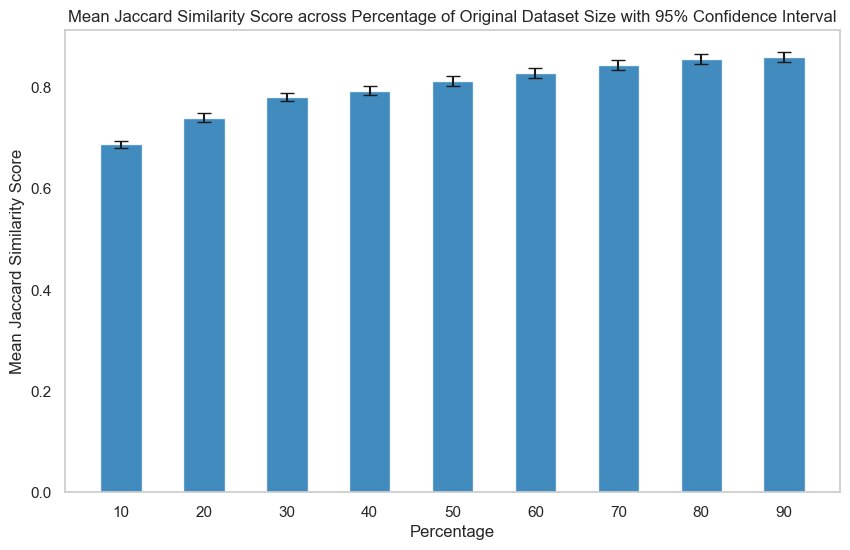

In [132]:
# Clear any previous plot
plt.close('all')

# Extracting data for plotting
percentages = [entry[0] for entry in bootresults_all_loaded]
means = [entry[1] for entry in bootresults_all_loaded]
ci_lower = [entry[2] for entry in bootresults_all_loaded]
ci_upper = [entry[3] for entry in bootresults_all_loaded]

# Convert lists to NumPy arrays for element-wise operations
means = np.array(means)
ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# Calculate the error bars (half of the confidence interval)
errors_lower = means - ci_lower
errors_upper = ci_upper - means

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(percentages, means, yerr=[errors_lower, errors_upper], capsize=5, width = 5, color="#1f77b4", alpha=0.85)
plt.xlabel('Percentage')
plt.ylabel('Mean Jaccard Similarity Score')
plt.title('Mean Jaccard Similarity Score across Percentage of Original Dataset Size with 95% Confidence Interval')
plt.xticks(percentages)  # Set x-axis ticks to percentages
plt.grid(False)

plt.savefig('percentage.jpg', format='jpeg', dpi=300)


plt.show()